In [1]:
import sys

sys.path.insert(0, '../Lab/')
sys.path.insert(0, '../New_Hybrids/')
from KNN.ItemKNNCBFRecommender import ItemKNNCBFRecommender
from KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from KNN.UserKNNCFRecommender import UserKNNCFRecommender
from UserIcmKNNCFRecommender import UserIcmKNNCFRecommender
from ItemIcmKNNCFRecommender import ItemIcmKNNCFRecommender
from WeightedHybridV2 import WeightedHybridScoreRecommender
from optimize_weights import optimize_weights
from SLIM_BPR.Cython.SLIM_BPR_Cython import SLIM_BPR_Cython
from GraphBased.P3alphaRecommender import P3alphaRecommender
from GraphBased.RP3betaRecommender import RP3betaRecommender
from MatrixFactorization.IALSRecommender import IALSRecommender
from Base.Evaluation.Evaluator import EvaluatorHoldout
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
import matplotlib
import matplotlib.pyplot as plt
from Base.Similarity.Compute_Similarity_Python import Compute_Similarity_Python

%matplotlib inline 

import numpy as np
sys.path.insert(0, '../datasets/')
from load_tables import load_ICM_csr, load_URM_csr
def plotta(t,maps):
    fig, ax = plt.subplots()
    ax.plot(t, maps)

    ax.set(xlabel='T', ylabel='MAP')
    ax.grid()
    plt.show()

In [2]:
ICM_all = load_ICM_csr()
URM_all = load_URM_csr()

# PARAMS ALE

In [3]:
userknn = {}
userknn["topK"] = 102
userknn["shrink"] = 1

itemknn = {}
itemknn["topK"] = 141
itemknn["shrink"] = 47


uicm = {}
uicm["topK"] = 181
uicm["shrink"] = 0.1
uicm["normalize"] = True

iicm = {}
iicm["topK"] = 893
iicm["shrink"] = 2
iicm["normalize"] = True

alpha = {}
alpha["alpha"] = 0.547615508822564
alpha["topK"] = 500

beta= {}
beta["topK"]=500
beta["alpha"]=0.3784740936494376
beta["beta"]=0.1
beta["implicit"]=False
beta["normalize_similarity"]=False

ials={}
ials["epochs"]=45
ials["num_factors"]=50
ials["alpha"]=10.0
ials["epsilon"]=10.0
ials["reg"]=1e-07
ials["init_mean"]=1.0
ials["init_std"]=0.6773548197826565

only_URM = {
    "URM_train" : None
}

also_ICM = {
    "URM_train" : None,
    "ICM" : ICM_all
}


In [4]:
ale_recs =  [
    P3alphaRecommender,
    ItemKNNCFRecommender,
    UserKNNCFRecommender,
    UserIcmKNNCFRecommender,
    RP3betaRecommender,
    ItemIcmKNNCFRecommender,
    IALSRecommender 
    ]
ale_fits = [alpha, itemknn, userknn,uicm,beta,iicm,ials]
ale_inits = [only_URM,only_URM,only_URM,also_ICM,only_URM,also_ICM,only_URM]
ale_weights = [
    0.7890828279804322,
    0.0001,
    0.31527729065553595,
    0.12162462193350662,
    0.06519442814723547,
    1.0,
    0.3445924625940507
]

# PARAMS ENRICO

In [5]:
cy = {}
cy["epochs"] = 400
cy["topK"] = 900
cy["positive_threshold_BPR"] = 7e-18
cy["learning_rate"] = 0.0002
cy["batch_size"] = 10
cy["sgd_mode"] = "sdg"

cython = {
    "URM_train" : None,
    "recompile_cython" : False,
    "verbose" : False
}


alpha = {}
alpha["alpha"] = 0.3784740936494376
alpha["topK"] = 500

In [6]:
enrico_recs = [
UserKNNCFRecommender,
P3alphaRecommender,
ItemIcmKNNCFRecommender,
UserIcmKNNCFRecommender,
ItemKNNCFRecommender,
RP3betaRecommender,
SLIM_BPR_Cython
]

enrico_fits = [userknn,alpha,iicm,uicm,itemknn,beta,cy]
enrico_inits = [only_URM,only_URM,also_ICM,also_ICM,only_URM,only_URM,cython]
enrico_weights = [1, 0.79488, 2.76, 0.144, 1.5, 0.294, 0.05]

# IBRIDO DI IBRIDI

In [7]:
recs_ibrid = [WeightedHybridScoreRecommender,WeightedHybridScoreRecommender]
ibrid_ale_init = {
    "URM_train" : None,
    "recs" : ale_recs,
    "inits" : ale_inits
}
ibrid_enrico_init = {
    "URM_train" : None,
    "recs" : enrico_recs,
    "inits" : enrico_inits
}

ibrid_inits = [ibrid_ale_init, ibrid_enrico_init]

ibrid_ale_fit = {}
ibrid_ale_fit["weights"] = ale_weights
ibrid_ale_fit["fits"] = ale_fits


ibrid_enrico_fit = {}
ibrid_enrico_fit["weights"] = enrico_weights
ibrid_enrico_fit["fits"] = enrico_fits


ibrid_fits = [ibrid_ale_fit,ibrid_enrico_fit]


In [11]:
def rinnova(URM_all, inits):
    URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.85)
    evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])

    for i in range(len(inits)):
        inits[i]["URM_train"] = URM_train
        if "inits" in inits[i]:
            for j in range(len(inits[i]["inits"])):
                inits[i]["inits"][j]["URM_train"] = URM_train

    return URM_train,evaluator_validation,inits

In [12]:
validations = 7
trials = [0.001,0.005,0.01,0.05,0.1,0.2,0.5,0.8,1,1.1,1.2,1.5,2]

In [16]:
MAPS = [[] for t in trials]

for v in range(validations):
    URM_train,evaluator_validation,inits = rinnova(URM_all, ibrid_inits)
    
    recommender = WeightedHybridScoreRecommender(URM_train, recs_ibrid, inits)

    print(f"VALIDATION {v+1} with trials {trials}")

    for i,t in enumerate(trials):

        recommender.fit(ibrid_fits,[1,t])

        result_dict, _ = evaluator_validation.evaluateRecommender(recommender)
        print(f"MAP {result_dict[10]['MAP']} WITH WEIGHTS {[1,t]}")
        MAPS[i].append(result_dict[10]["MAP"])
means = [np.mean(m) for m in MAPS]
best_t = trials[np.argmax(means)]
best_MAP = np.max(means)
print(f"BEST MAP {best_MAP} WITH T {best_t}")

WeightedHybridScoreRecommenderV2: URM Detected 37 (0.47 %) cold users.
WeightedHybridScoreRecommenderV2: URM Detected 2016 (7.76 %) cold items.
WeightedHybridScoreRecommenderV2: URM Detected 37 (0.47 %) cold users.
WeightedHybridScoreRecommenderV2: URM Detected 2016 (7.76 %) cold items.
P3alphaRecommender: URM Detected 37 (0.47 %) cold users.
P3alphaRecommender: URM Detected 2016 (7.76 %) cold items.
ItemKNNCFRecommender: URM Detected 37 (0.47 %) cold users.
ItemKNNCFRecommender: URM Detected 2016 (7.76 %) cold items.
UserKNNCFRecommender: URM Detected 37 (0.47 %) cold users.
UserKNNCFRecommender: URM Detected 2016 (7.76 %) cold items.
UserKNNCFRecommender: URM Detected 37 (0.47 %) cold users.
UserKNNCFRecommender: URM Detected 2016 (7.76 %) cold items.
UserKNNCFRecommender: URM Detected 37 (0.47 %) cold users.
UserKNNCFRecommender: URM Detected 35 (0.18 %) cold items.
RP3betaRecommender: URM Detected 37 (0.47 %) cold users.
RP3betaRecommender: URM Detected 2016 (7.76 %) cold items.
It

SLIM_BPR_Recommender: Epoch 11 of 400. Elapsed time 5.14 sec
SLIM_BPR_Recommender: Epoch 12 of 400. Elapsed time 5.95 sec
SLIM_BPR_Recommender: Epoch 13 of 400. Elapsed time 6.16 sec
SLIM_BPR_Recommender: Epoch 14 of 400. Elapsed time 6.48 sec
SLIM_BPR_Recommender: Epoch 15 of 400. Elapsed time 6.64 sec
SLIM_BPR_Recommender: Epoch 16 of 400. Elapsed time 6.80 sec
SLIM_BPR_Recommender: Epoch 17 of 400. Elapsed time 7.12 sec
SLIM_BPR_Recommender: Epoch 18 of 400. Elapsed time 7.23 sec
SLIM_BPR_Recommender: Epoch 19 of 400. Elapsed time 7.34 sec
SLIM_BPR_Recommender: Epoch 20 of 400. Elapsed time 7.54 sec
SLIM_BPR_Recommender: Epoch 21 of 400. Elapsed time 7.71 sec
SLIM_BPR_Recommender: Epoch 22 of 400. Elapsed time 7.86 sec
SLIM_BPR_Recommender: Epoch 23 of 400. Elapsed time 8.18 sec
SLIM_BPR_Recommender: Epoch 24 of 400. Elapsed time 8.31 sec
SLIM_BPR_Recommender: Epoch 25 of 400. Elapsed time 8.45 sec
SLIM_BPR_Recommender: Epoch 26 of 400. Elapsed time 8.58 sec
SLIM_BPR_Recommender: Ep

SLIM_BPR_Recommender: Epoch 143 of 400. Elapsed time 18.75 sec
SLIM_BPR_Recommender: Epoch 144 of 400. Elapsed time 18.79 sec
SLIM_BPR_Recommender: Epoch 145 of 400. Elapsed time 18.83 sec
SLIM_BPR_Recommender: Epoch 146 of 400. Elapsed time 18.88 sec
SLIM_BPR_Recommender: Epoch 147 of 400. Elapsed time 18.93 sec
SLIM_BPR_Recommender: Epoch 148 of 400. Elapsed time 18.98 sec
SLIM_BPR_Recommender: Epoch 149 of 400. Elapsed time 19.02 sec
SLIM_BPR_Recommender: Epoch 150 of 400. Elapsed time 19.06 sec
SLIM_BPR_Recommender: Epoch 151 of 400. Elapsed time 19.10 sec
SLIM_BPR_Recommender: Epoch 152 of 400. Elapsed time 19.14 sec
SLIM_BPR_Recommender: Epoch 153 of 400. Elapsed time 19.18 sec
SLIM_BPR_Recommender: Epoch 154 of 400. Elapsed time 19.22 sec
SLIM_BPR_Recommender: Epoch 155 of 400. Elapsed time 19.26 sec
SLIM_BPR_Recommender: Epoch 156 of 400. Elapsed time 19.30 sec
SLIM_BPR_Recommender: Epoch 157 of 400. Elapsed time 19.34 sec
SLIM_BPR_Recommender: Epoch 158 of 400. Elapsed time 19

SLIM_BPR_Recommender: Epoch 274 of 400. Elapsed time 29.74 sec
SLIM_BPR_Recommender: Epoch 275 of 400. Elapsed time 29.80 sec
SLIM_BPR_Recommender: Epoch 276 of 400. Elapsed time 29.84 sec
SLIM_BPR_Recommender: Epoch 277 of 400. Elapsed time 29.88 sec
SLIM_BPR_Recommender: Epoch 278 of 400. Elapsed time 29.93 sec
SLIM_BPR_Recommender: Epoch 279 of 400. Elapsed time 30.03 sec
SLIM_BPR_Recommender: Epoch 280 of 400. Elapsed time 30.17 sec
SLIM_BPR_Recommender: Epoch 281 of 400. Elapsed time 30.24 sec
SLIM_BPR_Recommender: Epoch 282 of 400. Elapsed time 30.28 sec
SLIM_BPR_Recommender: Epoch 283 of 400. Elapsed time 30.33 sec
SLIM_BPR_Recommender: Epoch 284 of 400. Elapsed time 30.41 sec
SLIM_BPR_Recommender: Epoch 285 of 400. Elapsed time 30.50 sec
SLIM_BPR_Recommender: Epoch 286 of 400. Elapsed time 30.59 sec
SLIM_BPR_Recommender: Epoch 287 of 400. Elapsed time 30.72 sec
SLIM_BPR_Recommender: Epoch 288 of 400. Elapsed time 30.87 sec
SLIM_BPR_Recommender: Epoch 289 of 400. Elapsed time 31

EvaluatorHoldout: Processed 2000 ( 40.28% ) in 1.24 min. Users per second: 27
EvaluatorHoldout: Processed 3000 ( 60.42% ) in 1.86 min. Users per second: 27
EvaluatorHoldout: Processed 4000 ( 80.56% ) in 2.56 min. Users per second: 26
EvaluatorHoldout: Processed 4965 ( 100.00% ) in 3.11 min. Users per second: 27
MAP 0.07059738111984182 WITH WEIGHTS [1, 0.001]
--------FITTING START-------
--------FITTING IN PROGRESS: WeightedHybridScoreRecommenderV2-------
--------FITTING START-------
--------FITTING IN PROGRESS: P3alphaRecommender-------
--------FITTING IN PROGRESS: ItemKNNCFRecommender-------
Similarity column 25975 ( 100 % ), 1455.03 column/sec, elapsed time 0.30 min
--------FITTING IN PROGRESS: UserKNNCFRecommender-------
Similarity column 7947 ( 100 % ), 3779.23 column/sec, elapsed time 0.04 min
--------FITTING IN PROGRESS: UserKNNCFRecommender-------
Similarity column 7947 ( 100 % ), 3035.15 column/sec, elapsed time 0.04 min
Similarity column 7947 ( 100 % ), 822.10 column/sec, elap

SLIM_BPR_Recommender: Epoch 55 of 400. Elapsed time 3.48 sec
SLIM_BPR_Recommender: Epoch 56 of 400. Elapsed time 3.53 sec
SLIM_BPR_Recommender: Epoch 57 of 400. Elapsed time 3.56 sec
SLIM_BPR_Recommender: Epoch 58 of 400. Elapsed time 3.59 sec
SLIM_BPR_Recommender: Epoch 59 of 400. Elapsed time 3.62 sec
SLIM_BPR_Recommender: Epoch 60 of 400. Elapsed time 3.64 sec
SLIM_BPR_Recommender: Epoch 61 of 400. Elapsed time 3.68 sec
SLIM_BPR_Recommender: Epoch 62 of 400. Elapsed time 3.71 sec
SLIM_BPR_Recommender: Epoch 63 of 400. Elapsed time 3.74 sec
SLIM_BPR_Recommender: Epoch 64 of 400. Elapsed time 3.76 sec
SLIM_BPR_Recommender: Epoch 65 of 400. Elapsed time 3.79 sec
SLIM_BPR_Recommender: Epoch 66 of 400. Elapsed time 3.83 sec
SLIM_BPR_Recommender: Epoch 67 of 400. Elapsed time 3.86 sec
SLIM_BPR_Recommender: Epoch 68 of 400. Elapsed time 3.89 sec
SLIM_BPR_Recommender: Epoch 69 of 400. Elapsed time 3.91 sec
SLIM_BPR_Recommender: Epoch 70 of 400. Elapsed time 3.94 sec
SLIM_BPR_Recommender: Ep

SLIM_BPR_Recommender: Epoch 188 of 400. Elapsed time 7.59 sec
SLIM_BPR_Recommender: Epoch 189 of 400. Elapsed time 7.62 sec
SLIM_BPR_Recommender: Epoch 190 of 400. Elapsed time 7.64 sec
SLIM_BPR_Recommender: Epoch 191 of 400. Elapsed time 7.67 sec
SLIM_BPR_Recommender: Epoch 192 of 400. Elapsed time 7.70 sec
SLIM_BPR_Recommender: Epoch 193 of 400. Elapsed time 7.73 sec
SLIM_BPR_Recommender: Epoch 194 of 400. Elapsed time 7.75 sec
SLIM_BPR_Recommender: Epoch 195 of 400. Elapsed time 7.79 sec
SLIM_BPR_Recommender: Epoch 196 of 400. Elapsed time 7.82 sec
SLIM_BPR_Recommender: Epoch 197 of 400. Elapsed time 7.84 sec
SLIM_BPR_Recommender: Epoch 198 of 400. Elapsed time 7.87 sec
SLIM_BPR_Recommender: Epoch 199 of 400. Elapsed time 7.90 sec
SLIM_BPR_Recommender: Epoch 200 of 400. Elapsed time 7.92 sec
SLIM_BPR_Recommender: Epoch 201 of 400. Elapsed time 7.95 sec
SLIM_BPR_Recommender: Epoch 202 of 400. Elapsed time 7.98 sec
SLIM_BPR_Recommender: Epoch 203 of 400. Elapsed time 8.00 sec
SLIM_BPR

SLIM_BPR_Recommender: Epoch 320 of 400. Elapsed time 11.26 sec
SLIM_BPR_Recommender: Epoch 321 of 400. Elapsed time 11.28 sec
SLIM_BPR_Recommender: Epoch 322 of 400. Elapsed time 11.31 sec
SLIM_BPR_Recommender: Epoch 323 of 400. Elapsed time 11.34 sec
SLIM_BPR_Recommender: Epoch 324 of 400. Elapsed time 11.37 sec
SLIM_BPR_Recommender: Epoch 325 of 400. Elapsed time 11.40 sec
SLIM_BPR_Recommender: Epoch 326 of 400. Elapsed time 11.42 sec
SLIM_BPR_Recommender: Epoch 327 of 400. Elapsed time 11.45 sec
SLIM_BPR_Recommender: Epoch 328 of 400. Elapsed time 11.48 sec
SLIM_BPR_Recommender: Epoch 329 of 400. Elapsed time 11.50 sec
SLIM_BPR_Recommender: Epoch 330 of 400. Elapsed time 11.53 sec
SLIM_BPR_Recommender: Epoch 331 of 400. Elapsed time 11.56 sec
SLIM_BPR_Recommender: Epoch 332 of 400. Elapsed time 11.59 sec
SLIM_BPR_Recommender: Epoch 333 of 400. Elapsed time 11.62 sec
SLIM_BPR_Recommender: Epoch 334 of 400. Elapsed time 11.65 sec
SLIM_BPR_Recommender: Epoch 335 of 400. Elapsed time 11

IALSRecommender: Epoch 32 of 45. Elapsed time 5.99 min
IALSRecommender: Epoch 33 of 45. Elapsed time 6.23 min
IALSRecommender: Epoch 34 of 45. Elapsed time 6.39 min
IALSRecommender: Epoch 35 of 45. Elapsed time 6.55 min
IALSRecommender: Epoch 36 of 45. Elapsed time 6.71 min
IALSRecommender: Epoch 37 of 45. Elapsed time 6.90 min
IALSRecommender: Epoch 38 of 45. Elapsed time 7.09 min
IALSRecommender: Epoch 39 of 45. Elapsed time 7.24 min
IALSRecommender: Epoch 40 of 45. Elapsed time 7.56 min
IALSRecommender: Epoch 41 of 45. Elapsed time 7.90 min
IALSRecommender: Epoch 42 of 45. Elapsed time 8.17 min
IALSRecommender: Epoch 43 of 45. Elapsed time 8.38 min
IALSRecommender: Epoch 44 of 45. Elapsed time 8.61 min
IALSRecommender: Epoch 45 of 45. Elapsed time 8.87 min
IALSRecommender: Terminating at epoch 45. Elapsed time 8.87 min
------FITTING END------
--------FITTING IN PROGRESS: WeightedHybridScoreRecommenderV2-------
--------FITTING START-------
--------FITTING IN PROGRESS: UserKNNCFRecomm

SLIM_BPR_Recommender: Epoch 105 of 400. Elapsed time 5.26 sec
SLIM_BPR_Recommender: Epoch 106 of 400. Elapsed time 5.29 sec
SLIM_BPR_Recommender: Epoch 107 of 400. Elapsed time 5.33 sec
SLIM_BPR_Recommender: Epoch 108 of 400. Elapsed time 5.37 sec
SLIM_BPR_Recommender: Epoch 109 of 400. Elapsed time 5.41 sec
SLIM_BPR_Recommender: Epoch 110 of 400. Elapsed time 5.44 sec
SLIM_BPR_Recommender: Epoch 111 of 400. Elapsed time 5.47 sec
SLIM_BPR_Recommender: Epoch 112 of 400. Elapsed time 5.51 sec
SLIM_BPR_Recommender: Epoch 113 of 400. Elapsed time 5.54 sec
SLIM_BPR_Recommender: Epoch 114 of 400. Elapsed time 5.57 sec
SLIM_BPR_Recommender: Epoch 115 of 400. Elapsed time 5.60 sec
SLIM_BPR_Recommender: Epoch 116 of 400. Elapsed time 5.63 sec
SLIM_BPR_Recommender: Epoch 117 of 400. Elapsed time 5.66 sec
SLIM_BPR_Recommender: Epoch 118 of 400. Elapsed time 5.68 sec
SLIM_BPR_Recommender: Epoch 119 of 400. Elapsed time 5.71 sec
SLIM_BPR_Recommender: Epoch 120 of 400. Elapsed time 5.74 sec
SLIM_BPR

SLIM_BPR_Recommender: Epoch 238 of 400. Elapsed time 9.35 sec
SLIM_BPR_Recommender: Epoch 239 of 400. Elapsed time 9.40 sec
SLIM_BPR_Recommender: Epoch 240 of 400. Elapsed time 9.43 sec
SLIM_BPR_Recommender: Epoch 241 of 400. Elapsed time 9.46 sec
SLIM_BPR_Recommender: Epoch 242 of 400. Elapsed time 9.49 sec
SLIM_BPR_Recommender: Epoch 243 of 400. Elapsed time 9.51 sec
SLIM_BPR_Recommender: Epoch 244 of 400. Elapsed time 9.54 sec
SLIM_BPR_Recommender: Epoch 245 of 400. Elapsed time 9.57 sec
SLIM_BPR_Recommender: Epoch 246 of 400. Elapsed time 9.61 sec
SLIM_BPR_Recommender: Epoch 247 of 400. Elapsed time 9.65 sec
SLIM_BPR_Recommender: Epoch 248 of 400. Elapsed time 9.69 sec
SLIM_BPR_Recommender: Epoch 249 of 400. Elapsed time 9.73 sec
SLIM_BPR_Recommender: Epoch 250 of 400. Elapsed time 9.76 sec
SLIM_BPR_Recommender: Epoch 251 of 400. Elapsed time 9.79 sec
SLIM_BPR_Recommender: Epoch 252 of 400. Elapsed time 9.83 sec
SLIM_BPR_Recommender: Epoch 253 of 400. Elapsed time 9.87 sec
SLIM_BPR

SLIM_BPR_Recommender: Epoch 369 of 400. Elapsed time 13.69 sec
SLIM_BPR_Recommender: Epoch 370 of 400. Elapsed time 13.72 sec
SLIM_BPR_Recommender: Epoch 371 of 400. Elapsed time 13.74 sec
SLIM_BPR_Recommender: Epoch 372 of 400. Elapsed time 13.77 sec
SLIM_BPR_Recommender: Epoch 373 of 400. Elapsed time 13.79 sec
SLIM_BPR_Recommender: Epoch 374 of 400. Elapsed time 13.81 sec
SLIM_BPR_Recommender: Epoch 375 of 400. Elapsed time 13.85 sec
SLIM_BPR_Recommender: Epoch 376 of 400. Elapsed time 13.89 sec
SLIM_BPR_Recommender: Epoch 377 of 400. Elapsed time 13.92 sec
SLIM_BPR_Recommender: Epoch 378 of 400. Elapsed time 13.96 sec
SLIM_BPR_Recommender: Epoch 379 of 400. Elapsed time 14.00 sec
SLIM_BPR_Recommender: Epoch 380 of 400. Elapsed time 14.03 sec
SLIM_BPR_Recommender: Epoch 381 of 400. Elapsed time 14.08 sec
SLIM_BPR_Recommender: Epoch 382 of 400. Elapsed time 14.12 sec
SLIM_BPR_Recommender: Epoch 383 of 400. Elapsed time 14.16 sec
SLIM_BPR_Recommender: Epoch 384 of 400. Elapsed time 14

SLIM_BPR_Recommender: Epoch 21 of 400. Elapsed time 4.48 sec
SLIM_BPR_Recommender: Epoch 22 of 400. Elapsed time 4.60 sec
SLIM_BPR_Recommender: Epoch 23 of 400. Elapsed time 4.70 sec
SLIM_BPR_Recommender: Epoch 24 of 400. Elapsed time 4.76 sec
SLIM_BPR_Recommender: Epoch 25 of 400. Elapsed time 4.84 sec
SLIM_BPR_Recommender: Epoch 26 of 400. Elapsed time 4.92 sec
SLIM_BPR_Recommender: Epoch 27 of 400. Elapsed time 5.01 sec
SLIM_BPR_Recommender: Epoch 28 of 400. Elapsed time 5.12 sec
SLIM_BPR_Recommender: Epoch 29 of 400. Elapsed time 5.25 sec
SLIM_BPR_Recommender: Epoch 30 of 400. Elapsed time 5.45 sec
SLIM_BPR_Recommender: Epoch 31 of 400. Elapsed time 5.51 sec
SLIM_BPR_Recommender: Epoch 32 of 400. Elapsed time 5.59 sec
SLIM_BPR_Recommender: Epoch 33 of 400. Elapsed time 5.67 sec
SLIM_BPR_Recommender: Epoch 34 of 400. Elapsed time 5.72 sec
SLIM_BPR_Recommender: Epoch 35 of 400. Elapsed time 5.80 sec
SLIM_BPR_Recommender: Epoch 36 of 400. Elapsed time 5.91 sec
SLIM_BPR_Recommender: Ep

SLIM_BPR_Recommender: Epoch 154 of 400. Elapsed time 12.25 sec
SLIM_BPR_Recommender: Epoch 155 of 400. Elapsed time 12.28 sec
SLIM_BPR_Recommender: Epoch 156 of 400. Elapsed time 12.33 sec
SLIM_BPR_Recommender: Epoch 157 of 400. Elapsed time 12.37 sec
SLIM_BPR_Recommender: Epoch 158 of 400. Elapsed time 12.40 sec
SLIM_BPR_Recommender: Epoch 159 of 400. Elapsed time 12.43 sec
SLIM_BPR_Recommender: Epoch 160 of 400. Elapsed time 12.49 sec
SLIM_BPR_Recommender: Epoch 161 of 400. Elapsed time 12.55 sec
SLIM_BPR_Recommender: Epoch 162 of 400. Elapsed time 12.65 sec
SLIM_BPR_Recommender: Epoch 163 of 400. Elapsed time 12.71 sec
SLIM_BPR_Recommender: Epoch 164 of 400. Elapsed time 12.78 sec
SLIM_BPR_Recommender: Epoch 165 of 400. Elapsed time 12.84 sec
SLIM_BPR_Recommender: Epoch 166 of 400. Elapsed time 12.89 sec
SLIM_BPR_Recommender: Epoch 167 of 400. Elapsed time 12.93 sec
SLIM_BPR_Recommender: Epoch 168 of 400. Elapsed time 12.99 sec
SLIM_BPR_Recommender: Epoch 169 of 400. Elapsed time 13

SLIM_BPR_Recommender: Epoch 285 of 400. Elapsed time 18.57 sec
SLIM_BPR_Recommender: Epoch 286 of 400. Elapsed time 18.61 sec
SLIM_BPR_Recommender: Epoch 287 of 400. Elapsed time 18.65 sec
SLIM_BPR_Recommender: Epoch 288 of 400. Elapsed time 18.68 sec
SLIM_BPR_Recommender: Epoch 289 of 400. Elapsed time 18.74 sec
SLIM_BPR_Recommender: Epoch 290 of 400. Elapsed time 18.81 sec
SLIM_BPR_Recommender: Epoch 291 of 400. Elapsed time 18.87 sec
SLIM_BPR_Recommender: Epoch 292 of 400. Elapsed time 18.90 sec
SLIM_BPR_Recommender: Epoch 293 of 400. Elapsed time 18.93 sec
SLIM_BPR_Recommender: Epoch 294 of 400. Elapsed time 18.96 sec
SLIM_BPR_Recommender: Epoch 295 of 400. Elapsed time 18.99 sec
SLIM_BPR_Recommender: Epoch 296 of 400. Elapsed time 19.02 sec
SLIM_BPR_Recommender: Epoch 297 of 400. Elapsed time 19.05 sec
SLIM_BPR_Recommender: Epoch 298 of 400. Elapsed time 19.08 sec
SLIM_BPR_Recommender: Epoch 299 of 400. Elapsed time 19.11 sec
SLIM_BPR_Recommender: Epoch 300 of 400. Elapsed time 19

Similarity column 25975 ( 100 % ), 1528.41 column/sec, elapsed time 0.28 min
--------FITTING IN PROGRESS: UserKNNCFRecommender-------
Similarity column 7947 ( 100 % ), 3784.18 column/sec, elapsed time 0.04 min
--------FITTING IN PROGRESS: UserKNNCFRecommender-------
Similarity column 7947 ( 100 % ), 3513.94 column/sec, elapsed time 0.04 min
Similarity column 7947 ( 100 % ), 774.73 column/sec, elapsed time 0.17 min
--------FITTING IN PROGRESS: RP3betaRecommender-------
RP3betaRecommender: Processed 24800 ( 95.48% ) in 1.01 minutes. Rows per second: 409
--------FITTING IN PROGRESS: ItemKNNCFRecommender-------
Similarity column 25975 ( 100 % ), 1399.08 column/sec, elapsed time 0.31 min
Similarity column 25975 ( 100 % ), 894.68 column/sec, elapsed time 0.48 min
--------FITTING IN PROGRESS: IALSRecommender-------
IALSRecommender: Epoch 1 of 45. Elapsed time 16.44 sec
IALSRecommender: Epoch 2 of 45. Elapsed time 34.66 sec
IALSRecommender: Epoch 3 of 45. Elapsed time 53.32 sec
IALSRecommender

SLIM_BPR_Recommender: Epoch 61 of 400. Elapsed time 5.23 sec
SLIM_BPR_Recommender: Epoch 62 of 400. Elapsed time 5.29 sec
SLIM_BPR_Recommender: Epoch 63 of 400. Elapsed time 5.33 sec
SLIM_BPR_Recommender: Epoch 64 of 400. Elapsed time 5.36 sec
SLIM_BPR_Recommender: Epoch 65 of 400. Elapsed time 5.41 sec
SLIM_BPR_Recommender: Epoch 66 of 400. Elapsed time 5.46 sec
SLIM_BPR_Recommender: Epoch 67 of 400. Elapsed time 5.51 sec
SLIM_BPR_Recommender: Epoch 68 of 400. Elapsed time 5.58 sec
SLIM_BPR_Recommender: Epoch 69 of 400. Elapsed time 5.62 sec
SLIM_BPR_Recommender: Epoch 70 of 400. Elapsed time 5.68 sec
SLIM_BPR_Recommender: Epoch 71 of 400. Elapsed time 5.73 sec
SLIM_BPR_Recommender: Epoch 72 of 400. Elapsed time 5.77 sec
SLIM_BPR_Recommender: Epoch 73 of 400. Elapsed time 5.81 sec
SLIM_BPR_Recommender: Epoch 74 of 400. Elapsed time 5.85 sec
SLIM_BPR_Recommender: Epoch 75 of 400. Elapsed time 5.89 sec
SLIM_BPR_Recommender: Epoch 76 of 400. Elapsed time 5.93 sec
SLIM_BPR_Recommender: Ep

SLIM_BPR_Recommender: Epoch 194 of 400. Elapsed time 11.16 sec
SLIM_BPR_Recommender: Epoch 195 of 400. Elapsed time 11.20 sec
SLIM_BPR_Recommender: Epoch 196 of 400. Elapsed time 11.25 sec
SLIM_BPR_Recommender: Epoch 197 of 400. Elapsed time 11.29 sec
SLIM_BPR_Recommender: Epoch 198 of 400. Elapsed time 11.36 sec
SLIM_BPR_Recommender: Epoch 199 of 400. Elapsed time 11.40 sec
SLIM_BPR_Recommender: Epoch 200 of 400. Elapsed time 11.44 sec
SLIM_BPR_Recommender: Epoch 201 of 400. Elapsed time 11.48 sec
SLIM_BPR_Recommender: Epoch 202 of 400. Elapsed time 11.52 sec
SLIM_BPR_Recommender: Epoch 203 of 400. Elapsed time 11.56 sec
SLIM_BPR_Recommender: Epoch 204 of 400. Elapsed time 11.60 sec
SLIM_BPR_Recommender: Epoch 205 of 400. Elapsed time 11.64 sec
SLIM_BPR_Recommender: Epoch 206 of 400. Elapsed time 11.68 sec
SLIM_BPR_Recommender: Epoch 207 of 400. Elapsed time 11.72 sec
SLIM_BPR_Recommender: Epoch 208 of 400. Elapsed time 11.76 sec
SLIM_BPR_Recommender: Epoch 209 of 400. Elapsed time 11

SLIM_BPR_Recommender: Epoch 325 of 400. Elapsed time 17.85 sec
SLIM_BPR_Recommender: Epoch 326 of 400. Elapsed time 17.89 sec
SLIM_BPR_Recommender: Epoch 327 of 400. Elapsed time 17.94 sec
SLIM_BPR_Recommender: Epoch 328 of 400. Elapsed time 17.98 sec
SLIM_BPR_Recommender: Epoch 329 of 400. Elapsed time 18.01 sec
SLIM_BPR_Recommender: Epoch 330 of 400. Elapsed time 18.05 sec
SLIM_BPR_Recommender: Epoch 331 of 400. Elapsed time 18.12 sec
SLIM_BPR_Recommender: Epoch 332 of 400. Elapsed time 18.19 sec
SLIM_BPR_Recommender: Epoch 333 of 400. Elapsed time 18.24 sec
SLIM_BPR_Recommender: Epoch 334 of 400. Elapsed time 18.28 sec
SLIM_BPR_Recommender: Epoch 335 of 400. Elapsed time 18.34 sec
SLIM_BPR_Recommender: Epoch 336 of 400. Elapsed time 18.39 sec
SLIM_BPR_Recommender: Epoch 337 of 400. Elapsed time 18.43 sec
SLIM_BPR_Recommender: Epoch 338 of 400. Elapsed time 18.47 sec
SLIM_BPR_Recommender: Epoch 339 of 400. Elapsed time 18.53 sec
SLIM_BPR_Recommender: Epoch 340 of 400. Elapsed time 18

IALSRecommender: Epoch 35 of 45. Elapsed time 12.04 min
IALSRecommender: Epoch 36 of 45. Elapsed time 12.37 min
IALSRecommender: Epoch 37 of 45. Elapsed time 12.71 min
IALSRecommender: Epoch 38 of 45. Elapsed time 13.08 min
IALSRecommender: Epoch 39 of 45. Elapsed time 13.45 min
IALSRecommender: Epoch 40 of 45. Elapsed time 13.84 min
IALSRecommender: Epoch 41 of 45. Elapsed time 14.17 min
IALSRecommender: Epoch 42 of 45. Elapsed time 14.52 min
IALSRecommender: Epoch 43 of 45. Elapsed time 14.85 min
IALSRecommender: Epoch 44 of 45. Elapsed time 15.19 min
IALSRecommender: Epoch 45 of 45. Elapsed time 15.50 min
IALSRecommender: Terminating at epoch 45. Elapsed time 15.50 min
------FITTING END------
--------FITTING IN PROGRESS: WeightedHybridScoreRecommenderV2-------
--------FITTING START-------
--------FITTING IN PROGRESS: UserKNNCFRecommender-------
Similarity column 7947 ( 100 % ), 4506.98 column/sec, elapsed time 0.03 min
--------FITTING IN PROGRESS: P3alphaRecommender-------
--------F

SLIM_BPR_Recommender: Epoch 107 of 400. Elapsed time 6.25 sec
SLIM_BPR_Recommender: Epoch 108 of 400. Elapsed time 6.29 sec
SLIM_BPR_Recommender: Epoch 109 of 400. Elapsed time 6.33 sec
SLIM_BPR_Recommender: Epoch 110 of 400. Elapsed time 6.36 sec
SLIM_BPR_Recommender: Epoch 111 of 400. Elapsed time 6.39 sec
SLIM_BPR_Recommender: Epoch 112 of 400. Elapsed time 6.43 sec
SLIM_BPR_Recommender: Epoch 113 of 400. Elapsed time 6.47 sec
SLIM_BPR_Recommender: Epoch 114 of 400. Elapsed time 6.50 sec
SLIM_BPR_Recommender: Epoch 115 of 400. Elapsed time 6.55 sec
SLIM_BPR_Recommender: Epoch 116 of 400. Elapsed time 6.58 sec
SLIM_BPR_Recommender: Epoch 117 of 400. Elapsed time 6.62 sec
SLIM_BPR_Recommender: Epoch 118 of 400. Elapsed time 6.67 sec
SLIM_BPR_Recommender: Epoch 119 of 400. Elapsed time 6.70 sec
SLIM_BPR_Recommender: Epoch 120 of 400. Elapsed time 6.74 sec
SLIM_BPR_Recommender: Epoch 121 of 400. Elapsed time 6.77 sec
SLIM_BPR_Recommender: Epoch 122 of 400. Elapsed time 6.81 sec
SLIM_BPR

SLIM_BPR_Recommender: Epoch 239 of 400. Elapsed time 11.33 sec
SLIM_BPR_Recommender: Epoch 240 of 400. Elapsed time 11.37 sec
SLIM_BPR_Recommender: Epoch 241 of 400. Elapsed time 11.40 sec
SLIM_BPR_Recommender: Epoch 242 of 400. Elapsed time 11.44 sec
SLIM_BPR_Recommender: Epoch 243 of 400. Elapsed time 11.48 sec
SLIM_BPR_Recommender: Epoch 244 of 400. Elapsed time 11.52 sec
SLIM_BPR_Recommender: Epoch 245 of 400. Elapsed time 11.55 sec
SLIM_BPR_Recommender: Epoch 246 of 400. Elapsed time 11.59 sec
SLIM_BPR_Recommender: Epoch 247 of 400. Elapsed time 11.63 sec
SLIM_BPR_Recommender: Epoch 248 of 400. Elapsed time 11.65 sec
SLIM_BPR_Recommender: Epoch 249 of 400. Elapsed time 11.69 sec
SLIM_BPR_Recommender: Epoch 250 of 400. Elapsed time 11.72 sec
SLIM_BPR_Recommender: Epoch 251 of 400. Elapsed time 11.76 sec
SLIM_BPR_Recommender: Epoch 252 of 400. Elapsed time 11.79 sec
SLIM_BPR_Recommender: Epoch 253 of 400. Elapsed time 11.83 sec
SLIM_BPR_Recommender: Epoch 254 of 400. Elapsed time 11

SLIM_BPR_Recommender: Epoch 370 of 400. Elapsed time 16.99 sec
SLIM_BPR_Recommender: Epoch 371 of 400. Elapsed time 17.02 sec
SLIM_BPR_Recommender: Epoch 372 of 400. Elapsed time 17.06 sec
SLIM_BPR_Recommender: Epoch 373 of 400. Elapsed time 17.10 sec
SLIM_BPR_Recommender: Epoch 374 of 400. Elapsed time 17.13 sec
SLIM_BPR_Recommender: Epoch 375 of 400. Elapsed time 17.17 sec
SLIM_BPR_Recommender: Epoch 376 of 400. Elapsed time 17.20 sec
SLIM_BPR_Recommender: Epoch 377 of 400. Elapsed time 17.25 sec
SLIM_BPR_Recommender: Epoch 378 of 400. Elapsed time 17.29 sec
SLIM_BPR_Recommender: Epoch 379 of 400. Elapsed time 17.33 sec
SLIM_BPR_Recommender: Epoch 380 of 400. Elapsed time 17.37 sec
SLIM_BPR_Recommender: Epoch 381 of 400. Elapsed time 17.40 sec
SLIM_BPR_Recommender: Epoch 382 of 400. Elapsed time 17.44 sec
SLIM_BPR_Recommender: Epoch 383 of 400. Elapsed time 17.48 sec
SLIM_BPR_Recommender: Epoch 384 of 400. Elapsed time 17.52 sec
SLIM_BPR_Recommender: Epoch 385 of 400. Elapsed time 17

SLIM_BPR_Recommender: Epoch 22 of 400. Elapsed time 0.57 sec
SLIM_BPR_Recommender: Epoch 23 of 400. Elapsed time 0.60 sec
SLIM_BPR_Recommender: Epoch 24 of 400. Elapsed time 0.62 sec
SLIM_BPR_Recommender: Epoch 25 of 400. Elapsed time 0.65 sec
SLIM_BPR_Recommender: Epoch 26 of 400. Elapsed time 0.68 sec
SLIM_BPR_Recommender: Epoch 27 of 400. Elapsed time 0.70 sec
SLIM_BPR_Recommender: Epoch 28 of 400. Elapsed time 0.73 sec
SLIM_BPR_Recommender: Epoch 29 of 400. Elapsed time 0.76 sec
SLIM_BPR_Recommender: Epoch 30 of 400. Elapsed time 0.78 sec
SLIM_BPR_Recommender: Epoch 31 of 400. Elapsed time 0.81 sec
SLIM_BPR_Recommender: Epoch 32 of 400. Elapsed time 0.83 sec
SLIM_BPR_Recommender: Epoch 33 of 400. Elapsed time 0.85 sec
SLIM_BPR_Recommender: Epoch 34 of 400. Elapsed time 0.88 sec
SLIM_BPR_Recommender: Epoch 35 of 400. Elapsed time 0.90 sec
SLIM_BPR_Recommender: Epoch 36 of 400. Elapsed time 0.93 sec
SLIM_BPR_Recommender: Epoch 37 of 400. Elapsed time 0.95 sec
SLIM_BPR_Recommender: Ep

SLIM_BPR_Recommender: Epoch 156 of 400. Elapsed time 3.93 sec
SLIM_BPR_Recommender: Epoch 157 of 400. Elapsed time 3.96 sec
SLIM_BPR_Recommender: Epoch 158 of 400. Elapsed time 3.98 sec
SLIM_BPR_Recommender: Epoch 159 of 400. Elapsed time 4.01 sec
SLIM_BPR_Recommender: Epoch 160 of 400. Elapsed time 4.03 sec
SLIM_BPR_Recommender: Epoch 161 of 400. Elapsed time 4.05 sec
SLIM_BPR_Recommender: Epoch 162 of 400. Elapsed time 4.08 sec
SLIM_BPR_Recommender: Epoch 163 of 400. Elapsed time 4.10 sec
SLIM_BPR_Recommender: Epoch 164 of 400. Elapsed time 4.13 sec
SLIM_BPR_Recommender: Epoch 165 of 400. Elapsed time 4.16 sec
SLIM_BPR_Recommender: Epoch 166 of 400. Elapsed time 4.18 sec
SLIM_BPR_Recommender: Epoch 167 of 400. Elapsed time 4.21 sec
SLIM_BPR_Recommender: Epoch 168 of 400. Elapsed time 4.23 sec
SLIM_BPR_Recommender: Epoch 169 of 400. Elapsed time 4.27 sec
SLIM_BPR_Recommender: Epoch 170 of 400. Elapsed time 4.30 sec
SLIM_BPR_Recommender: Epoch 171 of 400. Elapsed time 4.33 sec
SLIM_BPR

SLIM_BPR_Recommender: Epoch 289 of 400. Elapsed time 7.66 sec
SLIM_BPR_Recommender: Epoch 290 of 400. Elapsed time 7.69 sec
SLIM_BPR_Recommender: Epoch 291 of 400. Elapsed time 7.72 sec
SLIM_BPR_Recommender: Epoch 292 of 400. Elapsed time 7.76 sec
SLIM_BPR_Recommender: Epoch 293 of 400. Elapsed time 7.78 sec
SLIM_BPR_Recommender: Epoch 294 of 400. Elapsed time 7.81 sec
SLIM_BPR_Recommender: Epoch 295 of 400. Elapsed time 7.83 sec
SLIM_BPR_Recommender: Epoch 296 of 400. Elapsed time 7.86 sec
SLIM_BPR_Recommender: Epoch 297 of 400. Elapsed time 7.88 sec
SLIM_BPR_Recommender: Epoch 298 of 400. Elapsed time 7.91 sec
SLIM_BPR_Recommender: Epoch 299 of 400. Elapsed time 7.93 sec
SLIM_BPR_Recommender: Epoch 300 of 400. Elapsed time 7.96 sec
SLIM_BPR_Recommender: Epoch 301 of 400. Elapsed time 7.98 sec
SLIM_BPR_Recommender: Epoch 302 of 400. Elapsed time 8.01 sec
SLIM_BPR_Recommender: Epoch 303 of 400. Elapsed time 8.03 sec
SLIM_BPR_Recommender: Epoch 304 of 400. Elapsed time 8.05 sec
SLIM_BPR

Similarity column 25975 ( 100 % ), 1191.00 column/sec, elapsed time 0.36 min
--------FITTING IN PROGRESS: IALSRecommender-------
IALSRecommender: Epoch 1 of 45. Elapsed time 10.38 sec
IALSRecommender: Epoch 2 of 45. Elapsed time 21.09 sec
IALSRecommender: Epoch 3 of 45. Elapsed time 31.60 sec
IALSRecommender: Epoch 4 of 45. Elapsed time 42.70 sec
IALSRecommender: Epoch 5 of 45. Elapsed time 53.59 sec
IALSRecommender: Epoch 6 of 45. Elapsed time 1.05 min
IALSRecommender: Epoch 7 of 45. Elapsed time 1.20 min
IALSRecommender: Epoch 8 of 45. Elapsed time 1.35 min
IALSRecommender: Epoch 9 of 45. Elapsed time 1.49 min
IALSRecommender: Epoch 10 of 45. Elapsed time 1.65 min
IALSRecommender: Epoch 11 of 45. Elapsed time 1.79 min
IALSRecommender: Epoch 12 of 45. Elapsed time 1.95 min
IALSRecommender: Epoch 13 of 45. Elapsed time 2.11 min
IALSRecommender: Epoch 14 of 45. Elapsed time 2.26 min
IALSRecommender: Epoch 15 of 45. Elapsed time 2.42 min
IALSRecommender: Epoch 16 of 45. Elapsed time 2.58

SLIM_BPR_Recommender: Epoch 72 of 400. Elapsed time 8.77 sec
SLIM_BPR_Recommender: Epoch 73 of 400. Elapsed time 8.90 sec
SLIM_BPR_Recommender: Epoch 74 of 400. Elapsed time 9.02 sec
SLIM_BPR_Recommender: Epoch 75 of 400. Elapsed time 9.07 sec
SLIM_BPR_Recommender: Epoch 76 of 400. Elapsed time 9.12 sec
SLIM_BPR_Recommender: Epoch 77 of 400. Elapsed time 9.18 sec
SLIM_BPR_Recommender: Epoch 78 of 400. Elapsed time 9.23 sec
SLIM_BPR_Recommender: Epoch 79 of 400. Elapsed time 9.28 sec
SLIM_BPR_Recommender: Epoch 80 of 400. Elapsed time 9.33 sec
SLIM_BPR_Recommender: Epoch 81 of 400. Elapsed time 9.44 sec
SLIM_BPR_Recommender: Epoch 82 of 400. Elapsed time 9.51 sec
SLIM_BPR_Recommender: Epoch 83 of 400. Elapsed time 9.56 sec
SLIM_BPR_Recommender: Epoch 84 of 400. Elapsed time 9.60 sec
SLIM_BPR_Recommender: Epoch 85 of 400. Elapsed time 9.65 sec
SLIM_BPR_Recommender: Epoch 86 of 400. Elapsed time 9.70 sec
SLIM_BPR_Recommender: Epoch 87 of 400. Elapsed time 9.74 sec
SLIM_BPR_Recommender: Ep

SLIM_BPR_Recommender: Epoch 203 of 400. Elapsed time 14.98 sec
SLIM_BPR_Recommender: Epoch 204 of 400. Elapsed time 15.02 sec
SLIM_BPR_Recommender: Epoch 205 of 400. Elapsed time 15.07 sec
SLIM_BPR_Recommender: Epoch 206 of 400. Elapsed time 15.11 sec
SLIM_BPR_Recommender: Epoch 207 of 400. Elapsed time 15.15 sec
SLIM_BPR_Recommender: Epoch 208 of 400. Elapsed time 15.19 sec
SLIM_BPR_Recommender: Epoch 209 of 400. Elapsed time 15.24 sec
SLIM_BPR_Recommender: Epoch 210 of 400. Elapsed time 15.28 sec
SLIM_BPR_Recommender: Epoch 211 of 400. Elapsed time 15.32 sec
SLIM_BPR_Recommender: Epoch 212 of 400. Elapsed time 15.37 sec
SLIM_BPR_Recommender: Epoch 213 of 400. Elapsed time 15.41 sec
SLIM_BPR_Recommender: Epoch 214 of 400. Elapsed time 15.47 sec
SLIM_BPR_Recommender: Epoch 215 of 400. Elapsed time 15.51 sec
SLIM_BPR_Recommender: Epoch 216 of 400. Elapsed time 15.55 sec
SLIM_BPR_Recommender: Epoch 217 of 400. Elapsed time 15.60 sec
SLIM_BPR_Recommender: Epoch 218 of 400. Elapsed time 15

SLIM_BPR_Recommender: Epoch 334 of 400. Elapsed time 23.80 sec
SLIM_BPR_Recommender: Epoch 335 of 400. Elapsed time 23.84 sec
SLIM_BPR_Recommender: Epoch 336 of 400. Elapsed time 23.90 sec
SLIM_BPR_Recommender: Epoch 337 of 400. Elapsed time 23.94 sec
SLIM_BPR_Recommender: Epoch 338 of 400. Elapsed time 23.99 sec
SLIM_BPR_Recommender: Epoch 339 of 400. Elapsed time 24.06 sec
SLIM_BPR_Recommender: Epoch 340 of 400. Elapsed time 24.12 sec
SLIM_BPR_Recommender: Epoch 341 of 400. Elapsed time 24.17 sec
SLIM_BPR_Recommender: Epoch 342 of 400. Elapsed time 24.21 sec
SLIM_BPR_Recommender: Epoch 343 of 400. Elapsed time 24.25 sec
SLIM_BPR_Recommender: Epoch 344 of 400. Elapsed time 24.29 sec
SLIM_BPR_Recommender: Epoch 345 of 400. Elapsed time 24.33 sec
SLIM_BPR_Recommender: Epoch 346 of 400. Elapsed time 24.38 sec
SLIM_BPR_Recommender: Epoch 347 of 400. Elapsed time 24.43 sec
SLIM_BPR_Recommender: Epoch 348 of 400. Elapsed time 24.48 sec
SLIM_BPR_Recommender: Epoch 349 of 400. Elapsed time 24

Similarity column 7947 ( 100 % ), 7140.22 column/sec, elapsed time 0.02 min
--------FITTING IN PROGRESS: P3alphaRecommender-------
--------FITTING IN PROGRESS: ItemKNNCFRecommender-------
Similarity column 25975 ( 100 % ), 2156.57 column/sec, elapsed time 0.20 min
Similarity column 25975 ( 100 % ), 1235.13 column/sec, elapsed time 0.35 min
--------FITTING IN PROGRESS: UserKNNCFRecommender-------
Similarity column 7947 ( 100 % ), 6617.23 column/sec, elapsed time 0.02 min
Similarity column 7947 ( 100 % ), 993.25 column/sec, elapsed time 0.13 min
--------FITTING IN PROGRESS: ItemKNNCFRecommender-------
Similarity column 25975 ( 100 % ), 2061.34 column/sec, elapsed time 0.21 min
--------FITTING IN PROGRESS: RP3betaRecommender-------
--------FITTING IN PROGRESS: SLIM_BPR_Recommender-------
Unable to read memory status: list index out of range
Deallocating Cython objects
SLIM_BPR_Recommender: Epoch 1 of 400. Elapsed time 0.09 sec
SLIM_BPR_Recommender: Epoch 2 of 400. Elapsed time 0.18 sec
SL

SLIM_BPR_Recommender: Epoch 121 of 400. Elapsed time 4.78 sec
SLIM_BPR_Recommender: Epoch 122 of 400. Elapsed time 4.81 sec
SLIM_BPR_Recommender: Epoch 123 of 400. Elapsed time 4.84 sec
SLIM_BPR_Recommender: Epoch 124 of 400. Elapsed time 4.87 sec
SLIM_BPR_Recommender: Epoch 125 of 400. Elapsed time 4.90 sec
SLIM_BPR_Recommender: Epoch 126 of 400. Elapsed time 4.93 sec
SLIM_BPR_Recommender: Epoch 127 of 400. Elapsed time 4.96 sec
SLIM_BPR_Recommender: Epoch 128 of 400. Elapsed time 4.99 sec
SLIM_BPR_Recommender: Epoch 129 of 400. Elapsed time 5.01 sec
SLIM_BPR_Recommender: Epoch 130 of 400. Elapsed time 5.04 sec
SLIM_BPR_Recommender: Epoch 131 of 400. Elapsed time 5.07 sec
SLIM_BPR_Recommender: Epoch 132 of 400. Elapsed time 5.11 sec
SLIM_BPR_Recommender: Epoch 133 of 400. Elapsed time 5.14 sec
SLIM_BPR_Recommender: Epoch 134 of 400. Elapsed time 5.17 sec
SLIM_BPR_Recommender: Epoch 135 of 400. Elapsed time 5.20 sec
SLIM_BPR_Recommender: Epoch 136 of 400. Elapsed time 5.23 sec
SLIM_BPR

SLIM_BPR_Recommender: Epoch 254 of 400. Elapsed time 8.89 sec
SLIM_BPR_Recommender: Epoch 255 of 400. Elapsed time 8.93 sec
SLIM_BPR_Recommender: Epoch 256 of 400. Elapsed time 8.95 sec
SLIM_BPR_Recommender: Epoch 257 of 400. Elapsed time 8.98 sec
SLIM_BPR_Recommender: Epoch 258 of 400. Elapsed time 9.02 sec
SLIM_BPR_Recommender: Epoch 259 of 400. Elapsed time 9.05 sec
SLIM_BPR_Recommender: Epoch 260 of 400. Elapsed time 9.09 sec
SLIM_BPR_Recommender: Epoch 261 of 400. Elapsed time 9.12 sec
SLIM_BPR_Recommender: Epoch 262 of 400. Elapsed time 9.15 sec
SLIM_BPR_Recommender: Epoch 263 of 400. Elapsed time 9.18 sec
SLIM_BPR_Recommender: Epoch 264 of 400. Elapsed time 9.21 sec
SLIM_BPR_Recommender: Epoch 265 of 400. Elapsed time 9.24 sec
SLIM_BPR_Recommender: Epoch 266 of 400. Elapsed time 9.27 sec
SLIM_BPR_Recommender: Epoch 267 of 400. Elapsed time 9.30 sec
SLIM_BPR_Recommender: Epoch 268 of 400. Elapsed time 9.33 sec
SLIM_BPR_Recommender: Epoch 269 of 400. Elapsed time 9.36 sec
SLIM_BPR

SLIM_BPR_Recommender: Epoch 385 of 400. Elapsed time 13.83 sec
SLIM_BPR_Recommender: Epoch 386 of 400. Elapsed time 13.87 sec
SLIM_BPR_Recommender: Epoch 387 of 400. Elapsed time 13.90 sec
SLIM_BPR_Recommender: Epoch 388 of 400. Elapsed time 13.93 sec
SLIM_BPR_Recommender: Epoch 389 of 400. Elapsed time 13.95 sec
SLIM_BPR_Recommender: Epoch 390 of 400. Elapsed time 13.98 sec
SLIM_BPR_Recommender: Epoch 391 of 400. Elapsed time 14.01 sec
SLIM_BPR_Recommender: Epoch 392 of 400. Elapsed time 14.04 sec
SLIM_BPR_Recommender: Epoch 393 of 400. Elapsed time 14.07 sec
SLIM_BPR_Recommender: Epoch 394 of 400. Elapsed time 14.09 sec
SLIM_BPR_Recommender: Epoch 395 of 400. Elapsed time 14.12 sec
SLIM_BPR_Recommender: Epoch 396 of 400. Elapsed time 14.15 sec
SLIM_BPR_Recommender: Epoch 397 of 400. Elapsed time 14.18 sec
SLIM_BPR_Recommender: Epoch 398 of 400. Elapsed time 14.21 sec
SLIM_BPR_Recommender: Epoch 399 of 400. Elapsed time 14.24 sec
SLIM_BPR_Recommender: Epoch 400 of 400. Elapsed time 14

SLIM_BPR_Recommender: Epoch 38 of 400. Elapsed time 2.31 sec
SLIM_BPR_Recommender: Epoch 39 of 400. Elapsed time 2.35 sec
SLIM_BPR_Recommender: Epoch 40 of 400. Elapsed time 2.40 sec
SLIM_BPR_Recommender: Epoch 41 of 400. Elapsed time 2.45 sec
SLIM_BPR_Recommender: Epoch 42 of 400. Elapsed time 2.52 sec
SLIM_BPR_Recommender: Epoch 43 of 400. Elapsed time 2.57 sec
SLIM_BPR_Recommender: Epoch 44 of 400. Elapsed time 2.65 sec
SLIM_BPR_Recommender: Epoch 45 of 400. Elapsed time 2.72 sec
SLIM_BPR_Recommender: Epoch 46 of 400. Elapsed time 2.79 sec
SLIM_BPR_Recommender: Epoch 47 of 400. Elapsed time 2.95 sec
SLIM_BPR_Recommender: Epoch 48 of 400. Elapsed time 2.99 sec
SLIM_BPR_Recommender: Epoch 49 of 400. Elapsed time 3.03 sec
SLIM_BPR_Recommender: Epoch 50 of 400. Elapsed time 3.07 sec
SLIM_BPR_Recommender: Epoch 51 of 400. Elapsed time 3.11 sec
SLIM_BPR_Recommender: Epoch 52 of 400. Elapsed time 3.15 sec
SLIM_BPR_Recommender: Epoch 53 of 400. Elapsed time 3.20 sec
SLIM_BPR_Recommender: Ep

SLIM_BPR_Recommender: Epoch 172 of 400. Elapsed time 7.37 sec
SLIM_BPR_Recommender: Epoch 173 of 400. Elapsed time 7.40 sec
SLIM_BPR_Recommender: Epoch 174 of 400. Elapsed time 7.44 sec
SLIM_BPR_Recommender: Epoch 175 of 400. Elapsed time 7.47 sec
SLIM_BPR_Recommender: Epoch 176 of 400. Elapsed time 7.50 sec
SLIM_BPR_Recommender: Epoch 177 of 400. Elapsed time 7.53 sec
SLIM_BPR_Recommender: Epoch 178 of 400. Elapsed time 7.56 sec
SLIM_BPR_Recommender: Epoch 179 of 400. Elapsed time 7.60 sec
SLIM_BPR_Recommender: Epoch 180 of 400. Elapsed time 7.63 sec
SLIM_BPR_Recommender: Epoch 181 of 400. Elapsed time 7.66 sec
SLIM_BPR_Recommender: Epoch 182 of 400. Elapsed time 7.69 sec
SLIM_BPR_Recommender: Epoch 183 of 400. Elapsed time 7.72 sec
SLIM_BPR_Recommender: Epoch 184 of 400. Elapsed time 7.75 sec
SLIM_BPR_Recommender: Epoch 185 of 400. Elapsed time 7.78 sec
SLIM_BPR_Recommender: Epoch 186 of 400. Elapsed time 7.81 sec
SLIM_BPR_Recommender: Epoch 187 of 400. Elapsed time 7.84 sec
SLIM_BPR

SLIM_BPR_Recommender: Epoch 304 of 400. Elapsed time 11.45 sec
SLIM_BPR_Recommender: Epoch 305 of 400. Elapsed time 11.48 sec
SLIM_BPR_Recommender: Epoch 306 of 400. Elapsed time 11.51 sec
SLIM_BPR_Recommender: Epoch 307 of 400. Elapsed time 11.54 sec
SLIM_BPR_Recommender: Epoch 308 of 400. Elapsed time 11.57 sec
SLIM_BPR_Recommender: Epoch 309 of 400. Elapsed time 11.60 sec
SLIM_BPR_Recommender: Epoch 310 of 400. Elapsed time 11.63 sec
SLIM_BPR_Recommender: Epoch 311 of 400. Elapsed time 11.66 sec
SLIM_BPR_Recommender: Epoch 312 of 400. Elapsed time 11.69 sec
SLIM_BPR_Recommender: Epoch 313 of 400. Elapsed time 11.72 sec
SLIM_BPR_Recommender: Epoch 314 of 400. Elapsed time 11.74 sec
SLIM_BPR_Recommender: Epoch 315 of 400. Elapsed time 11.77 sec
SLIM_BPR_Recommender: Epoch 316 of 400. Elapsed time 11.80 sec
SLIM_BPR_Recommender: Epoch 317 of 400. Elapsed time 11.83 sec
SLIM_BPR_Recommender: Epoch 318 of 400. Elapsed time 11.86 sec
SLIM_BPR_Recommender: Epoch 319 of 400. Elapsed time 11

IALSRecommender: Epoch 14 of 45. Elapsed time 2.34 min
IALSRecommender: Epoch 15 of 45. Elapsed time 2.49 min
IALSRecommender: Epoch 16 of 45. Elapsed time 2.65 min
IALSRecommender: Epoch 17 of 45. Elapsed time 2.81 min
IALSRecommender: Epoch 18 of 45. Elapsed time 2.97 min
IALSRecommender: Epoch 19 of 45. Elapsed time 3.13 min
IALSRecommender: Epoch 20 of 45. Elapsed time 3.28 min
IALSRecommender: Epoch 21 of 45. Elapsed time 3.43 min
IALSRecommender: Epoch 22 of 45. Elapsed time 3.58 min
IALSRecommender: Epoch 23 of 45. Elapsed time 3.73 min
IALSRecommender: Epoch 24 of 45. Elapsed time 3.89 min
IALSRecommender: Epoch 25 of 45. Elapsed time 4.06 min
IALSRecommender: Epoch 26 of 45. Elapsed time 4.24 min
IALSRecommender: Epoch 27 of 45. Elapsed time 4.40 min
IALSRecommender: Epoch 28 of 45. Elapsed time 4.56 min
IALSRecommender: Epoch 29 of 45. Elapsed time 4.72 min
IALSRecommender: Epoch 30 of 45. Elapsed time 4.89 min
IALSRecommender: Epoch 31 of 45. Elapsed time 5.07 min
IALSRecomm

SLIM_BPR_Recommender: Epoch 88 of 400. Elapsed time 4.93 sec
SLIM_BPR_Recommender: Epoch 89 of 400. Elapsed time 4.98 sec
SLIM_BPR_Recommender: Epoch 90 of 400. Elapsed time 5.02 sec
SLIM_BPR_Recommender: Epoch 91 of 400. Elapsed time 5.06 sec
SLIM_BPR_Recommender: Epoch 92 of 400. Elapsed time 5.10 sec
SLIM_BPR_Recommender: Epoch 93 of 400. Elapsed time 5.13 sec
SLIM_BPR_Recommender: Epoch 94 of 400. Elapsed time 5.16 sec
SLIM_BPR_Recommender: Epoch 95 of 400. Elapsed time 5.19 sec
SLIM_BPR_Recommender: Epoch 96 of 400. Elapsed time 5.22 sec
SLIM_BPR_Recommender: Epoch 97 of 400. Elapsed time 5.25 sec
SLIM_BPR_Recommender: Epoch 98 of 400. Elapsed time 5.29 sec
SLIM_BPR_Recommender: Epoch 99 of 400. Elapsed time 5.32 sec
SLIM_BPR_Recommender: Epoch 100 of 400. Elapsed time 5.35 sec
SLIM_BPR_Recommender: Epoch 101 of 400. Elapsed time 5.39 sec
SLIM_BPR_Recommender: Epoch 102 of 400. Elapsed time 5.42 sec
SLIM_BPR_Recommender: Epoch 103 of 400. Elapsed time 5.45 sec
SLIM_BPR_Recommender

SLIM_BPR_Recommender: Epoch 221 of 400. Elapsed time 9.28 sec
SLIM_BPR_Recommender: Epoch 222 of 400. Elapsed time 9.31 sec
SLIM_BPR_Recommender: Epoch 223 of 400. Elapsed time 9.35 sec
SLIM_BPR_Recommender: Epoch 224 of 400. Elapsed time 9.38 sec
SLIM_BPR_Recommender: Epoch 225 of 400. Elapsed time 9.40 sec
SLIM_BPR_Recommender: Epoch 226 of 400. Elapsed time 9.43 sec
SLIM_BPR_Recommender: Epoch 227 of 400. Elapsed time 9.46 sec
SLIM_BPR_Recommender: Epoch 228 of 400. Elapsed time 9.49 sec
SLIM_BPR_Recommender: Epoch 229 of 400. Elapsed time 9.52 sec
SLIM_BPR_Recommender: Epoch 230 of 400. Elapsed time 9.55 sec
SLIM_BPR_Recommender: Epoch 231 of 400. Elapsed time 9.58 sec
SLIM_BPR_Recommender: Epoch 232 of 400. Elapsed time 9.61 sec
SLIM_BPR_Recommender: Epoch 233 of 400. Elapsed time 9.63 sec
SLIM_BPR_Recommender: Epoch 234 of 400. Elapsed time 9.66 sec
SLIM_BPR_Recommender: Epoch 235 of 400. Elapsed time 9.69 sec
SLIM_BPR_Recommender: Epoch 236 of 400. Elapsed time 9.72 sec
SLIM_BPR

SLIM_BPR_Recommender: Epoch 352 of 400. Elapsed time 13.74 sec
SLIM_BPR_Recommender: Epoch 353 of 400. Elapsed time 13.76 sec
SLIM_BPR_Recommender: Epoch 354 of 400. Elapsed time 13.80 sec
SLIM_BPR_Recommender: Epoch 355 of 400. Elapsed time 13.83 sec
SLIM_BPR_Recommender: Epoch 356 of 400. Elapsed time 13.87 sec
SLIM_BPR_Recommender: Epoch 357 of 400. Elapsed time 13.90 sec
SLIM_BPR_Recommender: Epoch 358 of 400. Elapsed time 13.92 sec
SLIM_BPR_Recommender: Epoch 359 of 400. Elapsed time 13.95 sec
SLIM_BPR_Recommender: Epoch 360 of 400. Elapsed time 13.98 sec
SLIM_BPR_Recommender: Epoch 361 of 400. Elapsed time 14.01 sec
SLIM_BPR_Recommender: Epoch 362 of 400. Elapsed time 14.04 sec
SLIM_BPR_Recommender: Epoch 363 of 400. Elapsed time 14.07 sec
SLIM_BPR_Recommender: Epoch 364 of 400. Elapsed time 14.10 sec
SLIM_BPR_Recommender: Epoch 365 of 400. Elapsed time 14.13 sec
SLIM_BPR_Recommender: Epoch 366 of 400. Elapsed time 14.15 sec
SLIM_BPR_Recommender: Epoch 367 of 400. Elapsed time 14

SLIM_BPR_Recommender: Epoch 3 of 400. Elapsed time 0.35 sec
SLIM_BPR_Recommender: Epoch 4 of 400. Elapsed time 0.43 sec
SLIM_BPR_Recommender: Epoch 5 of 400. Elapsed time 0.51 sec
SLIM_BPR_Recommender: Epoch 6 of 400. Elapsed time 0.57 sec
SLIM_BPR_Recommender: Epoch 7 of 400. Elapsed time 0.64 sec
SLIM_BPR_Recommender: Epoch 8 of 400. Elapsed time 0.70 sec
SLIM_BPR_Recommender: Epoch 9 of 400. Elapsed time 0.75 sec
SLIM_BPR_Recommender: Epoch 10 of 400. Elapsed time 0.80 sec
SLIM_BPR_Recommender: Epoch 11 of 400. Elapsed time 0.85 sec
SLIM_BPR_Recommender: Epoch 12 of 400. Elapsed time 0.90 sec
SLIM_BPR_Recommender: Epoch 13 of 400. Elapsed time 0.95 sec
SLIM_BPR_Recommender: Epoch 14 of 400. Elapsed time 0.99 sec
SLIM_BPR_Recommender: Epoch 15 of 400. Elapsed time 1.03 sec
SLIM_BPR_Recommender: Epoch 16 of 400. Elapsed time 1.07 sec
SLIM_BPR_Recommender: Epoch 17 of 400. Elapsed time 1.11 sec
SLIM_BPR_Recommender: Epoch 18 of 400. Elapsed time 1.15 sec
SLIM_BPR_Recommender: Epoch 19 

SLIM_BPR_Recommender: Epoch 137 of 400. Elapsed time 6.05 sec
SLIM_BPR_Recommender: Epoch 138 of 400. Elapsed time 6.08 sec
SLIM_BPR_Recommender: Epoch 139 of 400. Elapsed time 6.11 sec
SLIM_BPR_Recommender: Epoch 140 of 400. Elapsed time 6.14 sec
SLIM_BPR_Recommender: Epoch 141 of 400. Elapsed time 6.17 sec
SLIM_BPR_Recommender: Epoch 142 of 400. Elapsed time 6.20 sec
SLIM_BPR_Recommender: Epoch 143 of 400. Elapsed time 6.24 sec
SLIM_BPR_Recommender: Epoch 144 of 400. Elapsed time 6.27 sec
SLIM_BPR_Recommender: Epoch 145 of 400. Elapsed time 6.30 sec
SLIM_BPR_Recommender: Epoch 146 of 400. Elapsed time 6.33 sec
SLIM_BPR_Recommender: Epoch 147 of 400. Elapsed time 6.37 sec
SLIM_BPR_Recommender: Epoch 148 of 400. Elapsed time 6.40 sec
SLIM_BPR_Recommender: Epoch 149 of 400. Elapsed time 6.43 sec
SLIM_BPR_Recommender: Epoch 150 of 400. Elapsed time 6.46 sec
SLIM_BPR_Recommender: Epoch 151 of 400. Elapsed time 6.49 sec
SLIM_BPR_Recommender: Epoch 152 of 400. Elapsed time 6.52 sec
SLIM_BPR

SLIM_BPR_Recommender: Epoch 269 of 400. Elapsed time 10.42 sec
SLIM_BPR_Recommender: Epoch 270 of 400. Elapsed time 10.45 sec
SLIM_BPR_Recommender: Epoch 271 of 400. Elapsed time 10.49 sec
SLIM_BPR_Recommender: Epoch 272 of 400. Elapsed time 10.52 sec
SLIM_BPR_Recommender: Epoch 273 of 400. Elapsed time 10.55 sec
SLIM_BPR_Recommender: Epoch 274 of 400. Elapsed time 10.60 sec
SLIM_BPR_Recommender: Epoch 275 of 400. Elapsed time 10.66 sec
SLIM_BPR_Recommender: Epoch 276 of 400. Elapsed time 10.68 sec
SLIM_BPR_Recommender: Epoch 277 of 400. Elapsed time 10.72 sec
SLIM_BPR_Recommender: Epoch 278 of 400. Elapsed time 10.75 sec
SLIM_BPR_Recommender: Epoch 279 of 400. Elapsed time 10.79 sec
SLIM_BPR_Recommender: Epoch 280 of 400. Elapsed time 10.82 sec
SLIM_BPR_Recommender: Epoch 281 of 400. Elapsed time 10.86 sec
SLIM_BPR_Recommender: Epoch 282 of 400. Elapsed time 10.90 sec
SLIM_BPR_Recommender: Epoch 283 of 400. Elapsed time 10.93 sec
SLIM_BPR_Recommender: Epoch 284 of 400. Elapsed time 10

SLIM_BPR_Recommender: Epoch 400 of 400. Elapsed time 15.44 sec
SLIM_BPR_Recommender: Terminating at epoch 400. Elapsed time 1.22 min
Deallocating Cython objects
------FITTING END------
------FITTING END------
EvaluatorHoldout: Processed 2000 ( 40.28% ) in 46.77 sec. Users per second: 43
EvaluatorHoldout: Processed 4000 ( 80.56% ) in 1.49 min. Users per second: 45
EvaluatorHoldout: Processed 4965 ( 100.00% ) in 1.82 min. Users per second: 45
MAP 0.07030321363934024 WITH WEIGHTS [1, 1.5]
--------FITTING START-------
--------FITTING IN PROGRESS: WeightedHybridScoreRecommenderV2-------
--------FITTING START-------
--------FITTING IN PROGRESS: P3alphaRecommender-------
--------FITTING IN PROGRESS: ItemKNNCFRecommender-------
Similarity column 25975 ( 100 % ), 2218.93 column/sec, elapsed time 0.20 min
--------FITTING IN PROGRESS: UserKNNCFRecommender-------
Similarity column 7947 ( 100 % ), 5710.78 column/sec, elapsed time 0.02 min
--------FITTING IN PROGRESS: UserKNNCFRecommender-------
Sim

SLIM_BPR_Recommender: Epoch 53 of 400. Elapsed time 2.71 sec
SLIM_BPR_Recommender: Epoch 54 of 400. Elapsed time 2.75 sec
SLIM_BPR_Recommender: Epoch 55 of 400. Elapsed time 2.77 sec
SLIM_BPR_Recommender: Epoch 56 of 400. Elapsed time 2.81 sec
SLIM_BPR_Recommender: Epoch 57 of 400. Elapsed time 2.84 sec
SLIM_BPR_Recommender: Epoch 58 of 400. Elapsed time 2.87 sec
SLIM_BPR_Recommender: Epoch 59 of 400. Elapsed time 2.91 sec
SLIM_BPR_Recommender: Epoch 60 of 400. Elapsed time 2.94 sec
SLIM_BPR_Recommender: Epoch 61 of 400. Elapsed time 2.97 sec
SLIM_BPR_Recommender: Epoch 62 of 400. Elapsed time 3.00 sec
SLIM_BPR_Recommender: Epoch 63 of 400. Elapsed time 3.03 sec
SLIM_BPR_Recommender: Epoch 64 of 400. Elapsed time 3.06 sec
SLIM_BPR_Recommender: Epoch 65 of 400. Elapsed time 3.09 sec
SLIM_BPR_Recommender: Epoch 66 of 400. Elapsed time 3.12 sec
SLIM_BPR_Recommender: Epoch 67 of 400. Elapsed time 3.15 sec
SLIM_BPR_Recommender: Epoch 68 of 400. Elapsed time 3.18 sec
SLIM_BPR_Recommender: Ep

SLIM_BPR_Recommender: Epoch 186 of 400. Elapsed time 8.29 sec
SLIM_BPR_Recommender: Epoch 187 of 400. Elapsed time 8.32 sec
SLIM_BPR_Recommender: Epoch 188 of 400. Elapsed time 8.37 sec
SLIM_BPR_Recommender: Epoch 189 of 400. Elapsed time 8.41 sec
SLIM_BPR_Recommender: Epoch 190 of 400. Elapsed time 8.44 sec
SLIM_BPR_Recommender: Epoch 191 of 400. Elapsed time 8.48 sec
SLIM_BPR_Recommender: Epoch 192 of 400. Elapsed time 8.53 sec
SLIM_BPR_Recommender: Epoch 193 of 400. Elapsed time 8.56 sec
SLIM_BPR_Recommender: Epoch 194 of 400. Elapsed time 8.60 sec
SLIM_BPR_Recommender: Epoch 195 of 400. Elapsed time 8.64 sec
SLIM_BPR_Recommender: Epoch 196 of 400. Elapsed time 8.68 sec
SLIM_BPR_Recommender: Epoch 197 of 400. Elapsed time 8.71 sec
SLIM_BPR_Recommender: Epoch 198 of 400. Elapsed time 8.75 sec
SLIM_BPR_Recommender: Epoch 199 of 400. Elapsed time 8.78 sec
SLIM_BPR_Recommender: Epoch 200 of 400. Elapsed time 8.82 sec
SLIM_BPR_Recommender: Epoch 201 of 400. Elapsed time 8.86 sec
SLIM_BPR

SLIM_BPR_Recommender: Epoch 317 of 400. Elapsed time 12.79 sec
SLIM_BPR_Recommender: Epoch 318 of 400. Elapsed time 12.83 sec
SLIM_BPR_Recommender: Epoch 319 of 400. Elapsed time 12.86 sec
SLIM_BPR_Recommender: Epoch 320 of 400. Elapsed time 12.90 sec
SLIM_BPR_Recommender: Epoch 321 of 400. Elapsed time 12.94 sec
SLIM_BPR_Recommender: Epoch 322 of 400. Elapsed time 12.97 sec
SLIM_BPR_Recommender: Epoch 323 of 400. Elapsed time 13.00 sec
SLIM_BPR_Recommender: Epoch 324 of 400. Elapsed time 13.04 sec
SLIM_BPR_Recommender: Epoch 325 of 400. Elapsed time 13.07 sec
SLIM_BPR_Recommender: Epoch 326 of 400. Elapsed time 13.12 sec
SLIM_BPR_Recommender: Epoch 327 of 400. Elapsed time 13.16 sec
SLIM_BPR_Recommender: Epoch 328 of 400. Elapsed time 13.20 sec
SLIM_BPR_Recommender: Epoch 329 of 400. Elapsed time 13.23 sec
SLIM_BPR_Recommender: Epoch 330 of 400. Elapsed time 13.27 sec
SLIM_BPR_Recommender: Epoch 331 of 400. Elapsed time 13.31 sec
SLIM_BPR_Recommender: Epoch 332 of 400. Elapsed time 13

VALIDATION 2 with trials [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.5, 0.8, 1, 1.1, 1.2, 1.5, 2]
--------FITTING START-------
--------FITTING IN PROGRESS: WeightedHybridScoreRecommenderV2-------
--------FITTING START-------
--------FITTING IN PROGRESS: P3alphaRecommender-------
--------FITTING IN PROGRESS: ItemKNNCFRecommender-------
Similarity column 25975 ( 100 % ), 2176.71 column/sec, elapsed time 0.20 min
--------FITTING IN PROGRESS: UserKNNCFRecommender-------
Similarity column 7947 ( 100 % ), 5287.59 column/sec, elapsed time 0.03 min
--------FITTING IN PROGRESS: UserKNNCFRecommender-------
Similarity column 7947 ( 100 % ), 5895.38 column/sec, elapsed time 0.02 min
Similarity column 7947 ( 100 % ), 1014.40 column/sec, elapsed time 0.13 min
--------FITTING IN PROGRESS: RP3betaRecommender-------
--------FITTING IN PROGRESS: ItemKNNCFRecommender-------
Similarity column 25975 ( 100 % ), 2239.50 column/sec, elapsed time 0.19 min
Similarity column 25975 ( 100 % ), 1255.14 column/sec, elaps

SLIM_BPR_Recommender: Epoch 59 of 400. Elapsed time 3.88 sec
SLIM_BPR_Recommender: Epoch 60 of 400. Elapsed time 3.93 sec
SLIM_BPR_Recommender: Epoch 61 of 400. Elapsed time 3.97 sec
SLIM_BPR_Recommender: Epoch 62 of 400. Elapsed time 4.01 sec
SLIM_BPR_Recommender: Epoch 63 of 400. Elapsed time 4.05 sec
SLIM_BPR_Recommender: Epoch 64 of 400. Elapsed time 4.09 sec
SLIM_BPR_Recommender: Epoch 65 of 400. Elapsed time 4.13 sec
SLIM_BPR_Recommender: Epoch 66 of 400. Elapsed time 4.16 sec
SLIM_BPR_Recommender: Epoch 67 of 400. Elapsed time 4.20 sec
SLIM_BPR_Recommender: Epoch 68 of 400. Elapsed time 4.23 sec
SLIM_BPR_Recommender: Epoch 69 of 400. Elapsed time 4.27 sec
SLIM_BPR_Recommender: Epoch 70 of 400. Elapsed time 4.31 sec
SLIM_BPR_Recommender: Epoch 71 of 400. Elapsed time 4.34 sec
SLIM_BPR_Recommender: Epoch 72 of 400. Elapsed time 4.38 sec
SLIM_BPR_Recommender: Epoch 73 of 400. Elapsed time 4.41 sec
SLIM_BPR_Recommender: Epoch 74 of 400. Elapsed time 4.44 sec
SLIM_BPR_Recommender: Ep

SLIM_BPR_Recommender: Epoch 192 of 400. Elapsed time 9.01 sec
SLIM_BPR_Recommender: Epoch 193 of 400. Elapsed time 9.04 sec
SLIM_BPR_Recommender: Epoch 194 of 400. Elapsed time 9.07 sec
SLIM_BPR_Recommender: Epoch 195 of 400. Elapsed time 9.11 sec
SLIM_BPR_Recommender: Epoch 196 of 400. Elapsed time 9.14 sec
SLIM_BPR_Recommender: Epoch 197 of 400. Elapsed time 9.18 sec
SLIM_BPR_Recommender: Epoch 198 of 400. Elapsed time 9.22 sec
SLIM_BPR_Recommender: Epoch 199 of 400. Elapsed time 9.25 sec
SLIM_BPR_Recommender: Epoch 200 of 400. Elapsed time 9.29 sec
SLIM_BPR_Recommender: Epoch 201 of 400. Elapsed time 9.33 sec
SLIM_BPR_Recommender: Epoch 202 of 400. Elapsed time 9.36 sec
SLIM_BPR_Recommender: Epoch 203 of 400. Elapsed time 9.39 sec
SLIM_BPR_Recommender: Epoch 204 of 400. Elapsed time 9.43 sec
SLIM_BPR_Recommender: Epoch 205 of 400. Elapsed time 9.47 sec
SLIM_BPR_Recommender: Epoch 206 of 400. Elapsed time 9.51 sec
SLIM_BPR_Recommender: Epoch 207 of 400. Elapsed time 9.55 sec
SLIM_BPR

SLIM_BPR_Recommender: Epoch 323 of 400. Elapsed time 14.06 sec
SLIM_BPR_Recommender: Epoch 324 of 400. Elapsed time 14.12 sec
SLIM_BPR_Recommender: Epoch 325 of 400. Elapsed time 14.16 sec
SLIM_BPR_Recommender: Epoch 326 of 400. Elapsed time 14.19 sec
SLIM_BPR_Recommender: Epoch 327 of 400. Elapsed time 14.23 sec
SLIM_BPR_Recommender: Epoch 328 of 400. Elapsed time 14.27 sec
SLIM_BPR_Recommender: Epoch 329 of 400. Elapsed time 14.30 sec
SLIM_BPR_Recommender: Epoch 330 of 400. Elapsed time 14.34 sec
SLIM_BPR_Recommender: Epoch 331 of 400. Elapsed time 14.37 sec
SLIM_BPR_Recommender: Epoch 332 of 400. Elapsed time 14.40 sec
SLIM_BPR_Recommender: Epoch 333 of 400. Elapsed time 14.44 sec
SLIM_BPR_Recommender: Epoch 334 of 400. Elapsed time 14.47 sec
SLIM_BPR_Recommender: Epoch 335 of 400. Elapsed time 14.50 sec
SLIM_BPR_Recommender: Epoch 336 of 400. Elapsed time 14.54 sec
SLIM_BPR_Recommender: Epoch 337 of 400. Elapsed time 14.57 sec
SLIM_BPR_Recommender: Epoch 338 of 400. Elapsed time 14

IALSRecommender: Epoch 36 of 45. Elapsed time 5.82 min
IALSRecommender: Epoch 37 of 45. Elapsed time 5.99 min
IALSRecommender: Epoch 38 of 45. Elapsed time 6.15 min
IALSRecommender: Epoch 39 of 45. Elapsed time 6.30 min
IALSRecommender: Epoch 40 of 45. Elapsed time 6.53 min
IALSRecommender: Epoch 41 of 45. Elapsed time 6.71 min
IALSRecommender: Epoch 42 of 45. Elapsed time 6.88 min
IALSRecommender: Epoch 43 of 45. Elapsed time 7.05 min
IALSRecommender: Epoch 44 of 45. Elapsed time 7.23 min
IALSRecommender: Epoch 45 of 45. Elapsed time 7.42 min
IALSRecommender: Terminating at epoch 45. Elapsed time 7.42 min
------FITTING END------
--------FITTING IN PROGRESS: WeightedHybridScoreRecommenderV2-------
--------FITTING START-------
--------FITTING IN PROGRESS: UserKNNCFRecommender-------
Similarity column 7947 ( 100 % ), 5612.33 column/sec, elapsed time 0.02 min
--------FITTING IN PROGRESS: P3alphaRecommender-------
--------FITTING IN PROGRESS: ItemKNNCFRecommender-------
Similarity column 2

SLIM_BPR_Recommender: Epoch 108 of 400. Elapsed time 5.30 sec
SLIM_BPR_Recommender: Epoch 109 of 400. Elapsed time 5.38 sec
SLIM_BPR_Recommender: Epoch 110 of 400. Elapsed time 5.43 sec
SLIM_BPR_Recommender: Epoch 111 of 400. Elapsed time 5.47 sec
SLIM_BPR_Recommender: Epoch 112 of 400. Elapsed time 5.53 sec
SLIM_BPR_Recommender: Epoch 113 of 400. Elapsed time 5.58 sec
SLIM_BPR_Recommender: Epoch 114 of 400. Elapsed time 5.65 sec
SLIM_BPR_Recommender: Epoch 115 of 400. Elapsed time 5.69 sec
SLIM_BPR_Recommender: Epoch 116 of 400. Elapsed time 5.75 sec
SLIM_BPR_Recommender: Epoch 117 of 400. Elapsed time 5.79 sec
SLIM_BPR_Recommender: Epoch 118 of 400. Elapsed time 5.84 sec
SLIM_BPR_Recommender: Epoch 119 of 400. Elapsed time 5.88 sec
SLIM_BPR_Recommender: Epoch 120 of 400. Elapsed time 5.91 sec
SLIM_BPR_Recommender: Epoch 121 of 400. Elapsed time 5.94 sec
SLIM_BPR_Recommender: Epoch 122 of 400. Elapsed time 5.98 sec
SLIM_BPR_Recommender: Epoch 123 of 400. Elapsed time 6.01 sec
SLIM_BPR

SLIM_BPR_Recommender: Epoch 241 of 400. Elapsed time 10.32 sec
SLIM_BPR_Recommender: Epoch 242 of 400. Elapsed time 10.36 sec
SLIM_BPR_Recommender: Epoch 243 of 400. Elapsed time 10.40 sec
SLIM_BPR_Recommender: Epoch 244 of 400. Elapsed time 10.44 sec
SLIM_BPR_Recommender: Epoch 245 of 400. Elapsed time 10.48 sec
SLIM_BPR_Recommender: Epoch 246 of 400. Elapsed time 10.51 sec
SLIM_BPR_Recommender: Epoch 247 of 400. Elapsed time 10.55 sec
SLIM_BPR_Recommender: Epoch 248 of 400. Elapsed time 10.58 sec
SLIM_BPR_Recommender: Epoch 249 of 400. Elapsed time 10.62 sec
SLIM_BPR_Recommender: Epoch 250 of 400. Elapsed time 10.66 sec
SLIM_BPR_Recommender: Epoch 251 of 400. Elapsed time 10.69 sec
SLIM_BPR_Recommender: Epoch 252 of 400. Elapsed time 10.73 sec
SLIM_BPR_Recommender: Epoch 253 of 400. Elapsed time 10.78 sec
SLIM_BPR_Recommender: Epoch 254 of 400. Elapsed time 10.81 sec
SLIM_BPR_Recommender: Epoch 255 of 400. Elapsed time 10.85 sec
SLIM_BPR_Recommender: Epoch 256 of 400. Elapsed time 10

SLIM_BPR_Recommender: Epoch 372 of 400. Elapsed time 15.49 sec
SLIM_BPR_Recommender: Epoch 373 of 400. Elapsed time 15.53 sec
SLIM_BPR_Recommender: Epoch 374 of 400. Elapsed time 15.57 sec
SLIM_BPR_Recommender: Epoch 375 of 400. Elapsed time 15.61 sec
SLIM_BPR_Recommender: Epoch 376 of 400. Elapsed time 15.65 sec
SLIM_BPR_Recommender: Epoch 377 of 400. Elapsed time 15.70 sec
SLIM_BPR_Recommender: Epoch 378 of 400. Elapsed time 15.74 sec
SLIM_BPR_Recommender: Epoch 379 of 400. Elapsed time 15.79 sec
SLIM_BPR_Recommender: Epoch 380 of 400. Elapsed time 15.83 sec
SLIM_BPR_Recommender: Epoch 381 of 400. Elapsed time 15.87 sec
SLIM_BPR_Recommender: Epoch 382 of 400. Elapsed time 15.92 sec
SLIM_BPR_Recommender: Epoch 383 of 400. Elapsed time 15.96 sec
SLIM_BPR_Recommender: Epoch 384 of 400. Elapsed time 16.00 sec
SLIM_BPR_Recommender: Epoch 385 of 400. Elapsed time 16.04 sec
SLIM_BPR_Recommender: Epoch 386 of 400. Elapsed time 16.08 sec
SLIM_BPR_Recommender: Epoch 387 of 400. Elapsed time 16

SLIM_BPR_Recommender: Epoch 24 of 400. Elapsed time 1.28 sec
SLIM_BPR_Recommender: Epoch 25 of 400. Elapsed time 1.32 sec
SLIM_BPR_Recommender: Epoch 26 of 400. Elapsed time 1.35 sec
SLIM_BPR_Recommender: Epoch 27 of 400. Elapsed time 1.38 sec
SLIM_BPR_Recommender: Epoch 28 of 400. Elapsed time 1.42 sec
SLIM_BPR_Recommender: Epoch 29 of 400. Elapsed time 1.45 sec
SLIM_BPR_Recommender: Epoch 30 of 400. Elapsed time 1.48 sec
SLIM_BPR_Recommender: Epoch 31 of 400. Elapsed time 1.52 sec
SLIM_BPR_Recommender: Epoch 32 of 400. Elapsed time 1.55 sec
SLIM_BPR_Recommender: Epoch 33 of 400. Elapsed time 1.58 sec
SLIM_BPR_Recommender: Epoch 34 of 400. Elapsed time 1.61 sec
SLIM_BPR_Recommender: Epoch 35 of 400. Elapsed time 1.64 sec
SLIM_BPR_Recommender: Epoch 36 of 400. Elapsed time 1.67 sec
SLIM_BPR_Recommender: Epoch 37 of 400. Elapsed time 1.70 sec
SLIM_BPR_Recommender: Epoch 38 of 400. Elapsed time 1.73 sec
SLIM_BPR_Recommender: Epoch 39 of 400. Elapsed time 1.76 sec
SLIM_BPR_Recommender: Ep

SLIM_BPR_Recommender: Epoch 157 of 400. Elapsed time 5.55 sec
SLIM_BPR_Recommender: Epoch 158 of 400. Elapsed time 5.61 sec
SLIM_BPR_Recommender: Epoch 159 of 400. Elapsed time 5.74 sec
SLIM_BPR_Recommender: Epoch 160 of 400. Elapsed time 5.88 sec
SLIM_BPR_Recommender: Epoch 161 of 400. Elapsed time 5.94 sec
SLIM_BPR_Recommender: Epoch 162 of 400. Elapsed time 6.03 sec
SLIM_BPR_Recommender: Epoch 163 of 400. Elapsed time 6.14 sec
SLIM_BPR_Recommender: Epoch 164 of 400. Elapsed time 6.30 sec
SLIM_BPR_Recommender: Epoch 165 of 400. Elapsed time 6.36 sec
SLIM_BPR_Recommender: Epoch 166 of 400. Elapsed time 6.41 sec
SLIM_BPR_Recommender: Epoch 167 of 400. Elapsed time 6.46 sec
SLIM_BPR_Recommender: Epoch 168 of 400. Elapsed time 6.51 sec
SLIM_BPR_Recommender: Epoch 169 of 400. Elapsed time 6.56 sec
SLIM_BPR_Recommender: Epoch 170 of 400. Elapsed time 6.64 sec
SLIM_BPR_Recommender: Epoch 171 of 400. Elapsed time 6.68 sec
SLIM_BPR_Recommender: Epoch 172 of 400. Elapsed time 6.73 sec
SLIM_BPR

SLIM_BPR_Recommender: Epoch 289 of 400. Elapsed time 11.02 sec
SLIM_BPR_Recommender: Epoch 290 of 400. Elapsed time 11.06 sec
SLIM_BPR_Recommender: Epoch 291 of 400. Elapsed time 11.09 sec
SLIM_BPR_Recommender: Epoch 292 of 400. Elapsed time 11.12 sec
SLIM_BPR_Recommender: Epoch 293 of 400. Elapsed time 11.15 sec
SLIM_BPR_Recommender: Epoch 294 of 400. Elapsed time 11.18 sec
SLIM_BPR_Recommender: Epoch 295 of 400. Elapsed time 11.21 sec
SLIM_BPR_Recommender: Epoch 296 of 400. Elapsed time 11.25 sec
SLIM_BPR_Recommender: Epoch 297 of 400. Elapsed time 11.28 sec
SLIM_BPR_Recommender: Epoch 298 of 400. Elapsed time 11.31 sec
SLIM_BPR_Recommender: Epoch 299 of 400. Elapsed time 11.34 sec
SLIM_BPR_Recommender: Epoch 300 of 400. Elapsed time 11.37 sec
SLIM_BPR_Recommender: Epoch 301 of 400. Elapsed time 11.40 sec
SLIM_BPR_Recommender: Epoch 302 of 400. Elapsed time 11.43 sec
SLIM_BPR_Recommender: Epoch 303 of 400. Elapsed time 11.46 sec
SLIM_BPR_Recommender: Epoch 304 of 400. Elapsed time 11

--------FITTING IN PROGRESS: ItemKNNCFRecommender-------
Similarity column 25975 ( 100 % ), 2215.91 column/sec, elapsed time 0.20 min
Similarity column 25975 ( 100 % ), 1260.13 column/sec, elapsed time 0.34 min
--------FITTING IN PROGRESS: IALSRecommender-------
IALSRecommender: Epoch 1 of 45. Elapsed time 10.44 sec
IALSRecommender: Epoch 2 of 45. Elapsed time 21.03 sec
IALSRecommender: Epoch 3 of 45. Elapsed time 32.14 sec
IALSRecommender: Epoch 4 of 45. Elapsed time 42.75 sec
IALSRecommender: Epoch 5 of 45. Elapsed time 53.26 sec
IALSRecommender: Epoch 6 of 45. Elapsed time 1.06 min
IALSRecommender: Epoch 7 of 45. Elapsed time 1.21 min
IALSRecommender: Epoch 8 of 45. Elapsed time 1.36 min
IALSRecommender: Epoch 9 of 45. Elapsed time 1.50 min
IALSRecommender: Epoch 10 of 45. Elapsed time 1.66 min
IALSRecommender: Epoch 11 of 45. Elapsed time 1.81 min
IALSRecommender: Epoch 12 of 45. Elapsed time 1.99 min
IALSRecommender: Epoch 13 of 45. Elapsed time 2.15 min
IALSRecommender: Epoch 14 

SLIM_BPR_Recommender: Epoch 73 of 400. Elapsed time 3.87 sec
SLIM_BPR_Recommender: Epoch 74 of 400. Elapsed time 3.91 sec
SLIM_BPR_Recommender: Epoch 75 of 400. Elapsed time 3.95 sec
SLIM_BPR_Recommender: Epoch 76 of 400. Elapsed time 4.01 sec
SLIM_BPR_Recommender: Epoch 77 of 400. Elapsed time 4.05 sec
SLIM_BPR_Recommender: Epoch 78 of 400. Elapsed time 4.08 sec
SLIM_BPR_Recommender: Epoch 79 of 400. Elapsed time 4.13 sec
SLIM_BPR_Recommender: Epoch 80 of 400. Elapsed time 4.17 sec
SLIM_BPR_Recommender: Epoch 81 of 400. Elapsed time 4.22 sec
SLIM_BPR_Recommender: Epoch 82 of 400. Elapsed time 4.26 sec
SLIM_BPR_Recommender: Epoch 83 of 400. Elapsed time 4.31 sec
SLIM_BPR_Recommender: Epoch 84 of 400. Elapsed time 4.36 sec
SLIM_BPR_Recommender: Epoch 85 of 400. Elapsed time 4.41 sec
SLIM_BPR_Recommender: Epoch 86 of 400. Elapsed time 4.45 sec
SLIM_BPR_Recommender: Epoch 87 of 400. Elapsed time 4.50 sec
SLIM_BPR_Recommender: Epoch 88 of 400. Elapsed time 4.54 sec
SLIM_BPR_Recommender: Ep

SLIM_BPR_Recommender: Epoch 205 of 400. Elapsed time 9.83 sec
SLIM_BPR_Recommender: Epoch 206 of 400. Elapsed time 9.87 sec
SLIM_BPR_Recommender: Epoch 207 of 400. Elapsed time 9.91 sec
SLIM_BPR_Recommender: Epoch 208 of 400. Elapsed time 9.95 sec
SLIM_BPR_Recommender: Epoch 209 of 400. Elapsed time 9.98 sec
SLIM_BPR_Recommender: Epoch 210 of 400. Elapsed time 10.02 sec
SLIM_BPR_Recommender: Epoch 211 of 400. Elapsed time 10.05 sec
SLIM_BPR_Recommender: Epoch 212 of 400. Elapsed time 10.09 sec
SLIM_BPR_Recommender: Epoch 213 of 400. Elapsed time 10.13 sec
SLIM_BPR_Recommender: Epoch 214 of 400. Elapsed time 10.16 sec
SLIM_BPR_Recommender: Epoch 215 of 400. Elapsed time 10.20 sec
SLIM_BPR_Recommender: Epoch 216 of 400. Elapsed time 10.24 sec
SLIM_BPR_Recommender: Epoch 217 of 400. Elapsed time 10.27 sec
SLIM_BPR_Recommender: Epoch 218 of 400. Elapsed time 10.30 sec
SLIM_BPR_Recommender: Epoch 219 of 400. Elapsed time 10.34 sec
SLIM_BPR_Recommender: Epoch 220 of 400. Elapsed time 10.37 s

SLIM_BPR_Recommender: Epoch 336 of 400. Elapsed time 15.01 sec
SLIM_BPR_Recommender: Epoch 337 of 400. Elapsed time 15.06 sec
SLIM_BPR_Recommender: Epoch 338 of 400. Elapsed time 15.10 sec
SLIM_BPR_Recommender: Epoch 339 of 400. Elapsed time 15.15 sec
SLIM_BPR_Recommender: Epoch 340 of 400. Elapsed time 15.20 sec
SLIM_BPR_Recommender: Epoch 341 of 400. Elapsed time 15.24 sec
SLIM_BPR_Recommender: Epoch 342 of 400. Elapsed time 15.29 sec
SLIM_BPR_Recommender: Epoch 343 of 400. Elapsed time 15.33 sec
SLIM_BPR_Recommender: Epoch 344 of 400. Elapsed time 15.38 sec
SLIM_BPR_Recommender: Epoch 345 of 400. Elapsed time 15.43 sec
SLIM_BPR_Recommender: Epoch 346 of 400. Elapsed time 15.47 sec
SLIM_BPR_Recommender: Epoch 347 of 400. Elapsed time 15.51 sec
SLIM_BPR_Recommender: Epoch 348 of 400. Elapsed time 15.54 sec
SLIM_BPR_Recommender: Epoch 349 of 400. Elapsed time 15.57 sec
SLIM_BPR_Recommender: Epoch 350 of 400. Elapsed time 15.62 sec
SLIM_BPR_Recommender: Epoch 351 of 400. Elapsed time 15

Similarity column 7947 ( 100 % ), 5740.82 column/sec, elapsed time 0.02 min
--------FITTING IN PROGRESS: P3alphaRecommender-------
--------FITTING IN PROGRESS: ItemKNNCFRecommender-------
Similarity column 25975 ( 100 % ), 2912.48 column/sec, elapsed time 0.15 min
Similarity column 25975 ( 100 % ), 1621.67 column/sec, elapsed time 0.27 min
--------FITTING IN PROGRESS: UserKNNCFRecommender-------
Similarity column 7947 ( 100 % ), 8303.93 column/sec, elapsed time 0.02 min
Similarity column 7947 ( 100 % ), 1332.43 column/sec, elapsed time 0.10 min
--------FITTING IN PROGRESS: ItemKNNCFRecommender-------
Similarity column 25975 ( 100 % ), 2523.33 column/sec, elapsed time 0.17 min
--------FITTING IN PROGRESS: RP3betaRecommender-------
--------FITTING IN PROGRESS: SLIM_BPR_Recommender-------
Unable to read memory status: list index out of range
Deallocating Cython objects
SLIM_BPR_Recommender: Epoch 1 of 400. Elapsed time 0.20 sec
SLIM_BPR_Recommender: Epoch 2 of 400. Elapsed time 0.34 sec
S

SLIM_BPR_Recommender: Epoch 121 of 400. Elapsed time 5.97 sec
SLIM_BPR_Recommender: Epoch 122 of 400. Elapsed time 6.02 sec
SLIM_BPR_Recommender: Epoch 123 of 400. Elapsed time 6.06 sec
SLIM_BPR_Recommender: Epoch 124 of 400. Elapsed time 6.10 sec
SLIM_BPR_Recommender: Epoch 125 of 400. Elapsed time 6.14 sec
SLIM_BPR_Recommender: Epoch 126 of 400. Elapsed time 6.18 sec
SLIM_BPR_Recommender: Epoch 127 of 400. Elapsed time 6.21 sec
SLIM_BPR_Recommender: Epoch 128 of 400. Elapsed time 6.26 sec
SLIM_BPR_Recommender: Epoch 129 of 400. Elapsed time 6.31 sec
SLIM_BPR_Recommender: Epoch 130 of 400. Elapsed time 6.35 sec
SLIM_BPR_Recommender: Epoch 131 of 400. Elapsed time 6.39 sec
SLIM_BPR_Recommender: Epoch 132 of 400. Elapsed time 6.43 sec
SLIM_BPR_Recommender: Epoch 133 of 400. Elapsed time 6.46 sec
SLIM_BPR_Recommender: Epoch 134 of 400. Elapsed time 6.50 sec
SLIM_BPR_Recommender: Epoch 135 of 400. Elapsed time 6.55 sec
SLIM_BPR_Recommender: Epoch 136 of 400. Elapsed time 6.59 sec
SLIM_BPR

SLIM_BPR_Recommender: Epoch 252 of 400. Elapsed time 10.92 sec
SLIM_BPR_Recommender: Epoch 253 of 400. Elapsed time 10.96 sec
SLIM_BPR_Recommender: Epoch 254 of 400. Elapsed time 11.00 sec
SLIM_BPR_Recommender: Epoch 255 of 400. Elapsed time 11.04 sec
SLIM_BPR_Recommender: Epoch 256 of 400. Elapsed time 11.07 sec
SLIM_BPR_Recommender: Epoch 257 of 400. Elapsed time 11.11 sec
SLIM_BPR_Recommender: Epoch 258 of 400. Elapsed time 11.15 sec
SLIM_BPR_Recommender: Epoch 259 of 400. Elapsed time 11.18 sec
SLIM_BPR_Recommender: Epoch 260 of 400. Elapsed time 11.22 sec
SLIM_BPR_Recommender: Epoch 261 of 400. Elapsed time 11.26 sec
SLIM_BPR_Recommender: Epoch 262 of 400. Elapsed time 11.29 sec
SLIM_BPR_Recommender: Epoch 263 of 400. Elapsed time 11.33 sec
SLIM_BPR_Recommender: Epoch 264 of 400. Elapsed time 11.37 sec
SLIM_BPR_Recommender: Epoch 265 of 400. Elapsed time 11.41 sec
SLIM_BPR_Recommender: Epoch 266 of 400. Elapsed time 11.45 sec
SLIM_BPR_Recommender: Epoch 267 of 400. Elapsed time 11

SLIM_BPR_Recommender: Epoch 383 of 400. Elapsed time 16.07 sec
SLIM_BPR_Recommender: Epoch 384 of 400. Elapsed time 16.11 sec
SLIM_BPR_Recommender: Epoch 385 of 400. Elapsed time 16.15 sec
SLIM_BPR_Recommender: Epoch 386 of 400. Elapsed time 16.19 sec
SLIM_BPR_Recommender: Epoch 387 of 400. Elapsed time 16.22 sec
SLIM_BPR_Recommender: Epoch 388 of 400. Elapsed time 16.26 sec
SLIM_BPR_Recommender: Epoch 389 of 400. Elapsed time 16.30 sec
SLIM_BPR_Recommender: Epoch 390 of 400. Elapsed time 16.34 sec
SLIM_BPR_Recommender: Epoch 391 of 400. Elapsed time 16.37 sec
SLIM_BPR_Recommender: Epoch 392 of 400. Elapsed time 16.41 sec
SLIM_BPR_Recommender: Epoch 393 of 400. Elapsed time 16.44 sec
SLIM_BPR_Recommender: Epoch 394 of 400. Elapsed time 16.48 sec
SLIM_BPR_Recommender: Epoch 395 of 400. Elapsed time 16.53 sec
SLIM_BPR_Recommender: Epoch 396 of 400. Elapsed time 16.56 sec
SLIM_BPR_Recommender: Epoch 397 of 400. Elapsed time 16.60 sec
SLIM_BPR_Recommender: Epoch 398 of 400. Elapsed time 16

SLIM_BPR_Recommender: Epoch 35 of 400. Elapsed time 1.22 sec
SLIM_BPR_Recommender: Epoch 36 of 400. Elapsed time 1.25 sec
SLIM_BPR_Recommender: Epoch 37 of 400. Elapsed time 1.29 sec
SLIM_BPR_Recommender: Epoch 38 of 400. Elapsed time 1.32 sec
SLIM_BPR_Recommender: Epoch 39 of 400. Elapsed time 1.35 sec
SLIM_BPR_Recommender: Epoch 40 of 400. Elapsed time 1.39 sec
SLIM_BPR_Recommender: Epoch 41 of 400. Elapsed time 1.42 sec
SLIM_BPR_Recommender: Epoch 42 of 400. Elapsed time 1.46 sec
SLIM_BPR_Recommender: Epoch 43 of 400. Elapsed time 1.49 sec
SLIM_BPR_Recommender: Epoch 44 of 400. Elapsed time 1.53 sec
SLIM_BPR_Recommender: Epoch 45 of 400. Elapsed time 1.56 sec
SLIM_BPR_Recommender: Epoch 46 of 400. Elapsed time 1.60 sec
SLIM_BPR_Recommender: Epoch 47 of 400. Elapsed time 1.63 sec
SLIM_BPR_Recommender: Epoch 48 of 400. Elapsed time 1.67 sec
SLIM_BPR_Recommender: Epoch 49 of 400. Elapsed time 1.69 sec
SLIM_BPR_Recommender: Epoch 50 of 400. Elapsed time 1.73 sec
SLIM_BPR_Recommender: Ep

SLIM_BPR_Recommender: Epoch 169 of 400. Elapsed time 5.99 sec
SLIM_BPR_Recommender: Epoch 170 of 400. Elapsed time 6.02 sec
SLIM_BPR_Recommender: Epoch 171 of 400. Elapsed time 6.05 sec
SLIM_BPR_Recommender: Epoch 172 of 400. Elapsed time 6.09 sec
SLIM_BPR_Recommender: Epoch 173 of 400. Elapsed time 6.13 sec
SLIM_BPR_Recommender: Epoch 174 of 400. Elapsed time 6.16 sec
SLIM_BPR_Recommender: Epoch 175 of 400. Elapsed time 6.20 sec
SLIM_BPR_Recommender: Epoch 176 of 400. Elapsed time 6.24 sec
SLIM_BPR_Recommender: Epoch 177 of 400. Elapsed time 6.27 sec
SLIM_BPR_Recommender: Epoch 178 of 400. Elapsed time 6.32 sec
SLIM_BPR_Recommender: Epoch 179 of 400. Elapsed time 6.34 sec
SLIM_BPR_Recommender: Epoch 180 of 400. Elapsed time 6.38 sec
SLIM_BPR_Recommender: Epoch 181 of 400. Elapsed time 6.41 sec
SLIM_BPR_Recommender: Epoch 182 of 400. Elapsed time 6.44 sec
SLIM_BPR_Recommender: Epoch 183 of 400. Elapsed time 6.48 sec
SLIM_BPR_Recommender: Epoch 184 of 400. Elapsed time 6.51 sec
SLIM_BPR

SLIM_BPR_Recommender: Epoch 300 of 400. Elapsed time 10.92 sec
SLIM_BPR_Recommender: Epoch 301 of 400. Elapsed time 10.96 sec
SLIM_BPR_Recommender: Epoch 302 of 400. Elapsed time 11.00 sec
SLIM_BPR_Recommender: Epoch 303 of 400. Elapsed time 11.03 sec
SLIM_BPR_Recommender: Epoch 304 of 400. Elapsed time 11.07 sec
SLIM_BPR_Recommender: Epoch 305 of 400. Elapsed time 11.10 sec
SLIM_BPR_Recommender: Epoch 306 of 400. Elapsed time 11.14 sec
SLIM_BPR_Recommender: Epoch 307 of 400. Elapsed time 11.18 sec
SLIM_BPR_Recommender: Epoch 308 of 400. Elapsed time 11.22 sec
SLIM_BPR_Recommender: Epoch 309 of 400. Elapsed time 11.28 sec
SLIM_BPR_Recommender: Epoch 310 of 400. Elapsed time 11.33 sec
SLIM_BPR_Recommender: Epoch 311 of 400. Elapsed time 11.36 sec
SLIM_BPR_Recommender: Epoch 312 of 400. Elapsed time 11.39 sec
SLIM_BPR_Recommender: Epoch 313 of 400. Elapsed time 11.43 sec
SLIM_BPR_Recommender: Epoch 314 of 400. Elapsed time 11.47 sec
SLIM_BPR_Recommender: Epoch 315 of 400. Elapsed time 11

IALSRecommender: Epoch 9 of 45. Elapsed time 1.45 min
IALSRecommender: Epoch 10 of 45. Elapsed time 1.61 min
IALSRecommender: Epoch 11 of 45. Elapsed time 1.76 min
IALSRecommender: Epoch 12 of 45. Elapsed time 1.92 min
IALSRecommender: Epoch 13 of 45. Elapsed time 2.08 min
IALSRecommender: Epoch 14 of 45. Elapsed time 2.24 min
IALSRecommender: Epoch 15 of 45. Elapsed time 2.39 min
IALSRecommender: Epoch 16 of 45. Elapsed time 2.54 min
IALSRecommender: Epoch 17 of 45. Elapsed time 2.70 min
IALSRecommender: Epoch 18 of 45. Elapsed time 2.85 min
IALSRecommender: Epoch 19 of 45. Elapsed time 3.03 min
IALSRecommender: Epoch 20 of 45. Elapsed time 3.18 min
IALSRecommender: Epoch 21 of 45. Elapsed time 3.33 min
IALSRecommender: Epoch 22 of 45. Elapsed time 3.51 min
IALSRecommender: Epoch 23 of 45. Elapsed time 3.67 min
IALSRecommender: Epoch 24 of 45. Elapsed time 3.82 min
IALSRecommender: Epoch 25 of 45. Elapsed time 4.02 min
IALSRecommender: Epoch 26 of 45. Elapsed time 4.24 min
IALSRecomme

SLIM_BPR_Recommender: Epoch 84 of 400. Elapsed time 4.68 sec
SLIM_BPR_Recommender: Epoch 85 of 400. Elapsed time 4.72 sec
SLIM_BPR_Recommender: Epoch 86 of 400. Elapsed time 4.75 sec
SLIM_BPR_Recommender: Epoch 87 of 400. Elapsed time 4.79 sec
SLIM_BPR_Recommender: Epoch 88 of 400. Elapsed time 4.83 sec
SLIM_BPR_Recommender: Epoch 89 of 400. Elapsed time 4.87 sec
SLIM_BPR_Recommender: Epoch 90 of 400. Elapsed time 4.91 sec
SLIM_BPR_Recommender: Epoch 91 of 400. Elapsed time 4.94 sec
SLIM_BPR_Recommender: Epoch 92 of 400. Elapsed time 4.97 sec
SLIM_BPR_Recommender: Epoch 93 of 400. Elapsed time 5.01 sec
SLIM_BPR_Recommender: Epoch 94 of 400. Elapsed time 5.05 sec
SLIM_BPR_Recommender: Epoch 95 of 400. Elapsed time 5.08 sec
SLIM_BPR_Recommender: Epoch 96 of 400. Elapsed time 5.12 sec
SLIM_BPR_Recommender: Epoch 97 of 400. Elapsed time 5.16 sec
SLIM_BPR_Recommender: Epoch 98 of 400. Elapsed time 5.19 sec
SLIM_BPR_Recommender: Epoch 99 of 400. Elapsed time 5.23 sec
SLIM_BPR_Recommender: Ep

SLIM_BPR_Recommender: Epoch 217 of 400. Elapsed time 10.17 sec
SLIM_BPR_Recommender: Epoch 218 of 400. Elapsed time 10.22 sec
SLIM_BPR_Recommender: Epoch 219 of 400. Elapsed time 10.25 sec
SLIM_BPR_Recommender: Epoch 220 of 400. Elapsed time 10.29 sec
SLIM_BPR_Recommender: Epoch 221 of 400. Elapsed time 10.33 sec
SLIM_BPR_Recommender: Epoch 222 of 400. Elapsed time 10.37 sec
SLIM_BPR_Recommender: Epoch 223 of 400. Elapsed time 10.41 sec
SLIM_BPR_Recommender: Epoch 224 of 400. Elapsed time 10.45 sec
SLIM_BPR_Recommender: Epoch 225 of 400. Elapsed time 10.48 sec
SLIM_BPR_Recommender: Epoch 226 of 400. Elapsed time 10.53 sec
SLIM_BPR_Recommender: Epoch 227 of 400. Elapsed time 10.57 sec
SLIM_BPR_Recommender: Epoch 228 of 400. Elapsed time 10.60 sec
SLIM_BPR_Recommender: Epoch 229 of 400. Elapsed time 10.64 sec
SLIM_BPR_Recommender: Epoch 230 of 400. Elapsed time 10.67 sec
SLIM_BPR_Recommender: Epoch 231 of 400. Elapsed time 10.71 sec
SLIM_BPR_Recommender: Epoch 232 of 400. Elapsed time 10

SLIM_BPR_Recommender: Epoch 348 of 400. Elapsed time 14.92 sec
SLIM_BPR_Recommender: Epoch 349 of 400. Elapsed time 14.95 sec
SLIM_BPR_Recommender: Epoch 350 of 400. Elapsed time 14.99 sec
SLIM_BPR_Recommender: Epoch 351 of 400. Elapsed time 15.03 sec
SLIM_BPR_Recommender: Epoch 352 of 400. Elapsed time 15.07 sec
SLIM_BPR_Recommender: Epoch 353 of 400. Elapsed time 15.11 sec
SLIM_BPR_Recommender: Epoch 354 of 400. Elapsed time 15.15 sec
SLIM_BPR_Recommender: Epoch 355 of 400. Elapsed time 15.19 sec
SLIM_BPR_Recommender: Epoch 356 of 400. Elapsed time 15.22 sec
SLIM_BPR_Recommender: Epoch 357 of 400. Elapsed time 15.25 sec
SLIM_BPR_Recommender: Epoch 358 of 400. Elapsed time 15.29 sec
SLIM_BPR_Recommender: Epoch 359 of 400. Elapsed time 15.32 sec
SLIM_BPR_Recommender: Epoch 360 of 400. Elapsed time 15.36 sec
SLIM_BPR_Recommender: Epoch 361 of 400. Elapsed time 15.39 sec
SLIM_BPR_Recommender: Epoch 362 of 400. Elapsed time 15.43 sec
SLIM_BPR_Recommender: Epoch 363 of 400. Elapsed time 15

--------FITTING IN PROGRESS: SLIM_BPR_Recommender-------
Unable to read memory status: list index out of range
Deallocating Cython objects
SLIM_BPR_Recommender: Epoch 1 of 400. Elapsed time 0.25 sec
SLIM_BPR_Recommender: Epoch 2 of 400. Elapsed time 0.43 sec
SLIM_BPR_Recommender: Epoch 3 of 400. Elapsed time 0.58 sec
SLIM_BPR_Recommender: Epoch 4 of 400. Elapsed time 0.71 sec
SLIM_BPR_Recommender: Epoch 5 of 400. Elapsed time 0.82 sec
SLIM_BPR_Recommender: Epoch 6 of 400. Elapsed time 0.92 sec
SLIM_BPR_Recommender: Epoch 7 of 400. Elapsed time 1.02 sec
SLIM_BPR_Recommender: Epoch 8 of 400. Elapsed time 1.11 sec
SLIM_BPR_Recommender: Epoch 9 of 400. Elapsed time 1.19 sec
SLIM_BPR_Recommender: Epoch 10 of 400. Elapsed time 1.26 sec
SLIM_BPR_Recommender: Epoch 11 of 400. Elapsed time 1.32 sec
SLIM_BPR_Recommender: Epoch 12 of 400. Elapsed time 1.38 sec
SLIM_BPR_Recommender: Epoch 13 of 400. Elapsed time 1.44 sec
SLIM_BPR_Recommender: Epoch 14 of 400. Elapsed time 1.50 sec
SLIM_BPR_Recomme

SLIM_BPR_Recommender: Epoch 133 of 400. Elapsed time 6.14 sec
SLIM_BPR_Recommender: Epoch 134 of 400. Elapsed time 6.18 sec
SLIM_BPR_Recommender: Epoch 135 of 400. Elapsed time 6.22 sec
SLIM_BPR_Recommender: Epoch 136 of 400. Elapsed time 6.27 sec
SLIM_BPR_Recommender: Epoch 137 of 400. Elapsed time 6.31 sec
SLIM_BPR_Recommender: Epoch 138 of 400. Elapsed time 6.36 sec
SLIM_BPR_Recommender: Epoch 139 of 400. Elapsed time 6.40 sec
SLIM_BPR_Recommender: Epoch 140 of 400. Elapsed time 6.45 sec
SLIM_BPR_Recommender: Epoch 141 of 400. Elapsed time 6.49 sec
SLIM_BPR_Recommender: Epoch 142 of 400. Elapsed time 6.54 sec
SLIM_BPR_Recommender: Epoch 143 of 400. Elapsed time 6.59 sec
SLIM_BPR_Recommender: Epoch 144 of 400. Elapsed time 6.62 sec
SLIM_BPR_Recommender: Epoch 145 of 400. Elapsed time 6.66 sec
SLIM_BPR_Recommender: Epoch 146 of 400. Elapsed time 6.70 sec
SLIM_BPR_Recommender: Epoch 147 of 400. Elapsed time 6.73 sec
SLIM_BPR_Recommender: Epoch 148 of 400. Elapsed time 6.77 sec
SLIM_BPR

SLIM_BPR_Recommender: Epoch 265 of 400. Elapsed time 10.94 sec
SLIM_BPR_Recommender: Epoch 266 of 400. Elapsed time 10.98 sec
SLIM_BPR_Recommender: Epoch 267 of 400. Elapsed time 11.02 sec
SLIM_BPR_Recommender: Epoch 268 of 400. Elapsed time 11.05 sec
SLIM_BPR_Recommender: Epoch 269 of 400. Elapsed time 11.09 sec
SLIM_BPR_Recommender: Epoch 270 of 400. Elapsed time 11.13 sec
SLIM_BPR_Recommender: Epoch 271 of 400. Elapsed time 11.16 sec
SLIM_BPR_Recommender: Epoch 272 of 400. Elapsed time 11.20 sec
SLIM_BPR_Recommender: Epoch 273 of 400. Elapsed time 11.24 sec
SLIM_BPR_Recommender: Epoch 274 of 400. Elapsed time 11.27 sec
SLIM_BPR_Recommender: Epoch 275 of 400. Elapsed time 11.31 sec
SLIM_BPR_Recommender: Epoch 276 of 400. Elapsed time 11.34 sec
SLIM_BPR_Recommender: Epoch 277 of 400. Elapsed time 11.39 sec
SLIM_BPR_Recommender: Epoch 278 of 400. Elapsed time 11.43 sec
SLIM_BPR_Recommender: Epoch 279 of 400. Elapsed time 11.47 sec
SLIM_BPR_Recommender: Epoch 280 of 400. Elapsed time 11

SLIM_BPR_Recommender: Epoch 396 of 400. Elapsed time 15.96 sec
SLIM_BPR_Recommender: Epoch 397 of 400. Elapsed time 16.01 sec
SLIM_BPR_Recommender: Epoch 398 of 400. Elapsed time 16.05 sec
SLIM_BPR_Recommender: Epoch 399 of 400. Elapsed time 16.10 sec
SLIM_BPR_Recommender: Epoch 400 of 400. Elapsed time 16.17 sec
SLIM_BPR_Recommender: Terminating at epoch 400. Elapsed time 1.24 min
Deallocating Cython objects
------FITTING END------
------FITTING END------
EvaluatorHoldout: Processed 2000 ( 40.09% ) in 46.47 sec. Users per second: 43
EvaluatorHoldout: Processed 4000 ( 80.18% ) in 1.48 min. Users per second: 45
EvaluatorHoldout: Processed 4989 ( 100.00% ) in 1.82 min. Users per second: 46
MAP 0.07102496385219556 WITH WEIGHTS [1, 0.8]
--------FITTING START-------
--------FITTING IN PROGRESS: WeightedHybridScoreRecommenderV2-------
--------FITTING START-------
--------FITTING IN PROGRESS: P3alphaRecommender-------
--------FITTING IN PROGRESS: ItemKNNCFRecommender-------
Similarity column 

SLIM_BPR_Recommender: Epoch 49 of 400. Elapsed time 2.41 sec
SLIM_BPR_Recommender: Epoch 50 of 400. Elapsed time 2.45 sec
SLIM_BPR_Recommender: Epoch 51 of 400. Elapsed time 2.50 sec
SLIM_BPR_Recommender: Epoch 52 of 400. Elapsed time 2.53 sec
SLIM_BPR_Recommender: Epoch 53 of 400. Elapsed time 2.57 sec
SLIM_BPR_Recommender: Epoch 54 of 400. Elapsed time 2.62 sec
SLIM_BPR_Recommender: Epoch 55 of 400. Elapsed time 2.67 sec
SLIM_BPR_Recommender: Epoch 56 of 400. Elapsed time 2.71 sec
SLIM_BPR_Recommender: Epoch 57 of 400. Elapsed time 2.76 sec
SLIM_BPR_Recommender: Epoch 58 of 400. Elapsed time 2.80 sec
SLIM_BPR_Recommender: Epoch 59 of 400. Elapsed time 2.85 sec
SLIM_BPR_Recommender: Epoch 60 of 400. Elapsed time 2.89 sec
SLIM_BPR_Recommender: Epoch 61 of 400. Elapsed time 2.94 sec
SLIM_BPR_Recommender: Epoch 62 of 400. Elapsed time 2.99 sec
SLIM_BPR_Recommender: Epoch 63 of 400. Elapsed time 3.04 sec
SLIM_BPR_Recommender: Epoch 64 of 400. Elapsed time 3.08 sec
SLIM_BPR_Recommender: Ep

SLIM_BPR_Recommender: Epoch 182 of 400. Elapsed time 7.55 sec
SLIM_BPR_Recommender: Epoch 183 of 400. Elapsed time 7.58 sec
SLIM_BPR_Recommender: Epoch 184 of 400. Elapsed time 7.62 sec
SLIM_BPR_Recommender: Epoch 185 of 400. Elapsed time 7.65 sec
SLIM_BPR_Recommender: Epoch 186 of 400. Elapsed time 7.69 sec
SLIM_BPR_Recommender: Epoch 187 of 400. Elapsed time 7.72 sec
SLIM_BPR_Recommender: Epoch 188 of 400. Elapsed time 7.76 sec
SLIM_BPR_Recommender: Epoch 189 of 400. Elapsed time 7.80 sec
SLIM_BPR_Recommender: Epoch 190 of 400. Elapsed time 7.83 sec
SLIM_BPR_Recommender: Epoch 191 of 400. Elapsed time 7.88 sec
SLIM_BPR_Recommender: Epoch 192 of 400. Elapsed time 7.92 sec
SLIM_BPR_Recommender: Epoch 193 of 400. Elapsed time 7.95 sec
SLIM_BPR_Recommender: Epoch 194 of 400. Elapsed time 7.99 sec
SLIM_BPR_Recommender: Epoch 195 of 400. Elapsed time 8.02 sec
SLIM_BPR_Recommender: Epoch 196 of 400. Elapsed time 8.07 sec
SLIM_BPR_Recommender: Epoch 197 of 400. Elapsed time 8.10 sec
SLIM_BPR

SLIM_BPR_Recommender: Epoch 314 of 400. Elapsed time 12.35 sec
SLIM_BPR_Recommender: Epoch 315 of 400. Elapsed time 12.39 sec
SLIM_BPR_Recommender: Epoch 316 of 400. Elapsed time 12.42 sec
SLIM_BPR_Recommender: Epoch 317 of 400. Elapsed time 12.45 sec
SLIM_BPR_Recommender: Epoch 318 of 400. Elapsed time 12.49 sec
SLIM_BPR_Recommender: Epoch 319 of 400. Elapsed time 12.52 sec
SLIM_BPR_Recommender: Epoch 320 of 400. Elapsed time 12.56 sec
SLIM_BPR_Recommender: Epoch 321 of 400. Elapsed time 12.59 sec
SLIM_BPR_Recommender: Epoch 322 of 400. Elapsed time 12.63 sec
SLIM_BPR_Recommender: Epoch 323 of 400. Elapsed time 12.67 sec
SLIM_BPR_Recommender: Epoch 324 of 400. Elapsed time 12.70 sec
SLIM_BPR_Recommender: Epoch 325 of 400. Elapsed time 12.74 sec
SLIM_BPR_Recommender: Epoch 326 of 400. Elapsed time 12.78 sec
SLIM_BPR_Recommender: Epoch 327 of 400. Elapsed time 12.82 sec
SLIM_BPR_Recommender: Epoch 328 of 400. Elapsed time 12.86 sec
SLIM_BPR_Recommender: Epoch 329 of 400. Elapsed time 12

IALSRecommender: Epoch 25 of 45. Elapsed time 3.98 min
IALSRecommender: Epoch 26 of 45. Elapsed time 4.17 min
IALSRecommender: Epoch 27 of 45. Elapsed time 4.33 min
IALSRecommender: Epoch 28 of 45. Elapsed time 4.49 min
IALSRecommender: Epoch 29 of 45. Elapsed time 4.66 min
IALSRecommender: Epoch 30 of 45. Elapsed time 4.82 min
IALSRecommender: Epoch 31 of 45. Elapsed time 4.99 min
IALSRecommender: Epoch 32 of 45. Elapsed time 5.18 min
IALSRecommender: Epoch 33 of 45. Elapsed time 5.37 min
IALSRecommender: Epoch 34 of 45. Elapsed time 5.55 min
IALSRecommender: Epoch 35 of 45. Elapsed time 5.73 min
IALSRecommender: Epoch 36 of 45. Elapsed time 5.89 min
IALSRecommender: Epoch 37 of 45. Elapsed time 6.05 min
IALSRecommender: Epoch 38 of 45. Elapsed time 6.21 min
IALSRecommender: Epoch 39 of 45. Elapsed time 6.39 min
IALSRecommender: Epoch 40 of 45. Elapsed time 6.58 min
IALSRecommender: Epoch 41 of 45. Elapsed time 6.76 min
IALSRecommender: Epoch 42 of 45. Elapsed time 6.94 min
IALSRecomm

SLIM_BPR_Recommender: Epoch 99 of 400. Elapsed time 5.02 sec
SLIM_BPR_Recommender: Epoch 100 of 400. Elapsed time 5.06 sec
SLIM_BPR_Recommender: Epoch 101 of 400. Elapsed time 5.10 sec
SLIM_BPR_Recommender: Epoch 102 of 400. Elapsed time 5.14 sec
SLIM_BPR_Recommender: Epoch 103 of 400. Elapsed time 5.18 sec
SLIM_BPR_Recommender: Epoch 104 of 400. Elapsed time 5.21 sec
SLIM_BPR_Recommender: Epoch 105 of 400. Elapsed time 5.26 sec
SLIM_BPR_Recommender: Epoch 106 of 400. Elapsed time 5.31 sec
SLIM_BPR_Recommender: Epoch 107 of 400. Elapsed time 5.48 sec
SLIM_BPR_Recommender: Epoch 108 of 400. Elapsed time 5.52 sec
SLIM_BPR_Recommender: Epoch 109 of 400. Elapsed time 5.56 sec
SLIM_BPR_Recommender: Epoch 110 of 400. Elapsed time 5.59 sec
SLIM_BPR_Recommender: Epoch 111 of 400. Elapsed time 5.64 sec
SLIM_BPR_Recommender: Epoch 112 of 400. Elapsed time 5.68 sec
SLIM_BPR_Recommender: Epoch 113 of 400. Elapsed time 5.72 sec
SLIM_BPR_Recommender: Epoch 114 of 400. Elapsed time 5.75 sec
SLIM_BPR_

SLIM_BPR_Recommender: Epoch 231 of 400. Elapsed time 10.15 sec
SLIM_BPR_Recommender: Epoch 232 of 400. Elapsed time 10.20 sec
SLIM_BPR_Recommender: Epoch 233 of 400. Elapsed time 10.23 sec
SLIM_BPR_Recommender: Epoch 234 of 400. Elapsed time 10.27 sec
SLIM_BPR_Recommender: Epoch 235 of 400. Elapsed time 10.31 sec
SLIM_BPR_Recommender: Epoch 236 of 400. Elapsed time 10.35 sec
SLIM_BPR_Recommender: Epoch 237 of 400. Elapsed time 10.39 sec
SLIM_BPR_Recommender: Epoch 238 of 400. Elapsed time 10.42 sec
SLIM_BPR_Recommender: Epoch 239 of 400. Elapsed time 10.46 sec
SLIM_BPR_Recommender: Epoch 240 of 400. Elapsed time 10.50 sec
SLIM_BPR_Recommender: Epoch 241 of 400. Elapsed time 10.54 sec
SLIM_BPR_Recommender: Epoch 242 of 400. Elapsed time 10.58 sec
SLIM_BPR_Recommender: Epoch 243 of 400. Elapsed time 10.63 sec
SLIM_BPR_Recommender: Epoch 244 of 400. Elapsed time 10.66 sec
SLIM_BPR_Recommender: Epoch 245 of 400. Elapsed time 10.70 sec
SLIM_BPR_Recommender: Epoch 246 of 400. Elapsed time 10

SLIM_BPR_Recommender: Epoch 362 of 400. Elapsed time 15.51 sec
SLIM_BPR_Recommender: Epoch 363 of 400. Elapsed time 15.55 sec
SLIM_BPR_Recommender: Epoch 364 of 400. Elapsed time 15.58 sec
SLIM_BPR_Recommender: Epoch 365 of 400. Elapsed time 15.62 sec
SLIM_BPR_Recommender: Epoch 366 of 400. Elapsed time 15.66 sec
SLIM_BPR_Recommender: Epoch 367 of 400. Elapsed time 15.70 sec
SLIM_BPR_Recommender: Epoch 368 of 400. Elapsed time 15.74 sec
SLIM_BPR_Recommender: Epoch 369 of 400. Elapsed time 15.78 sec
SLIM_BPR_Recommender: Epoch 370 of 400. Elapsed time 15.81 sec
SLIM_BPR_Recommender: Epoch 371 of 400. Elapsed time 15.84 sec
SLIM_BPR_Recommender: Epoch 372 of 400. Elapsed time 15.88 sec
SLIM_BPR_Recommender: Epoch 373 of 400. Elapsed time 15.92 sec
SLIM_BPR_Recommender: Epoch 374 of 400. Elapsed time 15.95 sec
SLIM_BPR_Recommender: Epoch 375 of 400. Elapsed time 15.98 sec
SLIM_BPR_Recommender: Epoch 376 of 400. Elapsed time 16.02 sec
SLIM_BPR_Recommender: Epoch 377 of 400. Elapsed time 16

SLIM_BPR_Recommender: Epoch 14 of 400. Elapsed time 1.16 sec
SLIM_BPR_Recommender: Epoch 15 of 400. Elapsed time 1.21 sec
SLIM_BPR_Recommender: Epoch 16 of 400. Elapsed time 1.26 sec
SLIM_BPR_Recommender: Epoch 17 of 400. Elapsed time 1.32 sec
SLIM_BPR_Recommender: Epoch 18 of 400. Elapsed time 1.36 sec
SLIM_BPR_Recommender: Epoch 19 of 400. Elapsed time 1.41 sec
SLIM_BPR_Recommender: Epoch 20 of 400. Elapsed time 1.46 sec
SLIM_BPR_Recommender: Epoch 21 of 400. Elapsed time 1.50 sec
SLIM_BPR_Recommender: Epoch 22 of 400. Elapsed time 1.55 sec
SLIM_BPR_Recommender: Epoch 23 of 400. Elapsed time 1.60 sec
SLIM_BPR_Recommender: Epoch 24 of 400. Elapsed time 1.65 sec
SLIM_BPR_Recommender: Epoch 25 of 400. Elapsed time 1.70 sec
SLIM_BPR_Recommender: Epoch 26 of 400. Elapsed time 1.75 sec
SLIM_BPR_Recommender: Epoch 27 of 400. Elapsed time 1.80 sec
SLIM_BPR_Recommender: Epoch 28 of 400. Elapsed time 1.85 sec
SLIM_BPR_Recommender: Epoch 29 of 400. Elapsed time 1.91 sec
SLIM_BPR_Recommender: Ep

SLIM_BPR_Recommender: Epoch 147 of 400. Elapsed time 7.18 sec
SLIM_BPR_Recommender: Epoch 148 of 400. Elapsed time 7.22 sec
SLIM_BPR_Recommender: Epoch 149 of 400. Elapsed time 7.25 sec
SLIM_BPR_Recommender: Epoch 150 of 400. Elapsed time 7.29 sec
SLIM_BPR_Recommender: Epoch 151 of 400. Elapsed time 7.32 sec
SLIM_BPR_Recommender: Epoch 152 of 400. Elapsed time 7.36 sec
SLIM_BPR_Recommender: Epoch 153 of 400. Elapsed time 7.39 sec
SLIM_BPR_Recommender: Epoch 154 of 400. Elapsed time 7.43 sec
SLIM_BPR_Recommender: Epoch 155 of 400. Elapsed time 7.46 sec
SLIM_BPR_Recommender: Epoch 156 of 400. Elapsed time 7.50 sec
SLIM_BPR_Recommender: Epoch 157 of 400. Elapsed time 7.54 sec
SLIM_BPR_Recommender: Epoch 158 of 400. Elapsed time 7.57 sec
SLIM_BPR_Recommender: Epoch 159 of 400. Elapsed time 7.61 sec
SLIM_BPR_Recommender: Epoch 160 of 400. Elapsed time 7.64 sec
SLIM_BPR_Recommender: Epoch 161 of 400. Elapsed time 7.67 sec
SLIM_BPR_Recommender: Epoch 162 of 400. Elapsed time 7.71 sec
SLIM_BPR

SLIM_BPR_Recommender: Epoch 279 of 400. Elapsed time 11.78 sec
SLIM_BPR_Recommender: Epoch 280 of 400. Elapsed time 11.81 sec
SLIM_BPR_Recommender: Epoch 281 of 400. Elapsed time 11.85 sec
SLIM_BPR_Recommender: Epoch 282 of 400. Elapsed time 11.89 sec
SLIM_BPR_Recommender: Epoch 283 of 400. Elapsed time 11.92 sec
SLIM_BPR_Recommender: Epoch 284 of 400. Elapsed time 11.96 sec
SLIM_BPR_Recommender: Epoch 285 of 400. Elapsed time 11.99 sec
SLIM_BPR_Recommender: Epoch 286 of 400. Elapsed time 12.03 sec
SLIM_BPR_Recommender: Epoch 287 of 400. Elapsed time 12.06 sec
SLIM_BPR_Recommender: Epoch 288 of 400. Elapsed time 12.10 sec
SLIM_BPR_Recommender: Epoch 289 of 400. Elapsed time 12.14 sec
SLIM_BPR_Recommender: Epoch 290 of 400. Elapsed time 12.18 sec
SLIM_BPR_Recommender: Epoch 291 of 400. Elapsed time 12.21 sec
SLIM_BPR_Recommender: Epoch 292 of 400. Elapsed time 12.25 sec
SLIM_BPR_Recommender: Epoch 293 of 400. Elapsed time 12.30 sec
SLIM_BPR_Recommender: Epoch 294 of 400. Elapsed time 12

--------FITTING IN PROGRESS: ItemKNNCFRecommender-------
Similarity column 25975 ( 100 % ), 2192.13 column/sec, elapsed time 0.20 min
--------FITTING IN PROGRESS: UserKNNCFRecommender-------
Similarity column 7947 ( 100 % ), 5739.59 column/sec, elapsed time 0.02 min
--------FITTING IN PROGRESS: UserKNNCFRecommender-------
Similarity column 7947 ( 100 % ), 5874.55 column/sec, elapsed time 0.02 min
Similarity column 7947 ( 100 % ), 1022.51 column/sec, elapsed time 0.13 min
--------FITTING IN PROGRESS: RP3betaRecommender-------
--------FITTING IN PROGRESS: ItemKNNCFRecommender-------
Similarity column 25975 ( 100 % ), 2279.13 column/sec, elapsed time 0.19 min
Similarity column 25975 ( 100 % ), 1271.40 column/sec, elapsed time 0.34 min
--------FITTING IN PROGRESS: IALSRecommender-------
IALSRecommender: Epoch 1 of 45. Elapsed time 10.32 sec
IALSRecommender: Epoch 2 of 45. Elapsed time 19.57 sec
IALSRecommender: Epoch 3 of 45. Elapsed time 28.23 sec
IALSRecommender: Epoch 4 of 45. Elapsed t

SLIM_BPR_Recommender: Epoch 64 of 400. Elapsed time 3.71 sec
SLIM_BPR_Recommender: Epoch 65 of 400. Elapsed time 3.75 sec
SLIM_BPR_Recommender: Epoch 66 of 400. Elapsed time 3.79 sec
SLIM_BPR_Recommender: Epoch 67 of 400. Elapsed time 3.82 sec
SLIM_BPR_Recommender: Epoch 68 of 400. Elapsed time 3.86 sec
SLIM_BPR_Recommender: Epoch 69 of 400. Elapsed time 3.90 sec
SLIM_BPR_Recommender: Epoch 70 of 400. Elapsed time 3.93 sec
SLIM_BPR_Recommender: Epoch 71 of 400. Elapsed time 3.97 sec
SLIM_BPR_Recommender: Epoch 72 of 400. Elapsed time 4.01 sec
SLIM_BPR_Recommender: Epoch 73 of 400. Elapsed time 4.05 sec
SLIM_BPR_Recommender: Epoch 74 of 400. Elapsed time 4.08 sec
SLIM_BPR_Recommender: Epoch 75 of 400. Elapsed time 4.12 sec
SLIM_BPR_Recommender: Epoch 76 of 400. Elapsed time 4.15 sec
SLIM_BPR_Recommender: Epoch 77 of 400. Elapsed time 4.20 sec
SLIM_BPR_Recommender: Epoch 78 of 400. Elapsed time 4.23 sec
SLIM_BPR_Recommender: Epoch 79 of 400. Elapsed time 4.27 sec
SLIM_BPR_Recommender: Ep

SLIM_BPR_Recommender: Epoch 196 of 400. Elapsed time 8.58 sec
SLIM_BPR_Recommender: Epoch 197 of 400. Elapsed time 8.63 sec
SLIM_BPR_Recommender: Epoch 198 of 400. Elapsed time 8.67 sec
SLIM_BPR_Recommender: Epoch 199 of 400. Elapsed time 8.70 sec
SLIM_BPR_Recommender: Epoch 200 of 400. Elapsed time 8.74 sec
SLIM_BPR_Recommender: Epoch 201 of 400. Elapsed time 8.77 sec
SLIM_BPR_Recommender: Epoch 202 of 400. Elapsed time 8.80 sec
SLIM_BPR_Recommender: Epoch 203 of 400. Elapsed time 8.84 sec
SLIM_BPR_Recommender: Epoch 204 of 400. Elapsed time 8.88 sec
SLIM_BPR_Recommender: Epoch 205 of 400. Elapsed time 8.91 sec
SLIM_BPR_Recommender: Epoch 206 of 400. Elapsed time 8.95 sec
SLIM_BPR_Recommender: Epoch 207 of 400. Elapsed time 8.99 sec
SLIM_BPR_Recommender: Epoch 208 of 400. Elapsed time 9.02 sec
SLIM_BPR_Recommender: Epoch 209 of 400. Elapsed time 9.05 sec
SLIM_BPR_Recommender: Epoch 210 of 400. Elapsed time 9.09 sec
SLIM_BPR_Recommender: Epoch 211 of 400. Elapsed time 9.13 sec
SLIM_BPR

SLIM_BPR_Recommender: Epoch 327 of 400. Elapsed time 13.50 sec
SLIM_BPR_Recommender: Epoch 328 of 400. Elapsed time 13.54 sec
SLIM_BPR_Recommender: Epoch 329 of 400. Elapsed time 13.60 sec
SLIM_BPR_Recommender: Epoch 330 of 400. Elapsed time 13.64 sec
SLIM_BPR_Recommender: Epoch 331 of 400. Elapsed time 13.68 sec
SLIM_BPR_Recommender: Epoch 332 of 400. Elapsed time 13.72 sec
SLIM_BPR_Recommender: Epoch 333 of 400. Elapsed time 13.75 sec
SLIM_BPR_Recommender: Epoch 334 of 400. Elapsed time 13.78 sec
SLIM_BPR_Recommender: Epoch 335 of 400. Elapsed time 13.81 sec
SLIM_BPR_Recommender: Epoch 336 of 400. Elapsed time 13.85 sec
SLIM_BPR_Recommender: Epoch 337 of 400. Elapsed time 13.88 sec
SLIM_BPR_Recommender: Epoch 338 of 400. Elapsed time 13.92 sec
SLIM_BPR_Recommender: Epoch 339 of 400. Elapsed time 13.95 sec
SLIM_BPR_Recommender: Epoch 340 of 400. Elapsed time 13.99 sec
SLIM_BPR_Recommender: Epoch 341 of 400. Elapsed time 14.02 sec
SLIM_BPR_Recommender: Epoch 342 of 400. Elapsed time 14

IALSRecommender: Epoch 40 of 45. Elapsed time 6.48 min
IALSRecommender: Epoch 41 of 45. Elapsed time 6.66 min
IALSRecommender: Epoch 42 of 45. Elapsed time 6.84 min
IALSRecommender: Epoch 43 of 45. Elapsed time 7.03 min
IALSRecommender: Epoch 44 of 45. Elapsed time 7.20 min
IALSRecommender: Epoch 45 of 45. Elapsed time 7.39 min
IALSRecommender: Terminating at epoch 45. Elapsed time 7.39 min
------FITTING END------
--------FITTING IN PROGRESS: WeightedHybridScoreRecommenderV2-------
--------FITTING START-------
--------FITTING IN PROGRESS: UserKNNCFRecommender-------
Similarity column 7947 ( 100 % ), 5727.13 column/sec, elapsed time 0.02 min
--------FITTING IN PROGRESS: P3alphaRecommender-------
--------FITTING IN PROGRESS: ItemKNNCFRecommender-------
Similarity column 25975 ( 100 % ), 2958.19 column/sec, elapsed time 0.15 min
Similarity column 25975 ( 100 % ), 1553.66 column/sec, elapsed time 0.28 min
--------FITTING IN PROGRESS: UserKNNCFRecommender-------
Similarity column 7947 ( 100

SLIM_BPR_Recommender: Epoch 112 of 400. Elapsed time 5.75 sec
SLIM_BPR_Recommender: Epoch 113 of 400. Elapsed time 5.81 sec
SLIM_BPR_Recommender: Epoch 114 of 400. Elapsed time 5.87 sec
SLIM_BPR_Recommender: Epoch 115 of 400. Elapsed time 5.91 sec
SLIM_BPR_Recommender: Epoch 116 of 400. Elapsed time 5.96 sec
SLIM_BPR_Recommender: Epoch 117 of 400. Elapsed time 6.01 sec
SLIM_BPR_Recommender: Epoch 118 of 400. Elapsed time 6.06 sec
SLIM_BPR_Recommender: Epoch 119 of 400. Elapsed time 6.10 sec
SLIM_BPR_Recommender: Epoch 120 of 400. Elapsed time 6.14 sec
SLIM_BPR_Recommender: Epoch 121 of 400. Elapsed time 6.18 sec
SLIM_BPR_Recommender: Epoch 122 of 400. Elapsed time 6.22 sec
SLIM_BPR_Recommender: Epoch 123 of 400. Elapsed time 6.26 sec
SLIM_BPR_Recommender: Epoch 124 of 400. Elapsed time 6.29 sec
SLIM_BPR_Recommender: Epoch 125 of 400. Elapsed time 6.33 sec
SLIM_BPR_Recommender: Epoch 126 of 400. Elapsed time 6.37 sec
SLIM_BPR_Recommender: Epoch 127 of 400. Elapsed time 6.41 sec
SLIM_BPR

SLIM_BPR_Recommender: Epoch 244 of 400. Elapsed time 14.30 sec
SLIM_BPR_Recommender: Epoch 245 of 400. Elapsed time 14.36 sec
SLIM_BPR_Recommender: Epoch 246 of 400. Elapsed time 14.42 sec
SLIM_BPR_Recommender: Epoch 247 of 400. Elapsed time 14.52 sec
SLIM_BPR_Recommender: Epoch 248 of 400. Elapsed time 14.61 sec
SLIM_BPR_Recommender: Epoch 249 of 400. Elapsed time 14.69 sec
SLIM_BPR_Recommender: Epoch 250 of 400. Elapsed time 14.79 sec
SLIM_BPR_Recommender: Epoch 251 of 400. Elapsed time 14.89 sec
SLIM_BPR_Recommender: Epoch 252 of 400. Elapsed time 15.00 sec
SLIM_BPR_Recommender: Epoch 253 of 400. Elapsed time 15.10 sec
SLIM_BPR_Recommender: Epoch 254 of 400. Elapsed time 15.15 sec
SLIM_BPR_Recommender: Epoch 255 of 400. Elapsed time 15.21 sec
SLIM_BPR_Recommender: Epoch 256 of 400. Elapsed time 15.26 sec
SLIM_BPR_Recommender: Epoch 257 of 400. Elapsed time 15.34 sec
SLIM_BPR_Recommender: Epoch 258 of 400. Elapsed time 15.42 sec
SLIM_BPR_Recommender: Epoch 259 of 400. Elapsed time 15

SLIM_BPR_Recommender: Epoch 375 of 400. Elapsed time 21.88 sec
SLIM_BPR_Recommender: Epoch 376 of 400. Elapsed time 21.93 sec
SLIM_BPR_Recommender: Epoch 377 of 400. Elapsed time 21.97 sec
SLIM_BPR_Recommender: Epoch 378 of 400. Elapsed time 22.01 sec
SLIM_BPR_Recommender: Epoch 379 of 400. Elapsed time 22.05 sec
SLIM_BPR_Recommender: Epoch 380 of 400. Elapsed time 22.08 sec
SLIM_BPR_Recommender: Epoch 381 of 400. Elapsed time 22.12 sec
SLIM_BPR_Recommender: Epoch 382 of 400. Elapsed time 22.17 sec
SLIM_BPR_Recommender: Epoch 383 of 400. Elapsed time 22.22 sec
SLIM_BPR_Recommender: Epoch 384 of 400. Elapsed time 22.26 sec
SLIM_BPR_Recommender: Epoch 385 of 400. Elapsed time 22.29 sec
SLIM_BPR_Recommender: Epoch 386 of 400. Elapsed time 22.33 sec
SLIM_BPR_Recommender: Epoch 387 of 400. Elapsed time 22.38 sec
SLIM_BPR_Recommender: Epoch 388 of 400. Elapsed time 22.42 sec
SLIM_BPR_Recommender: Epoch 389 of 400. Elapsed time 22.46 sec
SLIM_BPR_Recommender: Epoch 390 of 400. Elapsed time 22

Similarity column 7947 ( 100 % ), 7387.88 column/sec, elapsed time 0.02 min
--------FITTING IN PROGRESS: P3alphaRecommender-------
--------FITTING IN PROGRESS: ItemKNNCFRecommender-------
Similarity column 25975 ( 100 % ), 2839.17 column/sec, elapsed time 0.15 min
Similarity column 25975 ( 100 % ), 1447.59 column/sec, elapsed time 0.30 min
--------FITTING IN PROGRESS: UserKNNCFRecommender-------
Similarity column 7947 ( 100 % ), 8623.92 column/sec, elapsed time 0.02 min
Similarity column 7947 ( 100 % ), 1141.16 column/sec, elapsed time 0.12 min
--------FITTING IN PROGRESS: ItemKNNCFRecommender-------
Similarity column 25975 ( 100 % ), 2246.69 column/sec, elapsed time 0.19 min
--------FITTING IN PROGRESS: RP3betaRecommender-------
--------FITTING IN PROGRESS: SLIM_BPR_Recommender-------
Unable to read memory status: list index out of range
SLIM_BPR_Recommender: Epoch 1 of 400. Elapsed time 0.56 sec
SLIM_BPR_Recommender: Epoch 2 of 400. Elapsed time 0.87 sec
SLIM_BPR_Recommender: Epoch 3

SLIM_BPR_Recommender: Epoch 122 of 400. Elapsed time 7.75 sec
SLIM_BPR_Recommender: Epoch 123 of 400. Elapsed time 7.79 sec
SLIM_BPR_Recommender: Epoch 124 of 400. Elapsed time 7.83 sec
SLIM_BPR_Recommender: Epoch 125 of 400. Elapsed time 7.89 sec
SLIM_BPR_Recommender: Epoch 126 of 400. Elapsed time 7.94 sec
SLIM_BPR_Recommender: Epoch 127 of 400. Elapsed time 7.98 sec
SLIM_BPR_Recommender: Epoch 128 of 400. Elapsed time 8.03 sec
SLIM_BPR_Recommender: Epoch 129 of 400. Elapsed time 8.07 sec
SLIM_BPR_Recommender: Epoch 130 of 400. Elapsed time 8.11 sec
SLIM_BPR_Recommender: Epoch 131 of 400. Elapsed time 8.14 sec
SLIM_BPR_Recommender: Epoch 132 of 400. Elapsed time 8.17 sec
SLIM_BPR_Recommender: Epoch 133 of 400. Elapsed time 8.21 sec
SLIM_BPR_Recommender: Epoch 134 of 400. Elapsed time 8.26 sec
SLIM_BPR_Recommender: Epoch 135 of 400. Elapsed time 8.29 sec
SLIM_BPR_Recommender: Epoch 136 of 400. Elapsed time 8.33 sec
SLIM_BPR_Recommender: Epoch 137 of 400. Elapsed time 8.37 sec
SLIM_BPR

SLIM_BPR_Recommender: Epoch 253 of 400. Elapsed time 12.73 sec
SLIM_BPR_Recommender: Epoch 254 of 400. Elapsed time 12.78 sec
SLIM_BPR_Recommender: Epoch 255 of 400. Elapsed time 12.81 sec
SLIM_BPR_Recommender: Epoch 256 of 400. Elapsed time 12.85 sec
SLIM_BPR_Recommender: Epoch 257 of 400. Elapsed time 12.88 sec
SLIM_BPR_Recommender: Epoch 258 of 400. Elapsed time 12.91 sec
SLIM_BPR_Recommender: Epoch 259 of 400. Elapsed time 12.94 sec
SLIM_BPR_Recommender: Epoch 260 of 400. Elapsed time 12.98 sec
SLIM_BPR_Recommender: Epoch 261 of 400. Elapsed time 13.02 sec
SLIM_BPR_Recommender: Epoch 262 of 400. Elapsed time 13.05 sec
SLIM_BPR_Recommender: Epoch 263 of 400. Elapsed time 13.09 sec
SLIM_BPR_Recommender: Epoch 264 of 400. Elapsed time 13.13 sec
SLIM_BPR_Recommender: Epoch 265 of 400. Elapsed time 13.17 sec
SLIM_BPR_Recommender: Epoch 266 of 400. Elapsed time 13.20 sec
SLIM_BPR_Recommender: Epoch 267 of 400. Elapsed time 13.25 sec
SLIM_BPR_Recommender: Epoch 268 of 400. Elapsed time 13

SLIM_BPR_Recommender: Epoch 384 of 400. Elapsed time 18.18 sec
SLIM_BPR_Recommender: Epoch 385 of 400. Elapsed time 18.23 sec
SLIM_BPR_Recommender: Epoch 386 of 400. Elapsed time 18.28 sec
SLIM_BPR_Recommender: Epoch 387 of 400. Elapsed time 18.31 sec
SLIM_BPR_Recommender: Epoch 388 of 400. Elapsed time 18.35 sec
SLIM_BPR_Recommender: Epoch 389 of 400. Elapsed time 18.39 sec
SLIM_BPR_Recommender: Epoch 390 of 400. Elapsed time 18.42 sec
SLIM_BPR_Recommender: Epoch 391 of 400. Elapsed time 18.46 sec
SLIM_BPR_Recommender: Epoch 392 of 400. Elapsed time 18.50 sec
SLIM_BPR_Recommender: Epoch 393 of 400. Elapsed time 18.55 sec
SLIM_BPR_Recommender: Epoch 394 of 400. Elapsed time 18.60 sec
SLIM_BPR_Recommender: Epoch 395 of 400. Elapsed time 18.65 sec
SLIM_BPR_Recommender: Epoch 396 of 400. Elapsed time 18.71 sec
SLIM_BPR_Recommender: Epoch 397 of 400. Elapsed time 18.74 sec
SLIM_BPR_Recommender: Epoch 398 of 400. Elapsed time 18.78 sec
SLIM_BPR_Recommender: Epoch 399 of 400. Elapsed time 18

SLIM_BPR_Recommender: Epoch 36 of 400. Elapsed time 1.51 sec
SLIM_BPR_Recommender: Epoch 37 of 400. Elapsed time 1.55 sec
SLIM_BPR_Recommender: Epoch 38 of 400. Elapsed time 1.58 sec
SLIM_BPR_Recommender: Epoch 39 of 400. Elapsed time 1.62 sec
SLIM_BPR_Recommender: Epoch 40 of 400. Elapsed time 1.66 sec
SLIM_BPR_Recommender: Epoch 41 of 400. Elapsed time 1.70 sec
SLIM_BPR_Recommender: Epoch 42 of 400. Elapsed time 1.73 sec
SLIM_BPR_Recommender: Epoch 43 of 400. Elapsed time 1.77 sec
SLIM_BPR_Recommender: Epoch 44 of 400. Elapsed time 1.81 sec
SLIM_BPR_Recommender: Epoch 45 of 400. Elapsed time 1.85 sec
SLIM_BPR_Recommender: Epoch 46 of 400. Elapsed time 1.88 sec
SLIM_BPR_Recommender: Epoch 47 of 400. Elapsed time 1.92 sec
SLIM_BPR_Recommender: Epoch 48 of 400. Elapsed time 1.95 sec
SLIM_BPR_Recommender: Epoch 49 of 400. Elapsed time 1.99 sec
SLIM_BPR_Recommender: Epoch 50 of 400. Elapsed time 2.02 sec
SLIM_BPR_Recommender: Epoch 51 of 400. Elapsed time 2.06 sec
SLIM_BPR_Recommender: Ep

SLIM_BPR_Recommender: Epoch 170 of 400. Elapsed time 6.38 sec
SLIM_BPR_Recommender: Epoch 171 of 400. Elapsed time 6.43 sec
SLIM_BPR_Recommender: Epoch 172 of 400. Elapsed time 6.47 sec
SLIM_BPR_Recommender: Epoch 173 of 400. Elapsed time 6.51 sec
SLIM_BPR_Recommender: Epoch 174 of 400. Elapsed time 6.56 sec
SLIM_BPR_Recommender: Epoch 175 of 400. Elapsed time 6.60 sec
SLIM_BPR_Recommender: Epoch 176 of 400. Elapsed time 6.65 sec
SLIM_BPR_Recommender: Epoch 177 of 400. Elapsed time 6.69 sec
SLIM_BPR_Recommender: Epoch 178 of 400. Elapsed time 6.74 sec
SLIM_BPR_Recommender: Epoch 179 of 400. Elapsed time 6.79 sec
SLIM_BPR_Recommender: Epoch 180 of 400. Elapsed time 6.87 sec
SLIM_BPR_Recommender: Epoch 181 of 400. Elapsed time 7.54 sec
SLIM_BPR_Recommender: Epoch 182 of 400. Elapsed time 7.60 sec
SLIM_BPR_Recommender: Epoch 183 of 400. Elapsed time 7.65 sec
SLIM_BPR_Recommender: Epoch 184 of 400. Elapsed time 7.69 sec
SLIM_BPR_Recommender: Epoch 185 of 400. Elapsed time 7.72 sec
SLIM_BPR

SLIM_BPR_Recommender: Epoch 302 of 400. Elapsed time 12.00 sec
SLIM_BPR_Recommender: Epoch 303 of 400. Elapsed time 12.04 sec
SLIM_BPR_Recommender: Epoch 304 of 400. Elapsed time 12.07 sec
SLIM_BPR_Recommender: Epoch 305 of 400. Elapsed time 12.11 sec
SLIM_BPR_Recommender: Epoch 306 of 400. Elapsed time 12.15 sec
SLIM_BPR_Recommender: Epoch 307 of 400. Elapsed time 12.18 sec
SLIM_BPR_Recommender: Epoch 308 of 400. Elapsed time 12.21 sec
SLIM_BPR_Recommender: Epoch 309 of 400. Elapsed time 12.25 sec
SLIM_BPR_Recommender: Epoch 310 of 400. Elapsed time 12.28 sec
SLIM_BPR_Recommender: Epoch 311 of 400. Elapsed time 12.31 sec
SLIM_BPR_Recommender: Epoch 312 of 400. Elapsed time 12.35 sec
SLIM_BPR_Recommender: Epoch 313 of 400. Elapsed time 12.38 sec
SLIM_BPR_Recommender: Epoch 314 of 400. Elapsed time 12.42 sec
SLIM_BPR_Recommender: Epoch 315 of 400. Elapsed time 12.45 sec
SLIM_BPR_Recommender: Epoch 316 of 400. Elapsed time 12.48 sec
SLIM_BPR_Recommender: Epoch 317 of 400. Elapsed time 12

IALSRecommender: Epoch 12 of 45. Elapsed time 1.86 min
IALSRecommender: Epoch 13 of 45. Elapsed time 2.02 min
IALSRecommender: Epoch 14 of 45. Elapsed time 2.17 min
IALSRecommender: Epoch 15 of 45. Elapsed time 2.33 min
IALSRecommender: Epoch 16 of 45. Elapsed time 2.47 min
IALSRecommender: Epoch 17 of 45. Elapsed time 2.65 min
IALSRecommender: Epoch 18 of 45. Elapsed time 2.81 min
IALSRecommender: Epoch 19 of 45. Elapsed time 2.97 min
IALSRecommender: Epoch 20 of 45. Elapsed time 3.13 min
IALSRecommender: Epoch 21 of 45. Elapsed time 3.30 min
IALSRecommender: Epoch 22 of 45. Elapsed time 3.47 min
IALSRecommender: Epoch 23 of 45. Elapsed time 3.63 min
IALSRecommender: Epoch 24 of 45. Elapsed time 3.79 min
IALSRecommender: Epoch 25 of 45. Elapsed time 3.95 min
IALSRecommender: Epoch 26 of 45. Elapsed time 4.12 min
IALSRecommender: Epoch 27 of 45. Elapsed time 4.29 min
IALSRecommender: Epoch 28 of 45. Elapsed time 4.45 min
IALSRecommender: Epoch 29 of 45. Elapsed time 4.63 min
IALSRecomm

SLIM_BPR_Recommender: Epoch 87 of 400. Elapsed time 4.15 sec
SLIM_BPR_Recommender: Epoch 88 of 400. Elapsed time 4.18 sec
SLIM_BPR_Recommender: Epoch 89 of 400. Elapsed time 4.21 sec
SLIM_BPR_Recommender: Epoch 90 of 400. Elapsed time 4.24 sec
SLIM_BPR_Recommender: Epoch 91 of 400. Elapsed time 4.28 sec
SLIM_BPR_Recommender: Epoch 92 of 400. Elapsed time 4.32 sec
SLIM_BPR_Recommender: Epoch 93 of 400. Elapsed time 4.36 sec
SLIM_BPR_Recommender: Epoch 94 of 400. Elapsed time 4.39 sec
SLIM_BPR_Recommender: Epoch 95 of 400. Elapsed time 4.42 sec
SLIM_BPR_Recommender: Epoch 96 of 400. Elapsed time 4.45 sec
SLIM_BPR_Recommender: Epoch 97 of 400. Elapsed time 4.49 sec
SLIM_BPR_Recommender: Epoch 98 of 400. Elapsed time 4.53 sec
SLIM_BPR_Recommender: Epoch 99 of 400. Elapsed time 4.57 sec
SLIM_BPR_Recommender: Epoch 100 of 400. Elapsed time 4.61 sec
SLIM_BPR_Recommender: Epoch 101 of 400. Elapsed time 4.64 sec
SLIM_BPR_Recommender: Epoch 102 of 400. Elapsed time 4.67 sec
SLIM_BPR_Recommender:

SLIM_BPR_Recommender: Epoch 220 of 400. Elapsed time 8.93 sec
SLIM_BPR_Recommender: Epoch 221 of 400. Elapsed time 8.96 sec
SLIM_BPR_Recommender: Epoch 222 of 400. Elapsed time 9.00 sec
SLIM_BPR_Recommender: Epoch 223 of 400. Elapsed time 9.04 sec
SLIM_BPR_Recommender: Epoch 224 of 400. Elapsed time 9.07 sec
SLIM_BPR_Recommender: Epoch 225 of 400. Elapsed time 9.11 sec
SLIM_BPR_Recommender: Epoch 226 of 400. Elapsed time 9.14 sec
SLIM_BPR_Recommender: Epoch 227 of 400. Elapsed time 9.17 sec
SLIM_BPR_Recommender: Epoch 228 of 400. Elapsed time 9.21 sec
SLIM_BPR_Recommender: Epoch 229 of 400. Elapsed time 9.24 sec
SLIM_BPR_Recommender: Epoch 230 of 400. Elapsed time 9.27 sec
SLIM_BPR_Recommender: Epoch 231 of 400. Elapsed time 9.31 sec
SLIM_BPR_Recommender: Epoch 232 of 400. Elapsed time 9.35 sec
SLIM_BPR_Recommender: Epoch 233 of 400. Elapsed time 9.39 sec
SLIM_BPR_Recommender: Epoch 234 of 400. Elapsed time 9.44 sec
SLIM_BPR_Recommender: Epoch 235 of 400. Elapsed time 9.48 sec
SLIM_BPR

SLIM_BPR_Recommender: Epoch 351 of 400. Elapsed time 14.46 sec
SLIM_BPR_Recommender: Epoch 352 of 400. Elapsed time 14.49 sec
SLIM_BPR_Recommender: Epoch 353 of 400. Elapsed time 14.53 sec
SLIM_BPR_Recommender: Epoch 354 of 400. Elapsed time 14.56 sec
SLIM_BPR_Recommender: Epoch 355 of 400. Elapsed time 14.60 sec
SLIM_BPR_Recommender: Epoch 356 of 400. Elapsed time 14.64 sec
SLIM_BPR_Recommender: Epoch 357 of 400. Elapsed time 14.67 sec
SLIM_BPR_Recommender: Epoch 358 of 400. Elapsed time 14.71 sec
SLIM_BPR_Recommender: Epoch 359 of 400. Elapsed time 14.74 sec
SLIM_BPR_Recommender: Epoch 360 of 400. Elapsed time 14.78 sec
SLIM_BPR_Recommender: Epoch 361 of 400. Elapsed time 14.82 sec
SLIM_BPR_Recommender: Epoch 362 of 400. Elapsed time 14.85 sec
SLIM_BPR_Recommender: Epoch 363 of 400. Elapsed time 14.89 sec
SLIM_BPR_Recommender: Epoch 364 of 400. Elapsed time 14.92 sec
SLIM_BPR_Recommender: Epoch 365 of 400. Elapsed time 14.96 sec
SLIM_BPR_Recommender: Epoch 366 of 400. Elapsed time 15

SLIM_BPR_Recommender: Epoch 2 of 400. Elapsed time 0.26 sec
SLIM_BPR_Recommender: Epoch 3 of 400. Elapsed time 0.37 sec
SLIM_BPR_Recommender: Epoch 4 of 400. Elapsed time 0.46 sec
SLIM_BPR_Recommender: Epoch 5 of 400. Elapsed time 0.54 sec
SLIM_BPR_Recommender: Epoch 6 of 400. Elapsed time 0.61 sec
SLIM_BPR_Recommender: Epoch 7 of 400. Elapsed time 0.67 sec
SLIM_BPR_Recommender: Epoch 8 of 400. Elapsed time 0.73 sec
SLIM_BPR_Recommender: Epoch 9 of 400. Elapsed time 0.79 sec
SLIM_BPR_Recommender: Epoch 10 of 400. Elapsed time 0.84 sec
SLIM_BPR_Recommender: Epoch 11 of 400. Elapsed time 0.89 sec
SLIM_BPR_Recommender: Epoch 12 of 400. Elapsed time 0.95 sec
SLIM_BPR_Recommender: Epoch 13 of 400. Elapsed time 1.00 sec
SLIM_BPR_Recommender: Epoch 14 of 400. Elapsed time 1.05 sec
SLIM_BPR_Recommender: Epoch 15 of 400. Elapsed time 1.10 sec
SLIM_BPR_Recommender: Epoch 16 of 400. Elapsed time 1.14 sec
SLIM_BPR_Recommender: Epoch 17 of 400. Elapsed time 1.19 sec
SLIM_BPR_Recommender: Epoch 18 o

SLIM_BPR_Recommender: Epoch 136 of 400. Elapsed time 6.49 sec
SLIM_BPR_Recommender: Epoch 137 of 400. Elapsed time 6.52 sec
SLIM_BPR_Recommender: Epoch 138 of 400. Elapsed time 6.56 sec
SLIM_BPR_Recommender: Epoch 139 of 400. Elapsed time 6.60 sec
SLIM_BPR_Recommender: Epoch 140 of 400. Elapsed time 6.63 sec
SLIM_BPR_Recommender: Epoch 141 of 400. Elapsed time 6.67 sec
SLIM_BPR_Recommender: Epoch 142 of 400. Elapsed time 6.70 sec
SLIM_BPR_Recommender: Epoch 143 of 400. Elapsed time 6.73 sec
SLIM_BPR_Recommender: Epoch 144 of 400. Elapsed time 6.77 sec
SLIM_BPR_Recommender: Epoch 145 of 400. Elapsed time 6.80 sec
SLIM_BPR_Recommender: Epoch 146 of 400. Elapsed time 6.84 sec
SLIM_BPR_Recommender: Epoch 147 of 400. Elapsed time 6.88 sec
SLIM_BPR_Recommender: Epoch 148 of 400. Elapsed time 6.91 sec
SLIM_BPR_Recommender: Epoch 149 of 400. Elapsed time 6.95 sec
SLIM_BPR_Recommender: Epoch 150 of 400. Elapsed time 6.99 sec
SLIM_BPR_Recommender: Epoch 151 of 400. Elapsed time 7.02 sec
SLIM_BPR

SLIM_BPR_Recommender: Epoch 268 of 400. Elapsed time 11.20 sec
SLIM_BPR_Recommender: Epoch 269 of 400. Elapsed time 11.24 sec
SLIM_BPR_Recommender: Epoch 270 of 400. Elapsed time 11.28 sec
SLIM_BPR_Recommender: Epoch 271 of 400. Elapsed time 11.31 sec
SLIM_BPR_Recommender: Epoch 272 of 400. Elapsed time 11.35 sec
SLIM_BPR_Recommender: Epoch 273 of 400. Elapsed time 11.39 sec
SLIM_BPR_Recommender: Epoch 274 of 400. Elapsed time 11.42 sec
SLIM_BPR_Recommender: Epoch 275 of 400. Elapsed time 11.46 sec
SLIM_BPR_Recommender: Epoch 276 of 400. Elapsed time 11.50 sec
SLIM_BPR_Recommender: Epoch 277 of 400. Elapsed time 11.53 sec
SLIM_BPR_Recommender: Epoch 278 of 400. Elapsed time 11.56 sec
SLIM_BPR_Recommender: Epoch 279 of 400. Elapsed time 11.60 sec
SLIM_BPR_Recommender: Epoch 280 of 400. Elapsed time 11.63 sec
SLIM_BPR_Recommender: Epoch 281 of 400. Elapsed time 11.67 sec
SLIM_BPR_Recommender: Epoch 282 of 400. Elapsed time 11.70 sec
SLIM_BPR_Recommender: Epoch 283 of 400. Elapsed time 11

SLIM_BPR_Recommender: Epoch 399 of 400. Elapsed time 16.37 sec
SLIM_BPR_Recommender: Epoch 400 of 400. Elapsed time 16.42 sec
SLIM_BPR_Recommender: Terminating at epoch 400. Elapsed time 1.28 min
Deallocating Cython objects
------FITTING END------
------FITTING END------
EvaluatorHoldout: Processed 2000 ( 39.95% ) in 46.94 sec. Users per second: 43
EvaluatorHoldout: Processed 4000 ( 79.90% ) in 1.49 min. Users per second: 45
EvaluatorHoldout: Processed 5006 ( 100.00% ) in 1.84 min. Users per second: 45
MAP 0.06906752772837865 WITH WEIGHTS [1, 0.05]
--------FITTING START-------
--------FITTING IN PROGRESS: WeightedHybridScoreRecommenderV2-------
--------FITTING START-------
--------FITTING IN PROGRESS: P3alphaRecommender-------
--------FITTING IN PROGRESS: ItemKNNCFRecommender-------
Similarity column 25975 ( 100 % ), 2191.47 column/sec, elapsed time 0.20 min
--------FITTING IN PROGRESS: UserKNNCFRecommender-------
Similarity column 7947 ( 100 % ), 5651.52 column/sec, elapsed time 0.02 

SLIM_BPR_Recommender: Epoch 52 of 400. Elapsed time 2.88 sec
SLIM_BPR_Recommender: Epoch 53 of 400. Elapsed time 2.92 sec
SLIM_BPR_Recommender: Epoch 54 of 400. Elapsed time 2.96 sec
SLIM_BPR_Recommender: Epoch 55 of 400. Elapsed time 2.99 sec
SLIM_BPR_Recommender: Epoch 56 of 400. Elapsed time 3.03 sec
SLIM_BPR_Recommender: Epoch 57 of 400. Elapsed time 3.06 sec
SLIM_BPR_Recommender: Epoch 58 of 400. Elapsed time 3.10 sec
SLIM_BPR_Recommender: Epoch 59 of 400. Elapsed time 3.13 sec
SLIM_BPR_Recommender: Epoch 60 of 400. Elapsed time 3.17 sec
SLIM_BPR_Recommender: Epoch 61 of 400. Elapsed time 3.21 sec
SLIM_BPR_Recommender: Epoch 62 of 400. Elapsed time 3.25 sec
SLIM_BPR_Recommender: Epoch 63 of 400. Elapsed time 3.29 sec
SLIM_BPR_Recommender: Epoch 64 of 400. Elapsed time 3.33 sec
SLIM_BPR_Recommender: Epoch 65 of 400. Elapsed time 3.36 sec
SLIM_BPR_Recommender: Epoch 66 of 400. Elapsed time 3.40 sec
SLIM_BPR_Recommender: Epoch 67 of 400. Elapsed time 3.44 sec
SLIM_BPR_Recommender: Ep

SLIM_BPR_Recommender: Epoch 185 of 400. Elapsed time 8.67 sec
SLIM_BPR_Recommender: Epoch 186 of 400. Elapsed time 8.71 sec
SLIM_BPR_Recommender: Epoch 187 of 400. Elapsed time 8.75 sec
SLIM_BPR_Recommender: Epoch 188 of 400. Elapsed time 8.79 sec
SLIM_BPR_Recommender: Epoch 189 of 400. Elapsed time 8.82 sec
SLIM_BPR_Recommender: Epoch 190 of 400. Elapsed time 8.86 sec
SLIM_BPR_Recommender: Epoch 191 of 400. Elapsed time 8.90 sec
SLIM_BPR_Recommender: Epoch 192 of 400. Elapsed time 8.93 sec
SLIM_BPR_Recommender: Epoch 193 of 400. Elapsed time 8.97 sec
SLIM_BPR_Recommender: Epoch 194 of 400. Elapsed time 9.01 sec
SLIM_BPR_Recommender: Epoch 195 of 400. Elapsed time 9.05 sec
SLIM_BPR_Recommender: Epoch 196 of 400. Elapsed time 9.08 sec
SLIM_BPR_Recommender: Epoch 197 of 400. Elapsed time 9.12 sec
SLIM_BPR_Recommender: Epoch 198 of 400. Elapsed time 9.16 sec
SLIM_BPR_Recommender: Epoch 199 of 400. Elapsed time 9.20 sec
SLIM_BPR_Recommender: Epoch 200 of 400. Elapsed time 9.23 sec
SLIM_BPR

SLIM_BPR_Recommender: Epoch 316 of 400. Elapsed time 13.41 sec
SLIM_BPR_Recommender: Epoch 317 of 400. Elapsed time 13.45 sec
SLIM_BPR_Recommender: Epoch 318 of 400. Elapsed time 13.48 sec
SLIM_BPR_Recommender: Epoch 319 of 400. Elapsed time 13.51 sec
SLIM_BPR_Recommender: Epoch 320 of 400. Elapsed time 13.55 sec
SLIM_BPR_Recommender: Epoch 321 of 400. Elapsed time 13.59 sec
SLIM_BPR_Recommender: Epoch 322 of 400. Elapsed time 13.63 sec
SLIM_BPR_Recommender: Epoch 323 of 400. Elapsed time 13.66 sec
SLIM_BPR_Recommender: Epoch 324 of 400. Elapsed time 13.69 sec
SLIM_BPR_Recommender: Epoch 325 of 400. Elapsed time 13.73 sec
SLIM_BPR_Recommender: Epoch 326 of 400. Elapsed time 13.78 sec
SLIM_BPR_Recommender: Epoch 327 of 400. Elapsed time 13.83 sec
SLIM_BPR_Recommender: Epoch 328 of 400. Elapsed time 13.87 sec
SLIM_BPR_Recommender: Epoch 329 of 400. Elapsed time 13.90 sec
SLIM_BPR_Recommender: Epoch 330 of 400. Elapsed time 13.94 sec
SLIM_BPR_Recommender: Epoch 331 of 400. Elapsed time 13

IALSRecommender: Epoch 28 of 45. Elapsed time 4.71 min
IALSRecommender: Epoch 29 of 45. Elapsed time 4.89 min
IALSRecommender: Epoch 30 of 45. Elapsed time 5.07 min
IALSRecommender: Epoch 31 of 45. Elapsed time 5.23 min
IALSRecommender: Epoch 32 of 45. Elapsed time 5.41 min
IALSRecommender: Epoch 33 of 45. Elapsed time 5.60 min
IALSRecommender: Epoch 34 of 45. Elapsed time 5.78 min
IALSRecommender: Epoch 35 of 45. Elapsed time 5.97 min
IALSRecommender: Epoch 36 of 45. Elapsed time 6.17 min
IALSRecommender: Epoch 37 of 45. Elapsed time 6.36 min
IALSRecommender: Epoch 38 of 45. Elapsed time 6.54 min
IALSRecommender: Epoch 39 of 45. Elapsed time 6.73 min
IALSRecommender: Epoch 40 of 45. Elapsed time 6.92 min
IALSRecommender: Epoch 41 of 45. Elapsed time 7.12 min
IALSRecommender: Epoch 42 of 45. Elapsed time 7.27 min
IALSRecommender: Epoch 43 of 45. Elapsed time 7.42 min
IALSRecommender: Epoch 44 of 45. Elapsed time 7.58 min
IALSRecommender: Epoch 45 of 45. Elapsed time 7.73 min
IALSRecomm

SLIM_BPR_Recommender: Epoch 101 of 400. Elapsed time 5.23 sec
SLIM_BPR_Recommender: Epoch 102 of 400. Elapsed time 5.32 sec
SLIM_BPR_Recommender: Epoch 103 of 400. Elapsed time 5.36 sec
SLIM_BPR_Recommender: Epoch 104 of 400. Elapsed time 5.40 sec
SLIM_BPR_Recommender: Epoch 105 of 400. Elapsed time 5.44 sec
SLIM_BPR_Recommender: Epoch 106 of 400. Elapsed time 5.47 sec
SLIM_BPR_Recommender: Epoch 107 of 400. Elapsed time 5.51 sec
SLIM_BPR_Recommender: Epoch 108 of 400. Elapsed time 5.54 sec
SLIM_BPR_Recommender: Epoch 109 of 400. Elapsed time 5.58 sec
SLIM_BPR_Recommender: Epoch 110 of 400. Elapsed time 5.62 sec
SLIM_BPR_Recommender: Epoch 111 of 400. Elapsed time 5.66 sec
SLIM_BPR_Recommender: Epoch 112 of 400. Elapsed time 5.70 sec
SLIM_BPR_Recommender: Epoch 113 of 400. Elapsed time 5.74 sec
SLIM_BPR_Recommender: Epoch 114 of 400. Elapsed time 5.78 sec
SLIM_BPR_Recommender: Epoch 115 of 400. Elapsed time 5.82 sec
SLIM_BPR_Recommender: Epoch 116 of 400. Elapsed time 5.86 sec
SLIM_BPR

SLIM_BPR_Recommender: Epoch 234 of 400. Elapsed time 10.15 sec
SLIM_BPR_Recommender: Epoch 235 of 400. Elapsed time 10.18 sec
SLIM_BPR_Recommender: Epoch 236 of 400. Elapsed time 10.21 sec
SLIM_BPR_Recommender: Epoch 237 of 400. Elapsed time 10.25 sec
SLIM_BPR_Recommender: Epoch 238 of 400. Elapsed time 10.28 sec
SLIM_BPR_Recommender: Epoch 239 of 400. Elapsed time 10.32 sec
SLIM_BPR_Recommender: Epoch 240 of 400. Elapsed time 10.35 sec
SLIM_BPR_Recommender: Epoch 241 of 400. Elapsed time 10.39 sec
SLIM_BPR_Recommender: Epoch 242 of 400. Elapsed time 10.42 sec
SLIM_BPR_Recommender: Epoch 243 of 400. Elapsed time 10.46 sec
SLIM_BPR_Recommender: Epoch 244 of 400. Elapsed time 10.49 sec
SLIM_BPR_Recommender: Epoch 245 of 400. Elapsed time 10.53 sec
SLIM_BPR_Recommender: Epoch 246 of 400. Elapsed time 10.56 sec
SLIM_BPR_Recommender: Epoch 247 of 400. Elapsed time 10.60 sec
SLIM_BPR_Recommender: Epoch 248 of 400. Elapsed time 10.63 sec
SLIM_BPR_Recommender: Epoch 249 of 400. Elapsed time 10

SLIM_BPR_Recommender: Epoch 365 of 400. Elapsed time 15.31 sec
SLIM_BPR_Recommender: Epoch 366 of 400. Elapsed time 15.35 sec
SLIM_BPR_Recommender: Epoch 367 of 400. Elapsed time 15.40 sec
SLIM_BPR_Recommender: Epoch 368 of 400. Elapsed time 15.45 sec
SLIM_BPR_Recommender: Epoch 369 of 400. Elapsed time 15.49 sec
SLIM_BPR_Recommender: Epoch 370 of 400. Elapsed time 15.53 sec
SLIM_BPR_Recommender: Epoch 371 of 400. Elapsed time 15.57 sec
SLIM_BPR_Recommender: Epoch 372 of 400. Elapsed time 15.61 sec
SLIM_BPR_Recommender: Epoch 373 of 400. Elapsed time 15.66 sec
SLIM_BPR_Recommender: Epoch 374 of 400. Elapsed time 15.70 sec
SLIM_BPR_Recommender: Epoch 375 of 400. Elapsed time 15.74 sec
SLIM_BPR_Recommender: Epoch 376 of 400. Elapsed time 15.78 sec
SLIM_BPR_Recommender: Epoch 377 of 400. Elapsed time 15.82 sec
SLIM_BPR_Recommender: Epoch 378 of 400. Elapsed time 15.86 sec
SLIM_BPR_Recommender: Epoch 379 of 400. Elapsed time 15.90 sec
SLIM_BPR_Recommender: Epoch 380 of 400. Elapsed time 15

SLIM_BPR_Recommender: Epoch 17 of 400. Elapsed time 0.79 sec
SLIM_BPR_Recommender: Epoch 18 of 400. Elapsed time 0.83 sec
SLIM_BPR_Recommender: Epoch 19 of 400. Elapsed time 0.88 sec
SLIM_BPR_Recommender: Epoch 20 of 400. Elapsed time 0.92 sec
SLIM_BPR_Recommender: Epoch 21 of 400. Elapsed time 0.97 sec
SLIM_BPR_Recommender: Epoch 22 of 400. Elapsed time 1.01 sec
SLIM_BPR_Recommender: Epoch 23 of 400. Elapsed time 1.05 sec
SLIM_BPR_Recommender: Epoch 24 of 400. Elapsed time 1.09 sec
SLIM_BPR_Recommender: Epoch 25 of 400. Elapsed time 1.14 sec
SLIM_BPR_Recommender: Epoch 26 of 400. Elapsed time 1.20 sec
SLIM_BPR_Recommender: Epoch 27 of 400. Elapsed time 1.24 sec
SLIM_BPR_Recommender: Epoch 28 of 400. Elapsed time 1.29 sec
SLIM_BPR_Recommender: Epoch 29 of 400. Elapsed time 1.33 sec
SLIM_BPR_Recommender: Epoch 30 of 400. Elapsed time 1.38 sec
SLIM_BPR_Recommender: Epoch 31 of 400. Elapsed time 1.43 sec
SLIM_BPR_Recommender: Epoch 32 of 400. Elapsed time 1.47 sec
SLIM_BPR_Recommender: Ep

SLIM_BPR_Recommender: Epoch 151 of 400. Elapsed time 6.16 sec
SLIM_BPR_Recommender: Epoch 152 of 400. Elapsed time 6.21 sec
SLIM_BPR_Recommender: Epoch 153 of 400. Elapsed time 6.25 sec
SLIM_BPR_Recommender: Epoch 154 of 400. Elapsed time 6.29 sec
SLIM_BPR_Recommender: Epoch 155 of 400. Elapsed time 6.33 sec
SLIM_BPR_Recommender: Epoch 156 of 400. Elapsed time 6.37 sec
SLIM_BPR_Recommender: Epoch 157 of 400. Elapsed time 6.41 sec
SLIM_BPR_Recommender: Epoch 158 of 400. Elapsed time 6.44 sec
SLIM_BPR_Recommender: Epoch 159 of 400. Elapsed time 6.48 sec
SLIM_BPR_Recommender: Epoch 160 of 400. Elapsed time 6.52 sec
SLIM_BPR_Recommender: Epoch 161 of 400. Elapsed time 6.55 sec
SLIM_BPR_Recommender: Epoch 162 of 400. Elapsed time 6.59 sec
SLIM_BPR_Recommender: Epoch 163 of 400. Elapsed time 6.62 sec
SLIM_BPR_Recommender: Epoch 164 of 400. Elapsed time 6.66 sec
SLIM_BPR_Recommender: Epoch 165 of 400. Elapsed time 6.69 sec
SLIM_BPR_Recommender: Epoch 166 of 400. Elapsed time 6.73 sec
SLIM_BPR

SLIM_BPR_Recommender: Epoch 283 of 400. Elapsed time 11.19 sec
SLIM_BPR_Recommender: Epoch 284 of 400. Elapsed time 11.23 sec
SLIM_BPR_Recommender: Epoch 285 of 400. Elapsed time 11.27 sec
SLIM_BPR_Recommender: Epoch 286 of 400. Elapsed time 11.31 sec
SLIM_BPR_Recommender: Epoch 287 of 400. Elapsed time 11.36 sec
SLIM_BPR_Recommender: Epoch 288 of 400. Elapsed time 11.40 sec
SLIM_BPR_Recommender: Epoch 289 of 400. Elapsed time 11.45 sec
SLIM_BPR_Recommender: Epoch 290 of 400. Elapsed time 11.49 sec
SLIM_BPR_Recommender: Epoch 291 of 400. Elapsed time 11.53 sec
SLIM_BPR_Recommender: Epoch 292 of 400. Elapsed time 11.60 sec
SLIM_BPR_Recommender: Epoch 293 of 400. Elapsed time 11.66 sec
SLIM_BPR_Recommender: Epoch 294 of 400. Elapsed time 11.72 sec
SLIM_BPR_Recommender: Epoch 295 of 400. Elapsed time 11.77 sec
SLIM_BPR_Recommender: Epoch 296 of 400. Elapsed time 11.98 sec
SLIM_BPR_Recommender: Epoch 297 of 400. Elapsed time 12.22 sec
SLIM_BPR_Recommender: Epoch 298 of 400. Elapsed time 12

Similarity column 7947 ( 100 % ), 5739.09 column/sec, elapsed time 0.02 min
--------FITTING IN PROGRESS: UserKNNCFRecommender-------
Similarity column 7947 ( 100 % ), 5976.59 column/sec, elapsed time 0.02 min
Similarity column 7947 ( 100 % ), 1035.39 column/sec, elapsed time 0.13 min
--------FITTING IN PROGRESS: RP3betaRecommender-------
--------FITTING IN PROGRESS: ItemKNNCFRecommender-------
Similarity column 25975 ( 100 % ), 2897.94 column/sec, elapsed time 0.15 min
Similarity column 25975 ( 100 % ), 1639.63 column/sec, elapsed time 0.26 min
--------FITTING IN PROGRESS: IALSRecommender-------
IALSRecommender: Epoch 1 of 45. Elapsed time 8.18 sec
IALSRecommender: Epoch 2 of 45. Elapsed time 17.89 sec
IALSRecommender: Epoch 3 of 45. Elapsed time 26.79 sec
IALSRecommender: Epoch 4 of 45. Elapsed time 45.68 sec
IALSRecommender: Epoch 5 of 45. Elapsed time 55.02 sec
IALSRecommender: Epoch 6 of 45. Elapsed time 1.06 min
IALSRecommender: Epoch 7 of 45. Elapsed time 1.20 min
IALSRecommender

SLIM_BPR_Recommender: Epoch 67 of 400. Elapsed time 4.35 sec
SLIM_BPR_Recommender: Epoch 68 of 400. Elapsed time 4.39 sec
SLIM_BPR_Recommender: Epoch 69 of 400. Elapsed time 4.43 sec
SLIM_BPR_Recommender: Epoch 70 of 400. Elapsed time 4.46 sec
SLIM_BPR_Recommender: Epoch 71 of 400. Elapsed time 4.50 sec
SLIM_BPR_Recommender: Epoch 72 of 400. Elapsed time 4.53 sec
SLIM_BPR_Recommender: Epoch 73 of 400. Elapsed time 4.57 sec
SLIM_BPR_Recommender: Epoch 74 of 400. Elapsed time 4.61 sec
SLIM_BPR_Recommender: Epoch 75 of 400. Elapsed time 4.64 sec
SLIM_BPR_Recommender: Epoch 76 of 400. Elapsed time 4.68 sec
SLIM_BPR_Recommender: Epoch 77 of 400. Elapsed time 4.71 sec
SLIM_BPR_Recommender: Epoch 78 of 400. Elapsed time 4.75 sec
SLIM_BPR_Recommender: Epoch 79 of 400. Elapsed time 4.79 sec
SLIM_BPR_Recommender: Epoch 80 of 400. Elapsed time 4.83 sec
SLIM_BPR_Recommender: Epoch 81 of 400. Elapsed time 4.87 sec
SLIM_BPR_Recommender: Epoch 82 of 400. Elapsed time 4.91 sec
SLIM_BPR_Recommender: Ep

SLIM_BPR_Recommender: Epoch 200 of 400. Elapsed time 9.22 sec
SLIM_BPR_Recommender: Epoch 201 of 400. Elapsed time 9.26 sec
SLIM_BPR_Recommender: Epoch 202 of 400. Elapsed time 9.29 sec
SLIM_BPR_Recommender: Epoch 203 of 400. Elapsed time 9.33 sec
SLIM_BPR_Recommender: Epoch 204 of 400. Elapsed time 9.36 sec
SLIM_BPR_Recommender: Epoch 205 of 400. Elapsed time 9.39 sec
SLIM_BPR_Recommender: Epoch 206 of 400. Elapsed time 9.43 sec
SLIM_BPR_Recommender: Epoch 207 of 400. Elapsed time 9.46 sec
SLIM_BPR_Recommender: Epoch 208 of 400. Elapsed time 9.50 sec
SLIM_BPR_Recommender: Epoch 209 of 400. Elapsed time 9.53 sec
SLIM_BPR_Recommender: Epoch 210 of 400. Elapsed time 9.56 sec
SLIM_BPR_Recommender: Epoch 211 of 400. Elapsed time 9.60 sec
SLIM_BPR_Recommender: Epoch 212 of 400. Elapsed time 9.63 sec
SLIM_BPR_Recommender: Epoch 213 of 400. Elapsed time 9.67 sec
SLIM_BPR_Recommender: Epoch 214 of 400. Elapsed time 9.70 sec
SLIM_BPR_Recommender: Epoch 215 of 400. Elapsed time 9.73 sec
SLIM_BPR

SLIM_BPR_Recommender: Epoch 331 of 400. Elapsed time 14.46 sec
SLIM_BPR_Recommender: Epoch 332 of 400. Elapsed time 14.50 sec
SLIM_BPR_Recommender: Epoch 333 of 400. Elapsed time 14.53 sec
SLIM_BPR_Recommender: Epoch 334 of 400. Elapsed time 14.56 sec
SLIM_BPR_Recommender: Epoch 335 of 400. Elapsed time 14.60 sec
SLIM_BPR_Recommender: Epoch 336 of 400. Elapsed time 14.63 sec
SLIM_BPR_Recommender: Epoch 337 of 400. Elapsed time 14.67 sec
SLIM_BPR_Recommender: Epoch 338 of 400. Elapsed time 14.70 sec
SLIM_BPR_Recommender: Epoch 339 of 400. Elapsed time 14.74 sec
SLIM_BPR_Recommender: Epoch 340 of 400. Elapsed time 14.77 sec
SLIM_BPR_Recommender: Epoch 341 of 400. Elapsed time 14.81 sec
SLIM_BPR_Recommender: Epoch 342 of 400. Elapsed time 14.84 sec
SLIM_BPR_Recommender: Epoch 343 of 400. Elapsed time 14.88 sec
SLIM_BPR_Recommender: Epoch 344 of 400. Elapsed time 14.91 sec
SLIM_BPR_Recommender: Epoch 345 of 400. Elapsed time 14.95 sec
SLIM_BPR_Recommender: Epoch 346 of 400. Elapsed time 15

IALSRecommender: Epoch 45 of 45. Elapsed time 7.52 min
IALSRecommender: Terminating at epoch 45. Elapsed time 7.52 min
------FITTING END------
--------FITTING IN PROGRESS: WeightedHybridScoreRecommenderV2-------
--------FITTING START-------
--------FITTING IN PROGRESS: UserKNNCFRecommender-------
Similarity column 7947 ( 100 % ), 7408.08 column/sec, elapsed time 0.02 min
--------FITTING IN PROGRESS: P3alphaRecommender-------
--------FITTING IN PROGRESS: ItemKNNCFRecommender-------
Similarity column 25975 ( 100 % ), 2544.67 column/sec, elapsed time 0.17 min
Similarity column 25975 ( 100 % ), 1296.65 column/sec, elapsed time 0.33 min
--------FITTING IN PROGRESS: UserKNNCFRecommender-------
Similarity column 7947 ( 100 % ), 6462.60 column/sec, elapsed time 0.02 min
Similarity column 7947 ( 100 % ), 1091.82 column/sec, elapsed time 0.12 min
--------FITTING IN PROGRESS: ItemKNNCFRecommender-------
Similarity column 25975 ( 100 % ), 2123.79 column/sec, elapsed time 0.20 min
--------FITTING I

SLIM_BPR_Recommender: Epoch 116 of 400. Elapsed time 7.42 sec
SLIM_BPR_Recommender: Epoch 117 of 400. Elapsed time 7.46 sec
SLIM_BPR_Recommender: Epoch 118 of 400. Elapsed time 7.51 sec
SLIM_BPR_Recommender: Epoch 119 of 400. Elapsed time 7.55 sec
SLIM_BPR_Recommender: Epoch 120 of 400. Elapsed time 7.60 sec
SLIM_BPR_Recommender: Epoch 121 of 400. Elapsed time 7.64 sec
SLIM_BPR_Recommender: Epoch 122 of 400. Elapsed time 7.68 sec
SLIM_BPR_Recommender: Epoch 123 of 400. Elapsed time 7.72 sec
SLIM_BPR_Recommender: Epoch 124 of 400. Elapsed time 7.76 sec
SLIM_BPR_Recommender: Epoch 125 of 400. Elapsed time 7.80 sec
SLIM_BPR_Recommender: Epoch 126 of 400. Elapsed time 7.83 sec
SLIM_BPR_Recommender: Epoch 127 of 400. Elapsed time 7.88 sec
SLIM_BPR_Recommender: Epoch 128 of 400. Elapsed time 7.92 sec
SLIM_BPR_Recommender: Epoch 129 of 400. Elapsed time 7.96 sec
SLIM_BPR_Recommender: Epoch 130 of 400. Elapsed time 8.00 sec
SLIM_BPR_Recommender: Epoch 131 of 400. Elapsed time 8.04 sec
SLIM_BPR

SLIM_BPR_Recommender: Epoch 246 of 400. Elapsed time 13.57 sec
SLIM_BPR_Recommender: Epoch 247 of 400. Elapsed time 13.62 sec
SLIM_BPR_Recommender: Epoch 248 of 400. Elapsed time 13.66 sec
SLIM_BPR_Recommender: Epoch 249 of 400. Elapsed time 13.70 sec
SLIM_BPR_Recommender: Epoch 250 of 400. Elapsed time 13.74 sec
SLIM_BPR_Recommender: Epoch 251 of 400. Elapsed time 13.78 sec
SLIM_BPR_Recommender: Epoch 252 of 400. Elapsed time 13.82 sec
SLIM_BPR_Recommender: Epoch 253 of 400. Elapsed time 13.86 sec
SLIM_BPR_Recommender: Epoch 254 of 400. Elapsed time 13.90 sec
SLIM_BPR_Recommender: Epoch 255 of 400. Elapsed time 13.94 sec
SLIM_BPR_Recommender: Epoch 256 of 400. Elapsed time 13.99 sec
SLIM_BPR_Recommender: Epoch 257 of 400. Elapsed time 14.03 sec
SLIM_BPR_Recommender: Epoch 258 of 400. Elapsed time 14.08 sec
SLIM_BPR_Recommender: Epoch 259 of 400. Elapsed time 14.12 sec
SLIM_BPR_Recommender: Epoch 260 of 400. Elapsed time 14.16 sec
SLIM_BPR_Recommender: Epoch 261 of 400. Elapsed time 14

SLIM_BPR_Recommender: Epoch 377 of 400. Elapsed time 19.55 sec
SLIM_BPR_Recommender: Epoch 378 of 400. Elapsed time 19.60 sec
SLIM_BPR_Recommender: Epoch 379 of 400. Elapsed time 19.64 sec
SLIM_BPR_Recommender: Epoch 380 of 400. Elapsed time 19.69 sec
SLIM_BPR_Recommender: Epoch 381 of 400. Elapsed time 19.73 sec
SLIM_BPR_Recommender: Epoch 382 of 400. Elapsed time 19.77 sec
SLIM_BPR_Recommender: Epoch 383 of 400. Elapsed time 19.81 sec
SLIM_BPR_Recommender: Epoch 384 of 400. Elapsed time 19.85 sec
SLIM_BPR_Recommender: Epoch 385 of 400. Elapsed time 19.89 sec
SLIM_BPR_Recommender: Epoch 386 of 400. Elapsed time 19.93 sec
SLIM_BPR_Recommender: Epoch 387 of 400. Elapsed time 19.98 sec
SLIM_BPR_Recommender: Epoch 388 of 400. Elapsed time 20.02 sec
SLIM_BPR_Recommender: Epoch 389 of 400. Elapsed time 20.06 sec
SLIM_BPR_Recommender: Epoch 390 of 400. Elapsed time 20.10 sec
SLIM_BPR_Recommender: Epoch 391 of 400. Elapsed time 20.15 sec
SLIM_BPR_Recommender: Epoch 392 of 400. Elapsed time 20

SLIM_BPR_Recommender: Epoch 29 of 400. Elapsed time 2.04 sec
SLIM_BPR_Recommender: Epoch 30 of 400. Elapsed time 2.10 sec
SLIM_BPR_Recommender: Epoch 31 of 400. Elapsed time 2.16 sec
SLIM_BPR_Recommender: Epoch 32 of 400. Elapsed time 2.20 sec
SLIM_BPR_Recommender: Epoch 33 of 400. Elapsed time 2.25 sec
SLIM_BPR_Recommender: Epoch 34 of 400. Elapsed time 2.30 sec
SLIM_BPR_Recommender: Epoch 35 of 400. Elapsed time 2.34 sec
SLIM_BPR_Recommender: Epoch 36 of 400. Elapsed time 2.39 sec
SLIM_BPR_Recommender: Epoch 37 of 400. Elapsed time 2.43 sec
SLIM_BPR_Recommender: Epoch 38 of 400. Elapsed time 2.48 sec
SLIM_BPR_Recommender: Epoch 39 of 400. Elapsed time 2.52 sec
SLIM_BPR_Recommender: Epoch 40 of 400. Elapsed time 2.56 sec
SLIM_BPR_Recommender: Epoch 41 of 400. Elapsed time 2.61 sec
SLIM_BPR_Recommender: Epoch 42 of 400. Elapsed time 2.65 sec
SLIM_BPR_Recommender: Epoch 43 of 400. Elapsed time 2.69 sec
SLIM_BPR_Recommender: Epoch 44 of 400. Elapsed time 2.74 sec
SLIM_BPR_Recommender: Ep

SLIM_BPR_Recommender: Epoch 163 of 400. Elapsed time 8.60 sec
SLIM_BPR_Recommender: Epoch 164 of 400. Elapsed time 8.65 sec
SLIM_BPR_Recommender: Epoch 165 of 400. Elapsed time 8.71 sec
SLIM_BPR_Recommender: Epoch 166 of 400. Elapsed time 8.76 sec
SLIM_BPR_Recommender: Epoch 167 of 400. Elapsed time 8.81 sec
SLIM_BPR_Recommender: Epoch 168 of 400. Elapsed time 8.85 sec
SLIM_BPR_Recommender: Epoch 169 of 400. Elapsed time 8.89 sec
SLIM_BPR_Recommender: Epoch 170 of 400. Elapsed time 8.94 sec
SLIM_BPR_Recommender: Epoch 171 of 400. Elapsed time 9.00 sec
SLIM_BPR_Recommender: Epoch 172 of 400. Elapsed time 9.06 sec
SLIM_BPR_Recommender: Epoch 173 of 400. Elapsed time 9.10 sec
SLIM_BPR_Recommender: Epoch 174 of 400. Elapsed time 9.15 sec
SLIM_BPR_Recommender: Epoch 175 of 400. Elapsed time 9.19 sec
SLIM_BPR_Recommender: Epoch 176 of 400. Elapsed time 9.23 sec
SLIM_BPR_Recommender: Epoch 177 of 400. Elapsed time 9.29 sec
SLIM_BPR_Recommender: Epoch 178 of 400. Elapsed time 9.35 sec
SLIM_BPR

SLIM_BPR_Recommender: Epoch 294 of 400. Elapsed time 20.18 sec
SLIM_BPR_Recommender: Epoch 295 of 400. Elapsed time 20.25 sec
SLIM_BPR_Recommender: Epoch 296 of 400. Elapsed time 20.39 sec
SLIM_BPR_Recommender: Epoch 297 of 400. Elapsed time 20.56 sec
SLIM_BPR_Recommender: Epoch 298 of 400. Elapsed time 20.78 sec
SLIM_BPR_Recommender: Epoch 299 of 400. Elapsed time 20.88 sec
SLIM_BPR_Recommender: Epoch 300 of 400. Elapsed time 21.01 sec
SLIM_BPR_Recommender: Epoch 301 of 400. Elapsed time 21.08 sec
SLIM_BPR_Recommender: Epoch 302 of 400. Elapsed time 21.16 sec
SLIM_BPR_Recommender: Epoch 303 of 400. Elapsed time 21.24 sec
SLIM_BPR_Recommender: Epoch 304 of 400. Elapsed time 21.31 sec
SLIM_BPR_Recommender: Epoch 305 of 400. Elapsed time 21.38 sec
SLIM_BPR_Recommender: Epoch 306 of 400. Elapsed time 21.42 sec
SLIM_BPR_Recommender: Epoch 307 of 400. Elapsed time 21.49 sec
SLIM_BPR_Recommender: Epoch 308 of 400. Elapsed time 21.57 sec
SLIM_BPR_Recommender: Epoch 309 of 400. Elapsed time 21

IALSRecommender: Epoch 2 of 45. Elapsed time 34.21 sec
IALSRecommender: Epoch 3 of 45. Elapsed time 48.73 sec
IALSRecommender: Epoch 4 of 45. Elapsed time 1.06 min
IALSRecommender: Epoch 5 of 45. Elapsed time 1.35 min
IALSRecommender: Epoch 6 of 45. Elapsed time 1.62 min
IALSRecommender: Epoch 7 of 45. Elapsed time 1.91 min
IALSRecommender: Epoch 8 of 45. Elapsed time 2.39 min
IALSRecommender: Epoch 9 of 45. Elapsed time 2.63 min
IALSRecommender: Epoch 10 of 45. Elapsed time 2.95 min
IALSRecommender: Epoch 11 of 45. Elapsed time 3.29 min
IALSRecommender: Epoch 12 of 45. Elapsed time 3.49 min
IALSRecommender: Epoch 13 of 45. Elapsed time 3.90 min
IALSRecommender: Epoch 14 of 45. Elapsed time 4.31 min
IALSRecommender: Epoch 15 of 45. Elapsed time 4.80 min
IALSRecommender: Epoch 16 of 45. Elapsed time 5.19 min
IALSRecommender: Epoch 17 of 45. Elapsed time 5.52 min
IALSRecommender: Epoch 18 of 45. Elapsed time 5.83 min
IALSRecommender: Epoch 19 of 45. Elapsed time 6.46 min
IALSRecommender:

SLIM_BPR_Recommender: Epoch 78 of 400. Elapsed time 5.30 sec
SLIM_BPR_Recommender: Epoch 79 of 400. Elapsed time 5.35 sec
SLIM_BPR_Recommender: Epoch 80 of 400. Elapsed time 5.39 sec
SLIM_BPR_Recommender: Epoch 81 of 400. Elapsed time 5.43 sec
SLIM_BPR_Recommender: Epoch 82 of 400. Elapsed time 5.47 sec
SLIM_BPR_Recommender: Epoch 83 of 400. Elapsed time 5.51 sec
SLIM_BPR_Recommender: Epoch 84 of 400. Elapsed time 5.56 sec
SLIM_BPR_Recommender: Epoch 85 of 400. Elapsed time 5.60 sec
SLIM_BPR_Recommender: Epoch 86 of 400. Elapsed time 5.65 sec
SLIM_BPR_Recommender: Epoch 87 of 400. Elapsed time 5.71 sec
SLIM_BPR_Recommender: Epoch 88 of 400. Elapsed time 5.76 sec
SLIM_BPR_Recommender: Epoch 89 of 400. Elapsed time 5.80 sec
SLIM_BPR_Recommender: Epoch 90 of 400. Elapsed time 5.86 sec
SLIM_BPR_Recommender: Epoch 91 of 400. Elapsed time 5.90 sec
SLIM_BPR_Recommender: Epoch 92 of 400. Elapsed time 5.95 sec
SLIM_BPR_Recommender: Epoch 93 of 400. Elapsed time 6.00 sec
SLIM_BPR_Recommender: Ep

SLIM_BPR_Recommender: Epoch 211 of 400. Elapsed time 11.13 sec
SLIM_BPR_Recommender: Epoch 212 of 400. Elapsed time 11.18 sec
SLIM_BPR_Recommender: Epoch 213 of 400. Elapsed time 11.22 sec
SLIM_BPR_Recommender: Epoch 214 of 400. Elapsed time 11.26 sec
SLIM_BPR_Recommender: Epoch 215 of 400. Elapsed time 11.31 sec
SLIM_BPR_Recommender: Epoch 216 of 400. Elapsed time 11.35 sec
SLIM_BPR_Recommender: Epoch 217 of 400. Elapsed time 11.39 sec
SLIM_BPR_Recommender: Epoch 218 of 400. Elapsed time 11.43 sec
SLIM_BPR_Recommender: Epoch 219 of 400. Elapsed time 11.47 sec
SLIM_BPR_Recommender: Epoch 220 of 400. Elapsed time 11.50 sec
SLIM_BPR_Recommender: Epoch 221 of 400. Elapsed time 11.54 sec
SLIM_BPR_Recommender: Epoch 222 of 400. Elapsed time 11.59 sec
SLIM_BPR_Recommender: Epoch 223 of 400. Elapsed time 11.64 sec
SLIM_BPR_Recommender: Epoch 224 of 400. Elapsed time 11.68 sec
SLIM_BPR_Recommender: Epoch 225 of 400. Elapsed time 11.72 sec
SLIM_BPR_Recommender: Epoch 226 of 400. Elapsed time 11

SLIM_BPR_Recommender: Epoch 342 of 400. Elapsed time 18.31 sec
SLIM_BPR_Recommender: Epoch 343 of 400. Elapsed time 18.35 sec
SLIM_BPR_Recommender: Epoch 344 of 400. Elapsed time 18.40 sec
SLIM_BPR_Recommender: Epoch 345 of 400. Elapsed time 18.43 sec
SLIM_BPR_Recommender: Epoch 346 of 400. Elapsed time 18.46 sec
SLIM_BPR_Recommender: Epoch 347 of 400. Elapsed time 18.49 sec
SLIM_BPR_Recommender: Epoch 348 of 400. Elapsed time 18.53 sec
SLIM_BPR_Recommender: Epoch 349 of 400. Elapsed time 18.57 sec
SLIM_BPR_Recommender: Epoch 350 of 400. Elapsed time 18.61 sec
SLIM_BPR_Recommender: Epoch 351 of 400. Elapsed time 18.65 sec
SLIM_BPR_Recommender: Epoch 352 of 400. Elapsed time 18.69 sec
SLIM_BPR_Recommender: Epoch 353 of 400. Elapsed time 18.73 sec
SLIM_BPR_Recommender: Epoch 354 of 400. Elapsed time 18.76 sec
SLIM_BPR_Recommender: Epoch 355 of 400. Elapsed time 18.80 sec
SLIM_BPR_Recommender: Epoch 356 of 400. Elapsed time 18.85 sec
SLIM_BPR_Recommender: Epoch 357 of 400. Elapsed time 18

--------FITTING IN PROGRESS: UserKNNCFRecommender-------
Similarity column 7947 ( 100 % ), 7223.29 column/sec, elapsed time 0.02 min
Similarity column 7947 ( 100 % ), 1175.27 column/sec, elapsed time 0.11 min
--------FITTING IN PROGRESS: ItemKNNCFRecommender-------
Similarity column 25975 ( 100 % ), 2416.94 column/sec, elapsed time 0.18 min
--------FITTING IN PROGRESS: RP3betaRecommender-------
--------FITTING IN PROGRESS: SLIM_BPR_Recommender-------
Unable to read memory status: list index out of range
Deallocating Cython objects
SLIM_BPR_Recommender: Epoch 1 of 400. Elapsed time 0.09 sec
SLIM_BPR_Recommender: Epoch 2 of 400. Elapsed time 0.16 sec
SLIM_BPR_Recommender: Epoch 3 of 400. Elapsed time 0.23 sec
SLIM_BPR_Recommender: Epoch 4 of 400. Elapsed time 0.29 sec
SLIM_BPR_Recommender: Epoch 5 of 400. Elapsed time 0.35 sec
SLIM_BPR_Recommender: Epoch 6 of 400. Elapsed time 0.40 sec
SLIM_BPR_Recommender: Epoch 7 of 400. Elapsed time 0.46 sec
SLIM_BPR_Recommender: Epoch 8 of 400. Elaps

SLIM_BPR_Recommender: Epoch 127 of 400. Elapsed time 5.80 sec
SLIM_BPR_Recommender: Epoch 128 of 400. Elapsed time 5.84 sec
SLIM_BPR_Recommender: Epoch 129 of 400. Elapsed time 5.88 sec
SLIM_BPR_Recommender: Epoch 130 of 400. Elapsed time 5.91 sec
SLIM_BPR_Recommender: Epoch 131 of 400. Elapsed time 5.96 sec
SLIM_BPR_Recommender: Epoch 132 of 400. Elapsed time 6.00 sec
SLIM_BPR_Recommender: Epoch 133 of 400. Elapsed time 6.03 sec
SLIM_BPR_Recommender: Epoch 134 of 400. Elapsed time 6.07 sec
SLIM_BPR_Recommender: Epoch 135 of 400. Elapsed time 6.11 sec
SLIM_BPR_Recommender: Epoch 136 of 400. Elapsed time 6.16 sec
SLIM_BPR_Recommender: Epoch 137 of 400. Elapsed time 6.21 sec
SLIM_BPR_Recommender: Epoch 138 of 400. Elapsed time 6.26 sec
SLIM_BPR_Recommender: Epoch 139 of 400. Elapsed time 6.30 sec
SLIM_BPR_Recommender: Epoch 140 of 400. Elapsed time 6.34 sec
SLIM_BPR_Recommender: Epoch 141 of 400. Elapsed time 6.39 sec
SLIM_BPR_Recommender: Epoch 142 of 400. Elapsed time 6.43 sec
SLIM_BPR

SLIM_BPR_Recommender: Epoch 259 of 400. Elapsed time 11.21 sec
SLIM_BPR_Recommender: Epoch 260 of 400. Elapsed time 11.25 sec
SLIM_BPR_Recommender: Epoch 261 of 400. Elapsed time 11.28 sec
SLIM_BPR_Recommender: Epoch 262 of 400. Elapsed time 11.32 sec
SLIM_BPR_Recommender: Epoch 263 of 400. Elapsed time 11.37 sec
SLIM_BPR_Recommender: Epoch 264 of 400. Elapsed time 11.40 sec
SLIM_BPR_Recommender: Epoch 265 of 400. Elapsed time 11.43 sec
SLIM_BPR_Recommender: Epoch 266 of 400. Elapsed time 11.47 sec
SLIM_BPR_Recommender: Epoch 267 of 400. Elapsed time 11.50 sec
SLIM_BPR_Recommender: Epoch 268 of 400. Elapsed time 11.53 sec
SLIM_BPR_Recommender: Epoch 269 of 400. Elapsed time 11.57 sec
SLIM_BPR_Recommender: Epoch 270 of 400. Elapsed time 11.61 sec
SLIM_BPR_Recommender: Epoch 271 of 400. Elapsed time 11.64 sec
SLIM_BPR_Recommender: Epoch 272 of 400. Elapsed time 11.67 sec
SLIM_BPR_Recommender: Epoch 273 of 400. Elapsed time 11.70 sec
SLIM_BPR_Recommender: Epoch 274 of 400. Elapsed time 11

SLIM_BPR_Recommender: Epoch 390 of 400. Elapsed time 16.50 sec
SLIM_BPR_Recommender: Epoch 391 of 400. Elapsed time 16.54 sec
SLIM_BPR_Recommender: Epoch 392 of 400. Elapsed time 16.58 sec
SLIM_BPR_Recommender: Epoch 393 of 400. Elapsed time 16.63 sec
SLIM_BPR_Recommender: Epoch 394 of 400. Elapsed time 16.66 sec
SLIM_BPR_Recommender: Epoch 395 of 400. Elapsed time 16.70 sec
SLIM_BPR_Recommender: Epoch 396 of 400. Elapsed time 16.74 sec
SLIM_BPR_Recommender: Epoch 397 of 400. Elapsed time 16.77 sec
SLIM_BPR_Recommender: Epoch 398 of 400. Elapsed time 16.81 sec
SLIM_BPR_Recommender: Epoch 399 of 400. Elapsed time 16.84 sec
SLIM_BPR_Recommender: Epoch 400 of 400. Elapsed time 16.88 sec
SLIM_BPR_Recommender: Terminating at epoch 400. Elapsed time 1.33 min
Deallocating Cython objects
------FITTING END------
------FITTING END------
EvaluatorHoldout: Processed 2000 ( 39.95% ) in 47.25 sec. Users per second: 42
EvaluatorHoldout: Processed 4000 ( 79.90% ) in 1.51 min. Users per second: 44
Eval

SLIM_BPR_Recommender: Epoch 43 of 400. Elapsed time 2.70 sec
SLIM_BPR_Recommender: Epoch 44 of 400. Elapsed time 2.76 sec
SLIM_BPR_Recommender: Epoch 45 of 400. Elapsed time 2.79 sec
SLIM_BPR_Recommender: Epoch 46 of 400. Elapsed time 2.83 sec
SLIM_BPR_Recommender: Epoch 47 of 400. Elapsed time 2.87 sec
SLIM_BPR_Recommender: Epoch 48 of 400. Elapsed time 2.90 sec
SLIM_BPR_Recommender: Epoch 49 of 400. Elapsed time 2.95 sec
SLIM_BPR_Recommender: Epoch 50 of 400. Elapsed time 2.99 sec
SLIM_BPR_Recommender: Epoch 51 of 400. Elapsed time 3.02 sec
SLIM_BPR_Recommender: Epoch 52 of 400. Elapsed time 3.06 sec
SLIM_BPR_Recommender: Epoch 53 of 400. Elapsed time 3.10 sec
SLIM_BPR_Recommender: Epoch 54 of 400. Elapsed time 3.14 sec
SLIM_BPR_Recommender: Epoch 55 of 400. Elapsed time 3.18 sec
SLIM_BPR_Recommender: Epoch 56 of 400. Elapsed time 3.21 sec
SLIM_BPR_Recommender: Epoch 57 of 400. Elapsed time 3.23 sec
SLIM_BPR_Recommender: Epoch 58 of 400. Elapsed time 3.26 sec
SLIM_BPR_Recommender: Ep

SLIM_BPR_Recommender: Epoch 175 of 400. Elapsed time 10.51 sec
SLIM_BPR_Recommender: Epoch 176 of 400. Elapsed time 10.57 sec
SLIM_BPR_Recommender: Epoch 177 of 400. Elapsed time 10.62 sec
SLIM_BPR_Recommender: Epoch 178 of 400. Elapsed time 10.66 sec
SLIM_BPR_Recommender: Epoch 179 of 400. Elapsed time 10.69 sec
SLIM_BPR_Recommender: Epoch 180 of 400. Elapsed time 10.73 sec
SLIM_BPR_Recommender: Epoch 181 of 400. Elapsed time 10.76 sec
SLIM_BPR_Recommender: Epoch 182 of 400. Elapsed time 10.79 sec
SLIM_BPR_Recommender: Epoch 183 of 400. Elapsed time 10.83 sec
SLIM_BPR_Recommender: Epoch 184 of 400. Elapsed time 10.86 sec
SLIM_BPR_Recommender: Epoch 185 of 400. Elapsed time 10.88 sec
SLIM_BPR_Recommender: Epoch 186 of 400. Elapsed time 10.92 sec
SLIM_BPR_Recommender: Epoch 187 of 400. Elapsed time 10.95 sec
SLIM_BPR_Recommender: Epoch 188 of 400. Elapsed time 10.98 sec
SLIM_BPR_Recommender: Epoch 189 of 400. Elapsed time 11.01 sec
SLIM_BPR_Recommender: Epoch 190 of 400. Elapsed time 11

SLIM_BPR_Recommender: Epoch 306 of 400. Elapsed time 15.10 sec
SLIM_BPR_Recommender: Epoch 307 of 400. Elapsed time 15.13 sec
SLIM_BPR_Recommender: Epoch 308 of 400. Elapsed time 15.18 sec
SLIM_BPR_Recommender: Epoch 309 of 400. Elapsed time 15.21 sec
SLIM_BPR_Recommender: Epoch 310 of 400. Elapsed time 15.24 sec
SLIM_BPR_Recommender: Epoch 311 of 400. Elapsed time 15.28 sec
SLIM_BPR_Recommender: Epoch 312 of 400. Elapsed time 15.30 sec
SLIM_BPR_Recommender: Epoch 313 of 400. Elapsed time 15.34 sec
SLIM_BPR_Recommender: Epoch 314 of 400. Elapsed time 15.37 sec
SLIM_BPR_Recommender: Epoch 315 of 400. Elapsed time 15.41 sec
SLIM_BPR_Recommender: Epoch 316 of 400. Elapsed time 15.44 sec
SLIM_BPR_Recommender: Epoch 317 of 400. Elapsed time 15.48 sec
SLIM_BPR_Recommender: Epoch 318 of 400. Elapsed time 15.51 sec
SLIM_BPR_Recommender: Epoch 319 of 400. Elapsed time 15.55 sec
SLIM_BPR_Recommender: Epoch 320 of 400. Elapsed time 15.59 sec
SLIM_BPR_Recommender: Epoch 321 of 400. Elapsed time 15

UserKNNCFRecommender: URM Detected 31 (0.39 %) cold users.
UserKNNCFRecommender: URM Detected 26 (0.13 %) cold items.
ItemKNNCFRecommender: URM Detected 31 (0.39 %) cold users.
ItemKNNCFRecommender: URM Detected 2011 (7.74 %) cold items.
RP3betaRecommender: URM Detected 31 (0.39 %) cold users.
RP3betaRecommender: URM Detected 2011 (7.74 %) cold items.
Deallocating Cython objects
VALIDATION 4 with trials [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.5, 0.8, 1, 1.1, 1.2, 1.5, 2]
--------FITTING START-------
--------FITTING IN PROGRESS: WeightedHybridScoreRecommenderV2-------
--------FITTING START-------
--------FITTING IN PROGRESS: P3alphaRecommender-------
--------FITTING IN PROGRESS: ItemKNNCFRecommender-------
Similarity column 25975 ( 100 % ), 2250.32 column/sec, elapsed time 0.19 min
--------FITTING IN PROGRESS: UserKNNCFRecommender-------
Similarity column 7947 ( 100 % ), 6780.25 column/sec, elapsed time 0.02 min
--------FITTING IN PROGRESS: UserKNNCFRecommender-------
Similarity column 7

SLIM_BPR_Recommender: Epoch 54 of 400. Elapsed time 3.94 sec
SLIM_BPR_Recommender: Epoch 55 of 400. Elapsed time 3.97 sec
SLIM_BPR_Recommender: Epoch 56 of 400. Elapsed time 4.01 sec
SLIM_BPR_Recommender: Epoch 57 of 400. Elapsed time 4.05 sec
SLIM_BPR_Recommender: Epoch 58 of 400. Elapsed time 4.09 sec
SLIM_BPR_Recommender: Epoch 59 of 400. Elapsed time 4.12 sec
SLIM_BPR_Recommender: Epoch 60 of 400. Elapsed time 4.16 sec
SLIM_BPR_Recommender: Epoch 61 of 400. Elapsed time 4.19 sec
SLIM_BPR_Recommender: Epoch 62 of 400. Elapsed time 4.23 sec
SLIM_BPR_Recommender: Epoch 63 of 400. Elapsed time 4.26 sec
SLIM_BPR_Recommender: Epoch 64 of 400. Elapsed time 4.31 sec
SLIM_BPR_Recommender: Epoch 65 of 400. Elapsed time 4.34 sec
SLIM_BPR_Recommender: Epoch 66 of 400. Elapsed time 4.38 sec
SLIM_BPR_Recommender: Epoch 67 of 400. Elapsed time 4.42 sec
SLIM_BPR_Recommender: Epoch 68 of 400. Elapsed time 4.46 sec
SLIM_BPR_Recommender: Epoch 69 of 400. Elapsed time 4.52 sec
SLIM_BPR_Recommender: Ep

SLIM_BPR_Recommender: Epoch 186 of 400. Elapsed time 8.40 sec
SLIM_BPR_Recommender: Epoch 187 of 400. Elapsed time 8.44 sec
SLIM_BPR_Recommender: Epoch 188 of 400. Elapsed time 8.47 sec
SLIM_BPR_Recommender: Epoch 189 of 400. Elapsed time 8.50 sec
SLIM_BPR_Recommender: Epoch 190 of 400. Elapsed time 8.54 sec
SLIM_BPR_Recommender: Epoch 191 of 400. Elapsed time 8.57 sec
SLIM_BPR_Recommender: Epoch 192 of 400. Elapsed time 8.60 sec
SLIM_BPR_Recommender: Epoch 193 of 400. Elapsed time 8.64 sec
SLIM_BPR_Recommender: Epoch 194 of 400. Elapsed time 8.67 sec
SLIM_BPR_Recommender: Epoch 195 of 400. Elapsed time 8.71 sec
SLIM_BPR_Recommender: Epoch 196 of 400. Elapsed time 8.74 sec
SLIM_BPR_Recommender: Epoch 197 of 400. Elapsed time 8.77 sec
SLIM_BPR_Recommender: Epoch 198 of 400. Elapsed time 8.81 sec
SLIM_BPR_Recommender: Epoch 199 of 400. Elapsed time 8.84 sec
SLIM_BPR_Recommender: Epoch 200 of 400. Elapsed time 8.87 sec
SLIM_BPR_Recommender: Epoch 201 of 400. Elapsed time 8.91 sec
SLIM_BPR

SLIM_BPR_Recommender: Epoch 317 of 400. Elapsed time 13.04 sec
SLIM_BPR_Recommender: Epoch 318 of 400. Elapsed time 13.08 sec
SLIM_BPR_Recommender: Epoch 319 of 400. Elapsed time 13.12 sec
SLIM_BPR_Recommender: Epoch 320 of 400. Elapsed time 13.16 sec
SLIM_BPR_Recommender: Epoch 321 of 400. Elapsed time 13.19 sec
SLIM_BPR_Recommender: Epoch 322 of 400. Elapsed time 13.23 sec
SLIM_BPR_Recommender: Epoch 323 of 400. Elapsed time 13.28 sec
SLIM_BPR_Recommender: Epoch 324 of 400. Elapsed time 13.31 sec
SLIM_BPR_Recommender: Epoch 325 of 400. Elapsed time 13.34 sec
SLIM_BPR_Recommender: Epoch 326 of 400. Elapsed time 13.37 sec
SLIM_BPR_Recommender: Epoch 327 of 400. Elapsed time 13.41 sec
SLIM_BPR_Recommender: Epoch 328 of 400. Elapsed time 13.44 sec
SLIM_BPR_Recommender: Epoch 329 of 400. Elapsed time 13.47 sec
SLIM_BPR_Recommender: Epoch 330 of 400. Elapsed time 13.50 sec
SLIM_BPR_Recommender: Epoch 331 of 400. Elapsed time 13.53 sec
SLIM_BPR_Recommender: Epoch 332 of 400. Elapsed time 13

IALSRecommender: Epoch 29 of 45. Elapsed time 4.36 min
IALSRecommender: Epoch 30 of 45. Elapsed time 4.52 min
IALSRecommender: Epoch 31 of 45. Elapsed time 4.70 min
IALSRecommender: Epoch 32 of 45. Elapsed time 4.87 min
IALSRecommender: Epoch 33 of 45. Elapsed time 5.12 min
IALSRecommender: Epoch 34 of 45. Elapsed time 5.36 min
IALSRecommender: Epoch 35 of 45. Elapsed time 5.52 min
IALSRecommender: Epoch 36 of 45. Elapsed time 5.72 min
IALSRecommender: Epoch 37 of 45. Elapsed time 5.88 min
IALSRecommender: Epoch 38 of 45. Elapsed time 6.03 min
IALSRecommender: Epoch 39 of 45. Elapsed time 6.17 min
IALSRecommender: Epoch 40 of 45. Elapsed time 6.32 min
IALSRecommender: Epoch 41 of 45. Elapsed time 6.45 min
IALSRecommender: Epoch 42 of 45. Elapsed time 6.59 min
IALSRecommender: Epoch 43 of 45. Elapsed time 6.72 min
IALSRecommender: Epoch 44 of 45. Elapsed time 6.85 min
IALSRecommender: Epoch 45 of 45. Elapsed time 6.97 min
IALSRecommender: Terminating at epoch 45. Elapsed time 6.97 min
-

SLIM_BPR_Recommender: Epoch 102 of 400. Elapsed time 4.71 sec
SLIM_BPR_Recommender: Epoch 103 of 400. Elapsed time 4.75 sec
SLIM_BPR_Recommender: Epoch 104 of 400. Elapsed time 4.78 sec
SLIM_BPR_Recommender: Epoch 105 of 400. Elapsed time 4.82 sec
SLIM_BPR_Recommender: Epoch 106 of 400. Elapsed time 4.85 sec
SLIM_BPR_Recommender: Epoch 107 of 400. Elapsed time 4.89 sec
SLIM_BPR_Recommender: Epoch 108 of 400. Elapsed time 4.92 sec
SLIM_BPR_Recommender: Epoch 109 of 400. Elapsed time 4.95 sec
SLIM_BPR_Recommender: Epoch 110 of 400. Elapsed time 4.99 sec
SLIM_BPR_Recommender: Epoch 111 of 400. Elapsed time 5.02 sec
SLIM_BPR_Recommender: Epoch 112 of 400. Elapsed time 5.05 sec
SLIM_BPR_Recommender: Epoch 113 of 400. Elapsed time 5.08 sec
SLIM_BPR_Recommender: Epoch 114 of 400. Elapsed time 5.12 sec
SLIM_BPR_Recommender: Epoch 115 of 400. Elapsed time 5.15 sec
SLIM_BPR_Recommender: Epoch 116 of 400. Elapsed time 5.19 sec
SLIM_BPR_Recommender: Epoch 117 of 400. Elapsed time 5.22 sec
SLIM_BPR

SLIM_BPR_Recommender: Epoch 235 of 400. Elapsed time 9.29 sec
SLIM_BPR_Recommender: Epoch 236 of 400. Elapsed time 9.36 sec
SLIM_BPR_Recommender: Epoch 237 of 400. Elapsed time 9.40 sec
SLIM_BPR_Recommender: Epoch 238 of 400. Elapsed time 9.43 sec
SLIM_BPR_Recommender: Epoch 239 of 400. Elapsed time 9.46 sec
SLIM_BPR_Recommender: Epoch 240 of 400. Elapsed time 9.49 sec
SLIM_BPR_Recommender: Epoch 241 of 400. Elapsed time 9.53 sec
SLIM_BPR_Recommender: Epoch 242 of 400. Elapsed time 9.56 sec
SLIM_BPR_Recommender: Epoch 243 of 400. Elapsed time 9.60 sec
SLIM_BPR_Recommender: Epoch 244 of 400. Elapsed time 9.64 sec
SLIM_BPR_Recommender: Epoch 245 of 400. Elapsed time 9.67 sec
SLIM_BPR_Recommender: Epoch 246 of 400. Elapsed time 9.71 sec
SLIM_BPR_Recommender: Epoch 247 of 400. Elapsed time 9.74 sec
SLIM_BPR_Recommender: Epoch 248 of 400. Elapsed time 9.78 sec
SLIM_BPR_Recommender: Epoch 249 of 400. Elapsed time 9.81 sec
SLIM_BPR_Recommender: Epoch 250 of 400. Elapsed time 9.84 sec
SLIM_BPR

SLIM_BPR_Recommender: Epoch 366 of 400. Elapsed time 13.62 sec
SLIM_BPR_Recommender: Epoch 367 of 400. Elapsed time 13.65 sec
SLIM_BPR_Recommender: Epoch 368 of 400. Elapsed time 13.68 sec
SLIM_BPR_Recommender: Epoch 369 of 400. Elapsed time 13.71 sec
SLIM_BPR_Recommender: Epoch 370 of 400. Elapsed time 13.74 sec
SLIM_BPR_Recommender: Epoch 371 of 400. Elapsed time 13.77 sec
SLIM_BPR_Recommender: Epoch 372 of 400. Elapsed time 13.80 sec
SLIM_BPR_Recommender: Epoch 373 of 400. Elapsed time 13.84 sec
SLIM_BPR_Recommender: Epoch 374 of 400. Elapsed time 13.87 sec
SLIM_BPR_Recommender: Epoch 375 of 400. Elapsed time 13.90 sec
SLIM_BPR_Recommender: Epoch 376 of 400. Elapsed time 13.93 sec
SLIM_BPR_Recommender: Epoch 377 of 400. Elapsed time 13.96 sec
SLIM_BPR_Recommender: Epoch 378 of 400. Elapsed time 13.99 sec
SLIM_BPR_Recommender: Epoch 379 of 400. Elapsed time 14.02 sec
SLIM_BPR_Recommender: Epoch 380 of 400. Elapsed time 14.05 sec
SLIM_BPR_Recommender: Epoch 381 of 400. Elapsed time 14

SLIM_BPR_Recommender: Epoch 14 of 400. Elapsed time 3.41 sec
SLIM_BPR_Recommender: Epoch 15 of 400. Elapsed time 3.57 sec
SLIM_BPR_Recommender: Epoch 16 of 400. Elapsed time 3.68 sec
SLIM_BPR_Recommender: Epoch 17 of 400. Elapsed time 3.83 sec
SLIM_BPR_Recommender: Epoch 18 of 400. Elapsed time 3.94 sec
SLIM_BPR_Recommender: Epoch 19 of 400. Elapsed time 4.07 sec
SLIM_BPR_Recommender: Epoch 20 of 400. Elapsed time 4.19 sec
SLIM_BPR_Recommender: Epoch 21 of 400. Elapsed time 4.31 sec
SLIM_BPR_Recommender: Epoch 22 of 400. Elapsed time 4.43 sec
SLIM_BPR_Recommender: Epoch 23 of 400. Elapsed time 4.56 sec
SLIM_BPR_Recommender: Epoch 24 of 400. Elapsed time 4.81 sec
SLIM_BPR_Recommender: Epoch 25 of 400. Elapsed time 4.94 sec
SLIM_BPR_Recommender: Epoch 26 of 400. Elapsed time 5.07 sec
SLIM_BPR_Recommender: Epoch 27 of 400. Elapsed time 5.20 sec
SLIM_BPR_Recommender: Epoch 28 of 400. Elapsed time 5.31 sec
SLIM_BPR_Recommender: Epoch 29 of 400. Elapsed time 5.41 sec
SLIM_BPR_Recommender: Ep

SLIM_BPR_Recommender: Epoch 147 of 400. Elapsed time 16.53 sec
SLIM_BPR_Recommender: Epoch 148 of 400. Elapsed time 16.64 sec
SLIM_BPR_Recommender: Epoch 149 of 400. Elapsed time 16.77 sec
SLIM_BPR_Recommender: Epoch 150 of 400. Elapsed time 16.88 sec
SLIM_BPR_Recommender: Epoch 151 of 400. Elapsed time 16.95 sec
SLIM_BPR_Recommender: Epoch 152 of 400. Elapsed time 17.02 sec
SLIM_BPR_Recommender: Epoch 153 of 400. Elapsed time 17.14 sec
SLIM_BPR_Recommender: Epoch 154 of 400. Elapsed time 17.23 sec
SLIM_BPR_Recommender: Epoch 155 of 400. Elapsed time 17.32 sec
SLIM_BPR_Recommender: Epoch 156 of 400. Elapsed time 17.41 sec
SLIM_BPR_Recommender: Epoch 157 of 400. Elapsed time 17.50 sec
SLIM_BPR_Recommender: Epoch 158 of 400. Elapsed time 17.59 sec
SLIM_BPR_Recommender: Epoch 159 of 400. Elapsed time 17.67 sec
SLIM_BPR_Recommender: Epoch 160 of 400. Elapsed time 17.75 sec
SLIM_BPR_Recommender: Epoch 161 of 400. Elapsed time 17.87 sec
SLIM_BPR_Recommender: Epoch 162 of 400. Elapsed time 17

SLIM_BPR_Recommender: Epoch 278 of 400. Elapsed time 29.56 sec
SLIM_BPR_Recommender: Epoch 279 of 400. Elapsed time 29.69 sec
SLIM_BPR_Recommender: Epoch 280 of 400. Elapsed time 29.79 sec
SLIM_BPR_Recommender: Epoch 281 of 400. Elapsed time 29.85 sec
SLIM_BPR_Recommender: Epoch 282 of 400. Elapsed time 29.94 sec
SLIM_BPR_Recommender: Epoch 283 of 400. Elapsed time 30.06 sec
SLIM_BPR_Recommender: Epoch 284 of 400. Elapsed time 30.25 sec
SLIM_BPR_Recommender: Epoch 285 of 400. Elapsed time 30.38 sec
SLIM_BPR_Recommender: Epoch 286 of 400. Elapsed time 30.51 sec
SLIM_BPR_Recommender: Epoch 287 of 400. Elapsed time 30.64 sec
SLIM_BPR_Recommender: Epoch 288 of 400. Elapsed time 30.73 sec
SLIM_BPR_Recommender: Epoch 289 of 400. Elapsed time 30.82 sec
SLIM_BPR_Recommender: Epoch 290 of 400. Elapsed time 30.89 sec
SLIM_BPR_Recommender: Epoch 291 of 400. Elapsed time 30.96 sec
SLIM_BPR_Recommender: Epoch 292 of 400. Elapsed time 31.03 sec
SLIM_BPR_Recommender: Epoch 293 of 400. Elapsed time 31

--------FITTING IN PROGRESS: ItemKNNCFRecommender-------
Similarity column 25975 ( 100 % ), 1179.56 column/sec, elapsed time 0.37 min
--------FITTING IN PROGRESS: UserKNNCFRecommender-------
Similarity column 7947 ( 100 % ), 2028.14 column/sec, elapsed time 0.07 min
--------FITTING IN PROGRESS: UserKNNCFRecommender-------
Similarity column 7947 ( 100 % ), 3004.64 column/sec, elapsed time 0.04 min
Similarity column 7947 ( 100 % ), 619.15 column/sec, elapsed time 0.21 min
--------FITTING IN PROGRESS: RP3betaRecommender-------
RP3betaRecommender: Processed 24400 ( 93.94% ) in 1.00 minutes. Rows per second: 405
--------FITTING IN PROGRESS: ItemKNNCFRecommender-------
Similarity column 25975 ( 100 % ), 1023.09 column/sec, elapsed time 0.42 min
Similarity column 22059 ( 85 % ), 705.82 column/sec, elapsed time 0.52 min
Similarity column 25975 ( 100 % ), 713.20 column/sec, elapsed time 0.61 min
--------FITTING IN PROGRESS: IALSRecommender-------
IALSRecommender: Epoch 1 of 45. Elapsed time 28.

SLIM_BPR_Recommender: Epoch 61 of 400. Elapsed time 6.46 sec
SLIM_BPR_Recommender: Epoch 62 of 400. Elapsed time 6.87 sec
SLIM_BPR_Recommender: Epoch 63 of 400. Elapsed time 6.91 sec
SLIM_BPR_Recommender: Epoch 64 of 400. Elapsed time 6.96 sec
SLIM_BPR_Recommender: Epoch 65 of 400. Elapsed time 7.00 sec
SLIM_BPR_Recommender: Epoch 66 of 400. Elapsed time 7.08 sec
SLIM_BPR_Recommender: Epoch 67 of 400. Elapsed time 7.14 sec
SLIM_BPR_Recommender: Epoch 68 of 400. Elapsed time 7.19 sec
SLIM_BPR_Recommender: Epoch 69 of 400. Elapsed time 7.24 sec
SLIM_BPR_Recommender: Epoch 70 of 400. Elapsed time 7.28 sec
SLIM_BPR_Recommender: Epoch 71 of 400. Elapsed time 7.33 sec
SLIM_BPR_Recommender: Epoch 72 of 400. Elapsed time 7.39 sec
SLIM_BPR_Recommender: Epoch 73 of 400. Elapsed time 7.45 sec
SLIM_BPR_Recommender: Epoch 74 of 400. Elapsed time 7.49 sec
SLIM_BPR_Recommender: Epoch 75 of 400. Elapsed time 7.54 sec
SLIM_BPR_Recommender: Epoch 76 of 400. Elapsed time 7.59 sec
SLIM_BPR_Recommender: Ep

SLIM_BPR_Recommender: Epoch 193 of 400. Elapsed time 14.76 sec
SLIM_BPR_Recommender: Epoch 194 of 400. Elapsed time 14.81 sec
SLIM_BPR_Recommender: Epoch 195 of 400. Elapsed time 14.89 sec
SLIM_BPR_Recommender: Epoch 196 of 400. Elapsed time 14.95 sec
SLIM_BPR_Recommender: Epoch 197 of 400. Elapsed time 15.00 sec
SLIM_BPR_Recommender: Epoch 198 of 400. Elapsed time 15.06 sec
SLIM_BPR_Recommender: Epoch 199 of 400. Elapsed time 15.11 sec
SLIM_BPR_Recommender: Epoch 200 of 400. Elapsed time 15.15 sec
SLIM_BPR_Recommender: Epoch 201 of 400. Elapsed time 15.21 sec
SLIM_BPR_Recommender: Epoch 202 of 400. Elapsed time 15.26 sec
SLIM_BPR_Recommender: Epoch 203 of 400. Elapsed time 15.29 sec
SLIM_BPR_Recommender: Epoch 204 of 400. Elapsed time 15.34 sec
SLIM_BPR_Recommender: Epoch 205 of 400. Elapsed time 15.38 sec
SLIM_BPR_Recommender: Epoch 206 of 400. Elapsed time 15.44 sec
SLIM_BPR_Recommender: Epoch 207 of 400. Elapsed time 15.49 sec
SLIM_BPR_Recommender: Epoch 208 of 400. Elapsed time 15

SLIM_BPR_Recommender: Epoch 324 of 400. Elapsed time 22.42 sec
SLIM_BPR_Recommender: Epoch 325 of 400. Elapsed time 22.52 sec
SLIM_BPR_Recommender: Epoch 326 of 400. Elapsed time 22.58 sec
SLIM_BPR_Recommender: Epoch 327 of 400. Elapsed time 22.74 sec
SLIM_BPR_Recommender: Epoch 328 of 400. Elapsed time 22.82 sec
SLIM_BPR_Recommender: Epoch 329 of 400. Elapsed time 22.89 sec
SLIM_BPR_Recommender: Epoch 330 of 400. Elapsed time 22.97 sec
SLIM_BPR_Recommender: Epoch 331 of 400. Elapsed time 23.16 sec
SLIM_BPR_Recommender: Epoch 332 of 400. Elapsed time 23.21 sec
SLIM_BPR_Recommender: Epoch 333 of 400. Elapsed time 23.26 sec
SLIM_BPR_Recommender: Epoch 334 of 400. Elapsed time 23.32 sec
SLIM_BPR_Recommender: Epoch 335 of 400. Elapsed time 23.45 sec
SLIM_BPR_Recommender: Epoch 336 of 400. Elapsed time 23.76 sec
SLIM_BPR_Recommender: Epoch 337 of 400. Elapsed time 24.03 sec
SLIM_BPR_Recommender: Epoch 338 of 400. Elapsed time 24.19 sec
SLIM_BPR_Recommender: Epoch 339 of 400. Elapsed time 24

IALSRecommender: Epoch 31 of 45. Elapsed time 11.29 min
IALSRecommender: Epoch 32 of 45. Elapsed time 11.77 min
IALSRecommender: Epoch 33 of 45. Elapsed time 12.14 min
IALSRecommender: Epoch 34 of 45. Elapsed time 12.43 min
IALSRecommender: Epoch 35 of 45. Elapsed time 12.82 min
IALSRecommender: Epoch 36 of 45. Elapsed time 13.20 min
IALSRecommender: Epoch 37 of 45. Elapsed time 13.57 min
IALSRecommender: Epoch 38 of 45. Elapsed time 13.86 min
IALSRecommender: Epoch 39 of 45. Elapsed time 14.18 min
IALSRecommender: Epoch 40 of 45. Elapsed time 14.48 min
IALSRecommender: Epoch 41 of 45. Elapsed time 14.74 min
IALSRecommender: Epoch 42 of 45. Elapsed time 15.05 min
IALSRecommender: Epoch 43 of 45. Elapsed time 15.34 min
IALSRecommender: Epoch 44 of 45. Elapsed time 15.66 min
IALSRecommender: Epoch 45 of 45. Elapsed time 15.95 min
IALSRecommender: Terminating at epoch 45. Elapsed time 15.95 min
------FITTING END------
--------FITTING IN PROGRESS: WeightedHybridScoreRecommenderV2-------
--

SLIM_BPR_Recommender: Epoch 102 of 400. Elapsed time 13.39 sec
SLIM_BPR_Recommender: Epoch 103 of 400. Elapsed time 13.66 sec
SLIM_BPR_Recommender: Epoch 104 of 400. Elapsed time 13.92 sec
SLIM_BPR_Recommender: Epoch 105 of 400. Elapsed time 14.07 sec
SLIM_BPR_Recommender: Epoch 106 of 400. Elapsed time 14.13 sec
SLIM_BPR_Recommender: Epoch 107 of 400. Elapsed time 14.21 sec
SLIM_BPR_Recommender: Epoch 108 of 400. Elapsed time 14.26 sec
SLIM_BPR_Recommender: Epoch 109 of 400. Elapsed time 14.33 sec
SLIM_BPR_Recommender: Epoch 110 of 400. Elapsed time 14.37 sec
SLIM_BPR_Recommender: Epoch 111 of 400. Elapsed time 14.46 sec
SLIM_BPR_Recommender: Epoch 112 of 400. Elapsed time 14.61 sec
SLIM_BPR_Recommender: Epoch 113 of 400. Elapsed time 14.68 sec
SLIM_BPR_Recommender: Epoch 114 of 400. Elapsed time 14.74 sec
SLIM_BPR_Recommender: Epoch 115 of 400. Elapsed time 14.80 sec
SLIM_BPR_Recommender: Epoch 116 of 400. Elapsed time 14.88 sec
SLIM_BPR_Recommender: Epoch 117 of 400. Elapsed time 14

SLIM_BPR_Recommender: Epoch 233 of 400. Elapsed time 23.14 sec
SLIM_BPR_Recommender: Epoch 234 of 400. Elapsed time 23.21 sec
SLIM_BPR_Recommender: Epoch 235 of 400. Elapsed time 23.27 sec
SLIM_BPR_Recommender: Epoch 236 of 400. Elapsed time 23.34 sec
SLIM_BPR_Recommender: Epoch 237 of 400. Elapsed time 23.48 sec
SLIM_BPR_Recommender: Epoch 238 of 400. Elapsed time 23.58 sec
SLIM_BPR_Recommender: Epoch 239 of 400. Elapsed time 23.66 sec
SLIM_BPR_Recommender: Epoch 240 of 400. Elapsed time 23.72 sec
SLIM_BPR_Recommender: Epoch 241 of 400. Elapsed time 23.78 sec
SLIM_BPR_Recommender: Epoch 242 of 400. Elapsed time 23.83 sec
SLIM_BPR_Recommender: Epoch 243 of 400. Elapsed time 23.88 sec
SLIM_BPR_Recommender: Epoch 244 of 400. Elapsed time 23.93 sec
SLIM_BPR_Recommender: Epoch 245 of 400. Elapsed time 23.99 sec
SLIM_BPR_Recommender: Epoch 246 of 400. Elapsed time 24.03 sec
SLIM_BPR_Recommender: Epoch 247 of 400. Elapsed time 24.09 sec
SLIM_BPR_Recommender: Epoch 248 of 400. Elapsed time 24

SLIM_BPR_Recommender: Epoch 364 of 400. Elapsed time 32.02 sec
SLIM_BPR_Recommender: Epoch 365 of 400. Elapsed time 32.07 sec
SLIM_BPR_Recommender: Epoch 366 of 400. Elapsed time 32.12 sec
SLIM_BPR_Recommender: Epoch 367 of 400. Elapsed time 32.18 sec
SLIM_BPR_Recommender: Epoch 368 of 400. Elapsed time 32.23 sec
SLIM_BPR_Recommender: Epoch 369 of 400. Elapsed time 32.29 sec
SLIM_BPR_Recommender: Epoch 370 of 400. Elapsed time 32.39 sec
SLIM_BPR_Recommender: Epoch 371 of 400. Elapsed time 32.48 sec
SLIM_BPR_Recommender: Epoch 372 of 400. Elapsed time 32.55 sec
SLIM_BPR_Recommender: Epoch 373 of 400. Elapsed time 32.62 sec
SLIM_BPR_Recommender: Epoch 374 of 400. Elapsed time 32.71 sec
SLIM_BPR_Recommender: Epoch 375 of 400. Elapsed time 32.77 sec
SLIM_BPR_Recommender: Epoch 376 of 400. Elapsed time 32.82 sec
SLIM_BPR_Recommender: Epoch 377 of 400. Elapsed time 32.87 sec
SLIM_BPR_Recommender: Epoch 378 of 400. Elapsed time 32.92 sec
SLIM_BPR_Recommender: Epoch 379 of 400. Elapsed time 32

SLIM_BPR_Recommender: Epoch 14 of 400. Elapsed time 2.27 sec
SLIM_BPR_Recommender: Epoch 15 of 400. Elapsed time 2.35 sec
SLIM_BPR_Recommender: Epoch 16 of 400. Elapsed time 2.44 sec
SLIM_BPR_Recommender: Epoch 17 of 400. Elapsed time 2.50 sec
SLIM_BPR_Recommender: Epoch 18 of 400. Elapsed time 2.59 sec
SLIM_BPR_Recommender: Epoch 19 of 400. Elapsed time 2.69 sec
SLIM_BPR_Recommender: Epoch 20 of 400. Elapsed time 2.77 sec
SLIM_BPR_Recommender: Epoch 21 of 400. Elapsed time 2.85 sec
SLIM_BPR_Recommender: Epoch 22 of 400. Elapsed time 2.91 sec
SLIM_BPR_Recommender: Epoch 23 of 400. Elapsed time 2.97 sec
SLIM_BPR_Recommender: Epoch 24 of 400. Elapsed time 3.05 sec
SLIM_BPR_Recommender: Epoch 25 of 400. Elapsed time 3.12 sec
SLIM_BPR_Recommender: Epoch 26 of 400. Elapsed time 3.23 sec
SLIM_BPR_Recommender: Epoch 27 of 400. Elapsed time 3.31 sec
SLIM_BPR_Recommender: Epoch 28 of 400. Elapsed time 3.36 sec
SLIM_BPR_Recommender: Epoch 29 of 400. Elapsed time 3.45 sec
SLIM_BPR_Recommender: Ep

SLIM_BPR_Recommender: Epoch 148 of 400. Elapsed time 11.62 sec
SLIM_BPR_Recommender: Epoch 149 of 400. Elapsed time 11.67 sec
SLIM_BPR_Recommender: Epoch 150 of 400. Elapsed time 11.73 sec
SLIM_BPR_Recommender: Epoch 151 of 400. Elapsed time 11.79 sec
SLIM_BPR_Recommender: Epoch 152 of 400. Elapsed time 11.87 sec
SLIM_BPR_Recommender: Epoch 153 of 400. Elapsed time 11.92 sec
SLIM_BPR_Recommender: Epoch 154 of 400. Elapsed time 11.98 sec
SLIM_BPR_Recommender: Epoch 155 of 400. Elapsed time 12.05 sec
SLIM_BPR_Recommender: Epoch 156 of 400. Elapsed time 12.10 sec
SLIM_BPR_Recommender: Epoch 157 of 400. Elapsed time 12.15 sec
SLIM_BPR_Recommender: Epoch 158 of 400. Elapsed time 12.22 sec
SLIM_BPR_Recommender: Epoch 159 of 400. Elapsed time 12.31 sec
SLIM_BPR_Recommender: Epoch 160 of 400. Elapsed time 12.37 sec
SLIM_BPR_Recommender: Epoch 161 of 400. Elapsed time 12.43 sec
SLIM_BPR_Recommender: Epoch 162 of 400. Elapsed time 12.48 sec
SLIM_BPR_Recommender: Epoch 163 of 400. Elapsed time 12

SLIM_BPR_Recommender: Epoch 279 of 400. Elapsed time 19.51 sec
SLIM_BPR_Recommender: Epoch 280 of 400. Elapsed time 19.56 sec
SLIM_BPR_Recommender: Epoch 281 of 400. Elapsed time 19.62 sec
SLIM_BPR_Recommender: Epoch 282 of 400. Elapsed time 19.68 sec
SLIM_BPR_Recommender: Epoch 283 of 400. Elapsed time 19.73 sec
SLIM_BPR_Recommender: Epoch 284 of 400. Elapsed time 19.78 sec
SLIM_BPR_Recommender: Epoch 285 of 400. Elapsed time 19.83 sec
SLIM_BPR_Recommender: Epoch 286 of 400. Elapsed time 19.87 sec
SLIM_BPR_Recommender: Epoch 287 of 400. Elapsed time 19.95 sec
SLIM_BPR_Recommender: Epoch 288 of 400. Elapsed time 20.02 sec
SLIM_BPR_Recommender: Epoch 289 of 400. Elapsed time 20.07 sec
SLIM_BPR_Recommender: Epoch 290 of 400. Elapsed time 20.14 sec
SLIM_BPR_Recommender: Epoch 291 of 400. Elapsed time 20.20 sec
SLIM_BPR_Recommender: Epoch 292 of 400. Elapsed time 20.26 sec
SLIM_BPR_Recommender: Epoch 293 of 400. Elapsed time 20.30 sec
SLIM_BPR_Recommender: Epoch 294 of 400. Elapsed time 20

--------FITTING IN PROGRESS: ItemKNNCFRecommender-------
Similarity column 25975 ( 100 % ), 2267.52 column/sec, elapsed time 0.19 min
--------FITTING IN PROGRESS: UserKNNCFRecommender-------
Similarity column 7947 ( 100 % ), 5848.94 column/sec, elapsed time 0.02 min
--------FITTING IN PROGRESS: UserKNNCFRecommender-------
Similarity column 7947 ( 100 % ), 6258.91 column/sec, elapsed time 0.02 min
Similarity column 7947 ( 100 % ), 1033.05 column/sec, elapsed time 0.13 min
--------FITTING IN PROGRESS: RP3betaRecommender-------
--------FITTING IN PROGRESS: ItemKNNCFRecommender-------
Similarity column 25975 ( 100 % ), 2264.58 column/sec, elapsed time 0.19 min
Similarity column 25975 ( 100 % ), 1257.89 column/sec, elapsed time 0.34 min
--------FITTING IN PROGRESS: IALSRecommender-------
IALSRecommender: Epoch 1 of 45. Elapsed time 10.77 sec
IALSRecommender: Epoch 2 of 45. Elapsed time 21.63 sec
IALSRecommender: Epoch 3 of 45. Elapsed time 32.43 sec
IALSRecommender: Epoch 4 of 45. Elapsed t

SLIM_BPR_Recommender: Epoch 64 of 400. Elapsed time 3.74 sec
SLIM_BPR_Recommender: Epoch 65 of 400. Elapsed time 3.78 sec
SLIM_BPR_Recommender: Epoch 66 of 400. Elapsed time 3.82 sec
SLIM_BPR_Recommender: Epoch 67 of 400. Elapsed time 3.86 sec
SLIM_BPR_Recommender: Epoch 68 of 400. Elapsed time 3.90 sec
SLIM_BPR_Recommender: Epoch 69 of 400. Elapsed time 3.94 sec
SLIM_BPR_Recommender: Epoch 70 of 400. Elapsed time 3.99 sec
SLIM_BPR_Recommender: Epoch 71 of 400. Elapsed time 4.04 sec
SLIM_BPR_Recommender: Epoch 72 of 400. Elapsed time 4.07 sec
SLIM_BPR_Recommender: Epoch 73 of 400. Elapsed time 4.12 sec
SLIM_BPR_Recommender: Epoch 74 of 400. Elapsed time 4.15 sec
SLIM_BPR_Recommender: Epoch 75 of 400. Elapsed time 4.20 sec
SLIM_BPR_Recommender: Epoch 76 of 400. Elapsed time 4.23 sec
SLIM_BPR_Recommender: Epoch 77 of 400. Elapsed time 4.26 sec
SLIM_BPR_Recommender: Epoch 78 of 400. Elapsed time 4.31 sec
SLIM_BPR_Recommender: Epoch 79 of 400. Elapsed time 4.35 sec
SLIM_BPR_Recommender: Ep

SLIM_BPR_Recommender: Epoch 197 of 400. Elapsed time 8.86 sec
SLIM_BPR_Recommender: Epoch 198 of 400. Elapsed time 8.89 sec
SLIM_BPR_Recommender: Epoch 199 of 400. Elapsed time 8.93 sec
SLIM_BPR_Recommender: Epoch 200 of 400. Elapsed time 8.96 sec
SLIM_BPR_Recommender: Epoch 201 of 400. Elapsed time 9.00 sec
SLIM_BPR_Recommender: Epoch 202 of 400. Elapsed time 9.03 sec
SLIM_BPR_Recommender: Epoch 203 of 400. Elapsed time 9.06 sec
SLIM_BPR_Recommender: Epoch 204 of 400. Elapsed time 9.09 sec
SLIM_BPR_Recommender: Epoch 205 of 400. Elapsed time 9.14 sec
SLIM_BPR_Recommender: Epoch 206 of 400. Elapsed time 9.17 sec
SLIM_BPR_Recommender: Epoch 207 of 400. Elapsed time 9.21 sec
SLIM_BPR_Recommender: Epoch 208 of 400. Elapsed time 9.24 sec
SLIM_BPR_Recommender: Epoch 209 of 400. Elapsed time 9.28 sec
SLIM_BPR_Recommender: Epoch 210 of 400. Elapsed time 9.32 sec
SLIM_BPR_Recommender: Epoch 211 of 400. Elapsed time 9.35 sec
SLIM_BPR_Recommender: Epoch 212 of 400. Elapsed time 9.39 sec
SLIM_BPR

SLIM_BPR_Recommender: Epoch 328 of 400. Elapsed time 14.16 sec
SLIM_BPR_Recommender: Epoch 329 of 400. Elapsed time 14.19 sec
SLIM_BPR_Recommender: Epoch 330 of 400. Elapsed time 14.23 sec
SLIM_BPR_Recommender: Epoch 331 of 400. Elapsed time 14.26 sec
SLIM_BPR_Recommender: Epoch 332 of 400. Elapsed time 14.29 sec
SLIM_BPR_Recommender: Epoch 333 of 400. Elapsed time 14.33 sec
SLIM_BPR_Recommender: Epoch 334 of 400. Elapsed time 14.37 sec
SLIM_BPR_Recommender: Epoch 335 of 400. Elapsed time 14.42 sec
SLIM_BPR_Recommender: Epoch 336 of 400. Elapsed time 14.45 sec
SLIM_BPR_Recommender: Epoch 337 of 400. Elapsed time 14.51 sec
SLIM_BPR_Recommender: Epoch 338 of 400. Elapsed time 14.55 sec
SLIM_BPR_Recommender: Epoch 339 of 400. Elapsed time 14.60 sec
SLIM_BPR_Recommender: Epoch 340 of 400. Elapsed time 14.63 sec
SLIM_BPR_Recommender: Epoch 341 of 400. Elapsed time 14.67 sec
SLIM_BPR_Recommender: Epoch 342 of 400. Elapsed time 14.70 sec
SLIM_BPR_Recommender: Epoch 343 of 400. Elapsed time 14

IALSRecommender: Epoch 34 of 45. Elapsed time 21.39 min
IALSRecommender: Epoch 35 of 45. Elapsed time 21.96 min
IALSRecommender: Epoch 36 of 45. Elapsed time 22.51 min
IALSRecommender: Epoch 37 of 45. Elapsed time 23.16 min
IALSRecommender: Epoch 38 of 45. Elapsed time 23.75 min
IALSRecommender: Epoch 39 of 45. Elapsed time 24.22 min
IALSRecommender: Epoch 40 of 45. Elapsed time 24.75 min
IALSRecommender: Epoch 41 of 45. Elapsed time 25.30 min
IALSRecommender: Epoch 42 of 45. Elapsed time 25.88 min
IALSRecommender: Epoch 43 of 45. Elapsed time 26.44 min
IALSRecommender: Epoch 44 of 45. Elapsed time 27.19 min
IALSRecommender: Epoch 45 of 45. Elapsed time 27.85 min
IALSRecommender: Terminating at epoch 45. Elapsed time 27.85 min
------FITTING END------
--------FITTING IN PROGRESS: WeightedHybridScoreRecommenderV2-------
--------FITTING START-------
--------FITTING IN PROGRESS: UserKNNCFRecommender-------
Similarity column 7947 ( 100 % ), 2525.08 column/sec, elapsed time 0.05 min
--------

SLIM_BPR_Recommender: Epoch 98 of 400. Elapsed time 17.38 sec
SLIM_BPR_Recommender: Epoch 99 of 400. Elapsed time 17.48 sec
SLIM_BPR_Recommender: Epoch 100 of 400. Elapsed time 17.56 sec
SLIM_BPR_Recommender: Epoch 101 of 400. Elapsed time 17.63 sec
SLIM_BPR_Recommender: Epoch 102 of 400. Elapsed time 17.70 sec
SLIM_BPR_Recommender: Epoch 103 of 400. Elapsed time 17.80 sec
SLIM_BPR_Recommender: Epoch 104 of 400. Elapsed time 17.88 sec
SLIM_BPR_Recommender: Epoch 105 of 400. Elapsed time 17.95 sec
SLIM_BPR_Recommender: Epoch 106 of 400. Elapsed time 18.03 sec
SLIM_BPR_Recommender: Epoch 107 of 400. Elapsed time 18.10 sec
SLIM_BPR_Recommender: Epoch 108 of 400. Elapsed time 18.18 sec
SLIM_BPR_Recommender: Epoch 109 of 400. Elapsed time 18.27 sec
SLIM_BPR_Recommender: Epoch 110 of 400. Elapsed time 18.35 sec
SLIM_BPR_Recommender: Epoch 111 of 400. Elapsed time 18.42 sec
SLIM_BPR_Recommender: Epoch 112 of 400. Elapsed time 18.49 sec
SLIM_BPR_Recommender: Epoch 113 of 400. Elapsed time 18.5

SLIM_BPR_Recommender: Epoch 229 of 400. Elapsed time 30.23 sec
SLIM_BPR_Recommender: Epoch 230 of 400. Elapsed time 30.31 sec
SLIM_BPR_Recommender: Epoch 231 of 400. Elapsed time 30.39 sec
SLIM_BPR_Recommender: Epoch 232 of 400. Elapsed time 30.46 sec
SLIM_BPR_Recommender: Epoch 233 of 400. Elapsed time 30.53 sec
SLIM_BPR_Recommender: Epoch 234 of 400. Elapsed time 30.60 sec
SLIM_BPR_Recommender: Epoch 235 of 400. Elapsed time 30.70 sec
SLIM_BPR_Recommender: Epoch 236 of 400. Elapsed time 30.77 sec
SLIM_BPR_Recommender: Epoch 237 of 400. Elapsed time 30.85 sec
SLIM_BPR_Recommender: Epoch 238 of 400. Elapsed time 30.94 sec
SLIM_BPR_Recommender: Epoch 239 of 400. Elapsed time 31.07 sec
SLIM_BPR_Recommender: Epoch 240 of 400. Elapsed time 31.17 sec
SLIM_BPR_Recommender: Epoch 241 of 400. Elapsed time 31.26 sec
SLIM_BPR_Recommender: Epoch 242 of 400. Elapsed time 31.34 sec
SLIM_BPR_Recommender: Epoch 243 of 400. Elapsed time 31.41 sec
SLIM_BPR_Recommender: Epoch 244 of 400. Elapsed time 31

SLIM_BPR_Recommender: Epoch 360 of 400. Elapsed time 42.77 sec
SLIM_BPR_Recommender: Epoch 361 of 400. Elapsed time 42.86 sec
SLIM_BPR_Recommender: Epoch 362 of 400. Elapsed time 42.94 sec
SLIM_BPR_Recommender: Epoch 363 of 400. Elapsed time 43.03 sec
SLIM_BPR_Recommender: Epoch 364 of 400. Elapsed time 43.11 sec
SLIM_BPR_Recommender: Epoch 365 of 400. Elapsed time 43.18 sec
SLIM_BPR_Recommender: Epoch 366 of 400. Elapsed time 43.27 sec
SLIM_BPR_Recommender: Epoch 367 of 400. Elapsed time 43.35 sec
SLIM_BPR_Recommender: Epoch 368 of 400. Elapsed time 43.43 sec
SLIM_BPR_Recommender: Epoch 369 of 400. Elapsed time 43.52 sec
SLIM_BPR_Recommender: Epoch 370 of 400. Elapsed time 43.65 sec
SLIM_BPR_Recommender: Epoch 371 of 400. Elapsed time 43.73 sec
SLIM_BPR_Recommender: Epoch 372 of 400. Elapsed time 43.85 sec
SLIM_BPR_Recommender: Epoch 373 of 400. Elapsed time 43.97 sec
SLIM_BPR_Recommender: Epoch 374 of 400. Elapsed time 44.11 sec
SLIM_BPR_Recommender: Epoch 375 of 400. Elapsed time 44

SLIM_BPR_Recommender: Epoch 2 of 400. Elapsed time 1.14 sec
SLIM_BPR_Recommender: Epoch 3 of 400. Elapsed time 1.46 sec
SLIM_BPR_Recommender: Epoch 4 of 400. Elapsed time 1.69 sec
SLIM_BPR_Recommender: Epoch 5 of 400. Elapsed time 1.93 sec
SLIM_BPR_Recommender: Epoch 6 of 400. Elapsed time 2.13 sec
SLIM_BPR_Recommender: Epoch 7 of 400. Elapsed time 2.29 sec
SLIM_BPR_Recommender: Epoch 8 of 400. Elapsed time 2.43 sec
SLIM_BPR_Recommender: Epoch 9 of 400. Elapsed time 2.56 sec
SLIM_BPR_Recommender: Epoch 10 of 400. Elapsed time 2.68 sec
SLIM_BPR_Recommender: Epoch 11 of 400. Elapsed time 2.81 sec
SLIM_BPR_Recommender: Epoch 12 of 400. Elapsed time 2.92 sec
SLIM_BPR_Recommender: Epoch 13 of 400. Elapsed time 3.02 sec
SLIM_BPR_Recommender: Epoch 14 of 400. Elapsed time 3.12 sec
SLIM_BPR_Recommender: Epoch 15 of 400. Elapsed time 3.23 sec
SLIM_BPR_Recommender: Epoch 16 of 400. Elapsed time 3.34 sec
SLIM_BPR_Recommender: Epoch 17 of 400. Elapsed time 3.50 sec
SLIM_BPR_Recommender: Epoch 18 o

SLIM_BPR_Recommender: Epoch 136 of 400. Elapsed time 14.30 sec
SLIM_BPR_Recommender: Epoch 137 of 400. Elapsed time 14.41 sec
SLIM_BPR_Recommender: Epoch 138 of 400. Elapsed time 14.51 sec
SLIM_BPR_Recommender: Epoch 139 of 400. Elapsed time 14.61 sec
SLIM_BPR_Recommender: Epoch 140 of 400. Elapsed time 14.71 sec
SLIM_BPR_Recommender: Epoch 141 of 400. Elapsed time 14.80 sec
SLIM_BPR_Recommender: Epoch 142 of 400. Elapsed time 14.90 sec
SLIM_BPR_Recommender: Epoch 143 of 400. Elapsed time 14.99 sec
SLIM_BPR_Recommender: Epoch 144 of 400. Elapsed time 15.08 sec
SLIM_BPR_Recommender: Epoch 145 of 400. Elapsed time 15.17 sec
SLIM_BPR_Recommender: Epoch 146 of 400. Elapsed time 15.26 sec
SLIM_BPR_Recommender: Epoch 147 of 400. Elapsed time 15.35 sec
SLIM_BPR_Recommender: Epoch 148 of 400. Elapsed time 15.45 sec
SLIM_BPR_Recommender: Epoch 149 of 400. Elapsed time 15.54 sec
SLIM_BPR_Recommender: Epoch 150 of 400. Elapsed time 15.64 sec
SLIM_BPR_Recommender: Epoch 151 of 400. Elapsed time 15

SLIM_BPR_Recommender: Epoch 267 of 400. Elapsed time 27.58 sec
SLIM_BPR_Recommender: Epoch 268 of 400. Elapsed time 27.66 sec
SLIM_BPR_Recommender: Epoch 269 of 400. Elapsed time 27.73 sec
SLIM_BPR_Recommender: Epoch 270 of 400. Elapsed time 27.83 sec
SLIM_BPR_Recommender: Epoch 271 of 400. Elapsed time 27.91 sec
SLIM_BPR_Recommender: Epoch 272 of 400. Elapsed time 27.99 sec
SLIM_BPR_Recommender: Epoch 273 of 400. Elapsed time 28.07 sec
SLIM_BPR_Recommender: Epoch 274 of 400. Elapsed time 28.16 sec
SLIM_BPR_Recommender: Epoch 275 of 400. Elapsed time 28.25 sec
SLIM_BPR_Recommender: Epoch 276 of 400. Elapsed time 28.34 sec
SLIM_BPR_Recommender: Epoch 277 of 400. Elapsed time 28.43 sec
SLIM_BPR_Recommender: Epoch 278 of 400. Elapsed time 28.52 sec
SLIM_BPR_Recommender: Epoch 279 of 400. Elapsed time 28.62 sec
SLIM_BPR_Recommender: Epoch 280 of 400. Elapsed time 28.71 sec
SLIM_BPR_Recommender: Epoch 281 of 400. Elapsed time 28.78 sec
SLIM_BPR_Recommender: Epoch 282 of 400. Elapsed time 28

SLIM_BPR_Recommender: Epoch 398 of 400. Elapsed time 37.99 sec
SLIM_BPR_Recommender: Epoch 399 of 400. Elapsed time 38.06 sec
SLIM_BPR_Recommender: Epoch 400 of 400. Elapsed time 38.13 sec
SLIM_BPR_Recommender: Terminating at epoch 400. Elapsed time 2.85 min
Deallocating Cython objects
------FITTING END------
------FITTING END------
EvaluatorHoldout: Processed 1000 ( 20.42% ) in 1.01 min. Users per second: 17
EvaluatorHoldout: Processed 2000 ( 40.83% ) in 1.92 min. Users per second: 17
EvaluatorHoldout: Processed 3000 ( 61.25% ) in 2.78 min. Users per second: 18
EvaluatorHoldout: Processed 4000 ( 81.67% ) in 3.57 min. Users per second: 19
EvaluatorHoldout: Processed 4898 ( 100.00% ) in 4.27 min. Users per second: 19
MAP 0.0722997135710596 WITH WEIGHTS [1, 1]
--------FITTING START-------
--------FITTING IN PROGRESS: WeightedHybridScoreRecommenderV2-------
--------FITTING START-------
--------FITTING IN PROGRESS: P3alphaRecommender-------
P3alphaRecommender: Processed 19400 ( 74.69% ) in

SLIM_BPR_Recommender: Epoch 40 of 400. Elapsed time 9.21 sec
SLIM_BPR_Recommender: Epoch 41 of 400. Elapsed time 9.31 sec
SLIM_BPR_Recommender: Epoch 42 of 400. Elapsed time 9.43 sec
SLIM_BPR_Recommender: Epoch 43 of 400. Elapsed time 9.52 sec
SLIM_BPR_Recommender: Epoch 44 of 400. Elapsed time 9.61 sec
SLIM_BPR_Recommender: Epoch 45 of 400. Elapsed time 9.69 sec
SLIM_BPR_Recommender: Epoch 46 of 400. Elapsed time 9.78 sec
SLIM_BPR_Recommender: Epoch 47 of 400. Elapsed time 9.86 sec
SLIM_BPR_Recommender: Epoch 48 of 400. Elapsed time 9.95 sec
SLIM_BPR_Recommender: Epoch 49 of 400. Elapsed time 10.07 sec
SLIM_BPR_Recommender: Epoch 50 of 400. Elapsed time 10.18 sec
SLIM_BPR_Recommender: Epoch 51 of 400. Elapsed time 10.27 sec
SLIM_BPR_Recommender: Epoch 52 of 400. Elapsed time 10.35 sec
SLIM_BPR_Recommender: Epoch 53 of 400. Elapsed time 10.45 sec
SLIM_BPR_Recommender: Epoch 54 of 400. Elapsed time 10.55 sec
SLIM_BPR_Recommender: Epoch 55 of 400. Elapsed time 10.64 sec
SLIM_BPR_Recommen

SLIM_BPR_Recommender: Epoch 171 of 400. Elapsed time 21.00 sec
SLIM_BPR_Recommender: Epoch 172 of 400. Elapsed time 21.08 sec
SLIM_BPR_Recommender: Epoch 173 of 400. Elapsed time 21.14 sec
SLIM_BPR_Recommender: Epoch 174 of 400. Elapsed time 21.21 sec
SLIM_BPR_Recommender: Epoch 175 of 400. Elapsed time 21.29 sec
SLIM_BPR_Recommender: Epoch 176 of 400. Elapsed time 21.37 sec
SLIM_BPR_Recommender: Epoch 177 of 400. Elapsed time 21.43 sec
SLIM_BPR_Recommender: Epoch 178 of 400. Elapsed time 21.50 sec
SLIM_BPR_Recommender: Epoch 179 of 400. Elapsed time 21.57 sec
SLIM_BPR_Recommender: Epoch 180 of 400. Elapsed time 21.64 sec
SLIM_BPR_Recommender: Epoch 181 of 400. Elapsed time 21.70 sec
SLIM_BPR_Recommender: Epoch 182 of 400. Elapsed time 21.77 sec
SLIM_BPR_Recommender: Epoch 183 of 400. Elapsed time 21.83 sec
SLIM_BPR_Recommender: Epoch 184 of 400. Elapsed time 21.90 sec
SLIM_BPR_Recommender: Epoch 185 of 400. Elapsed time 21.96 sec
SLIM_BPR_Recommender: Epoch 186 of 400. Elapsed time 22

SLIM_BPR_Recommender: Epoch 302 of 400. Elapsed time 31.48 sec
SLIM_BPR_Recommender: Epoch 303 of 400. Elapsed time 31.57 sec
SLIM_BPR_Recommender: Epoch 304 of 400. Elapsed time 31.66 sec
SLIM_BPR_Recommender: Epoch 305 of 400. Elapsed time 31.74 sec
SLIM_BPR_Recommender: Epoch 306 of 400. Elapsed time 31.81 sec
SLIM_BPR_Recommender: Epoch 307 of 400. Elapsed time 31.88 sec
SLIM_BPR_Recommender: Epoch 308 of 400. Elapsed time 31.96 sec
SLIM_BPR_Recommender: Epoch 309 of 400. Elapsed time 32.08 sec
SLIM_BPR_Recommender: Epoch 310 of 400. Elapsed time 32.16 sec
SLIM_BPR_Recommender: Epoch 311 of 400. Elapsed time 32.24 sec
SLIM_BPR_Recommender: Epoch 312 of 400. Elapsed time 32.32 sec
SLIM_BPR_Recommender: Epoch 313 of 400. Elapsed time 32.41 sec
SLIM_BPR_Recommender: Epoch 314 of 400. Elapsed time 32.48 sec
SLIM_BPR_Recommender: Epoch 315 of 400. Elapsed time 32.56 sec
SLIM_BPR_Recommender: Epoch 316 of 400. Elapsed time 32.63 sec
SLIM_BPR_Recommender: Epoch 317 of 400. Elapsed time 32

IALSRecommender: Epoch 6 of 45. Elapsed time 1.35 min
IALSRecommender: Epoch 7 of 45. Elapsed time 1.56 min
IALSRecommender: Epoch 8 of 45. Elapsed time 1.86 min
IALSRecommender: Epoch 9 of 45. Elapsed time 2.11 min
IALSRecommender: Epoch 10 of 45. Elapsed time 2.30 min
IALSRecommender: Epoch 11 of 45. Elapsed time 2.46 min
IALSRecommender: Epoch 12 of 45. Elapsed time 2.61 min
IALSRecommender: Epoch 13 of 45. Elapsed time 2.77 min
IALSRecommender: Epoch 14 of 45. Elapsed time 2.92 min
IALSRecommender: Epoch 15 of 45. Elapsed time 3.07 min
IALSRecommender: Epoch 16 of 45. Elapsed time 3.22 min
IALSRecommender: Epoch 17 of 45. Elapsed time 3.42 min
IALSRecommender: Epoch 18 of 45. Elapsed time 3.62 min
IALSRecommender: Epoch 19 of 45. Elapsed time 3.81 min
IALSRecommender: Epoch 20 of 45. Elapsed time 4.10 min
IALSRecommender: Epoch 21 of 45. Elapsed time 4.57 min
IALSRecommender: Epoch 22 of 45. Elapsed time 4.92 min
IALSRecommender: Epoch 23 of 45. Elapsed time 5.29 min
IALSRecommende

SLIM_BPR_Recommender: Epoch 81 of 400. Elapsed time 8.15 sec
SLIM_BPR_Recommender: Epoch 82 of 400. Elapsed time 8.20 sec
SLIM_BPR_Recommender: Epoch 83 of 400. Elapsed time 8.25 sec
SLIM_BPR_Recommender: Epoch 84 of 400. Elapsed time 8.30 sec
SLIM_BPR_Recommender: Epoch 85 of 400. Elapsed time 8.34 sec
SLIM_BPR_Recommender: Epoch 86 of 400. Elapsed time 8.38 sec
SLIM_BPR_Recommender: Epoch 87 of 400. Elapsed time 8.42 sec
SLIM_BPR_Recommender: Epoch 88 of 400. Elapsed time 8.47 sec
SLIM_BPR_Recommender: Epoch 89 of 400. Elapsed time 8.52 sec
SLIM_BPR_Recommender: Epoch 90 of 400. Elapsed time 8.57 sec
SLIM_BPR_Recommender: Epoch 91 of 400. Elapsed time 8.62 sec
SLIM_BPR_Recommender: Epoch 92 of 400. Elapsed time 8.66 sec
SLIM_BPR_Recommender: Epoch 93 of 400. Elapsed time 8.70 sec
SLIM_BPR_Recommender: Epoch 94 of 400. Elapsed time 8.75 sec
SLIM_BPR_Recommender: Epoch 95 of 400. Elapsed time 8.80 sec
SLIM_BPR_Recommender: Epoch 96 of 400. Elapsed time 8.85 sec
SLIM_BPR_Recommender: Ep

SLIM_BPR_Recommender: Epoch 212 of 400. Elapsed time 15.76 sec
SLIM_BPR_Recommender: Epoch 213 of 400. Elapsed time 15.81 sec
SLIM_BPR_Recommender: Epoch 214 of 400. Elapsed time 15.85 sec
SLIM_BPR_Recommender: Epoch 215 of 400. Elapsed time 15.90 sec
SLIM_BPR_Recommender: Epoch 216 of 400. Elapsed time 15.97 sec
SLIM_BPR_Recommender: Epoch 217 of 400. Elapsed time 16.03 sec
SLIM_BPR_Recommender: Epoch 218 of 400. Elapsed time 16.08 sec
SLIM_BPR_Recommender: Epoch 219 of 400. Elapsed time 16.13 sec
SLIM_BPR_Recommender: Epoch 220 of 400. Elapsed time 16.18 sec
SLIM_BPR_Recommender: Epoch 221 of 400. Elapsed time 16.22 sec
SLIM_BPR_Recommender: Epoch 222 of 400. Elapsed time 16.27 sec
SLIM_BPR_Recommender: Epoch 223 of 400. Elapsed time 16.30 sec
SLIM_BPR_Recommender: Epoch 224 of 400. Elapsed time 16.34 sec
SLIM_BPR_Recommender: Epoch 225 of 400. Elapsed time 16.38 sec
SLIM_BPR_Recommender: Epoch 226 of 400. Elapsed time 16.43 sec
SLIM_BPR_Recommender: Epoch 227 of 400. Elapsed time 16

SLIM_BPR_Recommender: Epoch 343 of 400. Elapsed time 22.14 sec
SLIM_BPR_Recommender: Epoch 344 of 400. Elapsed time 22.19 sec
SLIM_BPR_Recommender: Epoch 345 of 400. Elapsed time 22.25 sec
SLIM_BPR_Recommender: Epoch 346 of 400. Elapsed time 22.30 sec
SLIM_BPR_Recommender: Epoch 347 of 400. Elapsed time 22.34 sec
SLIM_BPR_Recommender: Epoch 348 of 400. Elapsed time 22.39 sec
SLIM_BPR_Recommender: Epoch 349 of 400. Elapsed time 22.43 sec
SLIM_BPR_Recommender: Epoch 350 of 400. Elapsed time 22.47 sec
SLIM_BPR_Recommender: Epoch 351 of 400. Elapsed time 22.51 sec
SLIM_BPR_Recommender: Epoch 352 of 400. Elapsed time 22.55 sec
SLIM_BPR_Recommender: Epoch 353 of 400. Elapsed time 22.60 sec
SLIM_BPR_Recommender: Epoch 354 of 400. Elapsed time 22.64 sec
SLIM_BPR_Recommender: Epoch 355 of 400. Elapsed time 22.67 sec
SLIM_BPR_Recommender: Epoch 356 of 400. Elapsed time 22.72 sec
SLIM_BPR_Recommender: Epoch 357 of 400. Elapsed time 22.77 sec
SLIM_BPR_Recommender: Epoch 358 of 400. Elapsed time 22

Similarity column 25975 ( 100 % ), 663.28 column/sec, elapsed time 0.65 min
--------FITTING IN PROGRESS: UserKNNCFRecommender-------
Similarity column 7947 ( 100 % ), 5307.14 column/sec, elapsed time 0.02 min
Similarity column 7947 ( 100 % ), 855.76 column/sec, elapsed time 0.15 min
--------FITTING IN PROGRESS: ItemKNNCFRecommender-------
Similarity column 25975 ( 100 % ), 1737.04 column/sec, elapsed time 0.25 min
--------FITTING IN PROGRESS: RP3betaRecommender-------
--------FITTING IN PROGRESS: SLIM_BPR_Recommender-------
Unable to read memory status: list index out of range
Deallocating Cython objects
SLIM_BPR_Recommender: Epoch 1 of 400. Elapsed time 0.44 sec
SLIM_BPR_Recommender: Epoch 2 of 400. Elapsed time 0.76 sec
SLIM_BPR_Recommender: Epoch 3 of 400. Elapsed time 1.03 sec
SLIM_BPR_Recommender: Epoch 4 of 400. Elapsed time 1.24 sec
SLIM_BPR_Recommender: Epoch 5 of 400. Elapsed time 1.43 sec
SLIM_BPR_Recommender: Epoch 6 of 400. Elapsed time 1.60 sec
SLIM_BPR_Recommender: Epoch 

SLIM_BPR_Recommender: Epoch 125 of 400. Elapsed time 10.60 sec
SLIM_BPR_Recommender: Epoch 126 of 400. Elapsed time 10.67 sec
SLIM_BPR_Recommender: Epoch 127 of 400. Elapsed time 10.73 sec
SLIM_BPR_Recommender: Epoch 128 of 400. Elapsed time 10.81 sec
SLIM_BPR_Recommender: Epoch 129 of 400. Elapsed time 10.89 sec
SLIM_BPR_Recommender: Epoch 130 of 400. Elapsed time 10.99 sec
SLIM_BPR_Recommender: Epoch 131 of 400. Elapsed time 11.05 sec
SLIM_BPR_Recommender: Epoch 132 of 400. Elapsed time 11.11 sec
SLIM_BPR_Recommender: Epoch 133 of 400. Elapsed time 11.19 sec
SLIM_BPR_Recommender: Epoch 134 of 400. Elapsed time 11.26 sec
SLIM_BPR_Recommender: Epoch 135 of 400. Elapsed time 11.36 sec
SLIM_BPR_Recommender: Epoch 136 of 400. Elapsed time 11.44 sec
SLIM_BPR_Recommender: Epoch 137 of 400. Elapsed time 11.52 sec
SLIM_BPR_Recommender: Epoch 138 of 400. Elapsed time 11.59 sec
SLIM_BPR_Recommender: Epoch 139 of 400. Elapsed time 11.68 sec
SLIM_BPR_Recommender: Epoch 140 of 400. Elapsed time 11

SLIM_BPR_Recommender: Epoch 256 of 400. Elapsed time 21.70 sec
SLIM_BPR_Recommender: Epoch 257 of 400. Elapsed time 21.75 sec
SLIM_BPR_Recommender: Epoch 258 of 400. Elapsed time 21.81 sec
SLIM_BPR_Recommender: Epoch 259 of 400. Elapsed time 21.86 sec
SLIM_BPR_Recommender: Epoch 260 of 400. Elapsed time 21.91 sec
SLIM_BPR_Recommender: Epoch 261 of 400. Elapsed time 21.96 sec
SLIM_BPR_Recommender: Epoch 262 of 400. Elapsed time 22.03 sec
SLIM_BPR_Recommender: Epoch 263 of 400. Elapsed time 22.08 sec
SLIM_BPR_Recommender: Epoch 264 of 400. Elapsed time 22.18 sec
SLIM_BPR_Recommender: Epoch 265 of 400. Elapsed time 22.31 sec
SLIM_BPR_Recommender: Epoch 266 of 400. Elapsed time 22.40 sec
SLIM_BPR_Recommender: Epoch 267 of 400. Elapsed time 22.49 sec
SLIM_BPR_Recommender: Epoch 268 of 400. Elapsed time 22.55 sec
SLIM_BPR_Recommender: Epoch 269 of 400. Elapsed time 22.61 sec
SLIM_BPR_Recommender: Epoch 270 of 400. Elapsed time 22.67 sec
SLIM_BPR_Recommender: Epoch 271 of 400. Elapsed time 22

SLIM_BPR_Recommender: Epoch 387 of 400. Elapsed time 30.98 sec
SLIM_BPR_Recommender: Epoch 388 of 400. Elapsed time 31.14 sec
SLIM_BPR_Recommender: Epoch 389 of 400. Elapsed time 31.21 sec
SLIM_BPR_Recommender: Epoch 390 of 400. Elapsed time 31.27 sec
SLIM_BPR_Recommender: Epoch 391 of 400. Elapsed time 31.38 sec
SLIM_BPR_Recommender: Epoch 392 of 400. Elapsed time 31.44 sec
SLIM_BPR_Recommender: Epoch 393 of 400. Elapsed time 31.50 sec
SLIM_BPR_Recommender: Epoch 394 of 400. Elapsed time 31.56 sec
SLIM_BPR_Recommender: Epoch 395 of 400. Elapsed time 31.63 sec
SLIM_BPR_Recommender: Epoch 396 of 400. Elapsed time 31.90 sec
SLIM_BPR_Recommender: Epoch 397 of 400. Elapsed time 31.96 sec
SLIM_BPR_Recommender: Epoch 398 of 400. Elapsed time 32.02 sec
SLIM_BPR_Recommender: Epoch 399 of 400. Elapsed time 32.12 sec
SLIM_BPR_Recommender: Epoch 400 of 400. Elapsed time 32.19 sec
SLIM_BPR_Recommender: Terminating at epoch 400. Elapsed time 2.05 min
Deallocating Cython objects
------FITTING END---

SLIM_BPR_Recommender: Epoch 37 of 400. Elapsed time 4.85 sec
SLIM_BPR_Recommender: Epoch 38 of 400. Elapsed time 4.92 sec
SLIM_BPR_Recommender: Epoch 39 of 400. Elapsed time 4.98 sec
SLIM_BPR_Recommender: Epoch 40 of 400. Elapsed time 5.03 sec
SLIM_BPR_Recommender: Epoch 41 of 400. Elapsed time 5.08 sec
SLIM_BPR_Recommender: Epoch 42 of 400. Elapsed time 5.13 sec
SLIM_BPR_Recommender: Epoch 43 of 400. Elapsed time 5.19 sec
SLIM_BPR_Recommender: Epoch 44 of 400. Elapsed time 5.24 sec
SLIM_BPR_Recommender: Epoch 45 of 400. Elapsed time 5.29 sec
SLIM_BPR_Recommender: Epoch 46 of 400. Elapsed time 5.34 sec
SLIM_BPR_Recommender: Epoch 47 of 400. Elapsed time 5.39 sec
SLIM_BPR_Recommender: Epoch 48 of 400. Elapsed time 5.44 sec
SLIM_BPR_Recommender: Epoch 49 of 400. Elapsed time 5.50 sec
SLIM_BPR_Recommender: Epoch 50 of 400. Elapsed time 5.57 sec
SLIM_BPR_Recommender: Epoch 51 of 400. Elapsed time 5.62 sec
SLIM_BPR_Recommender: Epoch 52 of 400. Elapsed time 5.67 sec
SLIM_BPR_Recommender: Ep

SLIM_BPR_Recommender: Epoch 170 of 400. Elapsed time 14.89 sec
SLIM_BPR_Recommender: Epoch 171 of 400. Elapsed time 15.05 sec
SLIM_BPR_Recommender: Epoch 172 of 400. Elapsed time 15.25 sec
SLIM_BPR_Recommender: Epoch 173 of 400. Elapsed time 15.46 sec
SLIM_BPR_Recommender: Epoch 174 of 400. Elapsed time 15.58 sec
SLIM_BPR_Recommender: Epoch 175 of 400. Elapsed time 15.68 sec
SLIM_BPR_Recommender: Epoch 176 of 400. Elapsed time 15.83 sec
SLIM_BPR_Recommender: Epoch 177 of 400. Elapsed time 15.96 sec
SLIM_BPR_Recommender: Epoch 178 of 400. Elapsed time 16.14 sec
SLIM_BPR_Recommender: Epoch 179 of 400. Elapsed time 16.21 sec
SLIM_BPR_Recommender: Epoch 180 of 400. Elapsed time 16.26 sec
SLIM_BPR_Recommender: Epoch 181 of 400. Elapsed time 16.32 sec
SLIM_BPR_Recommender: Epoch 182 of 400. Elapsed time 16.40 sec
SLIM_BPR_Recommender: Epoch 183 of 400. Elapsed time 16.47 sec
SLIM_BPR_Recommender: Epoch 184 of 400. Elapsed time 16.57 sec
SLIM_BPR_Recommender: Epoch 185 of 400. Elapsed time 16

SLIM_BPR_Recommender: Epoch 301 of 400. Elapsed time 25.15 sec
SLIM_BPR_Recommender: Epoch 302 of 400. Elapsed time 25.22 sec
SLIM_BPR_Recommender: Epoch 303 of 400. Elapsed time 25.34 sec
SLIM_BPR_Recommender: Epoch 304 of 400. Elapsed time 25.41 sec
SLIM_BPR_Recommender: Epoch 305 of 400. Elapsed time 25.46 sec
SLIM_BPR_Recommender: Epoch 306 of 400. Elapsed time 25.53 sec
SLIM_BPR_Recommender: Epoch 307 of 400. Elapsed time 25.57 sec
SLIM_BPR_Recommender: Epoch 308 of 400. Elapsed time 25.64 sec
SLIM_BPR_Recommender: Epoch 309 of 400. Elapsed time 25.74 sec
SLIM_BPR_Recommender: Epoch 310 of 400. Elapsed time 25.80 sec
SLIM_BPR_Recommender: Epoch 311 of 400. Elapsed time 25.85 sec
SLIM_BPR_Recommender: Epoch 312 of 400. Elapsed time 25.90 sec
SLIM_BPR_Recommender: Epoch 313 of 400. Elapsed time 26.00 sec
SLIM_BPR_Recommender: Epoch 314 of 400. Elapsed time 26.08 sec
SLIM_BPR_Recommender: Epoch 315 of 400. Elapsed time 26.14 sec
SLIM_BPR_Recommender: Epoch 316 of 400. Elapsed time 26

ItemKNNCFRecommender: URM Detected 25 (0.10 %) cold items.
UserKNNCFRecommender: URM Detected 38 (0.48 %) cold users.
UserKNNCFRecommender: URM Detected 2002 (7.71 %) cold items.
UserKNNCFRecommender: URM Detected 38 (0.48 %) cold users.
UserKNNCFRecommender: URM Detected 27 (0.14 %) cold items.
ItemKNNCFRecommender: URM Detected 38 (0.48 %) cold users.
ItemKNNCFRecommender: URM Detected 2002 (7.71 %) cold items.
RP3betaRecommender: URM Detected 38 (0.48 %) cold users.
RP3betaRecommender: URM Detected 2002 (7.71 %) cold items.
Deallocating Cython objects
VALIDATION 5 with trials [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.5, 0.8, 1, 1.1, 1.2, 1.5, 2]
--------FITTING START-------
--------FITTING IN PROGRESS: WeightedHybridScoreRecommenderV2-------
--------FITTING START-------
--------FITTING IN PROGRESS: P3alphaRecommender-------
--------FITTING IN PROGRESS: ItemKNNCFRecommender-------
Similarity column 25975 ( 100 % ), 1809.26 column/sec, elapsed time 0.24 min
--------FITTING IN PROGRESS: U

SLIM_BPR_Recommender: Epoch 47 of 400. Elapsed time 3.87 sec
SLIM_BPR_Recommender: Epoch 48 of 400. Elapsed time 3.91 sec
SLIM_BPR_Recommender: Epoch 49 of 400. Elapsed time 3.96 sec
SLIM_BPR_Recommender: Epoch 50 of 400. Elapsed time 4.00 sec
SLIM_BPR_Recommender: Epoch 51 of 400. Elapsed time 4.03 sec
SLIM_BPR_Recommender: Epoch 52 of 400. Elapsed time 4.08 sec
SLIM_BPR_Recommender: Epoch 53 of 400. Elapsed time 4.12 sec
SLIM_BPR_Recommender: Epoch 54 of 400. Elapsed time 4.16 sec
SLIM_BPR_Recommender: Epoch 55 of 400. Elapsed time 4.21 sec
SLIM_BPR_Recommender: Epoch 56 of 400. Elapsed time 4.25 sec
SLIM_BPR_Recommender: Epoch 57 of 400. Elapsed time 4.29 sec
SLIM_BPR_Recommender: Epoch 58 of 400. Elapsed time 4.33 sec
SLIM_BPR_Recommender: Epoch 59 of 400. Elapsed time 4.37 sec
SLIM_BPR_Recommender: Epoch 60 of 400. Elapsed time 4.41 sec
SLIM_BPR_Recommender: Epoch 61 of 400. Elapsed time 4.44 sec
SLIM_BPR_Recommender: Epoch 62 of 400. Elapsed time 4.47 sec
SLIM_BPR_Recommender: Ep

SLIM_BPR_Recommender: Epoch 180 of 400. Elapsed time 10.31 sec
SLIM_BPR_Recommender: Epoch 181 of 400. Elapsed time 10.35 sec
SLIM_BPR_Recommender: Epoch 182 of 400. Elapsed time 10.39 sec
SLIM_BPR_Recommender: Epoch 183 of 400. Elapsed time 10.43 sec
SLIM_BPR_Recommender: Epoch 184 of 400. Elapsed time 10.47 sec
SLIM_BPR_Recommender: Epoch 185 of 400. Elapsed time 10.52 sec
SLIM_BPR_Recommender: Epoch 186 of 400. Elapsed time 10.56 sec
SLIM_BPR_Recommender: Epoch 187 of 400. Elapsed time 10.61 sec
SLIM_BPR_Recommender: Epoch 188 of 400. Elapsed time 10.64 sec
SLIM_BPR_Recommender: Epoch 189 of 400. Elapsed time 10.68 sec
SLIM_BPR_Recommender: Epoch 190 of 400. Elapsed time 10.72 sec
SLIM_BPR_Recommender: Epoch 191 of 400. Elapsed time 10.76 sec
SLIM_BPR_Recommender: Epoch 192 of 400. Elapsed time 10.80 sec
SLIM_BPR_Recommender: Epoch 193 of 400. Elapsed time 10.84 sec
SLIM_BPR_Recommender: Epoch 194 of 400. Elapsed time 10.88 sec
SLIM_BPR_Recommender: Epoch 195 of 400. Elapsed time 10

SLIM_BPR_Recommender: Epoch 311 of 400. Elapsed time 16.95 sec
SLIM_BPR_Recommender: Epoch 312 of 400. Elapsed time 16.99 sec
SLIM_BPR_Recommender: Epoch 313 of 400. Elapsed time 17.05 sec
SLIM_BPR_Recommender: Epoch 314 of 400. Elapsed time 17.09 sec
SLIM_BPR_Recommender: Epoch 315 of 400. Elapsed time 17.12 sec
SLIM_BPR_Recommender: Epoch 316 of 400. Elapsed time 17.16 sec
SLIM_BPR_Recommender: Epoch 317 of 400. Elapsed time 17.21 sec
SLIM_BPR_Recommender: Epoch 318 of 400. Elapsed time 17.26 sec
SLIM_BPR_Recommender: Epoch 319 of 400. Elapsed time 17.32 sec
SLIM_BPR_Recommender: Epoch 320 of 400. Elapsed time 17.38 sec
SLIM_BPR_Recommender: Epoch 321 of 400. Elapsed time 17.43 sec
SLIM_BPR_Recommender: Epoch 322 of 400. Elapsed time 17.46 sec
SLIM_BPR_Recommender: Epoch 323 of 400. Elapsed time 17.50 sec
SLIM_BPR_Recommender: Epoch 324 of 400. Elapsed time 17.54 sec
SLIM_BPR_Recommender: Epoch 325 of 400. Elapsed time 17.60 sec
SLIM_BPR_Recommender: Epoch 326 of 400. Elapsed time 17

IALSRecommender: Epoch 20 of 45. Elapsed time 4.90 min
IALSRecommender: Epoch 21 of 45. Elapsed time 5.21 min
IALSRecommender: Epoch 22 of 45. Elapsed time 5.48 min
IALSRecommender: Epoch 23 of 45. Elapsed time 5.71 min
IALSRecommender: Epoch 24 of 45. Elapsed time 5.96 min
IALSRecommender: Epoch 25 of 45. Elapsed time 6.20 min
IALSRecommender: Epoch 26 of 45. Elapsed time 6.49 min
IALSRecommender: Epoch 27 of 45. Elapsed time 6.77 min
IALSRecommender: Epoch 28 of 45. Elapsed time 7.01 min
IALSRecommender: Epoch 29 of 45. Elapsed time 7.29 min
IALSRecommender: Epoch 30 of 45. Elapsed time 7.54 min
IALSRecommender: Epoch 31 of 45. Elapsed time 7.77 min
IALSRecommender: Epoch 32 of 45. Elapsed time 8.03 min
IALSRecommender: Epoch 33 of 45. Elapsed time 8.26 min
IALSRecommender: Epoch 34 of 45. Elapsed time 8.52 min
IALSRecommender: Epoch 35 of 45. Elapsed time 8.76 min
IALSRecommender: Epoch 36 of 45. Elapsed time 9.19 min
IALSRecommender: Epoch 37 of 45. Elapsed time 10.01 min
IALSRecom

SLIM_BPR_Recommender: Epoch 93 of 400. Elapsed time 6.00 sec
SLIM_BPR_Recommender: Epoch 94 of 400. Elapsed time 6.05 sec
SLIM_BPR_Recommender: Epoch 95 of 400. Elapsed time 6.12 sec
SLIM_BPR_Recommender: Epoch 96 of 400. Elapsed time 6.18 sec
SLIM_BPR_Recommender: Epoch 97 of 400. Elapsed time 6.24 sec
SLIM_BPR_Recommender: Epoch 98 of 400. Elapsed time 6.30 sec
SLIM_BPR_Recommender: Epoch 99 of 400. Elapsed time 6.37 sec
SLIM_BPR_Recommender: Epoch 100 of 400. Elapsed time 6.42 sec
SLIM_BPR_Recommender: Epoch 101 of 400. Elapsed time 6.47 sec
SLIM_BPR_Recommender: Epoch 102 of 400. Elapsed time 6.53 sec
SLIM_BPR_Recommender: Epoch 103 of 400. Elapsed time 6.61 sec
SLIM_BPR_Recommender: Epoch 104 of 400. Elapsed time 6.73 sec
SLIM_BPR_Recommender: Epoch 105 of 400. Elapsed time 6.94 sec
SLIM_BPR_Recommender: Epoch 106 of 400. Elapsed time 7.00 sec
SLIM_BPR_Recommender: Epoch 107 of 400. Elapsed time 7.06 sec
SLIM_BPR_Recommender: Epoch 108 of 400. Elapsed time 7.11 sec
SLIM_BPR_Recomm

SLIM_BPR_Recommender: Epoch 225 of 400. Elapsed time 12.80 sec
SLIM_BPR_Recommender: Epoch 226 of 400. Elapsed time 12.85 sec
SLIM_BPR_Recommender: Epoch 227 of 400. Elapsed time 12.89 sec
SLIM_BPR_Recommender: Epoch 228 of 400. Elapsed time 12.94 sec
SLIM_BPR_Recommender: Epoch 229 of 400. Elapsed time 12.98 sec
SLIM_BPR_Recommender: Epoch 230 of 400. Elapsed time 13.02 sec
SLIM_BPR_Recommender: Epoch 231 of 400. Elapsed time 13.06 sec
SLIM_BPR_Recommender: Epoch 232 of 400. Elapsed time 13.10 sec
SLIM_BPR_Recommender: Epoch 233 of 400. Elapsed time 13.14 sec
SLIM_BPR_Recommender: Epoch 234 of 400. Elapsed time 13.18 sec
SLIM_BPR_Recommender: Epoch 235 of 400. Elapsed time 13.23 sec
SLIM_BPR_Recommender: Epoch 236 of 400. Elapsed time 13.27 sec
SLIM_BPR_Recommender: Epoch 237 of 400. Elapsed time 13.32 sec
SLIM_BPR_Recommender: Epoch 238 of 400. Elapsed time 13.36 sec
SLIM_BPR_Recommender: Epoch 239 of 400. Elapsed time 13.40 sec
SLIM_BPR_Recommender: Epoch 240 of 400. Elapsed time 13

SLIM_BPR_Recommender: Epoch 356 of 400. Elapsed time 19.12 sec
SLIM_BPR_Recommender: Epoch 357 of 400. Elapsed time 19.17 sec
SLIM_BPR_Recommender: Epoch 358 of 400. Elapsed time 19.21 sec
SLIM_BPR_Recommender: Epoch 359 of 400. Elapsed time 19.25 sec
SLIM_BPR_Recommender: Epoch 360 of 400. Elapsed time 19.29 sec
SLIM_BPR_Recommender: Epoch 361 of 400. Elapsed time 19.34 sec
SLIM_BPR_Recommender: Epoch 362 of 400. Elapsed time 19.39 sec
SLIM_BPR_Recommender: Epoch 363 of 400. Elapsed time 19.43 sec
SLIM_BPR_Recommender: Epoch 364 of 400. Elapsed time 19.49 sec
SLIM_BPR_Recommender: Epoch 365 of 400. Elapsed time 19.54 sec
SLIM_BPR_Recommender: Epoch 366 of 400. Elapsed time 19.58 sec
SLIM_BPR_Recommender: Epoch 367 of 400. Elapsed time 19.62 sec
SLIM_BPR_Recommender: Epoch 368 of 400. Elapsed time 19.67 sec
SLIM_BPR_Recommender: Epoch 369 of 400. Elapsed time 19.71 sec
SLIM_BPR_Recommender: Epoch 370 of 400. Elapsed time 19.75 sec
SLIM_BPR_Recommender: Epoch 371 of 400. Elapsed time 19

SLIM_BPR_Recommender: Epoch 2 of 400. Elapsed time 1.24 sec
SLIM_BPR_Recommender: Epoch 3 of 400. Elapsed time 1.72 sec
SLIM_BPR_Recommender: Epoch 4 of 400. Elapsed time 2.07 sec
SLIM_BPR_Recommender: Epoch 5 of 400. Elapsed time 2.43 sec
SLIM_BPR_Recommender: Epoch 6 of 400. Elapsed time 2.73 sec
SLIM_BPR_Recommender: Epoch 7 of 400. Elapsed time 2.92 sec
SLIM_BPR_Recommender: Epoch 8 of 400. Elapsed time 3.13 sec
SLIM_BPR_Recommender: Epoch 9 of 400. Elapsed time 3.29 sec
SLIM_BPR_Recommender: Epoch 10 of 400. Elapsed time 3.50 sec
SLIM_BPR_Recommender: Epoch 11 of 400. Elapsed time 3.65 sec
SLIM_BPR_Recommender: Epoch 12 of 400. Elapsed time 3.79 sec
SLIM_BPR_Recommender: Epoch 13 of 400. Elapsed time 4.09 sec
SLIM_BPR_Recommender: Epoch 14 of 400. Elapsed time 4.21 sec
SLIM_BPR_Recommender: Epoch 15 of 400. Elapsed time 4.37 sec
SLIM_BPR_Recommender: Epoch 16 of 400. Elapsed time 4.49 sec
SLIM_BPR_Recommender: Epoch 17 of 400. Elapsed time 4.60 sec
SLIM_BPR_Recommender: Epoch 18 o

SLIM_BPR_Recommender: Epoch 136 of 400. Elapsed time 14.88 sec
SLIM_BPR_Recommender: Epoch 137 of 400. Elapsed time 14.93 sec
SLIM_BPR_Recommender: Epoch 138 of 400. Elapsed time 15.07 sec
SLIM_BPR_Recommender: Epoch 139 of 400. Elapsed time 15.16 sec
SLIM_BPR_Recommender: Epoch 140 of 400. Elapsed time 15.22 sec
SLIM_BPR_Recommender: Epoch 141 of 400. Elapsed time 15.31 sec
SLIM_BPR_Recommender: Epoch 142 of 400. Elapsed time 15.39 sec
SLIM_BPR_Recommender: Epoch 143 of 400. Elapsed time 15.53 sec
SLIM_BPR_Recommender: Epoch 144 of 400. Elapsed time 15.59 sec
SLIM_BPR_Recommender: Epoch 145 of 400. Elapsed time 15.64 sec
SLIM_BPR_Recommender: Epoch 146 of 400. Elapsed time 15.71 sec
SLIM_BPR_Recommender: Epoch 147 of 400. Elapsed time 15.77 sec
SLIM_BPR_Recommender: Epoch 148 of 400. Elapsed time 15.81 sec
SLIM_BPR_Recommender: Epoch 149 of 400. Elapsed time 15.92 sec
SLIM_BPR_Recommender: Epoch 150 of 400. Elapsed time 16.07 sec
SLIM_BPR_Recommender: Epoch 151 of 400. Elapsed time 16

SLIM_BPR_Recommender: Epoch 267 of 400. Elapsed time 25.28 sec
SLIM_BPR_Recommender: Epoch 268 of 400. Elapsed time 25.34 sec
SLIM_BPR_Recommender: Epoch 269 of 400. Elapsed time 25.41 sec
SLIM_BPR_Recommender: Epoch 270 of 400. Elapsed time 25.49 sec
SLIM_BPR_Recommender: Epoch 271 of 400. Elapsed time 25.56 sec
SLIM_BPR_Recommender: Epoch 272 of 400. Elapsed time 25.63 sec
SLIM_BPR_Recommender: Epoch 273 of 400. Elapsed time 25.86 sec
SLIM_BPR_Recommender: Epoch 274 of 400. Elapsed time 25.98 sec
SLIM_BPR_Recommender: Epoch 275 of 400. Elapsed time 26.21 sec
SLIM_BPR_Recommender: Epoch 276 of 400. Elapsed time 26.27 sec
SLIM_BPR_Recommender: Epoch 277 of 400. Elapsed time 26.33 sec
SLIM_BPR_Recommender: Epoch 278 of 400. Elapsed time 26.40 sec
SLIM_BPR_Recommender: Epoch 279 of 400. Elapsed time 26.48 sec
SLIM_BPR_Recommender: Epoch 280 of 400. Elapsed time 26.54 sec
SLIM_BPR_Recommender: Epoch 281 of 400. Elapsed time 26.61 sec
SLIM_BPR_Recommender: Epoch 282 of 400. Elapsed time 26

SLIM_BPR_Recommender: Epoch 398 of 400. Elapsed time 38.30 sec
SLIM_BPR_Recommender: Epoch 399 of 400. Elapsed time 38.37 sec
SLIM_BPR_Recommender: Epoch 400 of 400. Elapsed time 38.52 sec
SLIM_BPR_Recommender: Terminating at epoch 400. Elapsed time 2.44 min
Deallocating Cython objects
------FITTING END------
------FITTING END------
EvaluatorHoldout: Processed 1000 ( 19.96% ) in 37.27 sec. Users per second: 27
EvaluatorHoldout: Processed 2000 ( 39.91% ) in 1.17 min. Users per second: 28
EvaluatorHoldout: Processed 4000 ( 79.82% ) in 2.12 min. Users per second: 32
EvaluatorHoldout: Processed 5000 ( 99.78% ) in 2.63 min. Users per second: 32
EvaluatorHoldout: Processed 5011 ( 100.00% ) in 2.64 min. Users per second: 32
MAP 0.07349349188147855 WITH WEIGHTS [1, 0.01]
--------FITTING START-------
--------FITTING IN PROGRESS: WeightedHybridScoreRecommenderV2-------
--------FITTING START-------
--------FITTING IN PROGRESS: P3alphaRecommender-------
P3alphaRecommender: Processed 18400 ( 70.84%

SLIM_BPR_Recommender: Epoch 45 of 400. Elapsed time 3.25 sec
SLIM_BPR_Recommender: Epoch 46 of 400. Elapsed time 3.30 sec
SLIM_BPR_Recommender: Epoch 47 of 400. Elapsed time 3.35 sec
SLIM_BPR_Recommender: Epoch 48 of 400. Elapsed time 3.40 sec
SLIM_BPR_Recommender: Epoch 49 of 400. Elapsed time 3.44 sec
SLIM_BPR_Recommender: Epoch 50 of 400. Elapsed time 3.48 sec
SLIM_BPR_Recommender: Epoch 51 of 400. Elapsed time 3.53 sec
SLIM_BPR_Recommender: Epoch 52 of 400. Elapsed time 3.57 sec
SLIM_BPR_Recommender: Epoch 53 of 400. Elapsed time 3.62 sec
SLIM_BPR_Recommender: Epoch 54 of 400. Elapsed time 3.66 sec
SLIM_BPR_Recommender: Epoch 55 of 400. Elapsed time 3.73 sec
SLIM_BPR_Recommender: Epoch 56 of 400. Elapsed time 3.78 sec
SLIM_BPR_Recommender: Epoch 57 of 400. Elapsed time 3.84 sec
SLIM_BPR_Recommender: Epoch 58 of 400. Elapsed time 3.89 sec
SLIM_BPR_Recommender: Epoch 59 of 400. Elapsed time 3.95 sec
SLIM_BPR_Recommender: Epoch 60 of 400. Elapsed time 4.00 sec
SLIM_BPR_Recommender: Ep

SLIM_BPR_Recommender: Epoch 179 of 400. Elapsed time 9.36 sec
SLIM_BPR_Recommender: Epoch 180 of 400. Elapsed time 9.44 sec
SLIM_BPR_Recommender: Epoch 181 of 400. Elapsed time 9.49 sec
SLIM_BPR_Recommender: Epoch 182 of 400. Elapsed time 9.53 sec
SLIM_BPR_Recommender: Epoch 183 of 400. Elapsed time 9.58 sec
SLIM_BPR_Recommender: Epoch 184 of 400. Elapsed time 9.62 sec
SLIM_BPR_Recommender: Epoch 185 of 400. Elapsed time 9.67 sec
SLIM_BPR_Recommender: Epoch 186 of 400. Elapsed time 9.72 sec
SLIM_BPR_Recommender: Epoch 187 of 400. Elapsed time 9.77 sec
SLIM_BPR_Recommender: Epoch 188 of 400. Elapsed time 9.82 sec
SLIM_BPR_Recommender: Epoch 189 of 400. Elapsed time 10.01 sec
SLIM_BPR_Recommender: Epoch 190 of 400. Elapsed time 10.07 sec
SLIM_BPR_Recommender: Epoch 191 of 400. Elapsed time 10.12 sec
SLIM_BPR_Recommender: Epoch 192 of 400. Elapsed time 10.17 sec
SLIM_BPR_Recommender: Epoch 193 of 400. Elapsed time 10.22 sec
SLIM_BPR_Recommender: Epoch 194 of 400. Elapsed time 10.27 sec
SL

SLIM_BPR_Recommender: Epoch 310 of 400. Elapsed time 15.51 sec
SLIM_BPR_Recommender: Epoch 311 of 400. Elapsed time 15.55 sec
SLIM_BPR_Recommender: Epoch 312 of 400. Elapsed time 15.59 sec
SLIM_BPR_Recommender: Epoch 313 of 400. Elapsed time 15.63 sec
SLIM_BPR_Recommender: Epoch 314 of 400. Elapsed time 15.67 sec
SLIM_BPR_Recommender: Epoch 315 of 400. Elapsed time 15.71 sec
SLIM_BPR_Recommender: Epoch 316 of 400. Elapsed time 15.75 sec
SLIM_BPR_Recommender: Epoch 317 of 400. Elapsed time 15.80 sec
SLIM_BPR_Recommender: Epoch 318 of 400. Elapsed time 15.84 sec
SLIM_BPR_Recommender: Epoch 319 of 400. Elapsed time 15.88 sec
SLIM_BPR_Recommender: Epoch 320 of 400. Elapsed time 15.93 sec
SLIM_BPR_Recommender: Epoch 321 of 400. Elapsed time 15.97 sec
SLIM_BPR_Recommender: Epoch 322 of 400. Elapsed time 16.01 sec
SLIM_BPR_Recommender: Epoch 323 of 400. Elapsed time 16.06 sec
SLIM_BPR_Recommender: Epoch 324 of 400. Elapsed time 16.09 sec
SLIM_BPR_Recommender: Epoch 325 of 400. Elapsed time 16

IALSRecommender: Epoch 12 of 45. Elapsed time 8.00 min
IALSRecommender: Epoch 13 of 45. Elapsed time 8.49 min
IALSRecommender: Epoch 14 of 45. Elapsed time 8.99 min
IALSRecommender: Epoch 15 of 45. Elapsed time 9.64 min
IALSRecommender: Epoch 16 of 45. Elapsed time 10.50 min
IALSRecommender: Epoch 17 of 45. Elapsed time 11.06 min
IALSRecommender: Epoch 18 of 45. Elapsed time 11.61 min
IALSRecommender: Epoch 19 of 45. Elapsed time 12.26 min
IALSRecommender: Epoch 20 of 45. Elapsed time 12.83 min
IALSRecommender: Epoch 21 of 45. Elapsed time 13.41 min
IALSRecommender: Epoch 22 of 45. Elapsed time 14.14 min
IALSRecommender: Epoch 23 of 45. Elapsed time 14.65 min
IALSRecommender: Epoch 24 of 45. Elapsed time 15.15 min
IALSRecommender: Epoch 25 of 45. Elapsed time 15.73 min
IALSRecommender: Epoch 26 of 45. Elapsed time 16.40 min
IALSRecommender: Epoch 27 of 45. Elapsed time 17.00 min
IALSRecommender: Epoch 28 of 45. Elapsed time 17.98 min
IALSRecommender: Epoch 29 of 45. Elapsed time 18.54 

SLIM_BPR_Recommender: Epoch 85 of 400. Elapsed time 7.57 sec
SLIM_BPR_Recommender: Epoch 86 of 400. Elapsed time 7.64 sec
SLIM_BPR_Recommender: Epoch 87 of 400. Elapsed time 7.69 sec
SLIM_BPR_Recommender: Epoch 88 of 400. Elapsed time 7.73 sec
SLIM_BPR_Recommender: Epoch 89 of 400. Elapsed time 7.77 sec
SLIM_BPR_Recommender: Epoch 90 of 400. Elapsed time 7.82 sec
SLIM_BPR_Recommender: Epoch 91 of 400. Elapsed time 7.86 sec
SLIM_BPR_Recommender: Epoch 92 of 400. Elapsed time 7.91 sec
SLIM_BPR_Recommender: Epoch 93 of 400. Elapsed time 7.96 sec
SLIM_BPR_Recommender: Epoch 94 of 400. Elapsed time 8.07 sec
SLIM_BPR_Recommender: Epoch 95 of 400. Elapsed time 8.16 sec
SLIM_BPR_Recommender: Epoch 96 of 400. Elapsed time 8.22 sec
SLIM_BPR_Recommender: Epoch 97 of 400. Elapsed time 8.26 sec
SLIM_BPR_Recommender: Epoch 98 of 400. Elapsed time 8.31 sec
SLIM_BPR_Recommender: Epoch 99 of 400. Elapsed time 8.36 sec
SLIM_BPR_Recommender: Epoch 100 of 400. Elapsed time 8.40 sec
SLIM_BPR_Recommender: E

SLIM_BPR_Recommender: Epoch 216 of 400. Elapsed time 16.89 sec
SLIM_BPR_Recommender: Epoch 217 of 400. Elapsed time 16.97 sec
SLIM_BPR_Recommender: Epoch 218 of 400. Elapsed time 17.04 sec
SLIM_BPR_Recommender: Epoch 219 of 400. Elapsed time 17.10 sec
SLIM_BPR_Recommender: Epoch 220 of 400. Elapsed time 17.16 sec
SLIM_BPR_Recommender: Epoch 221 of 400. Elapsed time 17.22 sec
SLIM_BPR_Recommender: Epoch 222 of 400. Elapsed time 17.27 sec
SLIM_BPR_Recommender: Epoch 223 of 400. Elapsed time 17.31 sec
SLIM_BPR_Recommender: Epoch 224 of 400. Elapsed time 17.36 sec
SLIM_BPR_Recommender: Epoch 225 of 400. Elapsed time 17.43 sec
SLIM_BPR_Recommender: Epoch 226 of 400. Elapsed time 17.50 sec
SLIM_BPR_Recommender: Epoch 227 of 400. Elapsed time 17.54 sec
SLIM_BPR_Recommender: Epoch 228 of 400. Elapsed time 17.65 sec
SLIM_BPR_Recommender: Epoch 229 of 400. Elapsed time 17.71 sec
SLIM_BPR_Recommender: Epoch 230 of 400. Elapsed time 17.76 sec
SLIM_BPR_Recommender: Epoch 231 of 400. Elapsed time 17

SLIM_BPR_Recommender: Epoch 347 of 400. Elapsed time 32.31 sec
SLIM_BPR_Recommender: Epoch 348 of 400. Elapsed time 32.38 sec
SLIM_BPR_Recommender: Epoch 349 of 400. Elapsed time 32.46 sec
SLIM_BPR_Recommender: Epoch 350 of 400. Elapsed time 32.54 sec
SLIM_BPR_Recommender: Epoch 351 of 400. Elapsed time 32.59 sec
SLIM_BPR_Recommender: Epoch 352 of 400. Elapsed time 32.63 sec
SLIM_BPR_Recommender: Epoch 353 of 400. Elapsed time 32.66 sec
SLIM_BPR_Recommender: Epoch 354 of 400. Elapsed time 32.72 sec
SLIM_BPR_Recommender: Epoch 355 of 400. Elapsed time 32.78 sec
SLIM_BPR_Recommender: Epoch 356 of 400. Elapsed time 32.87 sec
SLIM_BPR_Recommender: Epoch 357 of 400. Elapsed time 32.91 sec
SLIM_BPR_Recommender: Epoch 358 of 400. Elapsed time 32.96 sec
SLIM_BPR_Recommender: Epoch 359 of 400. Elapsed time 33.01 sec
SLIM_BPR_Recommender: Epoch 360 of 400. Elapsed time 33.06 sec
SLIM_BPR_Recommender: Epoch 361 of 400. Elapsed time 33.11 sec
SLIM_BPR_Recommender: Epoch 362 of 400. Elapsed time 33

--------FITTING IN PROGRESS: UserKNNCFRecommender-------
Similarity column 7947 ( 100 % ), 4656.34 column/sec, elapsed time 0.03 min
Similarity column 7947 ( 100 % ), 767.43 column/sec, elapsed time 0.17 min
--------FITTING IN PROGRESS: ItemKNNCFRecommender-------
Similarity column 25975 ( 100 % ), 1325.91 column/sec, elapsed time 0.33 min
--------FITTING IN PROGRESS: RP3betaRecommender-------
--------FITTING IN PROGRESS: SLIM_BPR_Recommender-------
Unable to read memory status: list index out of range
Deallocating Cython objects
SLIM_BPR_Recommender: Epoch 1 of 400. Elapsed time 0.50 sec
SLIM_BPR_Recommender: Epoch 2 of 400. Elapsed time 0.86 sec
SLIM_BPR_Recommender: Epoch 3 of 400. Elapsed time 1.12 sec
SLIM_BPR_Recommender: Epoch 4 of 400. Elapsed time 1.32 sec
SLIM_BPR_Recommender: Epoch 5 of 400. Elapsed time 1.47 sec
SLIM_BPR_Recommender: Epoch 6 of 400. Elapsed time 1.66 sec
SLIM_BPR_Recommender: Epoch 7 of 400. Elapsed time 1.79 sec
SLIM_BPR_Recommender: Epoch 8 of 400. Elapse

SLIM_BPR_Recommender: Epoch 127 of 400. Elapsed time 9.69 sec
SLIM_BPR_Recommender: Epoch 128 of 400. Elapsed time 9.73 sec
SLIM_BPR_Recommender: Epoch 129 of 400. Elapsed time 9.78 sec
SLIM_BPR_Recommender: Epoch 130 of 400. Elapsed time 9.84 sec
SLIM_BPR_Recommender: Epoch 131 of 400. Elapsed time 9.89 sec
SLIM_BPR_Recommender: Epoch 132 of 400. Elapsed time 9.93 sec
SLIM_BPR_Recommender: Epoch 133 of 400. Elapsed time 9.99 sec
SLIM_BPR_Recommender: Epoch 134 of 400. Elapsed time 10.04 sec
SLIM_BPR_Recommender: Epoch 135 of 400. Elapsed time 10.15 sec
SLIM_BPR_Recommender: Epoch 136 of 400. Elapsed time 10.20 sec
SLIM_BPR_Recommender: Epoch 137 of 400. Elapsed time 10.26 sec
SLIM_BPR_Recommender: Epoch 138 of 400. Elapsed time 10.32 sec
SLIM_BPR_Recommender: Epoch 139 of 400. Elapsed time 10.36 sec
SLIM_BPR_Recommender: Epoch 140 of 400. Elapsed time 10.41 sec
SLIM_BPR_Recommender: Epoch 141 of 400. Elapsed time 10.45 sec
SLIM_BPR_Recommender: Epoch 142 of 400. Elapsed time 10.50 sec

SLIM_BPR_Recommender: Epoch 258 of 400. Elapsed time 17.16 sec
SLIM_BPR_Recommender: Epoch 259 of 400. Elapsed time 17.22 sec
SLIM_BPR_Recommender: Epoch 260 of 400. Elapsed time 17.28 sec
SLIM_BPR_Recommender: Epoch 261 of 400. Elapsed time 17.32 sec
SLIM_BPR_Recommender: Epoch 262 of 400. Elapsed time 17.36 sec
SLIM_BPR_Recommender: Epoch 263 of 400. Elapsed time 17.41 sec
SLIM_BPR_Recommender: Epoch 264 of 400. Elapsed time 17.47 sec
SLIM_BPR_Recommender: Epoch 265 of 400. Elapsed time 17.51 sec
SLIM_BPR_Recommender: Epoch 266 of 400. Elapsed time 17.57 sec
SLIM_BPR_Recommender: Epoch 267 of 400. Elapsed time 17.63 sec
SLIM_BPR_Recommender: Epoch 268 of 400. Elapsed time 17.74 sec
SLIM_BPR_Recommender: Epoch 269 of 400. Elapsed time 17.84 sec
SLIM_BPR_Recommender: Epoch 270 of 400. Elapsed time 17.89 sec
SLIM_BPR_Recommender: Epoch 271 of 400. Elapsed time 17.94 sec
SLIM_BPR_Recommender: Epoch 272 of 400. Elapsed time 18.03 sec
SLIM_BPR_Recommender: Epoch 273 of 400. Elapsed time 18

SLIM_BPR_Recommender: Epoch 389 of 400. Elapsed time 26.63 sec
SLIM_BPR_Recommender: Epoch 390 of 400. Elapsed time 26.67 sec
SLIM_BPR_Recommender: Epoch 391 of 400. Elapsed time 26.72 sec
SLIM_BPR_Recommender: Epoch 392 of 400. Elapsed time 26.77 sec
SLIM_BPR_Recommender: Epoch 393 of 400. Elapsed time 26.85 sec
SLIM_BPR_Recommender: Epoch 394 of 400. Elapsed time 26.91 sec
SLIM_BPR_Recommender: Epoch 395 of 400. Elapsed time 26.96 sec
SLIM_BPR_Recommender: Epoch 396 of 400. Elapsed time 27.00 sec
SLIM_BPR_Recommender: Epoch 397 of 400. Elapsed time 27.05 sec
SLIM_BPR_Recommender: Epoch 398 of 400. Elapsed time 27.11 sec
SLIM_BPR_Recommender: Epoch 399 of 400. Elapsed time 27.18 sec
SLIM_BPR_Recommender: Epoch 400 of 400. Elapsed time 27.23 sec
SLIM_BPR_Recommender: Terminating at epoch 400. Elapsed time 1.81 min
Deallocating Cython objects
------FITTING END------
------FITTING END------
EvaluatorHoldout: Processed 1000 ( 19.96% ) in 33.38 sec. Users per second: 30
EvaluatorHoldout: P

SLIM_BPR_Recommender: Epoch 32 of 400. Elapsed time 5.15 sec
SLIM_BPR_Recommender: Epoch 33 of 400. Elapsed time 5.26 sec
SLIM_BPR_Recommender: Epoch 34 of 400. Elapsed time 5.34 sec
SLIM_BPR_Recommender: Epoch 35 of 400. Elapsed time 5.43 sec
SLIM_BPR_Recommender: Epoch 36 of 400. Elapsed time 5.50 sec
SLIM_BPR_Recommender: Epoch 37 of 400. Elapsed time 5.57 sec
SLIM_BPR_Recommender: Epoch 38 of 400. Elapsed time 5.64 sec
SLIM_BPR_Recommender: Epoch 39 of 400. Elapsed time 5.73 sec
SLIM_BPR_Recommender: Epoch 40 of 400. Elapsed time 5.83 sec
SLIM_BPR_Recommender: Epoch 41 of 400. Elapsed time 5.93 sec
SLIM_BPR_Recommender: Epoch 42 of 400. Elapsed time 6.02 sec
SLIM_BPR_Recommender: Epoch 43 of 400. Elapsed time 6.09 sec
SLIM_BPR_Recommender: Epoch 44 of 400. Elapsed time 6.15 sec
SLIM_BPR_Recommender: Epoch 45 of 400. Elapsed time 6.24 sec
SLIM_BPR_Recommender: Epoch 46 of 400. Elapsed time 6.30 sec
SLIM_BPR_Recommender: Epoch 47 of 400. Elapsed time 6.41 sec
SLIM_BPR_Recommender: Ep

SLIM_BPR_Recommender: Epoch 165 of 400. Elapsed time 15.77 sec
SLIM_BPR_Recommender: Epoch 166 of 400. Elapsed time 15.84 sec
SLIM_BPR_Recommender: Epoch 167 of 400. Elapsed time 15.92 sec
SLIM_BPR_Recommender: Epoch 168 of 400. Elapsed time 15.98 sec
SLIM_BPR_Recommender: Epoch 169 of 400. Elapsed time 16.04 sec
SLIM_BPR_Recommender: Epoch 170 of 400. Elapsed time 16.12 sec
SLIM_BPR_Recommender: Epoch 171 of 400. Elapsed time 16.18 sec
SLIM_BPR_Recommender: Epoch 172 of 400. Elapsed time 16.26 sec
SLIM_BPR_Recommender: Epoch 173 of 400. Elapsed time 16.34 sec
SLIM_BPR_Recommender: Epoch 174 of 400. Elapsed time 16.39 sec
SLIM_BPR_Recommender: Epoch 175 of 400. Elapsed time 16.44 sec
SLIM_BPR_Recommender: Epoch 176 of 400. Elapsed time 16.50 sec
SLIM_BPR_Recommender: Epoch 177 of 400. Elapsed time 16.57 sec
SLIM_BPR_Recommender: Epoch 178 of 400. Elapsed time 16.62 sec
SLIM_BPR_Recommender: Epoch 179 of 400. Elapsed time 16.68 sec
SLIM_BPR_Recommender: Epoch 180 of 400. Elapsed time 16

SLIM_BPR_Recommender: Epoch 296 of 400. Elapsed time 26.02 sec
SLIM_BPR_Recommender: Epoch 297 of 400. Elapsed time 26.08 sec
SLIM_BPR_Recommender: Epoch 298 of 400. Elapsed time 26.15 sec
SLIM_BPR_Recommender: Epoch 299 of 400. Elapsed time 26.21 sec
SLIM_BPR_Recommender: Epoch 300 of 400. Elapsed time 26.28 sec
SLIM_BPR_Recommender: Epoch 301 of 400. Elapsed time 26.40 sec
SLIM_BPR_Recommender: Epoch 302 of 400. Elapsed time 26.47 sec
SLIM_BPR_Recommender: Epoch 303 of 400. Elapsed time 26.54 sec
SLIM_BPR_Recommender: Epoch 304 of 400. Elapsed time 26.62 sec
SLIM_BPR_Recommender: Epoch 305 of 400. Elapsed time 26.68 sec
SLIM_BPR_Recommender: Epoch 306 of 400. Elapsed time 26.77 sec
SLIM_BPR_Recommender: Epoch 307 of 400. Elapsed time 26.83 sec
SLIM_BPR_Recommender: Epoch 308 of 400. Elapsed time 26.89 sec
SLIM_BPR_Recommender: Epoch 309 of 400. Elapsed time 27.00 sec
SLIM_BPR_Recommender: Epoch 310 of 400. Elapsed time 27.06 sec
SLIM_BPR_Recommender: Epoch 311 of 400. Elapsed time 27

Similarity column 25975 ( 100 % ), 955.26 column/sec, elapsed time 0.45 min
Similarity column 25975 ( 100 % ), 446.31 column/sec, elapsed time 0.97 min
--------FITTING IN PROGRESS: IALSRecommender-------
IALSRecommender: Epoch 1 of 45. Elapsed time 40.04 sec
IALSRecommender: Epoch 2 of 45. Elapsed time 1.74 min
IALSRecommender: Epoch 3 of 45. Elapsed time 2.48 min
IALSRecommender: Epoch 4 of 45. Elapsed time 3.16 min
IALSRecommender: Epoch 5 of 45. Elapsed time 3.57 min
IALSRecommender: Epoch 6 of 45. Elapsed time 3.94 min
IALSRecommender: Epoch 7 of 45. Elapsed time 4.34 min
IALSRecommender: Epoch 8 of 45. Elapsed time 4.83 min
IALSRecommender: Epoch 9 of 45. Elapsed time 5.14 min
IALSRecommender: Epoch 10 of 45. Elapsed time 5.46 min
IALSRecommender: Epoch 11 of 45. Elapsed time 5.79 min
IALSRecommender: Epoch 12 of 45. Elapsed time 6.19 min
IALSRecommender: Epoch 13 of 45. Elapsed time 6.68 min
IALSRecommender: Epoch 14 of 45. Elapsed time 7.00 min
IALSRecommender: Epoch 15 of 45. E

SLIM_BPR_Recommender: Epoch 73 of 400. Elapsed time 5.79 sec
SLIM_BPR_Recommender: Epoch 74 of 400. Elapsed time 5.86 sec
SLIM_BPR_Recommender: Epoch 75 of 400. Elapsed time 5.92 sec
SLIM_BPR_Recommender: Epoch 76 of 400. Elapsed time 5.98 sec
SLIM_BPR_Recommender: Epoch 77 of 400. Elapsed time 6.08 sec
SLIM_BPR_Recommender: Epoch 78 of 400. Elapsed time 6.15 sec
SLIM_BPR_Recommender: Epoch 79 of 400. Elapsed time 6.25 sec
SLIM_BPR_Recommender: Epoch 80 of 400. Elapsed time 6.32 sec
SLIM_BPR_Recommender: Epoch 81 of 400. Elapsed time 6.38 sec
SLIM_BPR_Recommender: Epoch 82 of 400. Elapsed time 6.43 sec
SLIM_BPR_Recommender: Epoch 83 of 400. Elapsed time 6.48 sec
SLIM_BPR_Recommender: Epoch 84 of 400. Elapsed time 6.54 sec
SLIM_BPR_Recommender: Epoch 85 of 400. Elapsed time 6.60 sec
SLIM_BPR_Recommender: Epoch 86 of 400. Elapsed time 6.65 sec
SLIM_BPR_Recommender: Epoch 87 of 400. Elapsed time 6.71 sec
SLIM_BPR_Recommender: Epoch 88 of 400. Elapsed time 6.75 sec
SLIM_BPR_Recommender: Ep

SLIM_BPR_Recommender: Epoch 204 of 400. Elapsed time 13.00 sec
SLIM_BPR_Recommender: Epoch 205 of 400. Elapsed time 13.07 sec
SLIM_BPR_Recommender: Epoch 206 of 400. Elapsed time 13.14 sec
SLIM_BPR_Recommender: Epoch 207 of 400. Elapsed time 13.21 sec
SLIM_BPR_Recommender: Epoch 208 of 400. Elapsed time 13.25 sec
SLIM_BPR_Recommender: Epoch 209 of 400. Elapsed time 13.31 sec
SLIM_BPR_Recommender: Epoch 210 of 400. Elapsed time 13.37 sec
SLIM_BPR_Recommender: Epoch 211 of 400. Elapsed time 13.45 sec
SLIM_BPR_Recommender: Epoch 212 of 400. Elapsed time 13.51 sec
SLIM_BPR_Recommender: Epoch 213 of 400. Elapsed time 13.56 sec
SLIM_BPR_Recommender: Epoch 214 of 400. Elapsed time 13.63 sec
SLIM_BPR_Recommender: Epoch 215 of 400. Elapsed time 13.72 sec
SLIM_BPR_Recommender: Epoch 216 of 400. Elapsed time 13.82 sec
SLIM_BPR_Recommender: Epoch 217 of 400. Elapsed time 13.90 sec
SLIM_BPR_Recommender: Epoch 218 of 400. Elapsed time 13.96 sec
SLIM_BPR_Recommender: Epoch 219 of 400. Elapsed time 14

SLIM_BPR_Recommender: Epoch 335 of 400. Elapsed time 20.83 sec
SLIM_BPR_Recommender: Epoch 336 of 400. Elapsed time 20.88 sec
SLIM_BPR_Recommender: Epoch 337 of 400. Elapsed time 20.93 sec
SLIM_BPR_Recommender: Epoch 338 of 400. Elapsed time 20.98 sec
SLIM_BPR_Recommender: Epoch 339 of 400. Elapsed time 21.03 sec
SLIM_BPR_Recommender: Epoch 340 of 400. Elapsed time 21.09 sec
SLIM_BPR_Recommender: Epoch 341 of 400. Elapsed time 21.14 sec
SLIM_BPR_Recommender: Epoch 342 of 400. Elapsed time 21.18 sec
SLIM_BPR_Recommender: Epoch 343 of 400. Elapsed time 21.23 sec
SLIM_BPR_Recommender: Epoch 344 of 400. Elapsed time 21.28 sec
SLIM_BPR_Recommender: Epoch 345 of 400. Elapsed time 21.32 sec
SLIM_BPR_Recommender: Epoch 346 of 400. Elapsed time 21.37 sec
SLIM_BPR_Recommender: Epoch 347 of 400. Elapsed time 21.41 sec
SLIM_BPR_Recommender: Epoch 348 of 400. Elapsed time 21.47 sec
SLIM_BPR_Recommender: Epoch 349 of 400. Elapsed time 21.51 sec
SLIM_BPR_Recommender: Epoch 350 of 400. Elapsed time 21

IALSRecommender: Epoch 43 of 45. Elapsed time 17.94 min
IALSRecommender: Epoch 44 of 45. Elapsed time 18.28 min
IALSRecommender: Epoch 45 of 45. Elapsed time 18.65 min
IALSRecommender: Terminating at epoch 45. Elapsed time 18.65 min
------FITTING END------
--------FITTING IN PROGRESS: WeightedHybridScoreRecommenderV2-------
--------FITTING START-------
--------FITTING IN PROGRESS: UserKNNCFRecommender-------
Similarity column 7947 ( 100 % ), 4653.27 column/sec, elapsed time 0.03 min
--------FITTING IN PROGRESS: P3alphaRecommender-------
--------FITTING IN PROGRESS: ItemKNNCFRecommender-------
Similarity column 25975 ( 100 % ), 1705.68 column/sec, elapsed time 0.25 min
Similarity column 25975 ( 100 % ), 943.84 column/sec, elapsed time 0.46 min
--------FITTING IN PROGRESS: UserKNNCFRecommender-------
Similarity column 7947 ( 100 % ), 2941.35 column/sec, elapsed time 0.05 min
Similarity column 7947 ( 100 % ), 745.04 column/sec, elapsed time 0.18 min
--------FITTING IN PROGRESS: ItemKNNCFR

SLIM_BPR_Recommender: Epoch 114 of 400. Elapsed time 11.75 sec
SLIM_BPR_Recommender: Epoch 115 of 400. Elapsed time 11.81 sec
SLIM_BPR_Recommender: Epoch 116 of 400. Elapsed time 11.86 sec
SLIM_BPR_Recommender: Epoch 117 of 400. Elapsed time 11.92 sec
SLIM_BPR_Recommender: Epoch 118 of 400. Elapsed time 11.97 sec
SLIM_BPR_Recommender: Epoch 119 of 400. Elapsed time 12.04 sec
SLIM_BPR_Recommender: Epoch 120 of 400. Elapsed time 12.10 sec
SLIM_BPR_Recommender: Epoch 121 of 400. Elapsed time 12.18 sec
SLIM_BPR_Recommender: Epoch 122 of 400. Elapsed time 12.25 sec
SLIM_BPR_Recommender: Epoch 123 of 400. Elapsed time 12.33 sec
SLIM_BPR_Recommender: Epoch 124 of 400. Elapsed time 12.39 sec
SLIM_BPR_Recommender: Epoch 125 of 400. Elapsed time 12.44 sec
SLIM_BPR_Recommender: Epoch 126 of 400. Elapsed time 12.49 sec
SLIM_BPR_Recommender: Epoch 127 of 400. Elapsed time 12.55 sec
SLIM_BPR_Recommender: Epoch 128 of 400. Elapsed time 12.61 sec
SLIM_BPR_Recommender: Epoch 129 of 400. Elapsed time 12

SLIM_BPR_Recommender: Epoch 245 of 400. Elapsed time 25.46 sec
SLIM_BPR_Recommender: Epoch 246 of 400. Elapsed time 25.53 sec
SLIM_BPR_Recommender: Epoch 247 of 400. Elapsed time 25.57 sec
SLIM_BPR_Recommender: Epoch 248 of 400. Elapsed time 25.62 sec
SLIM_BPR_Recommender: Epoch 249 of 400. Elapsed time 25.66 sec
SLIM_BPR_Recommender: Epoch 250 of 400. Elapsed time 25.70 sec
SLIM_BPR_Recommender: Epoch 251 of 400. Elapsed time 25.74 sec
SLIM_BPR_Recommender: Epoch 252 of 400. Elapsed time 25.78 sec
SLIM_BPR_Recommender: Epoch 253 of 400. Elapsed time 25.85 sec
SLIM_BPR_Recommender: Epoch 254 of 400. Elapsed time 25.91 sec
SLIM_BPR_Recommender: Epoch 255 of 400. Elapsed time 25.99 sec
SLIM_BPR_Recommender: Epoch 256 of 400. Elapsed time 26.06 sec
SLIM_BPR_Recommender: Epoch 257 of 400. Elapsed time 26.17 sec
SLIM_BPR_Recommender: Epoch 258 of 400. Elapsed time 26.23 sec
SLIM_BPR_Recommender: Epoch 259 of 400. Elapsed time 26.29 sec
SLIM_BPR_Recommender: Epoch 260 of 400. Elapsed time 26

SLIM_BPR_Recommender: Epoch 376 of 400. Elapsed time 34.73 sec
SLIM_BPR_Recommender: Epoch 377 of 400. Elapsed time 34.78 sec
SLIM_BPR_Recommender: Epoch 378 of 400. Elapsed time 34.83 sec
SLIM_BPR_Recommender: Epoch 379 of 400. Elapsed time 34.88 sec
SLIM_BPR_Recommender: Epoch 380 of 400. Elapsed time 34.93 sec
SLIM_BPR_Recommender: Epoch 381 of 400. Elapsed time 34.98 sec
SLIM_BPR_Recommender: Epoch 382 of 400. Elapsed time 35.02 sec
SLIM_BPR_Recommender: Epoch 383 of 400. Elapsed time 35.07 sec
SLIM_BPR_Recommender: Epoch 384 of 400. Elapsed time 35.11 sec
SLIM_BPR_Recommender: Epoch 385 of 400. Elapsed time 35.15 sec
SLIM_BPR_Recommender: Epoch 386 of 400. Elapsed time 35.19 sec
SLIM_BPR_Recommender: Epoch 387 of 400. Elapsed time 35.25 sec
SLIM_BPR_Recommender: Epoch 388 of 400. Elapsed time 35.29 sec
SLIM_BPR_Recommender: Epoch 389 of 400. Elapsed time 35.35 sec
SLIM_BPR_Recommender: Epoch 390 of 400. Elapsed time 35.44 sec
SLIM_BPR_Recommender: Epoch 391 of 400. Elapsed time 35

SLIM_BPR_Recommender: Epoch 20 of 400. Elapsed time 7.65 sec
SLIM_BPR_Recommender: Epoch 21 of 400. Elapsed time 8.50 sec
SLIM_BPR_Recommender: Epoch 22 of 400. Elapsed time 8.96 sec
SLIM_BPR_Recommender: Epoch 23 of 400. Elapsed time 9.17 sec
SLIM_BPR_Recommender: Epoch 24 of 400. Elapsed time 9.85 sec
SLIM_BPR_Recommender: Epoch 25 of 400. Elapsed time 10.18 sec
SLIM_BPR_Recommender: Epoch 26 of 400. Elapsed time 10.55 sec
SLIM_BPR_Recommender: Epoch 27 of 400. Elapsed time 11.17 sec
SLIM_BPR_Recommender: Epoch 28 of 400. Elapsed time 11.35 sec
SLIM_BPR_Recommender: Epoch 29 of 400. Elapsed time 11.51 sec
SLIM_BPR_Recommender: Epoch 30 of 400. Elapsed time 11.63 sec
SLIM_BPR_Recommender: Epoch 31 of 400. Elapsed time 11.75 sec
SLIM_BPR_Recommender: Epoch 32 of 400. Elapsed time 11.92 sec
SLIM_BPR_Recommender: Epoch 33 of 400. Elapsed time 12.03 sec
SLIM_BPR_Recommender: Epoch 34 of 400. Elapsed time 12.14 sec
SLIM_BPR_Recommender: Epoch 35 of 400. Elapsed time 12.30 sec
SLIM_BPR_Reco

SLIM_BPR_Recommender: Epoch 152 of 400. Elapsed time 26.28 sec
SLIM_BPR_Recommender: Epoch 153 of 400. Elapsed time 26.37 sec
SLIM_BPR_Recommender: Epoch 154 of 400. Elapsed time 26.45 sec
SLIM_BPR_Recommender: Epoch 155 of 400. Elapsed time 26.54 sec
SLIM_BPR_Recommender: Epoch 156 of 400. Elapsed time 26.59 sec
SLIM_BPR_Recommender: Epoch 157 of 400. Elapsed time 26.67 sec
SLIM_BPR_Recommender: Epoch 158 of 400. Elapsed time 26.75 sec
SLIM_BPR_Recommender: Epoch 159 of 400. Elapsed time 26.83 sec
SLIM_BPR_Recommender: Epoch 160 of 400. Elapsed time 26.93 sec
SLIM_BPR_Recommender: Epoch 161 of 400. Elapsed time 27.02 sec
SLIM_BPR_Recommender: Epoch 162 of 400. Elapsed time 27.09 sec
SLIM_BPR_Recommender: Epoch 163 of 400. Elapsed time 27.16 sec
SLIM_BPR_Recommender: Epoch 164 of 400. Elapsed time 27.27 sec
SLIM_BPR_Recommender: Epoch 165 of 400. Elapsed time 27.45 sec
SLIM_BPR_Recommender: Epoch 166 of 400. Elapsed time 27.52 sec
SLIM_BPR_Recommender: Epoch 167 of 400. Elapsed time 27

SLIM_BPR_Recommender: Epoch 283 of 400. Elapsed time 44.96 sec
SLIM_BPR_Recommender: Epoch 284 of 400. Elapsed time 45.07 sec
SLIM_BPR_Recommender: Epoch 285 of 400. Elapsed time 45.16 sec
SLIM_BPR_Recommender: Epoch 286 of 400. Elapsed time 45.34 sec
SLIM_BPR_Recommender: Epoch 287 of 400. Elapsed time 45.46 sec
SLIM_BPR_Recommender: Epoch 288 of 400. Elapsed time 45.55 sec
SLIM_BPR_Recommender: Epoch 289 of 400. Elapsed time 45.62 sec
SLIM_BPR_Recommender: Epoch 290 of 400. Elapsed time 45.67 sec
SLIM_BPR_Recommender: Epoch 291 of 400. Elapsed time 45.77 sec
SLIM_BPR_Recommender: Epoch 292 of 400. Elapsed time 45.87 sec
SLIM_BPR_Recommender: Epoch 293 of 400. Elapsed time 46.02 sec
SLIM_BPR_Recommender: Epoch 294 of 400. Elapsed time 46.12 sec
SLIM_BPR_Recommender: Epoch 295 of 400. Elapsed time 46.22 sec
SLIM_BPR_Recommender: Epoch 296 of 400. Elapsed time 46.33 sec
SLIM_BPR_Recommender: Epoch 297 of 400. Elapsed time 46.41 sec
SLIM_BPR_Recommender: Epoch 298 of 400. Elapsed time 46

P3alphaRecommender: Processed 18000 ( 69.30% ) in 1.01 minutes. Rows per second: 298
--------FITTING IN PROGRESS: ItemKNNCFRecommender-------
Similarity column 25975 ( 100 % ), 1288.74 column/sec, elapsed time 0.34 min
--------FITTING IN PROGRESS: UserKNNCFRecommender-------
Similarity column 7947 ( 100 % ), 4003.67 column/sec, elapsed time 0.03 min
--------FITTING IN PROGRESS: UserKNNCFRecommender-------
Similarity column 7947 ( 100 % ), 3913.45 column/sec, elapsed time 0.03 min
Similarity column 7947 ( 100 % ), 515.85 column/sec, elapsed time 0.26 min
--------FITTING IN PROGRESS: RP3betaRecommender-------
RP3betaRecommender: Processed 18800 ( 72.38% ) in 1.00 minutes. Rows per second: 313
--------FITTING IN PROGRESS: ItemKNNCFRecommender-------
Similarity column 25975 ( 100 % ), 1125.31 column/sec, elapsed time 0.38 min
Similarity column 23698 ( 91 % ), 678.40 column/sec, elapsed time 0.58 min
Similarity column 25975 ( 100 % ), 674.27 column/sec, elapsed time 0.64 min
--------FITTING

SLIM_BPR_Recommender: Epoch 58 of 400. Elapsed time 6.68 sec
SLIM_BPR_Recommender: Epoch 59 of 400. Elapsed time 6.74 sec
SLIM_BPR_Recommender: Epoch 60 of 400. Elapsed time 6.80 sec
SLIM_BPR_Recommender: Epoch 61 of 400. Elapsed time 6.85 sec
SLIM_BPR_Recommender: Epoch 62 of 400. Elapsed time 6.91 sec
SLIM_BPR_Recommender: Epoch 63 of 400. Elapsed time 6.97 sec
SLIM_BPR_Recommender: Epoch 64 of 400. Elapsed time 7.07 sec
SLIM_BPR_Recommender: Epoch 65 of 400. Elapsed time 7.12 sec
SLIM_BPR_Recommender: Epoch 66 of 400. Elapsed time 7.18 sec
SLIM_BPR_Recommender: Epoch 67 of 400. Elapsed time 7.23 sec
SLIM_BPR_Recommender: Epoch 68 of 400. Elapsed time 7.28 sec
SLIM_BPR_Recommender: Epoch 69 of 400. Elapsed time 7.33 sec
SLIM_BPR_Recommender: Epoch 70 of 400. Elapsed time 7.38 sec
SLIM_BPR_Recommender: Epoch 71 of 400. Elapsed time 7.43 sec
SLIM_BPR_Recommender: Epoch 72 of 400. Elapsed time 7.48 sec
SLIM_BPR_Recommender: Epoch 73 of 400. Elapsed time 7.53 sec
SLIM_BPR_Recommender: Ep

SLIM_BPR_Recommender: Epoch 190 of 400. Elapsed time 14.57 sec
SLIM_BPR_Recommender: Epoch 191 of 400. Elapsed time 14.65 sec
SLIM_BPR_Recommender: Epoch 192 of 400. Elapsed time 14.71 sec
SLIM_BPR_Recommender: Epoch 193 of 400. Elapsed time 14.76 sec
SLIM_BPR_Recommender: Epoch 194 of 400. Elapsed time 14.81 sec
SLIM_BPR_Recommender: Epoch 195 of 400. Elapsed time 14.86 sec
SLIM_BPR_Recommender: Epoch 196 of 400. Elapsed time 14.91 sec
SLIM_BPR_Recommender: Epoch 197 of 400. Elapsed time 14.96 sec
SLIM_BPR_Recommender: Epoch 198 of 400. Elapsed time 15.01 sec
SLIM_BPR_Recommender: Epoch 199 of 400. Elapsed time 15.05 sec
SLIM_BPR_Recommender: Epoch 200 of 400. Elapsed time 15.12 sec
SLIM_BPR_Recommender: Epoch 201 of 400. Elapsed time 15.18 sec
SLIM_BPR_Recommender: Epoch 202 of 400. Elapsed time 15.23 sec
SLIM_BPR_Recommender: Epoch 203 of 400. Elapsed time 15.28 sec
SLIM_BPR_Recommender: Epoch 204 of 400. Elapsed time 15.33 sec
SLIM_BPR_Recommender: Epoch 205 of 400. Elapsed time 15

SLIM_BPR_Recommender: Epoch 321 of 400. Elapsed time 21.95 sec
SLIM_BPR_Recommender: Epoch 322 of 400. Elapsed time 21.99 sec
SLIM_BPR_Recommender: Epoch 323 of 400. Elapsed time 22.04 sec
SLIM_BPR_Recommender: Epoch 324 of 400. Elapsed time 22.09 sec
SLIM_BPR_Recommender: Epoch 325 of 400. Elapsed time 22.15 sec
SLIM_BPR_Recommender: Epoch 326 of 400. Elapsed time 22.21 sec
SLIM_BPR_Recommender: Epoch 327 of 400. Elapsed time 22.26 sec
SLIM_BPR_Recommender: Epoch 328 of 400. Elapsed time 22.33 sec
SLIM_BPR_Recommender: Epoch 329 of 400. Elapsed time 22.41 sec
SLIM_BPR_Recommender: Epoch 330 of 400. Elapsed time 22.48 sec
SLIM_BPR_Recommender: Epoch 331 of 400. Elapsed time 22.56 sec
SLIM_BPR_Recommender: Epoch 332 of 400. Elapsed time 22.69 sec
SLIM_BPR_Recommender: Epoch 333 of 400. Elapsed time 22.73 sec
SLIM_BPR_Recommender: Epoch 334 of 400. Elapsed time 22.78 sec
SLIM_BPR_Recommender: Epoch 335 of 400. Elapsed time 22.82 sec
SLIM_BPR_Recommender: Epoch 336 of 400. Elapsed time 22

IALSRecommender: Epoch 30 of 45. Elapsed time 7.97 min
IALSRecommender: Epoch 31 of 45. Elapsed time 8.21 min
IALSRecommender: Epoch 32 of 45. Elapsed time 8.45 min
IALSRecommender: Epoch 33 of 45. Elapsed time 8.68 min
IALSRecommender: Epoch 34 of 45. Elapsed time 8.91 min
IALSRecommender: Epoch 35 of 45. Elapsed time 9.14 min
IALSRecommender: Epoch 36 of 45. Elapsed time 9.40 min
IALSRecommender: Epoch 37 of 45. Elapsed time 9.64 min
IALSRecommender: Epoch 38 of 45. Elapsed time 9.89 min
IALSRecommender: Epoch 39 of 45. Elapsed time 10.13 min
IALSRecommender: Epoch 40 of 45. Elapsed time 10.41 min
IALSRecommender: Epoch 41 of 45. Elapsed time 10.70 min
IALSRecommender: Epoch 42 of 45. Elapsed time 10.94 min
IALSRecommender: Epoch 43 of 45. Elapsed time 11.18 min
IALSRecommender: Epoch 44 of 45. Elapsed time 11.44 min
IALSRecommender: Epoch 45 of 45. Elapsed time 11.68 min
IALSRecommender: Terminating at epoch 45. Elapsed time 11.68 min
------FITTING END------
--------FITTING IN PROGR

SLIM_BPR_Recommender: Epoch 102 of 400. Elapsed time 27.24 sec
SLIM_BPR_Recommender: Epoch 103 of 400. Elapsed time 27.35 sec
SLIM_BPR_Recommender: Epoch 104 of 400. Elapsed time 27.50 sec
SLIM_BPR_Recommender: Epoch 105 of 400. Elapsed time 27.62 sec
SLIM_BPR_Recommender: Epoch 106 of 400. Elapsed time 27.77 sec
SLIM_BPR_Recommender: Epoch 107 of 400. Elapsed time 27.95 sec
SLIM_BPR_Recommender: Epoch 108 of 400. Elapsed time 28.11 sec
SLIM_BPR_Recommender: Epoch 109 of 400. Elapsed time 28.30 sec
SLIM_BPR_Recommender: Epoch 110 of 400. Elapsed time 28.51 sec
SLIM_BPR_Recommender: Epoch 111 of 400. Elapsed time 28.59 sec
SLIM_BPR_Recommender: Epoch 112 of 400. Elapsed time 28.69 sec
SLIM_BPR_Recommender: Epoch 113 of 400. Elapsed time 28.77 sec
SLIM_BPR_Recommender: Epoch 114 of 400. Elapsed time 28.89 sec
SLIM_BPR_Recommender: Epoch 115 of 400. Elapsed time 29.06 sec
SLIM_BPR_Recommender: Epoch 116 of 400. Elapsed time 29.17 sec
SLIM_BPR_Recommender: Epoch 117 of 400. Elapsed time 29

SLIM_BPR_Recommender: Epoch 233 of 400. Elapsed time 42.50 sec
SLIM_BPR_Recommender: Epoch 234 of 400. Elapsed time 42.78 sec
SLIM_BPR_Recommender: Epoch 235 of 400. Elapsed time 42.99 sec
SLIM_BPR_Recommender: Epoch 236 of 400. Elapsed time 43.08 sec
SLIM_BPR_Recommender: Epoch 237 of 400. Elapsed time 43.16 sec
SLIM_BPR_Recommender: Epoch 238 of 400. Elapsed time 43.24 sec
SLIM_BPR_Recommender: Epoch 239 of 400. Elapsed time 43.32 sec
SLIM_BPR_Recommender: Epoch 240 of 400. Elapsed time 43.40 sec
SLIM_BPR_Recommender: Epoch 241 of 400. Elapsed time 43.48 sec
SLIM_BPR_Recommender: Epoch 242 of 400. Elapsed time 43.57 sec
SLIM_BPR_Recommender: Epoch 243 of 400. Elapsed time 43.63 sec
SLIM_BPR_Recommender: Epoch 244 of 400. Elapsed time 43.68 sec
SLIM_BPR_Recommender: Epoch 245 of 400. Elapsed time 43.72 sec
SLIM_BPR_Recommender: Epoch 246 of 400. Elapsed time 43.77 sec
SLIM_BPR_Recommender: Epoch 247 of 400. Elapsed time 43.80 sec
SLIM_BPR_Recommender: Epoch 248 of 400. Elapsed time 43

SLIM_BPR_Recommender: Epoch 364 of 400. Elapsed time 52.31 sec
SLIM_BPR_Recommender: Epoch 365 of 400. Elapsed time 52.60 sec
SLIM_BPR_Recommender: Epoch 366 of 400. Elapsed time 53.77 sec
SLIM_BPR_Recommender: Epoch 367 of 400. Elapsed time 54.45 sec
SLIM_BPR_Recommender: Epoch 368 of 400. Elapsed time 55.01 sec
SLIM_BPR_Recommender: Epoch 369 of 400. Elapsed time 55.28 sec
SLIM_BPR_Recommender: Epoch 370 of 400. Elapsed time 55.46 sec
SLIM_BPR_Recommender: Epoch 371 of 400. Elapsed time 55.65 sec
SLIM_BPR_Recommender: Epoch 372 of 400. Elapsed time 55.84 sec
SLIM_BPR_Recommender: Epoch 373 of 400. Elapsed time 56.04 sec
SLIM_BPR_Recommender: Epoch 374 of 400. Elapsed time 56.28 sec
SLIM_BPR_Recommender: Epoch 375 of 400. Elapsed time 56.42 sec
SLIM_BPR_Recommender: Epoch 376 of 400. Elapsed time 56.54 sec
SLIM_BPR_Recommender: Epoch 377 of 400. Elapsed time 56.79 sec
SLIM_BPR_Recommender: Epoch 378 of 400. Elapsed time 57.26 sec
SLIM_BPR_Recommender: Epoch 379 of 400. Elapsed time 57

SLIM_BPR_Recommender: Epoch 11 of 400. Elapsed time 4.37 sec
SLIM_BPR_Recommender: Epoch 12 of 400. Elapsed time 4.56 sec
SLIM_BPR_Recommender: Epoch 13 of 400. Elapsed time 4.68 sec
SLIM_BPR_Recommender: Epoch 14 of 400. Elapsed time 4.83 sec
SLIM_BPR_Recommender: Epoch 15 of 400. Elapsed time 4.96 sec
SLIM_BPR_Recommender: Epoch 16 of 400. Elapsed time 5.05 sec
SLIM_BPR_Recommender: Epoch 17 of 400. Elapsed time 5.14 sec
SLIM_BPR_Recommender: Epoch 18 of 400. Elapsed time 5.25 sec
SLIM_BPR_Recommender: Epoch 19 of 400. Elapsed time 5.35 sec
SLIM_BPR_Recommender: Epoch 20 of 400. Elapsed time 5.43 sec
SLIM_BPR_Recommender: Epoch 21 of 400. Elapsed time 5.56 sec
SLIM_BPR_Recommender: Epoch 22 of 400. Elapsed time 5.65 sec
SLIM_BPR_Recommender: Epoch 23 of 400. Elapsed time 5.71 sec
SLIM_BPR_Recommender: Epoch 24 of 400. Elapsed time 5.80 sec
SLIM_BPR_Recommender: Epoch 25 of 400. Elapsed time 5.85 sec
SLIM_BPR_Recommender: Epoch 26 of 400. Elapsed time 5.93 sec
SLIM_BPR_Recommender: Ep

SLIM_BPR_Recommender: Epoch 144 of 400. Elapsed time 12.42 sec
SLIM_BPR_Recommender: Epoch 145 of 400. Elapsed time 12.55 sec
SLIM_BPR_Recommender: Epoch 146 of 400. Elapsed time 12.61 sec
SLIM_BPR_Recommender: Epoch 147 of 400. Elapsed time 12.75 sec
SLIM_BPR_Recommender: Epoch 148 of 400. Elapsed time 12.86 sec
SLIM_BPR_Recommender: Epoch 149 of 400. Elapsed time 13.12 sec
SLIM_BPR_Recommender: Epoch 150 of 400. Elapsed time 13.36 sec
SLIM_BPR_Recommender: Epoch 151 of 400. Elapsed time 13.64 sec
SLIM_BPR_Recommender: Epoch 152 of 400. Elapsed time 13.74 sec
SLIM_BPR_Recommender: Epoch 153 of 400. Elapsed time 13.79 sec
SLIM_BPR_Recommender: Epoch 154 of 400. Elapsed time 13.87 sec
SLIM_BPR_Recommender: Epoch 155 of 400. Elapsed time 13.95 sec
SLIM_BPR_Recommender: Epoch 156 of 400. Elapsed time 14.02 sec
SLIM_BPR_Recommender: Epoch 157 of 400. Elapsed time 14.10 sec
SLIM_BPR_Recommender: Epoch 158 of 400. Elapsed time 14.18 sec
SLIM_BPR_Recommender: Epoch 159 of 400. Elapsed time 14

SLIM_BPR_Recommender: Epoch 275 of 400. Elapsed time 26.73 sec
SLIM_BPR_Recommender: Epoch 276 of 400. Elapsed time 26.97 sec
SLIM_BPR_Recommender: Epoch 277 of 400. Elapsed time 27.16 sec
SLIM_BPR_Recommender: Epoch 278 of 400. Elapsed time 27.33 sec
SLIM_BPR_Recommender: Epoch 279 of 400. Elapsed time 27.53 sec
SLIM_BPR_Recommender: Epoch 280 of 400. Elapsed time 27.62 sec
SLIM_BPR_Recommender: Epoch 281 of 400. Elapsed time 27.79 sec
SLIM_BPR_Recommender: Epoch 282 of 400. Elapsed time 28.03 sec
SLIM_BPR_Recommender: Epoch 283 of 400. Elapsed time 28.13 sec
SLIM_BPR_Recommender: Epoch 284 of 400. Elapsed time 28.20 sec
SLIM_BPR_Recommender: Epoch 285 of 400. Elapsed time 28.32 sec
SLIM_BPR_Recommender: Epoch 286 of 400. Elapsed time 28.41 sec
SLIM_BPR_Recommender: Epoch 287 of 400. Elapsed time 28.49 sec
SLIM_BPR_Recommender: Epoch 288 of 400. Elapsed time 28.61 sec
SLIM_BPR_Recommender: Epoch 289 of 400. Elapsed time 28.70 sec
SLIM_BPR_Recommender: Epoch 290 of 400. Elapsed time 28

EvaluatorHoldout: Processed 5000 ( 99.78% ) in 2.38 min. Users per second: 35
EvaluatorHoldout: Processed 5011 ( 100.00% ) in 2.39 min. Users per second: 35
MAP 0.07292664754320513 WITH WEIGHTS [1, 2]
WeightedHybridScoreRecommenderV2: URM Detected 44 (0.55 %) cold users.
WeightedHybridScoreRecommenderV2: URM Detected 1947 (7.50 %) cold items.
WeightedHybridScoreRecommenderV2: URM Detected 44 (0.55 %) cold users.
WeightedHybridScoreRecommenderV2: URM Detected 1947 (7.50 %) cold items.
P3alphaRecommender: URM Detected 44 (0.55 %) cold users.
P3alphaRecommender: URM Detected 1947 (7.50 %) cold items.
ItemKNNCFRecommender: URM Detected 44 (0.55 %) cold users.
ItemKNNCFRecommender: URM Detected 1947 (7.50 %) cold items.
UserKNNCFRecommender: URM Detected 44 (0.55 %) cold users.
UserKNNCFRecommender: URM Detected 1947 (7.50 %) cold items.
UserKNNCFRecommender: URM Detected 44 (0.55 %) cold users.
UserKNNCFRecommender: URM Detected 1947 (7.50 %) cold items.
UserKNNCFRecommender: URM Detected 

SLIM_BPR_Recommender: Epoch 13 of 400. Elapsed time 9.08 sec
SLIM_BPR_Recommender: Epoch 14 of 400. Elapsed time 9.62 sec
SLIM_BPR_Recommender: Epoch 15 of 400. Elapsed time 9.83 sec
SLIM_BPR_Recommender: Epoch 16 of 400. Elapsed time 10.14 sec
SLIM_BPR_Recommender: Epoch 17 of 400. Elapsed time 10.66 sec
SLIM_BPR_Recommender: Epoch 18 of 400. Elapsed time 10.90 sec
SLIM_BPR_Recommender: Epoch 19 of 400. Elapsed time 11.15 sec
SLIM_BPR_Recommender: Epoch 20 of 400. Elapsed time 11.30 sec
SLIM_BPR_Recommender: Epoch 21 of 400. Elapsed time 11.47 sec
SLIM_BPR_Recommender: Epoch 22 of 400. Elapsed time 11.66 sec
SLIM_BPR_Recommender: Epoch 23 of 400. Elapsed time 11.86 sec
SLIM_BPR_Recommender: Epoch 24 of 400. Elapsed time 12.10 sec
SLIM_BPR_Recommender: Epoch 25 of 400. Elapsed time 12.35 sec
SLIM_BPR_Recommender: Epoch 26 of 400. Elapsed time 12.55 sec
SLIM_BPR_Recommender: Epoch 27 of 400. Elapsed time 12.76 sec
SLIM_BPR_Recommender: Epoch 28 of 400. Elapsed time 12.96 sec
SLIM_BPR_Re

SLIM_BPR_Recommender: Epoch 145 of 400. Elapsed time 30.86 sec
SLIM_BPR_Recommender: Epoch 146 of 400. Elapsed time 30.99 sec
SLIM_BPR_Recommender: Epoch 147 of 400. Elapsed time 31.18 sec
SLIM_BPR_Recommender: Epoch 148 of 400. Elapsed time 31.55 sec
SLIM_BPR_Recommender: Epoch 149 of 400. Elapsed time 31.65 sec
SLIM_BPR_Recommender: Epoch 150 of 400. Elapsed time 31.75 sec
SLIM_BPR_Recommender: Epoch 151 of 400. Elapsed time 31.85 sec
SLIM_BPR_Recommender: Epoch 152 of 400. Elapsed time 32.00 sec
SLIM_BPR_Recommender: Epoch 153 of 400. Elapsed time 32.17 sec
SLIM_BPR_Recommender: Epoch 154 of 400. Elapsed time 32.28 sec
SLIM_BPR_Recommender: Epoch 155 of 400. Elapsed time 32.37 sec
SLIM_BPR_Recommender: Epoch 156 of 400. Elapsed time 32.50 sec
SLIM_BPR_Recommender: Epoch 157 of 400. Elapsed time 32.61 sec
SLIM_BPR_Recommender: Epoch 158 of 400. Elapsed time 32.70 sec
SLIM_BPR_Recommender: Epoch 159 of 400. Elapsed time 32.78 sec
SLIM_BPR_Recommender: Epoch 160 of 400. Elapsed time 32

SLIM_BPR_Recommender: Epoch 276 of 400. Elapsed time 44.41 sec
SLIM_BPR_Recommender: Epoch 277 of 400. Elapsed time 44.46 sec
SLIM_BPR_Recommender: Epoch 278 of 400. Elapsed time 44.51 sec
SLIM_BPR_Recommender: Epoch 279 of 400. Elapsed time 44.58 sec
SLIM_BPR_Recommender: Epoch 280 of 400. Elapsed time 44.62 sec
SLIM_BPR_Recommender: Epoch 281 of 400. Elapsed time 44.67 sec
SLIM_BPR_Recommender: Epoch 282 of 400. Elapsed time 44.73 sec
SLIM_BPR_Recommender: Epoch 283 of 400. Elapsed time 44.86 sec
SLIM_BPR_Recommender: Epoch 284 of 400. Elapsed time 45.02 sec
SLIM_BPR_Recommender: Epoch 285 of 400. Elapsed time 45.24 sec
SLIM_BPR_Recommender: Epoch 286 of 400. Elapsed time 45.37 sec
SLIM_BPR_Recommender: Epoch 287 of 400. Elapsed time 45.47 sec
SLIM_BPR_Recommender: Epoch 288 of 400. Elapsed time 45.53 sec
SLIM_BPR_Recommender: Epoch 289 of 400. Elapsed time 45.60 sec
SLIM_BPR_Recommender: Epoch 290 of 400. Elapsed time 45.65 sec
SLIM_BPR_Recommender: Epoch 291 of 400. Elapsed time 45

MAP 0.07037652412178665 WITH WEIGHTS [1, 0.001]
--------FITTING START-------
--------FITTING IN PROGRESS: WeightedHybridScoreRecommenderV2-------
--------FITTING START-------
--------FITTING IN PROGRESS: P3alphaRecommender-------
--------FITTING IN PROGRESS: ItemKNNCFRecommender-------
Similarity column 25975 ( 100 % ), 2101.87 column/sec, elapsed time 0.21 min
--------FITTING IN PROGRESS: UserKNNCFRecommender-------
Similarity column 7947 ( 100 % ), 5192.87 column/sec, elapsed time 0.03 min
--------FITTING IN PROGRESS: UserKNNCFRecommender-------
Similarity column 7947 ( 100 % ), 5142.42 column/sec, elapsed time 0.03 min
Similarity column 7947 ( 100 % ), 998.54 column/sec, elapsed time 0.13 min
--------FITTING IN PROGRESS: RP3betaRecommender-------
--------FITTING IN PROGRESS: ItemKNNCFRecommender-------
Similarity column 25975 ( 100 % ), 1958.11 column/sec, elapsed time 0.22 min
Similarity column 25975 ( 100 % ), 852.85 column/sec, elapsed time 0.51 min
--------FITTING IN PROGRESS: I

SLIM_BPR_Recommender: Epoch 59 of 400. Elapsed time 3.83 sec
SLIM_BPR_Recommender: Epoch 60 of 400. Elapsed time 3.86 sec
SLIM_BPR_Recommender: Epoch 61 of 400. Elapsed time 3.90 sec
SLIM_BPR_Recommender: Epoch 62 of 400. Elapsed time 3.94 sec
SLIM_BPR_Recommender: Epoch 63 of 400. Elapsed time 3.98 sec
SLIM_BPR_Recommender: Epoch 64 of 400. Elapsed time 4.01 sec
SLIM_BPR_Recommender: Epoch 65 of 400. Elapsed time 4.05 sec
SLIM_BPR_Recommender: Epoch 66 of 400. Elapsed time 4.10 sec
SLIM_BPR_Recommender: Epoch 67 of 400. Elapsed time 4.14 sec
SLIM_BPR_Recommender: Epoch 68 of 400. Elapsed time 4.17 sec
SLIM_BPR_Recommender: Epoch 69 of 400. Elapsed time 4.21 sec
SLIM_BPR_Recommender: Epoch 70 of 400. Elapsed time 4.24 sec
SLIM_BPR_Recommender: Epoch 71 of 400. Elapsed time 4.28 sec
SLIM_BPR_Recommender: Epoch 72 of 400. Elapsed time 4.32 sec
SLIM_BPR_Recommender: Epoch 73 of 400. Elapsed time 4.36 sec
SLIM_BPR_Recommender: Epoch 74 of 400. Elapsed time 4.39 sec
SLIM_BPR_Recommender: Ep

SLIM_BPR_Recommender: Epoch 192 of 400. Elapsed time 9.36 sec
SLIM_BPR_Recommender: Epoch 193 of 400. Elapsed time 9.39 sec
SLIM_BPR_Recommender: Epoch 194 of 400. Elapsed time 9.42 sec
SLIM_BPR_Recommender: Epoch 195 of 400. Elapsed time 9.46 sec
SLIM_BPR_Recommender: Epoch 196 of 400. Elapsed time 9.50 sec
SLIM_BPR_Recommender: Epoch 197 of 400. Elapsed time 9.54 sec
SLIM_BPR_Recommender: Epoch 198 of 400. Elapsed time 9.57 sec
SLIM_BPR_Recommender: Epoch 199 of 400. Elapsed time 9.61 sec
SLIM_BPR_Recommender: Epoch 200 of 400. Elapsed time 9.65 sec
SLIM_BPR_Recommender: Epoch 201 of 400. Elapsed time 9.69 sec
SLIM_BPR_Recommender: Epoch 202 of 400. Elapsed time 9.72 sec
SLIM_BPR_Recommender: Epoch 203 of 400. Elapsed time 9.75 sec
SLIM_BPR_Recommender: Epoch 204 of 400. Elapsed time 9.78 sec
SLIM_BPR_Recommender: Epoch 205 of 400. Elapsed time 9.81 sec
SLIM_BPR_Recommender: Epoch 206 of 400. Elapsed time 9.85 sec
SLIM_BPR_Recommender: Epoch 207 of 400. Elapsed time 9.88 sec
SLIM_BPR

SLIM_BPR_Recommender: Epoch 323 of 400. Elapsed time 14.38 sec
SLIM_BPR_Recommender: Epoch 324 of 400. Elapsed time 14.42 sec
SLIM_BPR_Recommender: Epoch 325 of 400. Elapsed time 14.45 sec
SLIM_BPR_Recommender: Epoch 326 of 400. Elapsed time 14.48 sec
SLIM_BPR_Recommender: Epoch 327 of 400. Elapsed time 14.52 sec
SLIM_BPR_Recommender: Epoch 328 of 400. Elapsed time 14.56 sec
SLIM_BPR_Recommender: Epoch 329 of 400. Elapsed time 14.60 sec
SLIM_BPR_Recommender: Epoch 330 of 400. Elapsed time 14.64 sec
SLIM_BPR_Recommender: Epoch 331 of 400. Elapsed time 14.68 sec
SLIM_BPR_Recommender: Epoch 332 of 400. Elapsed time 14.72 sec
SLIM_BPR_Recommender: Epoch 333 of 400. Elapsed time 14.75 sec
SLIM_BPR_Recommender: Epoch 334 of 400. Elapsed time 14.79 sec
SLIM_BPR_Recommender: Epoch 335 of 400. Elapsed time 14.82 sec
SLIM_BPR_Recommender: Epoch 336 of 400. Elapsed time 14.86 sec
SLIM_BPR_Recommender: Epoch 337 of 400. Elapsed time 14.89 sec
SLIM_BPR_Recommender: Epoch 338 of 400. Elapsed time 14

IALSRecommender: Epoch 31 of 45. Elapsed time 13.52 min
IALSRecommender: Epoch 32 of 45. Elapsed time 13.73 min
IALSRecommender: Epoch 33 of 45. Elapsed time 13.94 min
IALSRecommender: Epoch 34 of 45. Elapsed time 14.14 min
IALSRecommender: Epoch 35 of 45. Elapsed time 14.39 min
IALSRecommender: Epoch 36 of 45. Elapsed time 14.59 min
IALSRecommender: Epoch 37 of 45. Elapsed time 14.82 min
IALSRecommender: Epoch 38 of 45. Elapsed time 15.04 min
IALSRecommender: Epoch 39 of 45. Elapsed time 15.26 min
IALSRecommender: Epoch 40 of 45. Elapsed time 15.50 min
IALSRecommender: Epoch 41 of 45. Elapsed time 15.75 min
IALSRecommender: Epoch 42 of 45. Elapsed time 15.98 min
IALSRecommender: Epoch 43 of 45. Elapsed time 16.22 min
IALSRecommender: Epoch 44 of 45. Elapsed time 16.47 min
IALSRecommender: Epoch 45 of 45. Elapsed time 16.72 min
IALSRecommender: Terminating at epoch 45. Elapsed time 16.72 min
------FITTING END------
--------FITTING IN PROGRESS: WeightedHybridScoreRecommenderV2-------
--

SLIM_BPR_Recommender: Epoch 103 of 400. Elapsed time 11.65 sec
SLIM_BPR_Recommender: Epoch 104 of 400. Elapsed time 11.77 sec
SLIM_BPR_Recommender: Epoch 105 of 400. Elapsed time 11.87 sec
SLIM_BPR_Recommender: Epoch 106 of 400. Elapsed time 12.00 sec
SLIM_BPR_Recommender: Epoch 107 of 400. Elapsed time 12.10 sec
SLIM_BPR_Recommender: Epoch 108 of 400. Elapsed time 12.19 sec
SLIM_BPR_Recommender: Epoch 109 of 400. Elapsed time 12.30 sec
SLIM_BPR_Recommender: Epoch 110 of 400. Elapsed time 12.39 sec
SLIM_BPR_Recommender: Epoch 111 of 400. Elapsed time 12.45 sec
SLIM_BPR_Recommender: Epoch 112 of 400. Elapsed time 12.51 sec
SLIM_BPR_Recommender: Epoch 113 of 400. Elapsed time 12.59 sec
SLIM_BPR_Recommender: Epoch 114 of 400. Elapsed time 12.68 sec
SLIM_BPR_Recommender: Epoch 115 of 400. Elapsed time 12.73 sec
SLIM_BPR_Recommender: Epoch 116 of 400. Elapsed time 12.80 sec
SLIM_BPR_Recommender: Epoch 117 of 400. Elapsed time 12.84 sec
SLIM_BPR_Recommender: Epoch 118 of 400. Elapsed time 12

SLIM_BPR_Recommender: Epoch 234 of 400. Elapsed time 22.95 sec
SLIM_BPR_Recommender: Epoch 235 of 400. Elapsed time 22.99 sec
SLIM_BPR_Recommender: Epoch 236 of 400. Elapsed time 23.05 sec
SLIM_BPR_Recommender: Epoch 237 of 400. Elapsed time 23.09 sec
SLIM_BPR_Recommender: Epoch 238 of 400. Elapsed time 23.17 sec
SLIM_BPR_Recommender: Epoch 239 of 400. Elapsed time 23.23 sec
SLIM_BPR_Recommender: Epoch 240 of 400. Elapsed time 23.27 sec
SLIM_BPR_Recommender: Epoch 241 of 400. Elapsed time 23.31 sec
SLIM_BPR_Recommender: Epoch 242 of 400. Elapsed time 23.35 sec
SLIM_BPR_Recommender: Epoch 243 of 400. Elapsed time 23.40 sec
SLIM_BPR_Recommender: Epoch 244 of 400. Elapsed time 23.44 sec
SLIM_BPR_Recommender: Epoch 245 of 400. Elapsed time 23.51 sec
SLIM_BPR_Recommender: Epoch 246 of 400. Elapsed time 23.56 sec
SLIM_BPR_Recommender: Epoch 247 of 400. Elapsed time 23.59 sec
SLIM_BPR_Recommender: Epoch 248 of 400. Elapsed time 23.64 sec
SLIM_BPR_Recommender: Epoch 249 of 400. Elapsed time 23

SLIM_BPR_Recommender: Epoch 365 of 400. Elapsed time 29.72 sec
SLIM_BPR_Recommender: Epoch 366 of 400. Elapsed time 29.77 sec
SLIM_BPR_Recommender: Epoch 367 of 400. Elapsed time 29.81 sec
SLIM_BPR_Recommender: Epoch 368 of 400. Elapsed time 29.87 sec
SLIM_BPR_Recommender: Epoch 369 of 400. Elapsed time 29.91 sec
SLIM_BPR_Recommender: Epoch 370 of 400. Elapsed time 29.95 sec
SLIM_BPR_Recommender: Epoch 371 of 400. Elapsed time 29.99 sec
SLIM_BPR_Recommender: Epoch 372 of 400. Elapsed time 30.03 sec
SLIM_BPR_Recommender: Epoch 373 of 400. Elapsed time 30.07 sec
SLIM_BPR_Recommender: Epoch 374 of 400. Elapsed time 30.12 sec
SLIM_BPR_Recommender: Epoch 375 of 400. Elapsed time 30.15 sec
SLIM_BPR_Recommender: Epoch 376 of 400. Elapsed time 30.19 sec
SLIM_BPR_Recommender: Epoch 377 of 400. Elapsed time 30.26 sec
SLIM_BPR_Recommender: Epoch 378 of 400. Elapsed time 30.31 sec
SLIM_BPR_Recommender: Epoch 379 of 400. Elapsed time 30.47 sec
SLIM_BPR_Recommender: Epoch 380 of 400. Elapsed time 30

SLIM_BPR_Recommender: Epoch 16 of 400. Elapsed time 2.15 sec
SLIM_BPR_Recommender: Epoch 17 of 400. Elapsed time 2.23 sec
SLIM_BPR_Recommender: Epoch 18 of 400. Elapsed time 2.28 sec
SLIM_BPR_Recommender: Epoch 19 of 400. Elapsed time 2.34 sec
SLIM_BPR_Recommender: Epoch 20 of 400. Elapsed time 2.39 sec
SLIM_BPR_Recommender: Epoch 21 of 400. Elapsed time 2.44 sec
SLIM_BPR_Recommender: Epoch 22 of 400. Elapsed time 2.50 sec
SLIM_BPR_Recommender: Epoch 23 of 400. Elapsed time 2.55 sec
SLIM_BPR_Recommender: Epoch 24 of 400. Elapsed time 2.59 sec
SLIM_BPR_Recommender: Epoch 25 of 400. Elapsed time 2.64 sec
SLIM_BPR_Recommender: Epoch 26 of 400. Elapsed time 2.69 sec
SLIM_BPR_Recommender: Epoch 27 of 400. Elapsed time 2.73 sec
SLIM_BPR_Recommender: Epoch 28 of 400. Elapsed time 2.77 sec
SLIM_BPR_Recommender: Epoch 29 of 400. Elapsed time 2.82 sec
SLIM_BPR_Recommender: Epoch 30 of 400. Elapsed time 2.86 sec
SLIM_BPR_Recommender: Epoch 31 of 400. Elapsed time 2.90 sec
SLIM_BPR_Recommender: Ep

SLIM_BPR_Recommender: Epoch 150 of 400. Elapsed time 9.37 sec
SLIM_BPR_Recommender: Epoch 151 of 400. Elapsed time 9.42 sec
SLIM_BPR_Recommender: Epoch 152 of 400. Elapsed time 9.46 sec
SLIM_BPR_Recommender: Epoch 153 of 400. Elapsed time 9.50 sec
SLIM_BPR_Recommender: Epoch 154 of 400. Elapsed time 9.54 sec
SLIM_BPR_Recommender: Epoch 155 of 400. Elapsed time 9.57 sec
SLIM_BPR_Recommender: Epoch 156 of 400. Elapsed time 9.61 sec
SLIM_BPR_Recommender: Epoch 157 of 400. Elapsed time 9.65 sec
SLIM_BPR_Recommender: Epoch 158 of 400. Elapsed time 9.69 sec
SLIM_BPR_Recommender: Epoch 159 of 400. Elapsed time 9.73 sec
SLIM_BPR_Recommender: Epoch 160 of 400. Elapsed time 9.76 sec
SLIM_BPR_Recommender: Epoch 161 of 400. Elapsed time 9.79 sec
SLIM_BPR_Recommender: Epoch 162 of 400. Elapsed time 9.83 sec
SLIM_BPR_Recommender: Epoch 163 of 400. Elapsed time 9.86 sec
SLIM_BPR_Recommender: Epoch 164 of 400. Elapsed time 9.89 sec
SLIM_BPR_Recommender: Epoch 165 of 400. Elapsed time 9.93 sec
SLIM_BPR

SLIM_BPR_Recommender: Epoch 281 of 400. Elapsed time 14.27 sec
SLIM_BPR_Recommender: Epoch 282 of 400. Elapsed time 14.30 sec
SLIM_BPR_Recommender: Epoch 283 of 400. Elapsed time 14.33 sec
SLIM_BPR_Recommender: Epoch 284 of 400. Elapsed time 14.38 sec
SLIM_BPR_Recommender: Epoch 285 of 400. Elapsed time 14.42 sec
SLIM_BPR_Recommender: Epoch 286 of 400. Elapsed time 14.45 sec
SLIM_BPR_Recommender: Epoch 287 of 400. Elapsed time 14.49 sec
SLIM_BPR_Recommender: Epoch 288 of 400. Elapsed time 14.53 sec
SLIM_BPR_Recommender: Epoch 289 of 400. Elapsed time 14.56 sec
SLIM_BPR_Recommender: Epoch 290 of 400. Elapsed time 14.61 sec
SLIM_BPR_Recommender: Epoch 291 of 400. Elapsed time 14.66 sec
SLIM_BPR_Recommender: Epoch 292 of 400. Elapsed time 14.71 sec
SLIM_BPR_Recommender: Epoch 293 of 400. Elapsed time 14.74 sec
SLIM_BPR_Recommender: Epoch 294 of 400. Elapsed time 14.77 sec
SLIM_BPR_Recommender: Epoch 295 of 400. Elapsed time 14.81 sec
SLIM_BPR_Recommender: Epoch 296 of 400. Elapsed time 14

--------FITTING IN PROGRESS: ItemKNNCFRecommender-------
Similarity column 25975 ( 100 % ), 2032.51 column/sec, elapsed time 0.21 min
--------FITTING IN PROGRESS: UserKNNCFRecommender-------
Similarity column 7947 ( 100 % ), 4255.33 column/sec, elapsed time 0.03 min
--------FITTING IN PROGRESS: UserKNNCFRecommender-------
Similarity column 7947 ( 100 % ), 5777.49 column/sec, elapsed time 0.02 min
Similarity column 7947 ( 100 % ), 886.67 column/sec, elapsed time 0.15 min
--------FITTING IN PROGRESS: RP3betaRecommender-------
RP3betaRecommender: Processed 22200 ( 85.47% ) in 1.04 minutes. Rows per second: 355
--------FITTING IN PROGRESS: ItemKNNCFRecommender-------
Similarity column 21923 ( 84 % ), 698.20 column/sec, elapsed time 0.52 min
Similarity column 25975 ( 100 % ), 730.11 column/sec, elapsed time 0.59 min
Similarity column 22732 ( 88 % ), 749.73 column/sec, elapsed time 0.51 min
Similarity column 25975 ( 100 % ), 737.07 column/sec, elapsed time 0.59 min
--------FITTING IN PROGRES

SLIM_BPR_Recommender: Epoch 59 of 400. Elapsed time 7.18 sec
SLIM_BPR_Recommender: Epoch 60 of 400. Elapsed time 7.25 sec
SLIM_BPR_Recommender: Epoch 61 of 400. Elapsed time 7.30 sec
SLIM_BPR_Recommender: Epoch 62 of 400. Elapsed time 7.36 sec
SLIM_BPR_Recommender: Epoch 63 of 400. Elapsed time 7.42 sec
SLIM_BPR_Recommender: Epoch 64 of 400. Elapsed time 7.49 sec
SLIM_BPR_Recommender: Epoch 65 of 400. Elapsed time 7.57 sec
SLIM_BPR_Recommender: Epoch 66 of 400. Elapsed time 7.62 sec
SLIM_BPR_Recommender: Epoch 67 of 400. Elapsed time 7.67 sec
SLIM_BPR_Recommender: Epoch 68 of 400. Elapsed time 7.71 sec
SLIM_BPR_Recommender: Epoch 69 of 400. Elapsed time 7.77 sec
SLIM_BPR_Recommender: Epoch 70 of 400. Elapsed time 7.82 sec
SLIM_BPR_Recommender: Epoch 71 of 400. Elapsed time 7.87 sec
SLIM_BPR_Recommender: Epoch 72 of 400. Elapsed time 7.93 sec
SLIM_BPR_Recommender: Epoch 73 of 400. Elapsed time 7.98 sec
SLIM_BPR_Recommender: Epoch 74 of 400. Elapsed time 8.03 sec
SLIM_BPR_Recommender: Ep

SLIM_BPR_Recommender: Epoch 191 of 400. Elapsed time 23.02 sec
SLIM_BPR_Recommender: Epoch 192 of 400. Elapsed time 23.12 sec
SLIM_BPR_Recommender: Epoch 193 of 400. Elapsed time 23.24 sec
SLIM_BPR_Recommender: Epoch 194 of 400. Elapsed time 23.36 sec
SLIM_BPR_Recommender: Epoch 195 of 400. Elapsed time 23.49 sec
SLIM_BPR_Recommender: Epoch 196 of 400. Elapsed time 23.61 sec
SLIM_BPR_Recommender: Epoch 197 of 400. Elapsed time 23.70 sec
SLIM_BPR_Recommender: Epoch 198 of 400. Elapsed time 23.78 sec
SLIM_BPR_Recommender: Epoch 199 of 400. Elapsed time 23.97 sec
SLIM_BPR_Recommender: Epoch 200 of 400. Elapsed time 24.07 sec
SLIM_BPR_Recommender: Epoch 201 of 400. Elapsed time 24.16 sec
SLIM_BPR_Recommender: Epoch 202 of 400. Elapsed time 24.28 sec
SLIM_BPR_Recommender: Epoch 203 of 400. Elapsed time 24.37 sec
SLIM_BPR_Recommender: Epoch 204 of 400. Elapsed time 24.47 sec
SLIM_BPR_Recommender: Epoch 205 of 400. Elapsed time 24.56 sec
SLIM_BPR_Recommender: Epoch 206 of 400. Elapsed time 24

SLIM_BPR_Recommender: Epoch 322 of 400. Elapsed time 34.12 sec
SLIM_BPR_Recommender: Epoch 323 of 400. Elapsed time 34.25 sec
SLIM_BPR_Recommender: Epoch 324 of 400. Elapsed time 34.34 sec
SLIM_BPR_Recommender: Epoch 325 of 400. Elapsed time 34.42 sec
SLIM_BPR_Recommender: Epoch 326 of 400. Elapsed time 34.51 sec
SLIM_BPR_Recommender: Epoch 327 of 400. Elapsed time 34.60 sec
SLIM_BPR_Recommender: Epoch 328 of 400. Elapsed time 34.76 sec
SLIM_BPR_Recommender: Epoch 329 of 400. Elapsed time 34.97 sec
SLIM_BPR_Recommender: Epoch 330 of 400. Elapsed time 35.25 sec
SLIM_BPR_Recommender: Epoch 331 of 400. Elapsed time 35.34 sec
SLIM_BPR_Recommender: Epoch 332 of 400. Elapsed time 35.43 sec
SLIM_BPR_Recommender: Epoch 333 of 400. Elapsed time 35.69 sec
SLIM_BPR_Recommender: Epoch 334 of 400. Elapsed time 35.79 sec
SLIM_BPR_Recommender: Epoch 335 of 400. Elapsed time 35.94 sec
SLIM_BPR_Recommender: Epoch 336 of 400. Elapsed time 36.01 sec
SLIM_BPR_Recommender: Epoch 337 of 400. Elapsed time 36

IALSRecommender: Epoch 30 of 45. Elapsed time 9.80 min
IALSRecommender: Epoch 31 of 45. Elapsed time 10.05 min
IALSRecommender: Epoch 32 of 45. Elapsed time 10.38 min
IALSRecommender: Epoch 33 of 45. Elapsed time 10.63 min
IALSRecommender: Epoch 34 of 45. Elapsed time 10.91 min
IALSRecommender: Epoch 35 of 45. Elapsed time 11.15 min
IALSRecommender: Epoch 36 of 45. Elapsed time 11.39 min
IALSRecommender: Epoch 37 of 45. Elapsed time 11.62 min
IALSRecommender: Epoch 38 of 45. Elapsed time 11.85 min
IALSRecommender: Epoch 39 of 45. Elapsed time 12.14 min
IALSRecommender: Epoch 40 of 45. Elapsed time 12.37 min
IALSRecommender: Epoch 41 of 45. Elapsed time 12.61 min
IALSRecommender: Epoch 42 of 45. Elapsed time 12.85 min
IALSRecommender: Epoch 43 of 45. Elapsed time 13.07 min
IALSRecommender: Epoch 44 of 45. Elapsed time 13.32 min
IALSRecommender: Epoch 45 of 45. Elapsed time 13.63 min
IALSRecommender: Terminating at epoch 45. Elapsed time 13.63 min
------FITTING END------
--------FITTING 

SLIM_BPR_Recommender: Epoch 100 of 400. Elapsed time 10.57 sec
SLIM_BPR_Recommender: Epoch 101 of 400. Elapsed time 10.62 sec
SLIM_BPR_Recommender: Epoch 102 of 400. Elapsed time 10.66 sec
SLIM_BPR_Recommender: Epoch 103 of 400. Elapsed time 10.70 sec
SLIM_BPR_Recommender: Epoch 104 of 400. Elapsed time 10.77 sec
SLIM_BPR_Recommender: Epoch 105 of 400. Elapsed time 10.85 sec
SLIM_BPR_Recommender: Epoch 106 of 400. Elapsed time 10.97 sec
SLIM_BPR_Recommender: Epoch 107 of 400. Elapsed time 11.04 sec
SLIM_BPR_Recommender: Epoch 108 of 400. Elapsed time 11.11 sec
SLIM_BPR_Recommender: Epoch 109 of 400. Elapsed time 11.18 sec
SLIM_BPR_Recommender: Epoch 110 of 400. Elapsed time 11.26 sec
SLIM_BPR_Recommender: Epoch 111 of 400. Elapsed time 11.35 sec
SLIM_BPR_Recommender: Epoch 112 of 400. Elapsed time 11.41 sec
SLIM_BPR_Recommender: Epoch 113 of 400. Elapsed time 11.45 sec
SLIM_BPR_Recommender: Epoch 114 of 400. Elapsed time 11.50 sec
SLIM_BPR_Recommender: Epoch 115 of 400. Elapsed time 11

SLIM_BPR_Recommender: Epoch 231 of 400. Elapsed time 18.35 sec
SLIM_BPR_Recommender: Epoch 232 of 400. Elapsed time 18.39 sec
SLIM_BPR_Recommender: Epoch 233 of 400. Elapsed time 18.43 sec
SLIM_BPR_Recommender: Epoch 234 of 400. Elapsed time 18.47 sec
SLIM_BPR_Recommender: Epoch 235 of 400. Elapsed time 18.51 sec
SLIM_BPR_Recommender: Epoch 236 of 400. Elapsed time 18.55 sec
SLIM_BPR_Recommender: Epoch 237 of 400. Elapsed time 18.60 sec
SLIM_BPR_Recommender: Epoch 238 of 400. Elapsed time 18.64 sec
SLIM_BPR_Recommender: Epoch 239 of 400. Elapsed time 18.68 sec
SLIM_BPR_Recommender: Epoch 240 of 400. Elapsed time 18.73 sec
SLIM_BPR_Recommender: Epoch 241 of 400. Elapsed time 18.76 sec
SLIM_BPR_Recommender: Epoch 242 of 400. Elapsed time 18.80 sec
SLIM_BPR_Recommender: Epoch 243 of 400. Elapsed time 18.83 sec
SLIM_BPR_Recommender: Epoch 244 of 400. Elapsed time 18.89 sec
SLIM_BPR_Recommender: Epoch 245 of 400. Elapsed time 18.97 sec
SLIM_BPR_Recommender: Epoch 246 of 400. Elapsed time 19

SLIM_BPR_Recommender: Epoch 362 of 400. Elapsed time 24.81 sec
SLIM_BPR_Recommender: Epoch 363 of 400. Elapsed time 24.86 sec
SLIM_BPR_Recommender: Epoch 364 of 400. Elapsed time 24.90 sec
SLIM_BPR_Recommender: Epoch 365 of 400. Elapsed time 24.94 sec
SLIM_BPR_Recommender: Epoch 366 of 400. Elapsed time 24.99 sec
SLIM_BPR_Recommender: Epoch 367 of 400. Elapsed time 25.05 sec
SLIM_BPR_Recommender: Epoch 368 of 400. Elapsed time 25.09 sec
SLIM_BPR_Recommender: Epoch 369 of 400. Elapsed time 25.13 sec
SLIM_BPR_Recommender: Epoch 370 of 400. Elapsed time 25.18 sec
SLIM_BPR_Recommender: Epoch 371 of 400. Elapsed time 25.22 sec
SLIM_BPR_Recommender: Epoch 372 of 400. Elapsed time 25.26 sec
SLIM_BPR_Recommender: Epoch 373 of 400. Elapsed time 25.31 sec
SLIM_BPR_Recommender: Epoch 374 of 400. Elapsed time 25.35 sec
SLIM_BPR_Recommender: Epoch 375 of 400. Elapsed time 25.40 sec
SLIM_BPR_Recommender: Epoch 376 of 400. Elapsed time 25.44 sec
SLIM_BPR_Recommender: Epoch 377 of 400. Elapsed time 25

SLIM_BPR_Recommender: Epoch 8 of 400. Elapsed time 2.92 sec
SLIM_BPR_Recommender: Epoch 9 of 400. Elapsed time 3.12 sec
SLIM_BPR_Recommender: Epoch 10 of 400. Elapsed time 3.35 sec
SLIM_BPR_Recommender: Epoch 11 of 400. Elapsed time 3.50 sec
SLIM_BPR_Recommender: Epoch 12 of 400. Elapsed time 3.77 sec
SLIM_BPR_Recommender: Epoch 13 of 400. Elapsed time 4.19 sec
SLIM_BPR_Recommender: Epoch 14 of 400. Elapsed time 4.35 sec
SLIM_BPR_Recommender: Epoch 15 of 400. Elapsed time 4.52 sec
SLIM_BPR_Recommender: Epoch 16 of 400. Elapsed time 4.70 sec
SLIM_BPR_Recommender: Epoch 17 of 400. Elapsed time 4.80 sec
SLIM_BPR_Recommender: Epoch 18 of 400. Elapsed time 4.89 sec
SLIM_BPR_Recommender: Epoch 19 of 400. Elapsed time 5.02 sec
SLIM_BPR_Recommender: Epoch 20 of 400. Elapsed time 5.12 sec
SLIM_BPR_Recommender: Epoch 21 of 400. Elapsed time 5.20 sec
SLIM_BPR_Recommender: Epoch 22 of 400. Elapsed time 5.28 sec
SLIM_BPR_Recommender: Epoch 23 of 400. Elapsed time 5.36 sec
SLIM_BPR_Recommender: Epoc

SLIM_BPR_Recommender: Epoch 141 of 400. Elapsed time 14.84 sec
SLIM_BPR_Recommender: Epoch 142 of 400. Elapsed time 14.91 sec
SLIM_BPR_Recommender: Epoch 143 of 400. Elapsed time 14.98 sec
SLIM_BPR_Recommender: Epoch 144 of 400. Elapsed time 15.04 sec
SLIM_BPR_Recommender: Epoch 145 of 400. Elapsed time 15.10 sec
SLIM_BPR_Recommender: Epoch 146 of 400. Elapsed time 15.17 sec
SLIM_BPR_Recommender: Epoch 147 of 400. Elapsed time 15.23 sec
SLIM_BPR_Recommender: Epoch 148 of 400. Elapsed time 15.29 sec
SLIM_BPR_Recommender: Epoch 149 of 400. Elapsed time 15.36 sec
SLIM_BPR_Recommender: Epoch 150 of 400. Elapsed time 15.41 sec
SLIM_BPR_Recommender: Epoch 151 of 400. Elapsed time 15.48 sec
SLIM_BPR_Recommender: Epoch 152 of 400. Elapsed time 15.58 sec
SLIM_BPR_Recommender: Epoch 153 of 400. Elapsed time 15.65 sec
SLIM_BPR_Recommender: Epoch 154 of 400. Elapsed time 15.71 sec
SLIM_BPR_Recommender: Epoch 155 of 400. Elapsed time 15.76 sec
SLIM_BPR_Recommender: Epoch 156 of 400. Elapsed time 15

SLIM_BPR_Recommender: Epoch 272 of 400. Elapsed time 23.73 sec
SLIM_BPR_Recommender: Epoch 273 of 400. Elapsed time 23.79 sec
SLIM_BPR_Recommender: Epoch 274 of 400. Elapsed time 23.88 sec
SLIM_BPR_Recommender: Epoch 275 of 400. Elapsed time 24.01 sec
SLIM_BPR_Recommender: Epoch 276 of 400. Elapsed time 24.08 sec
SLIM_BPR_Recommender: Epoch 277 of 400. Elapsed time 24.13 sec
SLIM_BPR_Recommender: Epoch 278 of 400. Elapsed time 24.18 sec
SLIM_BPR_Recommender: Epoch 279 of 400. Elapsed time 24.23 sec
SLIM_BPR_Recommender: Epoch 280 of 400. Elapsed time 24.28 sec
SLIM_BPR_Recommender: Epoch 281 of 400. Elapsed time 24.33 sec
SLIM_BPR_Recommender: Epoch 282 of 400. Elapsed time 24.38 sec
SLIM_BPR_Recommender: Epoch 283 of 400. Elapsed time 24.43 sec
SLIM_BPR_Recommender: Epoch 284 of 400. Elapsed time 24.47 sec
SLIM_BPR_Recommender: Epoch 285 of 400. Elapsed time 24.52 sec
SLIM_BPR_Recommender: Epoch 286 of 400. Elapsed time 24.58 sec
SLIM_BPR_Recommender: Epoch 287 of 400. Elapsed time 24

Deallocating Cython objects
------FITTING END------
------FITTING END------
EvaluatorHoldout: Processed 1000 ( 20.15% ) in 38.51 sec. Users per second: 26
EvaluatorHoldout: Processed 2000 ( 40.30% ) in 1.31 min. Users per second: 26
EvaluatorHoldout: Processed 3000 ( 60.45% ) in 1.85 min. Users per second: 27
EvaluatorHoldout: Processed 4000 ( 80.60% ) in 2.43 min. Users per second: 27
EvaluatorHoldout: Processed 4963 ( 100.00% ) in 2.93 min. Users per second: 28
MAP 0.07041908669125065 WITH WEIGHTS [1, 0.5]
--------FITTING START-------
--------FITTING IN PROGRESS: WeightedHybridScoreRecommenderV2-------
--------FITTING START-------
--------FITTING IN PROGRESS: P3alphaRecommender-------
P3alphaRecommender: Processed 24400 ( 93.94% ) in 1.01 minutes. Rows per second: 403
--------FITTING IN PROGRESS: ItemKNNCFRecommender-------
Similarity column 17495 ( 67 % ), 555.11 column/sec, elapsed time 0.53 min
Similarity column 25975 ( 100 % ), 577.81 column/sec, elapsed time 0.75 min
--------FIT

SLIM_BPR_Recommender: Epoch 43 of 400. Elapsed time 5.54 sec
SLIM_BPR_Recommender: Epoch 44 of 400. Elapsed time 6.08 sec
SLIM_BPR_Recommender: Epoch 45 of 400. Elapsed time 6.64 sec
SLIM_BPR_Recommender: Epoch 46 of 400. Elapsed time 7.08 sec
SLIM_BPR_Recommender: Epoch 47 of 400. Elapsed time 7.66 sec
SLIM_BPR_Recommender: Epoch 48 of 400. Elapsed time 8.11 sec
SLIM_BPR_Recommender: Epoch 49 of 400. Elapsed time 8.32 sec
SLIM_BPR_Recommender: Epoch 50 of 400. Elapsed time 8.48 sec
SLIM_BPR_Recommender: Epoch 51 of 400. Elapsed time 8.75 sec
SLIM_BPR_Recommender: Epoch 52 of 400. Elapsed time 9.14 sec
SLIM_BPR_Recommender: Epoch 53 of 400. Elapsed time 9.55 sec
SLIM_BPR_Recommender: Epoch 54 of 400. Elapsed time 9.88 sec
SLIM_BPR_Recommender: Epoch 55 of 400. Elapsed time 10.12 sec
SLIM_BPR_Recommender: Epoch 56 of 400. Elapsed time 10.43 sec
SLIM_BPR_Recommender: Epoch 57 of 400. Elapsed time 10.66 sec
SLIM_BPR_Recommender: Epoch 58 of 400. Elapsed time 10.87 sec
SLIM_BPR_Recommender

SLIM_BPR_Recommender: Epoch 175 of 400. Elapsed time 22.14 sec
SLIM_BPR_Recommender: Epoch 176 of 400. Elapsed time 22.21 sec
SLIM_BPR_Recommender: Epoch 177 of 400. Elapsed time 22.27 sec
SLIM_BPR_Recommender: Epoch 178 of 400. Elapsed time 22.32 sec
SLIM_BPR_Recommender: Epoch 179 of 400. Elapsed time 22.37 sec
SLIM_BPR_Recommender: Epoch 180 of 400. Elapsed time 22.44 sec
SLIM_BPR_Recommender: Epoch 181 of 400. Elapsed time 22.52 sec
SLIM_BPR_Recommender: Epoch 182 of 400. Elapsed time 22.56 sec
SLIM_BPR_Recommender: Epoch 183 of 400. Elapsed time 22.62 sec
SLIM_BPR_Recommender: Epoch 184 of 400. Elapsed time 22.68 sec
SLIM_BPR_Recommender: Epoch 185 of 400. Elapsed time 22.72 sec
SLIM_BPR_Recommender: Epoch 186 of 400. Elapsed time 22.77 sec
SLIM_BPR_Recommender: Epoch 187 of 400. Elapsed time 22.82 sec
SLIM_BPR_Recommender: Epoch 188 of 400. Elapsed time 22.86 sec
SLIM_BPR_Recommender: Epoch 189 of 400. Elapsed time 22.91 sec
SLIM_BPR_Recommender: Epoch 190 of 400. Elapsed time 22

SLIM_BPR_Recommender: Epoch 306 of 400. Elapsed time 32.40 sec
SLIM_BPR_Recommender: Epoch 307 of 400. Elapsed time 32.45 sec
SLIM_BPR_Recommender: Epoch 308 of 400. Elapsed time 32.51 sec
SLIM_BPR_Recommender: Epoch 309 of 400. Elapsed time 32.57 sec
SLIM_BPR_Recommender: Epoch 310 of 400. Elapsed time 32.65 sec
SLIM_BPR_Recommender: Epoch 311 of 400. Elapsed time 32.70 sec
SLIM_BPR_Recommender: Epoch 312 of 400. Elapsed time 32.75 sec
SLIM_BPR_Recommender: Epoch 313 of 400. Elapsed time 32.79 sec
SLIM_BPR_Recommender: Epoch 314 of 400. Elapsed time 32.83 sec
SLIM_BPR_Recommender: Epoch 315 of 400. Elapsed time 32.90 sec
SLIM_BPR_Recommender: Epoch 316 of 400. Elapsed time 32.95 sec
SLIM_BPR_Recommender: Epoch 317 of 400. Elapsed time 33.00 sec
SLIM_BPR_Recommender: Epoch 318 of 400. Elapsed time 33.06 sec
SLIM_BPR_Recommender: Epoch 319 of 400. Elapsed time 33.12 sec
SLIM_BPR_Recommender: Epoch 320 of 400. Elapsed time 33.16 sec
SLIM_BPR_Recommender: Epoch 321 of 400. Elapsed time 33

IALSRecommender: Epoch 15 of 45. Elapsed time 4.91 min
IALSRecommender: Epoch 16 of 45. Elapsed time 5.13 min
IALSRecommender: Epoch 17 of 45. Elapsed time 5.34 min
IALSRecommender: Epoch 18 of 45. Elapsed time 5.58 min
IALSRecommender: Epoch 19 of 45. Elapsed time 5.81 min
IALSRecommender: Epoch 20 of 45. Elapsed time 6.03 min
IALSRecommender: Epoch 21 of 45. Elapsed time 6.37 min
IALSRecommender: Epoch 22 of 45. Elapsed time 6.64 min
IALSRecommender: Epoch 23 of 45. Elapsed time 6.97 min
IALSRecommender: Epoch 24 of 45. Elapsed time 7.36 min
IALSRecommender: Epoch 25 of 45. Elapsed time 8.14 min
IALSRecommender: Epoch 26 of 45. Elapsed time 8.57 min
IALSRecommender: Epoch 27 of 45. Elapsed time 8.98 min
IALSRecommender: Epoch 28 of 45. Elapsed time 9.88 min
IALSRecommender: Epoch 29 of 45. Elapsed time 10.14 min
IALSRecommender: Epoch 30 of 45. Elapsed time 10.39 min
IALSRecommender: Epoch 31 of 45. Elapsed time 10.63 min
IALSRecommender: Epoch 32 of 45. Elapsed time 10.87 min
IALSRe

SLIM_BPR_Recommender: Epoch 87 of 400. Elapsed time 13.18 sec
SLIM_BPR_Recommender: Epoch 88 of 400. Elapsed time 13.26 sec
SLIM_BPR_Recommender: Epoch 89 of 400. Elapsed time 13.32 sec
SLIM_BPR_Recommender: Epoch 90 of 400. Elapsed time 13.39 sec
SLIM_BPR_Recommender: Epoch 91 of 400. Elapsed time 13.46 sec
SLIM_BPR_Recommender: Epoch 92 of 400. Elapsed time 13.55 sec
SLIM_BPR_Recommender: Epoch 93 of 400. Elapsed time 13.63 sec
SLIM_BPR_Recommender: Epoch 94 of 400. Elapsed time 13.93 sec
SLIM_BPR_Recommender: Epoch 95 of 400. Elapsed time 14.32 sec
SLIM_BPR_Recommender: Epoch 96 of 400. Elapsed time 14.40 sec
SLIM_BPR_Recommender: Epoch 97 of 400. Elapsed time 14.56 sec
SLIM_BPR_Recommender: Epoch 98 of 400. Elapsed time 14.84 sec
SLIM_BPR_Recommender: Epoch 99 of 400. Elapsed time 14.99 sec
SLIM_BPR_Recommender: Epoch 100 of 400. Elapsed time 15.21 sec
SLIM_BPR_Recommender: Epoch 101 of 400. Elapsed time 15.31 sec
SLIM_BPR_Recommender: Epoch 102 of 400. Elapsed time 15.43 sec
SLIM_

SLIM_BPR_Recommender: Epoch 218 of 400. Elapsed time 28.95 sec
SLIM_BPR_Recommender: Epoch 219 of 400. Elapsed time 29.01 sec
SLIM_BPR_Recommender: Epoch 220 of 400. Elapsed time 29.08 sec
SLIM_BPR_Recommender: Epoch 221 of 400. Elapsed time 29.20 sec
SLIM_BPR_Recommender: Epoch 222 of 400. Elapsed time 29.32 sec
SLIM_BPR_Recommender: Epoch 223 of 400. Elapsed time 29.48 sec
SLIM_BPR_Recommender: Epoch 224 of 400. Elapsed time 29.60 sec
SLIM_BPR_Recommender: Epoch 225 of 400. Elapsed time 29.68 sec
SLIM_BPR_Recommender: Epoch 226 of 400. Elapsed time 29.75 sec
SLIM_BPR_Recommender: Epoch 227 of 400. Elapsed time 29.82 sec
SLIM_BPR_Recommender: Epoch 228 of 400. Elapsed time 29.90 sec
SLIM_BPR_Recommender: Epoch 229 of 400. Elapsed time 29.99 sec
SLIM_BPR_Recommender: Epoch 230 of 400. Elapsed time 30.31 sec
SLIM_BPR_Recommender: Epoch 231 of 400. Elapsed time 30.40 sec
SLIM_BPR_Recommender: Epoch 232 of 400. Elapsed time 30.48 sec
SLIM_BPR_Recommender: Epoch 233 of 400. Elapsed time 30

SLIM_BPR_Recommender: Epoch 349 of 400. Elapsed time 45.14 sec
SLIM_BPR_Recommender: Epoch 350 of 400. Elapsed time 45.24 sec
SLIM_BPR_Recommender: Epoch 351 of 400. Elapsed time 45.33 sec
SLIM_BPR_Recommender: Epoch 352 of 400. Elapsed time 45.40 sec
SLIM_BPR_Recommender: Epoch 353 of 400. Elapsed time 45.67 sec
SLIM_BPR_Recommender: Epoch 354 of 400. Elapsed time 45.86 sec
SLIM_BPR_Recommender: Epoch 355 of 400. Elapsed time 46.02 sec
SLIM_BPR_Recommender: Epoch 356 of 400. Elapsed time 46.29 sec
SLIM_BPR_Recommender: Epoch 357 of 400. Elapsed time 46.42 sec
SLIM_BPR_Recommender: Epoch 358 of 400. Elapsed time 46.56 sec
SLIM_BPR_Recommender: Epoch 359 of 400. Elapsed time 46.72 sec
SLIM_BPR_Recommender: Epoch 360 of 400. Elapsed time 46.87 sec
SLIM_BPR_Recommender: Epoch 361 of 400. Elapsed time 46.96 sec
SLIM_BPR_Recommender: Epoch 362 of 400. Elapsed time 47.04 sec
SLIM_BPR_Recommender: Epoch 363 of 400. Elapsed time 47.14 sec
SLIM_BPR_Recommender: Epoch 364 of 400. Elapsed time 47

Similarity column 7947 ( 100 % ), 746.63 column/sec, elapsed time 0.18 min
--------FITTING IN PROGRESS: ItemKNNCFRecommender-------
Similarity column 25975 ( 100 % ), 1149.03 column/sec, elapsed time 0.38 min
--------FITTING IN PROGRESS: RP3betaRecommender-------
--------FITTING IN PROGRESS: SLIM_BPR_Recommender-------
Unable to read memory status: list index out of range
Deallocating Cython objects
SLIM_BPR_Recommender: Epoch 1 of 400. Elapsed time 0.49 sec
SLIM_BPR_Recommender: Epoch 2 of 400. Elapsed time 0.95 sec
SLIM_BPR_Recommender: Epoch 3 of 400. Elapsed time 1.38 sec
SLIM_BPR_Recommender: Epoch 4 of 400. Elapsed time 1.88 sec
SLIM_BPR_Recommender: Epoch 5 of 400. Elapsed time 2.10 sec
SLIM_BPR_Recommender: Epoch 6 of 400. Elapsed time 2.26 sec
SLIM_BPR_Recommender: Epoch 7 of 400. Elapsed time 2.41 sec
SLIM_BPR_Recommender: Epoch 8 of 400. Elapsed time 2.56 sec
SLIM_BPR_Recommender: Epoch 9 of 400. Elapsed time 2.69 sec
SLIM_BPR_Recommender: Epoch 10 of 400. Elapsed time 2.88 

SLIM_BPR_Recommender: Epoch 128 of 400. Elapsed time 13.20 sec
SLIM_BPR_Recommender: Epoch 129 of 400. Elapsed time 13.24 sec
SLIM_BPR_Recommender: Epoch 130 of 400. Elapsed time 13.30 sec
SLIM_BPR_Recommender: Epoch 131 of 400. Elapsed time 13.36 sec
SLIM_BPR_Recommender: Epoch 132 of 400. Elapsed time 13.41 sec
SLIM_BPR_Recommender: Epoch 133 of 400. Elapsed time 13.46 sec
SLIM_BPR_Recommender: Epoch 134 of 400. Elapsed time 13.50 sec
SLIM_BPR_Recommender: Epoch 135 of 400. Elapsed time 13.54 sec
SLIM_BPR_Recommender: Epoch 136 of 400. Elapsed time 13.58 sec
SLIM_BPR_Recommender: Epoch 137 of 400. Elapsed time 13.63 sec
SLIM_BPR_Recommender: Epoch 138 of 400. Elapsed time 13.67 sec
SLIM_BPR_Recommender: Epoch 139 of 400. Elapsed time 13.72 sec
SLIM_BPR_Recommender: Epoch 140 of 400. Elapsed time 13.76 sec
SLIM_BPR_Recommender: Epoch 141 of 400. Elapsed time 13.80 sec
SLIM_BPR_Recommender: Epoch 142 of 400. Elapsed time 13.85 sec
SLIM_BPR_Recommender: Epoch 143 of 400. Elapsed time 13

SLIM_BPR_Recommender: Epoch 259 of 400. Elapsed time 21.05 sec
SLIM_BPR_Recommender: Epoch 260 of 400. Elapsed time 21.11 sec
SLIM_BPR_Recommender: Epoch 261 of 400. Elapsed time 21.16 sec
SLIM_BPR_Recommender: Epoch 262 of 400. Elapsed time 21.19 sec
SLIM_BPR_Recommender: Epoch 263 of 400. Elapsed time 21.23 sec
SLIM_BPR_Recommender: Epoch 264 of 400. Elapsed time 21.28 sec
SLIM_BPR_Recommender: Epoch 265 of 400. Elapsed time 21.32 sec
SLIM_BPR_Recommender: Epoch 266 of 400. Elapsed time 21.35 sec
SLIM_BPR_Recommender: Epoch 267 of 400. Elapsed time 21.40 sec
SLIM_BPR_Recommender: Epoch 268 of 400. Elapsed time 21.46 sec
SLIM_BPR_Recommender: Epoch 269 of 400. Elapsed time 21.50 sec
SLIM_BPR_Recommender: Epoch 270 of 400. Elapsed time 21.54 sec
SLIM_BPR_Recommender: Epoch 271 of 400. Elapsed time 21.58 sec
SLIM_BPR_Recommender: Epoch 272 of 400. Elapsed time 21.62 sec
SLIM_BPR_Recommender: Epoch 273 of 400. Elapsed time 21.67 sec
SLIM_BPR_Recommender: Epoch 274 of 400. Elapsed time 21

SLIM_BPR_Recommender: Epoch 390 of 400. Elapsed time 28.48 sec
SLIM_BPR_Recommender: Epoch 391 of 400. Elapsed time 28.65 sec
SLIM_BPR_Recommender: Epoch 392 of 400. Elapsed time 29.36 sec
SLIM_BPR_Recommender: Epoch 393 of 400. Elapsed time 29.72 sec
SLIM_BPR_Recommender: Epoch 394 of 400. Elapsed time 29.92 sec
SLIM_BPR_Recommender: Epoch 395 of 400. Elapsed time 30.02 sec
SLIM_BPR_Recommender: Epoch 396 of 400. Elapsed time 30.10 sec
SLIM_BPR_Recommender: Epoch 397 of 400. Elapsed time 30.23 sec
SLIM_BPR_Recommender: Epoch 398 of 400. Elapsed time 30.33 sec
SLIM_BPR_Recommender: Epoch 399 of 400. Elapsed time 30.41 sec
SLIM_BPR_Recommender: Epoch 400 of 400. Elapsed time 30.50 sec
SLIM_BPR_Recommender: Terminating at epoch 400. Elapsed time 2.10 min
Deallocating Cython objects
------FITTING END------
------FITTING END------
EvaluatorHoldout: Processed 1000 ( 20.15% ) in 36.57 sec. Users per second: 27
EvaluatorHoldout: Processed 3000 ( 60.45% ) in 1.36 min. Users per second: 37
Eval

SLIM_BPR_Recommender: Epoch 43 of 400. Elapsed time 7.70 sec
SLIM_BPR_Recommender: Epoch 44 of 400. Elapsed time 7.75 sec
SLIM_BPR_Recommender: Epoch 45 of 400. Elapsed time 7.82 sec
SLIM_BPR_Recommender: Epoch 46 of 400. Elapsed time 7.89 sec
SLIM_BPR_Recommender: Epoch 47 of 400. Elapsed time 7.93 sec
SLIM_BPR_Recommender: Epoch 48 of 400. Elapsed time 8.00 sec
SLIM_BPR_Recommender: Epoch 49 of 400. Elapsed time 8.06 sec
SLIM_BPR_Recommender: Epoch 50 of 400. Elapsed time 8.12 sec
SLIM_BPR_Recommender: Epoch 51 of 400. Elapsed time 8.19 sec
SLIM_BPR_Recommender: Epoch 52 of 400. Elapsed time 8.26 sec
SLIM_BPR_Recommender: Epoch 53 of 400. Elapsed time 8.31 sec
SLIM_BPR_Recommender: Epoch 54 of 400. Elapsed time 8.35 sec
SLIM_BPR_Recommender: Epoch 55 of 400. Elapsed time 8.40 sec
SLIM_BPR_Recommender: Epoch 56 of 400. Elapsed time 8.44 sec
SLIM_BPR_Recommender: Epoch 57 of 400. Elapsed time 8.50 sec
SLIM_BPR_Recommender: Epoch 58 of 400. Elapsed time 8.57 sec
SLIM_BPR_Recommender: Ep

SLIM_BPR_Recommender: Epoch 175 of 400. Elapsed time 16.45 sec
SLIM_BPR_Recommender: Epoch 176 of 400. Elapsed time 16.50 sec
SLIM_BPR_Recommender: Epoch 177 of 400. Elapsed time 16.55 sec
SLIM_BPR_Recommender: Epoch 178 of 400. Elapsed time 16.60 sec
SLIM_BPR_Recommender: Epoch 179 of 400. Elapsed time 16.68 sec
SLIM_BPR_Recommender: Epoch 180 of 400. Elapsed time 16.79 sec
SLIM_BPR_Recommender: Epoch 181 of 400. Elapsed time 16.86 sec
SLIM_BPR_Recommender: Epoch 182 of 400. Elapsed time 16.94 sec
SLIM_BPR_Recommender: Epoch 183 of 400. Elapsed time 16.99 sec
SLIM_BPR_Recommender: Epoch 184 of 400. Elapsed time 17.05 sec
SLIM_BPR_Recommender: Epoch 185 of 400. Elapsed time 17.10 sec
SLIM_BPR_Recommender: Epoch 186 of 400. Elapsed time 17.15 sec
SLIM_BPR_Recommender: Epoch 187 of 400. Elapsed time 17.19 sec
SLIM_BPR_Recommender: Epoch 188 of 400. Elapsed time 17.24 sec
SLIM_BPR_Recommender: Epoch 189 of 400. Elapsed time 17.29 sec
SLIM_BPR_Recommender: Epoch 190 of 400. Elapsed time 17

SLIM_BPR_Recommender: Epoch 306 of 400. Elapsed time 25.22 sec
SLIM_BPR_Recommender: Epoch 307 of 400. Elapsed time 25.27 sec
SLIM_BPR_Recommender: Epoch 308 of 400. Elapsed time 25.33 sec
SLIM_BPR_Recommender: Epoch 309 of 400. Elapsed time 25.38 sec
SLIM_BPR_Recommender: Epoch 310 of 400. Elapsed time 25.43 sec
SLIM_BPR_Recommender: Epoch 311 of 400. Elapsed time 25.48 sec
SLIM_BPR_Recommender: Epoch 312 of 400. Elapsed time 25.54 sec
SLIM_BPR_Recommender: Epoch 313 of 400. Elapsed time 25.61 sec
SLIM_BPR_Recommender: Epoch 314 of 400. Elapsed time 25.65 sec
SLIM_BPR_Recommender: Epoch 315 of 400. Elapsed time 25.70 sec
SLIM_BPR_Recommender: Epoch 316 of 400. Elapsed time 25.75 sec
SLIM_BPR_Recommender: Epoch 317 of 400. Elapsed time 25.79 sec
SLIM_BPR_Recommender: Epoch 318 of 400. Elapsed time 25.84 sec
SLIM_BPR_Recommender: Epoch 319 of 400. Elapsed time 25.89 sec
SLIM_BPR_Recommender: Epoch 320 of 400. Elapsed time 25.92 sec
SLIM_BPR_Recommender: Epoch 321 of 400. Elapsed time 25

IALSRecommender: Epoch 8 of 45. Elapsed time 3.40 min
IALSRecommender: Epoch 9 of 45. Elapsed time 3.82 min
IALSRecommender: Epoch 10 of 45. Elapsed time 4.25 min
IALSRecommender: Epoch 11 of 45. Elapsed time 4.68 min
IALSRecommender: Epoch 12 of 45. Elapsed time 5.09 min
IALSRecommender: Epoch 13 of 45. Elapsed time 5.53 min
IALSRecommender: Epoch 14 of 45. Elapsed time 5.96 min
IALSRecommender: Epoch 15 of 45. Elapsed time 6.33 min
IALSRecommender: Epoch 16 of 45. Elapsed time 6.76 min
IALSRecommender: Epoch 17 of 45. Elapsed time 7.21 min
IALSRecommender: Epoch 18 of 45. Elapsed time 7.64 min
IALSRecommender: Epoch 19 of 45. Elapsed time 8.07 min
IALSRecommender: Epoch 20 of 45. Elapsed time 8.58 min
IALSRecommender: Epoch 21 of 45. Elapsed time 9.14 min
IALSRecommender: Epoch 22 of 45. Elapsed time 10.06 min
IALSRecommender: Epoch 23 of 45. Elapsed time 11.10 min
IALSRecommender: Epoch 24 of 45. Elapsed time 11.98 min
IALSRecommender: Epoch 25 of 45. Elapsed time 12.54 min
IALSReco

SLIM_BPR_Recommender: Epoch 81 of 400. Elapsed time 11.40 sec
SLIM_BPR_Recommender: Epoch 82 of 400. Elapsed time 11.52 sec
SLIM_BPR_Recommender: Epoch 83 of 400. Elapsed time 11.70 sec
SLIM_BPR_Recommender: Epoch 84 of 400. Elapsed time 11.81 sec
SLIM_BPR_Recommender: Epoch 85 of 400. Elapsed time 11.90 sec
SLIM_BPR_Recommender: Epoch 86 of 400. Elapsed time 11.98 sec
SLIM_BPR_Recommender: Epoch 87 of 400. Elapsed time 12.16 sec
SLIM_BPR_Recommender: Epoch 88 of 400. Elapsed time 12.25 sec
SLIM_BPR_Recommender: Epoch 89 of 400. Elapsed time 12.35 sec
SLIM_BPR_Recommender: Epoch 90 of 400. Elapsed time 12.67 sec
SLIM_BPR_Recommender: Epoch 91 of 400. Elapsed time 12.79 sec
SLIM_BPR_Recommender: Epoch 92 of 400. Elapsed time 13.04 sec
SLIM_BPR_Recommender: Epoch 93 of 400. Elapsed time 13.10 sec
SLIM_BPR_Recommender: Epoch 94 of 400. Elapsed time 13.19 sec
SLIM_BPR_Recommender: Epoch 95 of 400. Elapsed time 13.32 sec
SLIM_BPR_Recommender: Epoch 96 of 400. Elapsed time 13.40 sec
SLIM_BPR

SLIM_BPR_Recommender: Epoch 212 of 400. Elapsed time 20.97 sec
SLIM_BPR_Recommender: Epoch 213 of 400. Elapsed time 21.03 sec
SLIM_BPR_Recommender: Epoch 214 of 400. Elapsed time 21.08 sec
SLIM_BPR_Recommender: Epoch 215 of 400. Elapsed time 21.13 sec
SLIM_BPR_Recommender: Epoch 216 of 400. Elapsed time 21.18 sec
SLIM_BPR_Recommender: Epoch 217 of 400. Elapsed time 21.25 sec
SLIM_BPR_Recommender: Epoch 218 of 400. Elapsed time 21.31 sec
SLIM_BPR_Recommender: Epoch 219 of 400. Elapsed time 21.35 sec
SLIM_BPR_Recommender: Epoch 220 of 400. Elapsed time 21.41 sec
SLIM_BPR_Recommender: Epoch 221 of 400. Elapsed time 21.48 sec
SLIM_BPR_Recommender: Epoch 222 of 400. Elapsed time 21.57 sec
SLIM_BPR_Recommender: Epoch 223 of 400. Elapsed time 21.64 sec
SLIM_BPR_Recommender: Epoch 224 of 400. Elapsed time 21.76 sec
SLIM_BPR_Recommender: Epoch 225 of 400. Elapsed time 21.85 sec
SLIM_BPR_Recommender: Epoch 226 of 400. Elapsed time 21.93 sec
SLIM_BPR_Recommender: Epoch 227 of 400. Elapsed time 22

SLIM_BPR_Recommender: Epoch 343 of 400. Elapsed time 31.70 sec
SLIM_BPR_Recommender: Epoch 344 of 400. Elapsed time 31.78 sec
SLIM_BPR_Recommender: Epoch 345 of 400. Elapsed time 31.92 sec
SLIM_BPR_Recommender: Epoch 346 of 400. Elapsed time 32.07 sec
SLIM_BPR_Recommender: Epoch 347 of 400. Elapsed time 32.17 sec
SLIM_BPR_Recommender: Epoch 348 of 400. Elapsed time 32.72 sec
SLIM_BPR_Recommender: Epoch 349 of 400. Elapsed time 33.08 sec
SLIM_BPR_Recommender: Epoch 350 of 400. Elapsed time 33.40 sec
SLIM_BPR_Recommender: Epoch 351 of 400. Elapsed time 33.98 sec
SLIM_BPR_Recommender: Epoch 352 of 400. Elapsed time 34.51 sec
SLIM_BPR_Recommender: Epoch 353 of 400. Elapsed time 34.83 sec
SLIM_BPR_Recommender: Epoch 354 of 400. Elapsed time 35.14 sec
SLIM_BPR_Recommender: Epoch 355 of 400. Elapsed time 35.35 sec
SLIM_BPR_Recommender: Epoch 356 of 400. Elapsed time 35.72 sec
SLIM_BPR_Recommender: Epoch 357 of 400. Elapsed time 35.88 sec
SLIM_BPR_Recommender: Epoch 358 of 400. Elapsed time 36

--------FITTING IN PROGRESS: ItemKNNCFRecommender-------
Similarity column 25975 ( 100 % ), 1776.02 column/sec, elapsed time 0.24 min
Similarity column 25975 ( 100 % ), 999.04 column/sec, elapsed time 0.43 min
--------FITTING IN PROGRESS: UserKNNCFRecommender-------
Similarity column 7947 ( 100 % ), 4593.21 column/sec, elapsed time 0.03 min
Similarity column 7947 ( 100 % ), 863.81 column/sec, elapsed time 0.15 min
--------FITTING IN PROGRESS: ItemKNNCFRecommender-------
Similarity column 25975 ( 100 % ), 1437.17 column/sec, elapsed time 0.30 min
--------FITTING IN PROGRESS: RP3betaRecommender-------
--------FITTING IN PROGRESS: SLIM_BPR_Recommender-------
Unable to read memory status: list index out of range
Deallocating Cython objects
SLIM_BPR_Recommender: Epoch 1 of 400. Elapsed time 1.97 sec
SLIM_BPR_Recommender: Epoch 2 of 400. Elapsed time 3.56 sec
SLIM_BPR_Recommender: Epoch 3 of 400. Elapsed time 4.22 sec
SLIM_BPR_Recommender: Epoch 4 of 400. Elapsed time 4.74 sec
SLIM_BPR_Recom

SLIM_BPR_Recommender: Epoch 122 of 400. Elapsed time 32.18 sec
SLIM_BPR_Recommender: Epoch 123 of 400. Elapsed time 32.43 sec
SLIM_BPR_Recommender: Epoch 124 of 400. Elapsed time 32.76 sec
SLIM_BPR_Recommender: Epoch 125 of 400. Elapsed time 33.17 sec
SLIM_BPR_Recommender: Epoch 126 of 400. Elapsed time 33.75 sec
SLIM_BPR_Recommender: Epoch 127 of 400. Elapsed time 33.97 sec
SLIM_BPR_Recommender: Epoch 128 of 400. Elapsed time 34.17 sec
SLIM_BPR_Recommender: Epoch 129 of 400. Elapsed time 34.57 sec
SLIM_BPR_Recommender: Epoch 130 of 400. Elapsed time 34.86 sec
SLIM_BPR_Recommender: Epoch 131 of 400. Elapsed time 35.03 sec
SLIM_BPR_Recommender: Epoch 132 of 400. Elapsed time 35.14 sec
SLIM_BPR_Recommender: Epoch 133 of 400. Elapsed time 35.48 sec
SLIM_BPR_Recommender: Epoch 134 of 400. Elapsed time 35.63 sec
SLIM_BPR_Recommender: Epoch 135 of 400. Elapsed time 35.92 sec
SLIM_BPR_Recommender: Epoch 136 of 400. Elapsed time 36.17 sec
SLIM_BPR_Recommender: Epoch 137 of 400. Elapsed time 36

SLIM_BPR_Recommender: Epoch 254 of 400. Elapsed time 3.17 min
SLIM_BPR_Recommender: Epoch 255 of 400. Elapsed time 3.21 min
SLIM_BPR_Recommender: Epoch 256 of 400. Elapsed time 3.24 min
SLIM_BPR_Recommender: Epoch 257 of 400. Elapsed time 3.27 min
SLIM_BPR_Recommender: Epoch 258 of 400. Elapsed time 3.30 min
SLIM_BPR_Recommender: Epoch 259 of 400. Elapsed time 3.33 min
SLIM_BPR_Recommender: Epoch 260 of 400. Elapsed time 3.36 min
SLIM_BPR_Recommender: Epoch 261 of 400. Elapsed time 3.40 min
SLIM_BPR_Recommender: Epoch 262 of 400. Elapsed time 3.43 min
SLIM_BPR_Recommender: Epoch 263 of 400. Elapsed time 3.46 min
SLIM_BPR_Recommender: Epoch 264 of 400. Elapsed time 3.50 min
SLIM_BPR_Recommender: Epoch 265 of 400. Elapsed time 3.52 min
SLIM_BPR_Recommender: Epoch 266 of 400. Elapsed time 3.55 min
SLIM_BPR_Recommender: Epoch 267 of 400. Elapsed time 3.62 min
SLIM_BPR_Recommender: Epoch 268 of 400. Elapsed time 3.67 min
SLIM_BPR_Recommender: Epoch 269 of 400. Elapsed time 3.70 min
SLIM_BPR

SLIM_BPR_Recommender: Epoch 387 of 400. Elapsed time 6.83 min
SLIM_BPR_Recommender: Epoch 388 of 400. Elapsed time 6.85 min
SLIM_BPR_Recommender: Epoch 389 of 400. Elapsed time 6.86 min
SLIM_BPR_Recommender: Epoch 390 of 400. Elapsed time 6.87 min
SLIM_BPR_Recommender: Epoch 391 of 400. Elapsed time 6.88 min
SLIM_BPR_Recommender: Epoch 392 of 400. Elapsed time 6.89 min
SLIM_BPR_Recommender: Epoch 393 of 400. Elapsed time 6.90 min
SLIM_BPR_Recommender: Epoch 394 of 400. Elapsed time 6.90 min
SLIM_BPR_Recommender: Epoch 395 of 400. Elapsed time 6.91 min
SLIM_BPR_Recommender: Epoch 396 of 400. Elapsed time 6.93 min
SLIM_BPR_Recommender: Epoch 397 of 400. Elapsed time 6.94 min
SLIM_BPR_Recommender: Epoch 398 of 400. Elapsed time 6.95 min
SLIM_BPR_Recommender: Epoch 399 of 400. Elapsed time 6.95 min
SLIM_BPR_Recommender: Epoch 400 of 400. Elapsed time 6.97 min
SLIM_BPR_Recommender: Terminating at epoch 400. Elapsed time 9.34 min
Deallocating Cython objects
------FITTING END------
------FITT

--------FITTING IN PROGRESS: ItemKNNCFRecommender-------
Similarity column 24260 ( 93 % ), 511.47 column/sec, elapsed time 0.79 min
Similarity column 25975 ( 100 % ), 485.66 column/sec, elapsed time 0.89 min
Similarity column 4625 ( 18 % ), 126.36 column/sec, elapsed time 0.61 min
Similarity column 13230 ( 51 % ), 140.96 column/sec, elapsed time 1.56 min
Similarity column 16912 ( 65 % ), 134.86 column/sec, elapsed time 2.09 min
Similarity column 23580 ( 91 % ), 135.04 column/sec, elapsed time 2.91 min
Similarity column 25975 ( 100 % ), 140.98 column/sec, elapsed time 3.07 min
--------FITTING IN PROGRESS: UserKNNCFRecommender-------
Similarity column 7947 ( 100 % ), 546.47 column/sec, elapsed time 0.24 min
Similarity column 3450 ( 43 % ), 114.67 column/sec, elapsed time 0.50 min
Similarity column 7947 ( 100 % ), 126.10 column/sec, elapsed time 1.05 min
--------FITTING IN PROGRESS: ItemKNNCFRecommender-------
Similarity column 6293 ( 24 % ), 199.05 column/sec, elapsed time 0.53 min
Simil

SLIM_BPR_Recommender: Epoch 110 of 400. Elapsed time 1.02 min
SLIM_BPR_Recommender: Epoch 111 of 400. Elapsed time 1.02 min
SLIM_BPR_Recommender: Epoch 112 of 400. Elapsed time 1.02 min
SLIM_BPR_Recommender: Epoch 113 of 400. Elapsed time 1.03 min
SLIM_BPR_Recommender: Epoch 114 of 400. Elapsed time 1.03 min
SLIM_BPR_Recommender: Epoch 115 of 400. Elapsed time 1.03 min
SLIM_BPR_Recommender: Epoch 116 of 400. Elapsed time 1.03 min
SLIM_BPR_Recommender: Epoch 117 of 400. Elapsed time 1.04 min
SLIM_BPR_Recommender: Epoch 118 of 400. Elapsed time 1.04 min
SLIM_BPR_Recommender: Epoch 119 of 400. Elapsed time 1.04 min
SLIM_BPR_Recommender: Epoch 120 of 400. Elapsed time 1.04 min
SLIM_BPR_Recommender: Epoch 121 of 400. Elapsed time 1.04 min
SLIM_BPR_Recommender: Epoch 122 of 400. Elapsed time 1.05 min
SLIM_BPR_Recommender: Epoch 123 of 400. Elapsed time 1.05 min
SLIM_BPR_Recommender: Epoch 124 of 400. Elapsed time 1.05 min
SLIM_BPR_Recommender: Epoch 125 of 400. Elapsed time 1.05 min
SLIM_BPR

SLIM_BPR_Recommender: Epoch 243 of 400. Elapsed time 3.08 min
SLIM_BPR_Recommender: Epoch 244 of 400. Elapsed time 3.10 min
SLIM_BPR_Recommender: Epoch 245 of 400. Elapsed time 3.12 min
SLIM_BPR_Recommender: Epoch 246 of 400. Elapsed time 3.13 min
SLIM_BPR_Recommender: Epoch 247 of 400. Elapsed time 3.13 min
SLIM_BPR_Recommender: Epoch 248 of 400. Elapsed time 3.16 min
SLIM_BPR_Recommender: Epoch 249 of 400. Elapsed time 3.17 min
SLIM_BPR_Recommender: Epoch 250 of 400. Elapsed time 3.20 min
SLIM_BPR_Recommender: Epoch 251 of 400. Elapsed time 3.21 min
SLIM_BPR_Recommender: Epoch 252 of 400. Elapsed time 3.24 min
SLIM_BPR_Recommender: Epoch 253 of 400. Elapsed time 3.26 min
SLIM_BPR_Recommender: Epoch 254 of 400. Elapsed time 3.29 min
SLIM_BPR_Recommender: Epoch 255 of 400. Elapsed time 3.31 min
SLIM_BPR_Recommender: Epoch 256 of 400. Elapsed time 3.33 min
SLIM_BPR_Recommender: Epoch 257 of 400. Elapsed time 3.34 min
SLIM_BPR_Recommender: Epoch 258 of 400. Elapsed time 3.35 min
SLIM_BPR

SLIM_BPR_Recommender: Epoch 376 of 400. Elapsed time 4.92 min
SLIM_BPR_Recommender: Epoch 377 of 400. Elapsed time 4.93 min
SLIM_BPR_Recommender: Epoch 378 of 400. Elapsed time 4.94 min
SLIM_BPR_Recommender: Epoch 379 of 400. Elapsed time 4.94 min
SLIM_BPR_Recommender: Epoch 380 of 400. Elapsed time 4.95 min
SLIM_BPR_Recommender: Epoch 381 of 400. Elapsed time 4.95 min
SLIM_BPR_Recommender: Epoch 382 of 400. Elapsed time 4.96 min
SLIM_BPR_Recommender: Epoch 383 of 400. Elapsed time 4.96 min
SLIM_BPR_Recommender: Epoch 384 of 400. Elapsed time 4.97 min
SLIM_BPR_Recommender: Epoch 385 of 400. Elapsed time 4.98 min
SLIM_BPR_Recommender: Epoch 386 of 400. Elapsed time 4.98 min
SLIM_BPR_Recommender: Epoch 387 of 400. Elapsed time 4.99 min
SLIM_BPR_Recommender: Epoch 388 of 400. Elapsed time 4.99 min
SLIM_BPR_Recommender: Epoch 389 of 400. Elapsed time 4.99 min
SLIM_BPR_Recommender: Epoch 390 of 400. Elapsed time 5.00 min
SLIM_BPR_Recommender: Epoch 391 of 400. Elapsed time 5.00 min
SLIM_BPR

SLIM_BPR_Recommender: Epoch 25 of 400. Elapsed time 15.89 sec
SLIM_BPR_Recommender: Epoch 26 of 400. Elapsed time 16.15 sec
SLIM_BPR_Recommender: Epoch 27 of 400. Elapsed time 16.47 sec
SLIM_BPR_Recommender: Epoch 28 of 400. Elapsed time 16.70 sec
SLIM_BPR_Recommender: Epoch 29 of 400. Elapsed time 16.86 sec
SLIM_BPR_Recommender: Epoch 30 of 400. Elapsed time 17.08 sec
SLIM_BPR_Recommender: Epoch 31 of 400. Elapsed time 17.24 sec
SLIM_BPR_Recommender: Epoch 32 of 400. Elapsed time 17.39 sec
SLIM_BPR_Recommender: Epoch 33 of 400. Elapsed time 17.63 sec
SLIM_BPR_Recommender: Epoch 34 of 400. Elapsed time 17.79 sec
SLIM_BPR_Recommender: Epoch 35 of 400. Elapsed time 17.91 sec
SLIM_BPR_Recommender: Epoch 36 of 400. Elapsed time 18.14 sec
SLIM_BPR_Recommender: Epoch 37 of 400. Elapsed time 18.26 sec
SLIM_BPR_Recommender: Epoch 38 of 400. Elapsed time 18.35 sec
SLIM_BPR_Recommender: Epoch 39 of 400. Elapsed time 18.56 sec
SLIM_BPR_Recommender: Epoch 40 of 400. Elapsed time 18.73 sec
SLIM_BPR

SLIM_BPR_Recommender: Epoch 157 of 400. Elapsed time 27.64 sec
SLIM_BPR_Recommender: Epoch 158 of 400. Elapsed time 27.84 sec
SLIM_BPR_Recommender: Epoch 159 of 400. Elapsed time 27.94 sec
SLIM_BPR_Recommender: Epoch 160 of 400. Elapsed time 28.02 sec
SLIM_BPR_Recommender: Epoch 161 of 400. Elapsed time 28.09 sec
SLIM_BPR_Recommender: Epoch 162 of 400. Elapsed time 28.16 sec
SLIM_BPR_Recommender: Epoch 163 of 400. Elapsed time 28.22 sec
SLIM_BPR_Recommender: Epoch 164 of 400. Elapsed time 28.27 sec
SLIM_BPR_Recommender: Epoch 165 of 400. Elapsed time 28.33 sec
SLIM_BPR_Recommender: Epoch 166 of 400. Elapsed time 28.38 sec
SLIM_BPR_Recommender: Epoch 167 of 400. Elapsed time 28.43 sec
SLIM_BPR_Recommender: Epoch 168 of 400. Elapsed time 28.48 sec
SLIM_BPR_Recommender: Epoch 169 of 400. Elapsed time 28.55 sec
SLIM_BPR_Recommender: Epoch 170 of 400. Elapsed time 28.60 sec
SLIM_BPR_Recommender: Epoch 171 of 400. Elapsed time 28.66 sec
SLIM_BPR_Recommender: Epoch 172 of 400. Elapsed time 28

SLIM_BPR_Recommender: Epoch 288 of 400. Elapsed time 37.25 sec
SLIM_BPR_Recommender: Epoch 289 of 400. Elapsed time 37.30 sec
SLIM_BPR_Recommender: Epoch 290 of 400. Elapsed time 37.35 sec
SLIM_BPR_Recommender: Epoch 291 of 400. Elapsed time 37.41 sec
SLIM_BPR_Recommender: Epoch 292 of 400. Elapsed time 37.48 sec
SLIM_BPR_Recommender: Epoch 293 of 400. Elapsed time 37.54 sec
SLIM_BPR_Recommender: Epoch 294 of 400. Elapsed time 37.62 sec
SLIM_BPR_Recommender: Epoch 295 of 400. Elapsed time 37.67 sec
SLIM_BPR_Recommender: Epoch 296 of 400. Elapsed time 37.80 sec
SLIM_BPR_Recommender: Epoch 297 of 400. Elapsed time 37.85 sec
SLIM_BPR_Recommender: Epoch 298 of 400. Elapsed time 37.90 sec
SLIM_BPR_Recommender: Epoch 299 of 400. Elapsed time 37.96 sec
SLIM_BPR_Recommender: Epoch 300 of 400. Elapsed time 38.01 sec
SLIM_BPR_Recommender: Epoch 301 of 400. Elapsed time 38.06 sec
SLIM_BPR_Recommender: Epoch 302 of 400. Elapsed time 38.12 sec
SLIM_BPR_Recommender: Epoch 303 of 400. Elapsed time 38

--------FITTING IN PROGRESS: UserKNNCFRecommender-------
Similarity column 7947 ( 100 % ), 3608.32 column/sec, elapsed time 0.04 min
Similarity column 7947 ( 100 % ), 708.13 column/sec, elapsed time 0.19 min
--------FITTING IN PROGRESS: RP3betaRecommender-------
RP3betaRecommender: Processed 21800 ( 83.93% ) in 1.00 minutes. Rows per second: 362
--------FITTING IN PROGRESS: ItemKNNCFRecommender-------
Similarity column 25975 ( 100 % ), 1557.19 column/sec, elapsed time 0.28 min
Similarity column 25975 ( 100 % ), 903.61 column/sec, elapsed time 0.48 min
--------FITTING IN PROGRESS: IALSRecommender-------
IALSRecommender: Epoch 1 of 45. Elapsed time 17.20 sec
IALSRecommender: Epoch 2 of 45. Elapsed time 33.00 sec
IALSRecommender: Epoch 3 of 45. Elapsed time 49.38 sec
IALSRecommender: Epoch 4 of 45. Elapsed time 1.08 min
IALSRecommender: Epoch 5 of 45. Elapsed time 1.34 min
IALSRecommender: Epoch 6 of 45. Elapsed time 1.59 min
IALSRecommender: Epoch 7 of 45. Elapsed time 1.88 min
IALSRecom

SLIM_BPR_Recommender: Epoch 67 of 400. Elapsed time 8.88 sec
SLIM_BPR_Recommender: Epoch 68 of 400. Elapsed time 8.94 sec
SLIM_BPR_Recommender: Epoch 69 of 400. Elapsed time 8.99 sec
SLIM_BPR_Recommender: Epoch 70 of 400. Elapsed time 9.06 sec
SLIM_BPR_Recommender: Epoch 71 of 400. Elapsed time 9.12 sec
SLIM_BPR_Recommender: Epoch 72 of 400. Elapsed time 9.18 sec
SLIM_BPR_Recommender: Epoch 73 of 400. Elapsed time 9.23 sec
SLIM_BPR_Recommender: Epoch 74 of 400. Elapsed time 9.28 sec
SLIM_BPR_Recommender: Epoch 75 of 400. Elapsed time 9.35 sec
SLIM_BPR_Recommender: Epoch 76 of 400. Elapsed time 9.41 sec
SLIM_BPR_Recommender: Epoch 77 of 400. Elapsed time 9.48 sec
SLIM_BPR_Recommender: Epoch 78 of 400. Elapsed time 9.53 sec
SLIM_BPR_Recommender: Epoch 79 of 400. Elapsed time 9.58 sec
SLIM_BPR_Recommender: Epoch 80 of 400. Elapsed time 9.63 sec
SLIM_BPR_Recommender: Epoch 81 of 400. Elapsed time 9.68 sec
SLIM_BPR_Recommender: Epoch 82 of 400. Elapsed time 9.74 sec
SLIM_BPR_Recommender: Ep

SLIM_BPR_Recommender: Epoch 198 of 400. Elapsed time 15.90 sec
SLIM_BPR_Recommender: Epoch 199 of 400. Elapsed time 15.95 sec
SLIM_BPR_Recommender: Epoch 200 of 400. Elapsed time 16.00 sec
SLIM_BPR_Recommender: Epoch 201 of 400. Elapsed time 16.05 sec
SLIM_BPR_Recommender: Epoch 202 of 400. Elapsed time 16.09 sec
SLIM_BPR_Recommender: Epoch 203 of 400. Elapsed time 16.13 sec
SLIM_BPR_Recommender: Epoch 204 of 400. Elapsed time 16.18 sec
SLIM_BPR_Recommender: Epoch 205 of 400. Elapsed time 16.25 sec
SLIM_BPR_Recommender: Epoch 206 of 400. Elapsed time 16.31 sec
SLIM_BPR_Recommender: Epoch 207 of 400. Elapsed time 16.36 sec
SLIM_BPR_Recommender: Epoch 208 of 400. Elapsed time 16.41 sec
SLIM_BPR_Recommender: Epoch 209 of 400. Elapsed time 16.46 sec
SLIM_BPR_Recommender: Epoch 210 of 400. Elapsed time 16.51 sec
SLIM_BPR_Recommender: Epoch 211 of 400. Elapsed time 16.56 sec
SLIM_BPR_Recommender: Epoch 212 of 400. Elapsed time 16.59 sec
SLIM_BPR_Recommender: Epoch 213 of 400. Elapsed time 16

SLIM_BPR_Recommender: Epoch 329 of 400. Elapsed time 23.20 sec
SLIM_BPR_Recommender: Epoch 330 of 400. Elapsed time 23.31 sec
SLIM_BPR_Recommender: Epoch 331 of 400. Elapsed time 23.49 sec
SLIM_BPR_Recommender: Epoch 332 of 400. Elapsed time 23.74 sec
SLIM_BPR_Recommender: Epoch 333 of 400. Elapsed time 23.83 sec
SLIM_BPR_Recommender: Epoch 334 of 400. Elapsed time 23.92 sec
SLIM_BPR_Recommender: Epoch 335 of 400. Elapsed time 24.01 sec
SLIM_BPR_Recommender: Epoch 336 of 400. Elapsed time 24.18 sec
SLIM_BPR_Recommender: Epoch 337 of 400. Elapsed time 24.30 sec
SLIM_BPR_Recommender: Epoch 338 of 400. Elapsed time 24.36 sec
SLIM_BPR_Recommender: Epoch 339 of 400. Elapsed time 24.40 sec
SLIM_BPR_Recommender: Epoch 340 of 400. Elapsed time 24.45 sec
SLIM_BPR_Recommender: Epoch 341 of 400. Elapsed time 24.49 sec
SLIM_BPR_Recommender: Epoch 342 of 400. Elapsed time 24.53 sec
SLIM_BPR_Recommender: Epoch 343 of 400. Elapsed time 24.58 sec
SLIM_BPR_Recommender: Epoch 344 of 400. Elapsed time 24

IALSRecommender: Epoch 43 of 45. Elapsed time 10.61 min
IALSRecommender: Epoch 44 of 45. Elapsed time 11.15 min
IALSRecommender: Epoch 45 of 45. Elapsed time 11.68 min
IALSRecommender: Terminating at epoch 45. Elapsed time 11.68 min
------FITTING END------
--------FITTING IN PROGRESS: WeightedHybridScoreRecommenderV2-------
--------FITTING START-------
--------FITTING IN PROGRESS: UserKNNCFRecommender-------
Similarity column 7947 ( 100 % ), 2700.74 column/sec, elapsed time 0.05 min
--------FITTING IN PROGRESS: P3alphaRecommender-------
P3alphaRecommender: Processed 18000 ( 69.30% ) in 1.00 minutes. Rows per second: 299
--------FITTING IN PROGRESS: ItemKNNCFRecommender-------
Similarity column 25975 ( 100 % ), 935.17 column/sec, elapsed time 0.46 min
Similarity column 15078 ( 58 % ), 498.52 column/sec, elapsed time 0.50 min
Similarity column 25975 ( 100 % ), 462.62 column/sec, elapsed time 0.94 min
--------FITTING IN PROGRESS: UserKNNCFRecommender-------
Similarity column 7947 ( 100 % 

SLIM_BPR_Recommender: Epoch 107 of 400. Elapsed time 23.16 sec
SLIM_BPR_Recommender: Epoch 108 of 400. Elapsed time 23.26 sec
SLIM_BPR_Recommender: Epoch 109 of 400. Elapsed time 23.38 sec
SLIM_BPR_Recommender: Epoch 110 of 400. Elapsed time 23.49 sec
SLIM_BPR_Recommender: Epoch 111 of 400. Elapsed time 23.71 sec
SLIM_BPR_Recommender: Epoch 112 of 400. Elapsed time 23.79 sec
SLIM_BPR_Recommender: Epoch 113 of 400. Elapsed time 23.90 sec
SLIM_BPR_Recommender: Epoch 114 of 400. Elapsed time 23.99 sec
SLIM_BPR_Recommender: Epoch 115 of 400. Elapsed time 24.07 sec
SLIM_BPR_Recommender: Epoch 116 of 400. Elapsed time 24.15 sec
SLIM_BPR_Recommender: Epoch 117 of 400. Elapsed time 24.23 sec
SLIM_BPR_Recommender: Epoch 118 of 400. Elapsed time 24.31 sec
SLIM_BPR_Recommender: Epoch 119 of 400. Elapsed time 24.38 sec
SLIM_BPR_Recommender: Epoch 120 of 400. Elapsed time 24.45 sec
SLIM_BPR_Recommender: Epoch 121 of 400. Elapsed time 24.57 sec
SLIM_BPR_Recommender: Epoch 122 of 400. Elapsed time 24

SLIM_BPR_Recommender: Epoch 238 of 400. Elapsed time 38.75 sec
SLIM_BPR_Recommender: Epoch 239 of 400. Elapsed time 38.92 sec
SLIM_BPR_Recommender: Epoch 240 of 400. Elapsed time 39.06 sec
SLIM_BPR_Recommender: Epoch 241 of 400. Elapsed time 39.22 sec
SLIM_BPR_Recommender: Epoch 242 of 400. Elapsed time 39.33 sec
SLIM_BPR_Recommender: Epoch 243 of 400. Elapsed time 39.46 sec
SLIM_BPR_Recommender: Epoch 244 of 400. Elapsed time 39.58 sec
SLIM_BPR_Recommender: Epoch 245 of 400. Elapsed time 39.74 sec
SLIM_BPR_Recommender: Epoch 246 of 400. Elapsed time 39.85 sec
SLIM_BPR_Recommender: Epoch 247 of 400. Elapsed time 39.98 sec
SLIM_BPR_Recommender: Epoch 248 of 400. Elapsed time 40.17 sec
SLIM_BPR_Recommender: Epoch 249 of 400. Elapsed time 40.27 sec
SLIM_BPR_Recommender: Epoch 250 of 400. Elapsed time 40.34 sec
SLIM_BPR_Recommender: Epoch 251 of 400. Elapsed time 40.40 sec
SLIM_BPR_Recommender: Epoch 252 of 400. Elapsed time 40.46 sec
SLIM_BPR_Recommender: Epoch 253 of 400. Elapsed time 40

SLIM_BPR_Recommender: Epoch 369 of 400. Elapsed time 51.97 sec
SLIM_BPR_Recommender: Epoch 370 of 400. Elapsed time 52.04 sec
SLIM_BPR_Recommender: Epoch 371 of 400. Elapsed time 52.13 sec
SLIM_BPR_Recommender: Epoch 372 of 400. Elapsed time 52.20 sec
SLIM_BPR_Recommender: Epoch 373 of 400. Elapsed time 52.27 sec
SLIM_BPR_Recommender: Epoch 374 of 400. Elapsed time 52.34 sec
SLIM_BPR_Recommender: Epoch 375 of 400. Elapsed time 52.41 sec
SLIM_BPR_Recommender: Epoch 376 of 400. Elapsed time 52.48 sec
SLIM_BPR_Recommender: Epoch 377 of 400. Elapsed time 52.56 sec
SLIM_BPR_Recommender: Epoch 378 of 400. Elapsed time 52.64 sec
SLIM_BPR_Recommender: Epoch 379 of 400. Elapsed time 52.71 sec
SLIM_BPR_Recommender: Epoch 380 of 400. Elapsed time 52.79 sec
SLIM_BPR_Recommender: Epoch 381 of 400. Elapsed time 52.87 sec
SLIM_BPR_Recommender: Epoch 382 of 400. Elapsed time 52.92 sec
SLIM_BPR_Recommender: Epoch 383 of 400. Elapsed time 53.00 sec
SLIM_BPR_Recommender: Epoch 384 of 400. Elapsed time 53

SLIM_BPR_Recommender: Epoch 12 of 400. Elapsed time 5.99 sec
SLIM_BPR_Recommender: Epoch 13 of 400. Elapsed time 6.13 sec
SLIM_BPR_Recommender: Epoch 14 of 400. Elapsed time 6.23 sec
SLIM_BPR_Recommender: Epoch 15 of 400. Elapsed time 6.33 sec
SLIM_BPR_Recommender: Epoch 16 of 400. Elapsed time 6.43 sec
SLIM_BPR_Recommender: Epoch 17 of 400. Elapsed time 6.54 sec
SLIM_BPR_Recommender: Epoch 18 of 400. Elapsed time 6.65 sec
SLIM_BPR_Recommender: Epoch 19 of 400. Elapsed time 6.75 sec
SLIM_BPR_Recommender: Epoch 20 of 400. Elapsed time 6.85 sec
SLIM_BPR_Recommender: Epoch 21 of 400. Elapsed time 6.95 sec
SLIM_BPR_Recommender: Epoch 22 of 400. Elapsed time 7.03 sec
SLIM_BPR_Recommender: Epoch 23 of 400. Elapsed time 7.12 sec
SLIM_BPR_Recommender: Epoch 24 of 400. Elapsed time 7.20 sec
SLIM_BPR_Recommender: Epoch 25 of 400. Elapsed time 7.28 sec
SLIM_BPR_Recommender: Epoch 26 of 400. Elapsed time 7.35 sec
SLIM_BPR_Recommender: Epoch 27 of 400. Elapsed time 7.42 sec
SLIM_BPR_Recommender: Ep

SLIM_BPR_Recommender: Epoch 145 of 400. Elapsed time 13.28 sec
SLIM_BPR_Recommender: Epoch 146 of 400. Elapsed time 13.31 sec
SLIM_BPR_Recommender: Epoch 147 of 400. Elapsed time 13.36 sec
SLIM_BPR_Recommender: Epoch 148 of 400. Elapsed time 13.39 sec
SLIM_BPR_Recommender: Epoch 149 of 400. Elapsed time 13.43 sec
SLIM_BPR_Recommender: Epoch 150 of 400. Elapsed time 13.47 sec
SLIM_BPR_Recommender: Epoch 151 of 400. Elapsed time 13.51 sec
SLIM_BPR_Recommender: Epoch 152 of 400. Elapsed time 13.54 sec
SLIM_BPR_Recommender: Epoch 153 of 400. Elapsed time 13.58 sec
SLIM_BPR_Recommender: Epoch 154 of 400. Elapsed time 13.62 sec
SLIM_BPR_Recommender: Epoch 155 of 400. Elapsed time 13.65 sec
SLIM_BPR_Recommender: Epoch 156 of 400. Elapsed time 13.70 sec
SLIM_BPR_Recommender: Epoch 157 of 400. Elapsed time 13.76 sec
SLIM_BPR_Recommender: Epoch 158 of 400. Elapsed time 13.86 sec
SLIM_BPR_Recommender: Epoch 159 of 400. Elapsed time 13.90 sec
SLIM_BPR_Recommender: Epoch 160 of 400. Elapsed time 13

SLIM_BPR_Recommender: Epoch 276 of 400. Elapsed time 19.21 sec
SLIM_BPR_Recommender: Epoch 277 of 400. Elapsed time 19.25 sec
SLIM_BPR_Recommender: Epoch 278 of 400. Elapsed time 19.28 sec
SLIM_BPR_Recommender: Epoch 279 of 400. Elapsed time 19.32 sec
SLIM_BPR_Recommender: Epoch 280 of 400. Elapsed time 19.35 sec
SLIM_BPR_Recommender: Epoch 281 of 400. Elapsed time 19.40 sec
SLIM_BPR_Recommender: Epoch 282 of 400. Elapsed time 19.44 sec
SLIM_BPR_Recommender: Epoch 283 of 400. Elapsed time 19.48 sec
SLIM_BPR_Recommender: Epoch 284 of 400. Elapsed time 19.52 sec
SLIM_BPR_Recommender: Epoch 285 of 400. Elapsed time 19.56 sec
SLIM_BPR_Recommender: Epoch 286 of 400. Elapsed time 19.60 sec
SLIM_BPR_Recommender: Epoch 287 of 400. Elapsed time 19.64 sec
SLIM_BPR_Recommender: Epoch 288 of 400. Elapsed time 19.68 sec
SLIM_BPR_Recommender: Epoch 289 of 400. Elapsed time 19.73 sec
SLIM_BPR_Recommender: Epoch 290 of 400. Elapsed time 19.77 sec
SLIM_BPR_Recommender: Epoch 291 of 400. Elapsed time 19

EvaluatorHoldout: Processed 4000 ( 80.16% ) in 6.48 min. Users per second: 10
EvaluatorHoldout: Processed 4990 ( 100.00% ) in 7.45 min. Users per second: 11
MAP 0.0686040207462038 WITH WEIGHTS [1, 0.1]
--------FITTING START-------
--------FITTING IN PROGRESS: WeightedHybridScoreRecommenderV2-------
--------FITTING START-------
--------FITTING IN PROGRESS: P3alphaRecommender-------
P3alphaRecommender: Processed 15200 ( 58.52% ) in 1.01 minutes. Rows per second: 252
--------FITTING IN PROGRESS: ItemKNNCFRecommender-------
Similarity column 25975 ( 100 % ), 972.17 column/sec, elapsed time 0.45 min
--------FITTING IN PROGRESS: UserKNNCFRecommender-------
Similarity column 7947 ( 100 % ), 1457.24 column/sec, elapsed time 0.09 min
--------FITTING IN PROGRESS: UserKNNCFRecommender-------
Similarity column 7947 ( 100 % ), 1627.66 column/sec, elapsed time 0.08 min
Similarity column 7947 ( 100 % ), 334.55 column/sec, elapsed time 0.40 min
--------FITTING IN PROGRESS: RP3betaRecommender-------
RP

SLIM_BPR_Recommender: Epoch 53 of 400. Elapsed time 51.07 sec
SLIM_BPR_Recommender: Epoch 54 of 400. Elapsed time 51.69 sec
SLIM_BPR_Recommender: Epoch 55 of 400. Elapsed time 52.15 sec
SLIM_BPR_Recommender: Epoch 56 of 400. Elapsed time 52.95 sec
SLIM_BPR_Recommender: Epoch 57 of 400. Elapsed time 53.40 sec
SLIM_BPR_Recommender: Epoch 58 of 400. Elapsed time 54.00 sec
SLIM_BPR_Recommender: Epoch 59 of 400. Elapsed time 54.64 sec
SLIM_BPR_Recommender: Epoch 60 of 400. Elapsed time 55.40 sec
SLIM_BPR_Recommender: Epoch 61 of 400. Elapsed time 56.40 sec
SLIM_BPR_Recommender: Epoch 62 of 400. Elapsed time 57.29 sec
SLIM_BPR_Recommender: Epoch 63 of 400. Elapsed time 58.49 sec
SLIM_BPR_Recommender: Epoch 64 of 400. Elapsed time 59.31 sec
SLIM_BPR_Recommender: Epoch 65 of 400. Elapsed time 1.01 min
SLIM_BPR_Recommender: Epoch 66 of 400. Elapsed time 1.02 min
SLIM_BPR_Recommender: Epoch 67 of 400. Elapsed time 1.04 min
SLIM_BPR_Recommender: Epoch 68 of 400. Elapsed time 1.05 min
SLIM_BPR_Rec

SLIM_BPR_Recommender: Epoch 186 of 400. Elapsed time 2.69 min
SLIM_BPR_Recommender: Epoch 187 of 400. Elapsed time 2.71 min
SLIM_BPR_Recommender: Epoch 188 of 400. Elapsed time 2.72 min
SLIM_BPR_Recommender: Epoch 189 of 400. Elapsed time 2.74 min
SLIM_BPR_Recommender: Epoch 190 of 400. Elapsed time 2.76 min
SLIM_BPR_Recommender: Epoch 191 of 400. Elapsed time 2.77 min
SLIM_BPR_Recommender: Epoch 192 of 400. Elapsed time 2.78 min
SLIM_BPR_Recommender: Epoch 193 of 400. Elapsed time 2.79 min
SLIM_BPR_Recommender: Epoch 194 of 400. Elapsed time 2.80 min
SLIM_BPR_Recommender: Epoch 195 of 400. Elapsed time 2.81 min
SLIM_BPR_Recommender: Epoch 196 of 400. Elapsed time 2.82 min
SLIM_BPR_Recommender: Epoch 197 of 400. Elapsed time 2.82 min
SLIM_BPR_Recommender: Epoch 198 of 400. Elapsed time 2.84 min
SLIM_BPR_Recommender: Epoch 199 of 400. Elapsed time 2.85 min
SLIM_BPR_Recommender: Epoch 200 of 400. Elapsed time 2.85 min
SLIM_BPR_Recommender: Epoch 201 of 400. Elapsed time 2.86 min
SLIM_BPR

SLIM_BPR_Recommender: Epoch 319 of 400. Elapsed time 4.10 min
SLIM_BPR_Recommender: Epoch 320 of 400. Elapsed time 4.11 min
SLIM_BPR_Recommender: Epoch 321 of 400. Elapsed time 4.11 min
SLIM_BPR_Recommender: Epoch 322 of 400. Elapsed time 4.13 min
SLIM_BPR_Recommender: Epoch 323 of 400. Elapsed time 4.15 min
SLIM_BPR_Recommender: Epoch 324 of 400. Elapsed time 4.16 min
SLIM_BPR_Recommender: Epoch 325 of 400. Elapsed time 4.17 min
SLIM_BPR_Recommender: Epoch 326 of 400. Elapsed time 4.18 min
SLIM_BPR_Recommender: Epoch 327 of 400. Elapsed time 4.18 min
SLIM_BPR_Recommender: Epoch 328 of 400. Elapsed time 4.19 min
SLIM_BPR_Recommender: Epoch 329 of 400. Elapsed time 4.20 min
SLIM_BPR_Recommender: Epoch 330 of 400. Elapsed time 4.20 min
SLIM_BPR_Recommender: Epoch 331 of 400. Elapsed time 4.21 min
SLIM_BPR_Recommender: Epoch 332 of 400. Elapsed time 4.21 min
SLIM_BPR_Recommender: Epoch 333 of 400. Elapsed time 4.22 min
SLIM_BPR_Recommender: Epoch 334 of 400. Elapsed time 4.22 min
SLIM_BPR

IALSRecommender: Epoch 25 of 45. Elapsed time 8.33 min
IALSRecommender: Epoch 26 of 45. Elapsed time 8.63 min
IALSRecommender: Epoch 27 of 45. Elapsed time 8.93 min
IALSRecommender: Epoch 28 of 45. Elapsed time 9.23 min
IALSRecommender: Epoch 29 of 45. Elapsed time 9.54 min
IALSRecommender: Epoch 30 of 45. Elapsed time 9.83 min
IALSRecommender: Epoch 31 of 45. Elapsed time 10.13 min
IALSRecommender: Epoch 32 of 45. Elapsed time 10.40 min
IALSRecommender: Epoch 33 of 45. Elapsed time 11.00 min
IALSRecommender: Epoch 34 of 45. Elapsed time 11.35 min
IALSRecommender: Epoch 35 of 45. Elapsed time 11.74 min
IALSRecommender: Epoch 36 of 45. Elapsed time 12.11 min
IALSRecommender: Epoch 37 of 45. Elapsed time 12.47 min
IALSRecommender: Epoch 38 of 45. Elapsed time 12.89 min
IALSRecommender: Epoch 39 of 45. Elapsed time 13.31 min
IALSRecommender: Epoch 40 of 45. Elapsed time 13.69 min
IALSRecommender: Epoch 41 of 45. Elapsed time 14.22 min
IALSRecommender: Epoch 42 of 45. Elapsed time 14.61 mi

SLIM_BPR_Recommender: Epoch 94 of 400. Elapsed time 19.68 sec
SLIM_BPR_Recommender: Epoch 95 of 400. Elapsed time 19.81 sec
SLIM_BPR_Recommender: Epoch 96 of 400. Elapsed time 19.88 sec
SLIM_BPR_Recommender: Epoch 97 of 400. Elapsed time 19.95 sec
SLIM_BPR_Recommender: Epoch 98 of 400. Elapsed time 20.01 sec
SLIM_BPR_Recommender: Epoch 99 of 400. Elapsed time 20.08 sec
SLIM_BPR_Recommender: Epoch 100 of 400. Elapsed time 20.16 sec
SLIM_BPR_Recommender: Epoch 101 of 400. Elapsed time 20.22 sec
SLIM_BPR_Recommender: Epoch 102 of 400. Elapsed time 20.28 sec
SLIM_BPR_Recommender: Epoch 103 of 400. Elapsed time 20.33 sec
SLIM_BPR_Recommender: Epoch 104 of 400. Elapsed time 20.40 sec
SLIM_BPR_Recommender: Epoch 105 of 400. Elapsed time 20.48 sec
SLIM_BPR_Recommender: Epoch 106 of 400. Elapsed time 20.54 sec
SLIM_BPR_Recommender: Epoch 107 of 400. Elapsed time 20.60 sec
SLIM_BPR_Recommender: Epoch 108 of 400. Elapsed time 20.67 sec
SLIM_BPR_Recommender: Epoch 109 of 400. Elapsed time 20.73 se

SLIM_BPR_Recommender: Epoch 225 of 400. Elapsed time 33.30 sec
SLIM_BPR_Recommender: Epoch 226 of 400. Elapsed time 33.42 sec
SLIM_BPR_Recommender: Epoch 227 of 400. Elapsed time 34.23 sec
SLIM_BPR_Recommender: Epoch 228 of 400. Elapsed time 34.69 sec
SLIM_BPR_Recommender: Epoch 229 of 400. Elapsed time 34.88 sec
SLIM_BPR_Recommender: Epoch 230 of 400. Elapsed time 35.10 sec
SLIM_BPR_Recommender: Epoch 231 of 400. Elapsed time 35.28 sec
SLIM_BPR_Recommender: Epoch 232 of 400. Elapsed time 35.59 sec
SLIM_BPR_Recommender: Epoch 233 of 400. Elapsed time 35.78 sec
SLIM_BPR_Recommender: Epoch 234 of 400. Elapsed time 36.16 sec
SLIM_BPR_Recommender: Epoch 235 of 400. Elapsed time 36.40 sec
SLIM_BPR_Recommender: Epoch 236 of 400. Elapsed time 36.75 sec
SLIM_BPR_Recommender: Epoch 237 of 400. Elapsed time 36.95 sec
SLIM_BPR_Recommender: Epoch 238 of 400. Elapsed time 37.12 sec
SLIM_BPR_Recommender: Epoch 239 of 400. Elapsed time 37.28 sec
SLIM_BPR_Recommender: Epoch 240 of 400. Elapsed time 37

SLIM_BPR_Recommender: Epoch 356 of 400. Elapsed time 57.22 sec
SLIM_BPR_Recommender: Epoch 357 of 400. Elapsed time 57.90 sec
SLIM_BPR_Recommender: Epoch 358 of 400. Elapsed time 58.00 sec
SLIM_BPR_Recommender: Epoch 359 of 400. Elapsed time 58.15 sec
SLIM_BPR_Recommender: Epoch 360 of 400. Elapsed time 58.25 sec
SLIM_BPR_Recommender: Epoch 361 of 400. Elapsed time 58.33 sec
SLIM_BPR_Recommender: Epoch 362 of 400. Elapsed time 58.40 sec
SLIM_BPR_Recommender: Epoch 363 of 400. Elapsed time 58.50 sec
SLIM_BPR_Recommender: Epoch 364 of 400. Elapsed time 58.90 sec
SLIM_BPR_Recommender: Epoch 365 of 400. Elapsed time 59.55 sec
SLIM_BPR_Recommender: Epoch 366 of 400. Elapsed time 1.01 min
SLIM_BPR_Recommender: Epoch 367 of 400. Elapsed time 1.01 min
SLIM_BPR_Recommender: Epoch 368 of 400. Elapsed time 1.02 min
SLIM_BPR_Recommender: Epoch 369 of 400. Elapsed time 1.02 min
SLIM_BPR_Recommender: Epoch 370 of 400. Elapsed time 1.02 min
SLIM_BPR_Recommender: Epoch 371 of 400. Elapsed time 1.03 mi

--------FITTING IN PROGRESS: RP3betaRecommender-------
RP3betaRecommender: Processed 16600 ( 63.91% ) in 1.00 minutes. Rows per second: 276
--------FITTING IN PROGRESS: SLIM_BPR_Recommender-------
Unable to read memory status: list index out of range
Deallocating Cython objects
SLIM_BPR_Recommender: Epoch 1 of 400. Elapsed time 2.73 sec
SLIM_BPR_Recommender: Epoch 2 of 400. Elapsed time 4.90 sec
SLIM_BPR_Recommender: Epoch 3 of 400. Elapsed time 6.15 sec
SLIM_BPR_Recommender: Epoch 4 of 400. Elapsed time 7.15 sec
SLIM_BPR_Recommender: Epoch 5 of 400. Elapsed time 7.98 sec
SLIM_BPR_Recommender: Epoch 6 of 400. Elapsed time 8.75 sec
SLIM_BPR_Recommender: Epoch 7 of 400. Elapsed time 9.40 sec
SLIM_BPR_Recommender: Epoch 8 of 400. Elapsed time 9.97 sec
SLIM_BPR_Recommender: Epoch 9 of 400. Elapsed time 10.46 sec
SLIM_BPR_Recommender: Epoch 10 of 400. Elapsed time 11.02 sec
SLIM_BPR_Recommender: Epoch 11 of 400. Elapsed time 11.32 sec
SLIM_BPR_Recommender: Epoch 12 of 400. Elapsed time 11.6

SLIM_BPR_Recommender: Epoch 130 of 400. Elapsed time 5.26 min
SLIM_BPR_Recommender: Epoch 131 of 400. Elapsed time 5.32 min
SLIM_BPR_Recommender: Epoch 132 of 400. Elapsed time 5.41 min
SLIM_BPR_Recommender: Epoch 133 of 400. Elapsed time 5.47 min
SLIM_BPR_Recommender: Epoch 134 of 400. Elapsed time 5.53 min
SLIM_BPR_Recommender: Epoch 135 of 400. Elapsed time 5.59 min
SLIM_BPR_Recommender: Epoch 136 of 400. Elapsed time 5.63 min
SLIM_BPR_Recommender: Epoch 137 of 400. Elapsed time 5.69 min
SLIM_BPR_Recommender: Epoch 138 of 400. Elapsed time 5.77 min
SLIM_BPR_Recommender: Epoch 139 of 400. Elapsed time 5.82 min
SLIM_BPR_Recommender: Epoch 140 of 400. Elapsed time 5.87 min
SLIM_BPR_Recommender: Epoch 141 of 400. Elapsed time 5.93 min
SLIM_BPR_Recommender: Epoch 142 of 400. Elapsed time 5.96 min
SLIM_BPR_Recommender: Epoch 143 of 400. Elapsed time 5.99 min
SLIM_BPR_Recommender: Epoch 144 of 400. Elapsed time 6.03 min
SLIM_BPR_Recommender: Epoch 145 of 400. Elapsed time 6.09 min
SLIM_BPR

SLIM_BPR_Recommender: Epoch 262 of 400. Elapsed time 11.43 min
SLIM_BPR_Recommender: Epoch 263 of 400. Elapsed time 11.44 min
SLIM_BPR_Recommender: Epoch 264 of 400. Elapsed time 11.46 min
SLIM_BPR_Recommender: Epoch 265 of 400. Elapsed time 11.48 min
SLIM_BPR_Recommender: Epoch 266 of 400. Elapsed time 11.49 min
SLIM_BPR_Recommender: Epoch 267 of 400. Elapsed time 11.53 min
SLIM_BPR_Recommender: Epoch 268 of 400. Elapsed time 11.55 min
SLIM_BPR_Recommender: Epoch 269 of 400. Elapsed time 11.56 min
SLIM_BPR_Recommender: Epoch 270 of 400. Elapsed time 11.58 min
SLIM_BPR_Recommender: Epoch 271 of 400. Elapsed time 11.59 min
SLIM_BPR_Recommender: Epoch 272 of 400. Elapsed time 11.60 min
SLIM_BPR_Recommender: Epoch 273 of 400. Elapsed time 11.61 min
SLIM_BPR_Recommender: Epoch 274 of 400. Elapsed time 11.61 min
SLIM_BPR_Recommender: Epoch 275 of 400. Elapsed time 11.63 min
SLIM_BPR_Recommender: Epoch 276 of 400. Elapsed time 11.64 min
SLIM_BPR_Recommender: Epoch 277 of 400. Elapsed time 11

SLIM_BPR_Recommender: Epoch 393 of 400. Elapsed time 12.73 min
SLIM_BPR_Recommender: Epoch 394 of 400. Elapsed time 12.74 min
SLIM_BPR_Recommender: Epoch 395 of 400. Elapsed time 12.74 min
SLIM_BPR_Recommender: Epoch 396 of 400. Elapsed time 12.75 min
SLIM_BPR_Recommender: Epoch 397 of 400. Elapsed time 12.76 min
SLIM_BPR_Recommender: Epoch 398 of 400. Elapsed time 12.76 min
SLIM_BPR_Recommender: Epoch 399 of 400. Elapsed time 12.77 min
SLIM_BPR_Recommender: Epoch 400 of 400. Elapsed time 12.77 min
SLIM_BPR_Recommender: Terminating at epoch 400. Elapsed time 15.40 min
Deallocating Cython objects
------FITTING END------
------FITTING END------
EvaluatorHoldout: Processed 1000 ( 20.04% ) in 53.42 sec. Users per second: 19
EvaluatorHoldout: Processed 2000 ( 40.08% ) in 1.72 min. Users per second: 19
EvaluatorHoldout: Processed 3000 ( 60.12% ) in 2.45 min. Users per second: 20
EvaluatorHoldout: Processed 4000 ( 80.16% ) in 3.18 min. Users per second: 21
EvaluatorHoldout: Processed 4990 ( 1

SLIM_BPR_Recommender: Epoch 33 of 400. Elapsed time 13.46 sec
SLIM_BPR_Recommender: Epoch 34 of 400. Elapsed time 13.60 sec
SLIM_BPR_Recommender: Epoch 35 of 400. Elapsed time 13.86 sec
SLIM_BPR_Recommender: Epoch 36 of 400. Elapsed time 14.08 sec
SLIM_BPR_Recommender: Epoch 37 of 400. Elapsed time 14.27 sec
SLIM_BPR_Recommender: Epoch 38 of 400. Elapsed time 14.65 sec
SLIM_BPR_Recommender: Epoch 39 of 400. Elapsed time 14.78 sec
SLIM_BPR_Recommender: Epoch 40 of 400. Elapsed time 15.40 sec
SLIM_BPR_Recommender: Epoch 41 of 400. Elapsed time 15.70 sec
SLIM_BPR_Recommender: Epoch 42 of 400. Elapsed time 16.09 sec
SLIM_BPR_Recommender: Epoch 43 of 400. Elapsed time 16.36 sec
SLIM_BPR_Recommender: Epoch 44 of 400. Elapsed time 16.67 sec
SLIM_BPR_Recommender: Epoch 45 of 400. Elapsed time 16.96 sec
SLIM_BPR_Recommender: Epoch 46 of 400. Elapsed time 17.28 sec
SLIM_BPR_Recommender: Epoch 47 of 400. Elapsed time 17.46 sec
SLIM_BPR_Recommender: Epoch 48 of 400. Elapsed time 17.72 sec
SLIM_BPR

SLIM_BPR_Recommender: Epoch 165 of 400. Elapsed time 49.58 sec
SLIM_BPR_Recommender: Epoch 166 of 400. Elapsed time 49.78 sec
SLIM_BPR_Recommender: Epoch 167 of 400. Elapsed time 49.93 sec
SLIM_BPR_Recommender: Epoch 168 of 400. Elapsed time 50.10 sec
SLIM_BPR_Recommender: Epoch 169 of 400. Elapsed time 50.22 sec
SLIM_BPR_Recommender: Epoch 170 of 400. Elapsed time 50.35 sec
SLIM_BPR_Recommender: Epoch 171 of 400. Elapsed time 50.85 sec
SLIM_BPR_Recommender: Epoch 172 of 400. Elapsed time 51.06 sec
SLIM_BPR_Recommender: Epoch 173 of 400. Elapsed time 51.26 sec
SLIM_BPR_Recommender: Epoch 174 of 400. Elapsed time 51.46 sec
SLIM_BPR_Recommender: Epoch 175 of 400. Elapsed time 51.63 sec
SLIM_BPR_Recommender: Epoch 176 of 400. Elapsed time 51.88 sec
SLIM_BPR_Recommender: Epoch 177 of 400. Elapsed time 52.10 sec
SLIM_BPR_Recommender: Epoch 178 of 400. Elapsed time 52.28 sec
SLIM_BPR_Recommender: Epoch 179 of 400. Elapsed time 52.49 sec
SLIM_BPR_Recommender: Epoch 180 of 400. Elapsed time 52

SLIM_BPR_Recommender: Epoch 297 of 400. Elapsed time 1.35 min
SLIM_BPR_Recommender: Epoch 298 of 400. Elapsed time 1.36 min
SLIM_BPR_Recommender: Epoch 299 of 400. Elapsed time 1.37 min
SLIM_BPR_Recommender: Epoch 300 of 400. Elapsed time 1.37 min
SLIM_BPR_Recommender: Epoch 301 of 400. Elapsed time 1.38 min
SLIM_BPR_Recommender: Epoch 302 of 400. Elapsed time 1.38 min
SLIM_BPR_Recommender: Epoch 303 of 400. Elapsed time 1.39 min
SLIM_BPR_Recommender: Epoch 304 of 400. Elapsed time 1.39 min
SLIM_BPR_Recommender: Epoch 305 of 400. Elapsed time 1.40 min
SLIM_BPR_Recommender: Epoch 306 of 400. Elapsed time 1.40 min
SLIM_BPR_Recommender: Epoch 307 of 400. Elapsed time 1.40 min
SLIM_BPR_Recommender: Epoch 308 of 400. Elapsed time 1.41 min
SLIM_BPR_Recommender: Epoch 309 of 400. Elapsed time 1.41 min
SLIM_BPR_Recommender: Epoch 310 of 400. Elapsed time 1.42 min
SLIM_BPR_Recommender: Epoch 311 of 400. Elapsed time 1.42 min
SLIM_BPR_Recommender: Epoch 312 of 400. Elapsed time 1.42 min
SLIM_BPR

IALSRecommender: Epoch 2 of 45. Elapsed time 1.11 min
IALSRecommender: Epoch 3 of 45. Elapsed time 1.57 min
IALSRecommender: Epoch 4 of 45. Elapsed time 1.95 min
IALSRecommender: Epoch 5 of 45. Elapsed time 2.45 min
IALSRecommender: Epoch 6 of 45. Elapsed time 2.84 min
IALSRecommender: Epoch 7 of 45. Elapsed time 3.25 min
IALSRecommender: Epoch 8 of 45. Elapsed time 3.63 min
IALSRecommender: Epoch 9 of 45. Elapsed time 3.92 min
IALSRecommender: Epoch 10 of 45. Elapsed time 4.25 min
IALSRecommender: Epoch 11 of 45. Elapsed time 4.61 min
IALSRecommender: Epoch 12 of 45. Elapsed time 4.93 min
IALSRecommender: Epoch 13 of 45. Elapsed time 5.26 min
IALSRecommender: Epoch 14 of 45. Elapsed time 5.59 min
IALSRecommender: Epoch 15 of 45. Elapsed time 5.91 min
IALSRecommender: Epoch 16 of 45. Elapsed time 6.23 min
IALSRecommender: Epoch 17 of 45. Elapsed time 6.81 min
IALSRecommender: Epoch 18 of 45. Elapsed time 7.33 min
IALSRecommender: Epoch 19 of 45. Elapsed time 7.80 min
IALSRecommender: E

SLIM_BPR_Recommender: Epoch 77 of 400. Elapsed time 1.62 min
SLIM_BPR_Recommender: Epoch 78 of 400. Elapsed time 1.64 min
SLIM_BPR_Recommender: Epoch 79 of 400. Elapsed time 1.68 min
SLIM_BPR_Recommender: Epoch 80 of 400. Elapsed time 1.69 min
SLIM_BPR_Recommender: Epoch 81 of 400. Elapsed time 1.71 min
SLIM_BPR_Recommender: Epoch 82 of 400. Elapsed time 1.73 min
SLIM_BPR_Recommender: Epoch 83 of 400. Elapsed time 1.75 min
SLIM_BPR_Recommender: Epoch 84 of 400. Elapsed time 1.76 min
SLIM_BPR_Recommender: Epoch 85 of 400. Elapsed time 1.77 min
SLIM_BPR_Recommender: Epoch 86 of 400. Elapsed time 1.79 min
SLIM_BPR_Recommender: Epoch 87 of 400. Elapsed time 1.81 min
SLIM_BPR_Recommender: Epoch 88 of 400. Elapsed time 1.82 min
SLIM_BPR_Recommender: Epoch 89 of 400. Elapsed time 1.84 min
SLIM_BPR_Recommender: Epoch 90 of 400. Elapsed time 1.86 min
SLIM_BPR_Recommender: Epoch 91 of 400. Elapsed time 1.88 min
SLIM_BPR_Recommender: Epoch 92 of 400. Elapsed time 1.90 min
SLIM_BPR_Recommender: Ep

SLIM_BPR_Recommender: Epoch 209 of 400. Elapsed time 3.77 min
SLIM_BPR_Recommender: Epoch 210 of 400. Elapsed time 3.79 min
SLIM_BPR_Recommender: Epoch 211 of 400. Elapsed time 3.81 min
SLIM_BPR_Recommender: Epoch 212 of 400. Elapsed time 3.82 min
SLIM_BPR_Recommender: Epoch 213 of 400. Elapsed time 3.84 min
SLIM_BPR_Recommender: Epoch 214 of 400. Elapsed time 3.86 min
SLIM_BPR_Recommender: Epoch 215 of 400. Elapsed time 3.88 min
SLIM_BPR_Recommender: Epoch 216 of 400. Elapsed time 3.90 min
SLIM_BPR_Recommender: Epoch 217 of 400. Elapsed time 3.92 min
SLIM_BPR_Recommender: Epoch 218 of 400. Elapsed time 3.95 min
SLIM_BPR_Recommender: Epoch 219 of 400. Elapsed time 3.97 min
SLIM_BPR_Recommender: Epoch 220 of 400. Elapsed time 3.99 min
SLIM_BPR_Recommender: Epoch 221 of 400. Elapsed time 4.00 min
SLIM_BPR_Recommender: Epoch 222 of 400. Elapsed time 4.03 min
SLIM_BPR_Recommender: Epoch 223 of 400. Elapsed time 4.05 min
SLIM_BPR_Recommender: Epoch 224 of 400. Elapsed time 4.07 min
SLIM_BPR

SLIM_BPR_Recommender: Epoch 341 of 400. Elapsed time 6.70 min
SLIM_BPR_Recommender: Epoch 342 of 400. Elapsed time 6.72 min
SLIM_BPR_Recommender: Epoch 343 of 400. Elapsed time 6.75 min
SLIM_BPR_Recommender: Epoch 344 of 400. Elapsed time 6.78 min
SLIM_BPR_Recommender: Epoch 345 of 400. Elapsed time 6.80 min
SLIM_BPR_Recommender: Epoch 346 of 400. Elapsed time 6.81 min
SLIM_BPR_Recommender: Epoch 347 of 400. Elapsed time 6.83 min
SLIM_BPR_Recommender: Epoch 348 of 400. Elapsed time 6.84 min
SLIM_BPR_Recommender: Epoch 349 of 400. Elapsed time 6.86 min
SLIM_BPR_Recommender: Epoch 350 of 400. Elapsed time 6.88 min
SLIM_BPR_Recommender: Epoch 351 of 400. Elapsed time 6.90 min
SLIM_BPR_Recommender: Epoch 352 of 400. Elapsed time 6.91 min
SLIM_BPR_Recommender: Epoch 353 of 400. Elapsed time 6.94 min
SLIM_BPR_Recommender: Epoch 354 of 400. Elapsed time 6.96 min
SLIM_BPR_Recommender: Epoch 355 of 400. Elapsed time 6.98 min
SLIM_BPR_Recommender: Epoch 356 of 400. Elapsed time 6.99 min
SLIM_BPR

Similarity column 7947 ( 100 % ), 4588.21 column/sec, elapsed time 0.03 min
Similarity column 7947 ( 100 % ), 832.46 column/sec, elapsed time 0.16 min
--------FITTING IN PROGRESS: ItemKNNCFRecommender-------
Similarity column 25975 ( 100 % ), 1838.80 column/sec, elapsed time 0.24 min
--------FITTING IN PROGRESS: RP3betaRecommender-------
--------FITTING IN PROGRESS: SLIM_BPR_Recommender-------
Unable to read memory status: list index out of range
Deallocating Cython objects
SLIM_BPR_Recommender: Epoch 1 of 400. Elapsed time 0.57 sec
SLIM_BPR_Recommender: Epoch 2 of 400. Elapsed time 0.99 sec
SLIM_BPR_Recommender: Epoch 3 of 400. Elapsed time 1.35 sec
SLIM_BPR_Recommender: Epoch 4 of 400. Elapsed time 1.63 sec
SLIM_BPR_Recommender: Epoch 5 of 400. Elapsed time 1.93 sec
SLIM_BPR_Recommender: Epoch 6 of 400. Elapsed time 2.17 sec
SLIM_BPR_Recommender: Epoch 7 of 400. Elapsed time 2.37 sec
SLIM_BPR_Recommender: Epoch 8 of 400. Elapsed time 2.53 sec
SLIM_BPR_Recommender: Epoch 9 of 400. Ela

SLIM_BPR_Recommender: Epoch 128 of 400. Elapsed time 10.31 sec
SLIM_BPR_Recommender: Epoch 129 of 400. Elapsed time 10.37 sec
SLIM_BPR_Recommender: Epoch 130 of 400. Elapsed time 10.41 sec
SLIM_BPR_Recommender: Epoch 131 of 400. Elapsed time 10.47 sec
SLIM_BPR_Recommender: Epoch 132 of 400. Elapsed time 10.51 sec
SLIM_BPR_Recommender: Epoch 133 of 400. Elapsed time 10.55 sec
SLIM_BPR_Recommender: Epoch 134 of 400. Elapsed time 10.59 sec
SLIM_BPR_Recommender: Epoch 135 of 400. Elapsed time 10.63 sec
SLIM_BPR_Recommender: Epoch 136 of 400. Elapsed time 10.67 sec
SLIM_BPR_Recommender: Epoch 137 of 400. Elapsed time 10.71 sec
SLIM_BPR_Recommender: Epoch 138 of 400. Elapsed time 10.75 sec
SLIM_BPR_Recommender: Epoch 139 of 400. Elapsed time 10.79 sec
SLIM_BPR_Recommender: Epoch 140 of 400. Elapsed time 10.86 sec
SLIM_BPR_Recommender: Epoch 141 of 400. Elapsed time 10.91 sec
SLIM_BPR_Recommender: Epoch 142 of 400. Elapsed time 10.95 sec
SLIM_BPR_Recommender: Epoch 143 of 400. Elapsed time 11

SLIM_BPR_Recommender: Epoch 259 of 400. Elapsed time 16.49 sec
SLIM_BPR_Recommender: Epoch 260 of 400. Elapsed time 16.56 sec
SLIM_BPR_Recommender: Epoch 261 of 400. Elapsed time 16.63 sec
SLIM_BPR_Recommender: Epoch 262 of 400. Elapsed time 16.69 sec
SLIM_BPR_Recommender: Epoch 263 of 400. Elapsed time 16.76 sec
SLIM_BPR_Recommender: Epoch 264 of 400. Elapsed time 16.83 sec
SLIM_BPR_Recommender: Epoch 265 of 400. Elapsed time 16.89 sec
SLIM_BPR_Recommender: Epoch 266 of 400. Elapsed time 16.95 sec
SLIM_BPR_Recommender: Epoch 267 of 400. Elapsed time 17.02 sec
SLIM_BPR_Recommender: Epoch 268 of 400. Elapsed time 17.06 sec
SLIM_BPR_Recommender: Epoch 269 of 400. Elapsed time 17.12 sec
SLIM_BPR_Recommender: Epoch 270 of 400. Elapsed time 17.19 sec
SLIM_BPR_Recommender: Epoch 271 of 400. Elapsed time 17.24 sec
SLIM_BPR_Recommender: Epoch 272 of 400. Elapsed time 17.30 sec
SLIM_BPR_Recommender: Epoch 273 of 400. Elapsed time 17.36 sec
SLIM_BPR_Recommender: Epoch 274 of 400. Elapsed time 17

SLIM_BPR_Recommender: Epoch 389 of 400. Elapsed time 27.95 sec
SLIM_BPR_Recommender: Epoch 390 of 400. Elapsed time 28.06 sec
SLIM_BPR_Recommender: Epoch 391 of 400. Elapsed time 28.15 sec
SLIM_BPR_Recommender: Epoch 392 of 400. Elapsed time 28.24 sec
SLIM_BPR_Recommender: Epoch 393 of 400. Elapsed time 28.34 sec
SLIM_BPR_Recommender: Epoch 394 of 400. Elapsed time 28.42 sec
SLIM_BPR_Recommender: Epoch 395 of 400. Elapsed time 28.49 sec
SLIM_BPR_Recommender: Epoch 396 of 400. Elapsed time 28.61 sec
SLIM_BPR_Recommender: Epoch 397 of 400. Elapsed time 28.77 sec
SLIM_BPR_Recommender: Epoch 398 of 400. Elapsed time 29.01 sec
SLIM_BPR_Recommender: Epoch 399 of 400. Elapsed time 29.45 sec
SLIM_BPR_Recommender: Epoch 400 of 400. Elapsed time 29.75 sec
SLIM_BPR_Recommender: Terminating at epoch 400. Elapsed time 2.04 min
Deallocating Cython objects
------FITTING END------
------FITTING END------
EvaluatorHoldout: Processed 1000 ( 20.04% ) in 33.76 sec. Users per second: 30
EvaluatorHoldout: P

SLIM_BPR_Recommender: Epoch 41 of 400. Elapsed time 59.69 sec
SLIM_BPR_Recommender: Epoch 42 of 400. Elapsed time 1.02 min
SLIM_BPR_Recommender: Epoch 43 of 400. Elapsed time 1.05 min
SLIM_BPR_Recommender: Epoch 44 of 400. Elapsed time 1.08 min
SLIM_BPR_Recommender: Epoch 45 of 400. Elapsed time 1.12 min
SLIM_BPR_Recommender: Epoch 46 of 400. Elapsed time 1.14 min
SLIM_BPR_Recommender: Epoch 47 of 400. Elapsed time 1.17 min
SLIM_BPR_Recommender: Epoch 48 of 400. Elapsed time 1.21 min
SLIM_BPR_Recommender: Epoch 49 of 400. Elapsed time 1.23 min
SLIM_BPR_Recommender: Epoch 50 of 400. Elapsed time 1.27 min
SLIM_BPR_Recommender: Epoch 51 of 400. Elapsed time 1.30 min
SLIM_BPR_Recommender: Epoch 52 of 400. Elapsed time 1.34 min
SLIM_BPR_Recommender: Epoch 53 of 400. Elapsed time 1.36 min
SLIM_BPR_Recommender: Epoch 54 of 400. Elapsed time 1.39 min
SLIM_BPR_Recommender: Epoch 55 of 400. Elapsed time 1.42 min
SLIM_BPR_Recommender: Epoch 56 of 400. Elapsed time 1.46 min
SLIM_BPR_Recommender: E

SLIM_BPR_Recommender: Epoch 175 of 400. Elapsed time 3.37 min
SLIM_BPR_Recommender: Epoch 176 of 400. Elapsed time 3.38 min
SLIM_BPR_Recommender: Epoch 177 of 400. Elapsed time 3.40 min
SLIM_BPR_Recommender: Epoch 178 of 400. Elapsed time 3.41 min
SLIM_BPR_Recommender: Epoch 179 of 400. Elapsed time 3.42 min
SLIM_BPR_Recommender: Epoch 180 of 400. Elapsed time 3.43 min
SLIM_BPR_Recommender: Epoch 181 of 400. Elapsed time 3.45 min
SLIM_BPR_Recommender: Epoch 182 of 400. Elapsed time 3.46 min
SLIM_BPR_Recommender: Epoch 183 of 400. Elapsed time 3.47 min
SLIM_BPR_Recommender: Epoch 184 of 400. Elapsed time 3.47 min
SLIM_BPR_Recommender: Epoch 185 of 400. Elapsed time 3.49 min
SLIM_BPR_Recommender: Epoch 186 of 400. Elapsed time 3.50 min
SLIM_BPR_Recommender: Epoch 187 of 400. Elapsed time 3.52 min
SLIM_BPR_Recommender: Epoch 188 of 400. Elapsed time 3.54 min
SLIM_BPR_Recommender: Epoch 189 of 400. Elapsed time 3.54 min
SLIM_BPR_Recommender: Epoch 190 of 400. Elapsed time 3.56 min
SLIM_BPR

SLIM_BPR_Recommender: Epoch 307 of 400. Elapsed time 4.10 min
SLIM_BPR_Recommender: Epoch 308 of 400. Elapsed time 4.10 min
SLIM_BPR_Recommender: Epoch 309 of 400. Elapsed time 4.10 min
SLIM_BPR_Recommender: Epoch 310 of 400. Elapsed time 4.10 min
SLIM_BPR_Recommender: Epoch 311 of 400. Elapsed time 4.10 min
SLIM_BPR_Recommender: Epoch 312 of 400. Elapsed time 4.10 min
SLIM_BPR_Recommender: Epoch 313 of 400. Elapsed time 4.10 min
SLIM_BPR_Recommender: Epoch 314 of 400. Elapsed time 4.10 min
SLIM_BPR_Recommender: Epoch 315 of 400. Elapsed time 4.10 min
SLIM_BPR_Recommender: Epoch 316 of 400. Elapsed time 4.10 min
SLIM_BPR_Recommender: Epoch 317 of 400. Elapsed time 4.11 min
SLIM_BPR_Recommender: Epoch 318 of 400. Elapsed time 4.11 min
SLIM_BPR_Recommender: Epoch 319 of 400. Elapsed time 4.11 min
SLIM_BPR_Recommender: Epoch 320 of 400. Elapsed time 4.11 min
SLIM_BPR_Recommender: Epoch 321 of 400. Elapsed time 4.11 min
SLIM_BPR_Recommender: Epoch 322 of 400. Elapsed time 4.11 min
SLIM_BPR

IALSRecommender: Epoch 19 of 45. Elapsed time 3.80 min
IALSRecommender: Epoch 20 of 45. Elapsed time 4.00 min
IALSRecommender: Epoch 21 of 45. Elapsed time 4.25 min
IALSRecommender: Epoch 22 of 45. Elapsed time 4.46 min
IALSRecommender: Epoch 23 of 45. Elapsed time 4.66 min
IALSRecommender: Epoch 24 of 45. Elapsed time 4.85 min
IALSRecommender: Epoch 25 of 45. Elapsed time 5.05 min
IALSRecommender: Epoch 26 of 45. Elapsed time 5.24 min
IALSRecommender: Epoch 27 of 45. Elapsed time 5.45 min
IALSRecommender: Epoch 28 of 45. Elapsed time 5.65 min
IALSRecommender: Epoch 29 of 45. Elapsed time 5.85 min
IALSRecommender: Epoch 30 of 45. Elapsed time 6.04 min
IALSRecommender: Epoch 31 of 45. Elapsed time 6.24 min
IALSRecommender: Epoch 32 of 45. Elapsed time 6.44 min
IALSRecommender: Epoch 33 of 45. Elapsed time 6.64 min
IALSRecommender: Epoch 34 of 45. Elapsed time 6.84 min
IALSRecommender: Epoch 35 of 45. Elapsed time 7.04 min
IALSRecommender: Epoch 36 of 45. Elapsed time 7.24 min
IALSRecomm

SLIM_BPR_Recommender: Epoch 92 of 400. Elapsed time 9.11 sec
SLIM_BPR_Recommender: Epoch 93 of 400. Elapsed time 9.17 sec
SLIM_BPR_Recommender: Epoch 94 of 400. Elapsed time 9.24 sec
SLIM_BPR_Recommender: Epoch 95 of 400. Elapsed time 9.29 sec
SLIM_BPR_Recommender: Epoch 96 of 400. Elapsed time 9.36 sec
SLIM_BPR_Recommender: Epoch 97 of 400. Elapsed time 9.42 sec
SLIM_BPR_Recommender: Epoch 98 of 400. Elapsed time 9.48 sec
SLIM_BPR_Recommender: Epoch 99 of 400. Elapsed time 9.53 sec
SLIM_BPR_Recommender: Epoch 100 of 400. Elapsed time 9.58 sec
SLIM_BPR_Recommender: Epoch 101 of 400. Elapsed time 9.62 sec
SLIM_BPR_Recommender: Epoch 102 of 400. Elapsed time 9.66 sec
SLIM_BPR_Recommender: Epoch 103 of 400. Elapsed time 9.71 sec
SLIM_BPR_Recommender: Epoch 104 of 400. Elapsed time 9.75 sec
SLIM_BPR_Recommender: Epoch 105 of 400. Elapsed time 9.80 sec
SLIM_BPR_Recommender: Epoch 106 of 400. Elapsed time 9.84 sec
SLIM_BPR_Recommender: Epoch 107 of 400. Elapsed time 9.89 sec
SLIM_BPR_Recomme

SLIM_BPR_Recommender: Epoch 223 of 400. Elapsed time 15.03 sec
SLIM_BPR_Recommender: Epoch 224 of 400. Elapsed time 15.08 sec
SLIM_BPR_Recommender: Epoch 225 of 400. Elapsed time 15.12 sec
SLIM_BPR_Recommender: Epoch 226 of 400. Elapsed time 15.17 sec
SLIM_BPR_Recommender: Epoch 227 of 400. Elapsed time 15.21 sec
SLIM_BPR_Recommender: Epoch 228 of 400. Elapsed time 15.26 sec
SLIM_BPR_Recommender: Epoch 229 of 400. Elapsed time 15.32 sec
SLIM_BPR_Recommender: Epoch 230 of 400. Elapsed time 15.37 sec
SLIM_BPR_Recommender: Epoch 231 of 400. Elapsed time 15.42 sec
SLIM_BPR_Recommender: Epoch 232 of 400. Elapsed time 15.46 sec
SLIM_BPR_Recommender: Epoch 233 of 400. Elapsed time 15.52 sec
SLIM_BPR_Recommender: Epoch 234 of 400. Elapsed time 15.56 sec
SLIM_BPR_Recommender: Epoch 235 of 400. Elapsed time 15.60 sec
SLIM_BPR_Recommender: Epoch 236 of 400. Elapsed time 15.65 sec
SLIM_BPR_Recommender: Epoch 237 of 400. Elapsed time 15.70 sec
SLIM_BPR_Recommender: Epoch 238 of 400. Elapsed time 15

SLIM_BPR_Recommender: Epoch 353 of 400. Elapsed time 21.62 sec
SLIM_BPR_Recommender: Epoch 354 of 400. Elapsed time 21.66 sec
SLIM_BPR_Recommender: Epoch 355 of 400. Elapsed time 21.71 sec
SLIM_BPR_Recommender: Epoch 356 of 400. Elapsed time 21.76 sec
SLIM_BPR_Recommender: Epoch 357 of 400. Elapsed time 21.80 sec
SLIM_BPR_Recommender: Epoch 358 of 400. Elapsed time 21.85 sec
SLIM_BPR_Recommender: Epoch 359 of 400. Elapsed time 21.89 sec
SLIM_BPR_Recommender: Epoch 360 of 400. Elapsed time 21.94 sec
SLIM_BPR_Recommender: Epoch 361 of 400. Elapsed time 21.98 sec
SLIM_BPR_Recommender: Epoch 362 of 400. Elapsed time 22.03 sec
SLIM_BPR_Recommender: Epoch 363 of 400. Elapsed time 22.09 sec
SLIM_BPR_Recommender: Epoch 364 of 400. Elapsed time 22.13 sec
SLIM_BPR_Recommender: Epoch 365 of 400. Elapsed time 22.17 sec
SLIM_BPR_Recommender: Epoch 366 of 400. Elapsed time 22.22 sec
SLIM_BPR_Recommender: Epoch 367 of 400. Elapsed time 22.26 sec
SLIM_BPR_Recommender: Epoch 368 of 400. Elapsed time 22

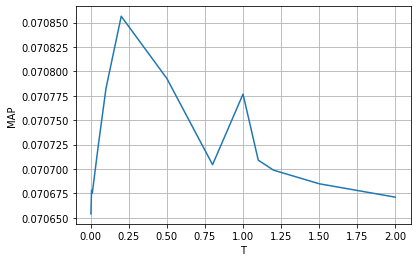

In [17]:
plotta(trials,means)